In [529]:
%matplotlib widget

In [530]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.animation as animation

import seaborn as sns
from statannot import add_stat_annotation

from scipy.linalg import expm
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from scipy import stats

import os
import pickle
import io

import xmltodict

import logging, time
logging.getLogger().setLevel(logging.INFO)

import itertools
import warnings

In [3]:
# import opensim_ipython as osim

# import sys
# # Are we running this script as a test? Users can ignore this line!
# running_as_test = True  #'unittest' in str().join(sys.argv)

# # Define global model where the arm lives.
# arm = osim.Model()
# if not running_as_test: arm.setUseVisualizer(True)

# # ---------------------------------------------------------------------------
# # Create two links, each with a mass of 1 kg, centre of mass at the body's
# # origin, and moments and products of inertia of zero.
# # ---------------------------------------------------------------------------

# humerus = osim.Body("humerus",
#                     1.0,
#                     osim.Vec3(0, 0, 0),
#                     osim.Inertia(0, 0, 0))
# radius = osim.Body("radius",
#                    1.0,
#                    osim.Vec3(0, 0, 0),
#                    osim.Inertia(0, 0, 0))

# # ---------------------------------------------------------------------------
# # Connect the bodies with pin joints. Assume each body is 1m long.
# # ---------------------------------------------------------------------------

# shoulder = osim.PinJoint("shoulder",
#                          arm.getGround(), # PhysicalFrame
#                          osim.Vec3(0, 0, 0),
#                          osim.Vec3(0, 0, 0),
#                          humerus, # PhysicalFrame
#                          osim.Vec3(0, 1, 0),
#                          osim.Vec3(0, 0, 0))

# elbow = osim.PinJoint("elbow",
#                       humerus, # PhysicalFrame
#                       osim.Vec3(0, 0, 0),
#                       osim.Vec3(0, 0, 0),
#                       radius, # PhysicalFrame
#                       osim.Vec3(0, 1, 0),
#                       osim.Vec3(0, 0, 0))

# # ---------------------------------------------------------------------------
# # Add a muscle that flexes the elbow (actuator for robotics people).
# # ---------------------------------------------------------------------------

# biceps = osim.Millard2012EquilibriumMuscle("biceps",  # Muscle name
#                                            200.0,  # Max isometric force
#                                            0.6,  # Optimal fibre length
#                                            0.55,  # Tendon slack length
#                                            0.0)  # Pennation angle
# biceps.addNewPathPoint("origin",
#                        humerus,
#                        osim.Vec3(0, 0.8, 0))

# biceps.addNewPathPoint("insertion",
#                        radius,
#                        osim.Vec3(0, 0.7, 0))

# # ---------------------------------------------------------------------------
# # Add a controller that specifies the excitation of the muscle.
# # ---------------------------------------------------------------------------

# brain = osim.PrescribedController()
# brain.addActuator(biceps)
# brain.prescribeControlForActuator("biceps",
#                                   osim.StepFunction(0.5, 3.0, 0.3, 1.0))

# # ---------------------------------------------------------------------------
# # Build model with components created above.
# # ---------------------------------------------------------------------------

# arm.addBody(humerus)
# arm.addBody(radius)
# arm.addJoint(shoulder) # Now required in OpenSim4.0
# arm.addJoint(elbow)
# arm.addForce(biceps)
# arm.addController(brain)

# # ---------------------------------------------------------------------------
# # Add a console reporter to print the muscle fibre force and elbow angle.
# # ---------------------------------------------------------------------------

# # We want to write our simulation results to the console.
# reporter = osim.ConsoleReporter()
# reporter.set_report_time_interval(1.0)
# reporter.addToReport(biceps.getOutput("fiber_force"))
# elbow_coord = elbow.getCoordinate().getOutput("value")
# reporter.addToReport(elbow_coord, "elbow_angle")
# arm.addComponent(reporter)

# # ---------------------------------------------------------------------------
# # Add display geometry. 
# # ---------------------------------------------------------------------------

# bodyGeometry = osim.Ellipsoid(0.1, 0.5, 0.1)
# bodyGeometry.setColor(osim.Gray)
# humerusCenter = osim.PhysicalOffsetFrame()
# humerusCenter.setName("humerusCenter")
# humerusCenter.setParentFrame(humerus)
# humerusCenter.setOffsetTransform(osim.Transform(osim.Vec3(0, 0.5, 0)))
# humerus.addComponent(humerusCenter)
# humerusCenter.attachGeometry(bodyGeometry.clone())

# radiusCenter = osim.PhysicalOffsetFrame()
# radiusCenter.setName("radiusCenter")
# radiusCenter.setParentFrame(radius)
# radiusCenter.setOffsetTransform(osim.Transform(osim.Vec3(0, 0.5, 0)))
# radius.addComponent(radiusCenter)
# radiusCenter.attachGeometry(bodyGeometry.clone())

# # ---------------------------------------------------------------------------
# # Configure the model.
# # ---------------------------------------------------------------------------

# state = arm.initSystem()
# # Fix the shoulder at its default angle and begin with the elbow flexed.
# shoulder.getCoordinate().setLocked(state, True)
# elbow.getCoordinate().setValue(state, 0.5 * osim.SimTK_PI)
# arm.equilibrateMuscles(state)

# # ---------------------------------------------------------------------------
# # Simulate.
# # ---------------------------------------------------------------------------

# manager = osim.Manager(arm)
# state.setTime(0)
# manager.initialize(state)
# state = manager.integrate(10.0)

# # ---------------------------------------------------------------------------
# # Print/save model file
# # ---------------------------------------------------------------------------

# arm.printToXML("SimpleArm.osim")

In [531]:
independent_joints = [#'eye-rx',
 #'eye-ry',
 'elv_angle',
 'shoulder_elv',
 'shoulder_rot',
 'elbow_flexion',
 'pro_sup',
 #'deviation',
 #'flexion'
 ]

actuator_names = ['DELT1',
 'DELT2',
 'DELT3',
 'SUPSP',
 'INFSP',
 'SUBSC',
 'TMIN',
 'TMAJ',
 'PECM1',
 'PECM2',
 'PECM3',
 'LAT1',
 'LAT2',
 'LAT3',
 'CORB',
 'TRIlong',
 'TRIlat',
 'TRImed',
 'ANC',
 'SUP',
 'BIClong',
 'BICshort',
 'BRA',
 'BRD',
 #'ECRL',
 #'ECRB',
 #'ECU',
 #'FCR',
 #'FCU',
 #'PL',
 'PT',
 'PQ',
 # 'FDSL',
 # 'FDSR',
 # 'FDSM',
 # 'FDSI',
 # 'FDPL',
 # 'FDPR',
 # 'FDPM',
 # 'FDPI',
 # 'EDCL',
 # 'EDCR',
 # 'EDCM',
 # 'EDCI',
 # 'EDM',
 # 'EIP',
 # 'EPL',
 # 'EPB',
 # 'FPL',
 #'APL'
 ]

actuator_names_dict = {'DELT1': 'deltoid1_r',
 'DELT2': 'deltoid2_r',
 'DELT3': 'deltoid3_r',
 'SUPSP': 'supraspinatus_r',
 'INFSP': 'infraspinatus_r',
 'SUBSC': 'subscapularis_r',
 'TMIN': 'teres_minor_r',
 'TMAJ': 'teres_major_r',
 'PECM1': 'pectoralis_major1_r',
 'PECM2': 'pectoralis_major2_r',
 'PECM3': 'pectoralis_major3_r',
 'LAT1': 'latissimus_dorsi1_r',
 'LAT2': 'latissimus_dorsi2_r',
 'LAT3': 'latissimus_dorsi3_r',
 'CORB': 'coracobrachialis_r',
 'TRIlong': 'triceps_longhead_r',
 'TRIlat': 'triceps_lateralis_r',
 'TRImed': 'triceps_medialis_r',
 'ANC': 'anconeus_r',
 'SUP': 'supinator_brevis_r',
 'BIClong': 'biceps_longhead_r',
 'BICshort': 'biceps_shorthead_r',
 'BRA': 'brachialis_r',
 'BRD': 'brachioradialis_r',
 'PT': 'pronator_teres_r',
 'PQ': 'pron_quad_r'}

In [532]:
### BASE CLASS FOR TRAJECTORY DATA
class TrajectoryData(object):
    
    SHOW_MINJERK = False  #if this is set to True, end-effector methods yield MinJerk trajectories instead of actual trajectories!

    def __init__(self):
        self.initialized = True
        self.preprocessed = False
        self.trials_defined = False
        
    # methods to override:
    # ----------------------------
    
    def preprocess(self):
        raise NotImplementedError
    
    def compute_indices(self):
        raise NotImplementedError
    
    
    # read-only properties [the respective internal attributes must be set in the subclass!]:
    #-----------------------------
    
    @property
    def position_series(self):
        if self.SHOW_MINJERK:
            return self._minjerk_position_series
        return self._position_series
    
    @property
    def velocity_series(self):
        if self.SHOW_MINJERK:
            return self._minjerk_velocity_series
        return self._velocity_series
    
    @property
    def acceleration_series(self):
        if self.SHOW_MINJERK:
            return self._minjerk_acceleration_series
        return self._acceleration_series
    
    @property
    def qpos_series(self):
        return self._qpos_series
    
    @property
    def qvel_series(self):
        return self._qvel_series
    
    @property
    def qacc_series(self):
        return self._qacc_series
    
    @property
    def act_series(self):
        return self._act_series
    
    @property
    def target_position_series(self):
        return self._target_position_series
    
    @property
    def target_radius_series(self):
        return self._target_radius_series
    
    @property
    def target_idx_series(self):
        return self._target_idx_series
    
    @property
    def time_series(self):
        return self._time_series
    
    @property
    def time_per_step(self):
        return self._time_per_step
    
    @property
    def indices(self):
        return self._indices
    
    @property
    def distance_to_target_series(self):
        return self._distance_to_target_series
    
    @property
    def action_series(self):
        return self._action_series
    
    @property
    def control_series(self):
        return self._control_series
    
    @property
    def reward_series(self):
        return self._reward_series
    
    
    #-----------------------------

    def compute_minjerk(self, MINJERK_USER_CONSTRAINTS=True, targetbound_as_target=False):
        self.minjerk_targetbound_as_target = targetbound_as_target
        
        assert self.initialized and self.preprocessed and self.trials_defined, "ERROR: Need to call preprocess() and compute_indices() first! "
        
        ## REFERENCE TRAJECTORY: MinJerk
        self._minjerk_position_series = np.zeros_like(np.squeeze(self._position_series)) * np.nan
        self._minjerk_velocity_series = np.zeros_like(np.squeeze(self._velocity_series)) * np.nan
        self._minjerk_acceleration_series = np.zeros_like(np.squeeze(self._acceleration_series)) * np.nan
        
        for episode_index_current, (last_idx, current_idx, next_idx) in enumerate(self.selected_movements_indices):
            if isinstance(last_idx, list):
                assert len(last_idx) == 1, "Indices are prepared for computing summary statistics. Use compute_statistics() instead."  #e.g., if len(AGGREGATION_VARS) > 0
                last_idx = last_idx[0]
                current_idx = current_idx[0]
                next_idx = next_idx[0]
            
            if self.minjerk_targetbound_as_target:
                next_idx_copy = next_idx
                try:  #use "target_radius" column
                    assert len(np.unique(self.target_radius_series[current_idx + 1: next_idx])) == 1, "ERROR: Target radius changes during movement! Cannot find reliable information about when target has been entered.\nFix dataset or use target center as distance (set 'targetbound_as_target=False')."
                    relindices_insidetarget_trial = np.where(np.linalg.norm(np.array(self.position_series[current_idx + 1: next_idx]) - np.array(self.target_position_series[current_idx + 1: next_idx]), axis=1) < self.target_radius_series[current_idx + 1])[0]
                except:  #use "inside_target" column
                    relindices_insidetarget_trial = np.where(self.data[self.data_key]["inside_target"][current_idx + 1:next_idx])[0]
                assert len(relindices_insidetarget_trial) > 0, "Using target boundary instead of target center as desired target position failed."
                targetbound_idx = (current_idx + 1 + relindices_insidetarget_trial[0]) + 1  #adding 1: -> targetbound_idx corresponds to first index that is not included anymore in considered trial series
                next_idx = targetbound_idx
                #input((next_idx_copy, next_idx))
            
            if MINJERK_USER_CONSTRAINTS:
                T = [np.concatenate((self._position_series[current_idx], self._position_series[next_idx - 1]))]
            else:
                T = [np.squeeze([self._target_position_series[last_idx] if last_idx >= 0 else self._position_series[0], self._target_position_series[current_idx]]).reshape(-1,)]
            x0 = np.concatenate((np.squeeze([self._position_series[current_idx], self._velocity_series[current_idx], self._acceleration_series[current_idx]]).reshape(-1,), T[0]))
            dim = 3
            x_minjerk, u_minjerk = minimumjerk_deterministic(next_idx - current_idx - 1, x0=x0, T=T, final_vel=self._velocity_series[next_idx - 1], final_acc=self._acceleration_series[next_idx - 1], P=2, dim=dim, dt=self._time_per_step, initialuservalues=None)
            self._minjerk_position_series[current_idx: next_idx] = x_minjerk[:, :dim]
            self._minjerk_velocity_series[current_idx: next_idx] = x_minjerk[:, dim:2*dim]
            self._minjerk_acceleration_series[current_idx: next_idx] = x_minjerk[:, 2*dim:3*dim]
            
    def get_statistics_info(self):
        if hasattr(self, "stats_episode_index_current"):
            return {"episode_index_current": self.stats_episode_index_current, "compute_deviation": self.stats_compute_deviation, "normalize_time": self.stats_normalize_time}
            
    def compute_statistics(self, episode_index_current, effective_projection_path=False, targetbound_as_target=False, compute_deviation=False, normalize_time=False, use_joint_data_only=False):
        self.stats_episode_index_current = episode_index_current
        self.stats_effective_projection_path = effective_projection_path
        self.stats_targetbound_as_target = targetbound_as_target
        self.stats_compute_deviation = compute_deviation
        self.stats_normalize_time = normalize_time
        
        self.stats_use_joint_data_only = use_joint_data_only
        
        if normalize_time:
            logging.warning(f"NORMALIZE_TIME was set to True, but is has no effect on the computation of distributions (mean, variability, etc.)!")
        
        last_idx_hlp, current_idx_hlp, next_idx_hlp = self.selected_movements_indices[episode_index_current]
        
        assert isinstance(last_idx_hlp, list), "No data to aggregate. Use compute_trial() instead."  #e.g., if len(AGGREGATION_VARS) > 0
        
        next_idx_hlp_copy = next_idx_hlp.copy()
        if self.stats_targetbound_as_target:
            # compute (relative) indices at which end-effector is inside target ("relindices_insidetarget_trial") ["+ 1" is used to avoid errors if target switches one step too late...] #TODO: ensure that target switch indices are exact!
            targetbound_idx_hlp = []
            for current_idx, next_idx in zip(current_idx_hlp, next_idx_hlp):
                try:  #use "target_radius" column
                    assert len(np.unique(self.target_radius_series[current_idx + 1: next_idx])) == 1, "ERROR: Target radius changes during movement! Cannot find reliable information about when target has been entered.\nFix dataset or use target center as distance (set 'targetbound_as_target=False')."
                    relindices_insidetarget_trial = np.where(np.linalg.norm(np.array(self.position_series[current_idx + 1: next_idx]) - np.array(self.target_position_series[current_idx + 1: next_idx]), axis=1) < self.target_radius_series[current_idx + 1])[0]
                except:  #use "inside_target" column
                    relindices_insidetarget_trial = np.where(self.data[self.data_key]["inside_target"][current_idx + 1:next_idx])[0]

                assert len(relindices_insidetarget_trial) > 0, "Using target boundary instead of target center as desired target position failed."
                targetbound_idx = (current_idx + 1 + relindices_insidetarget_trial[0]) + 1  #adding 1: -> targetbound_idx corresponds to first index that is not included anymore in considered trial series
                targetbound_idx_hlp.append(targetbound_idx)
            next_idx_hlp = targetbound_idx_hlp
        
        if not self.stats_use_joint_data_only:
            if self.stats_effective_projection_path:  #ensures that first and last value of projected_trajectories_pos_trial equal 0 and 1, respectively
                init_val = self.position_series[current_idx_hlp]
                final_val = self.position_series[[i - 1 for i in next_idx_hlp]]
            else:
                init_val = np.unique(self.target_position_series[[i+1 for i in last_idx_hlp if i>=0]], axis=0).reshape(-1,)
                final_val = np.unique(self.target_position_series[[i+1 for i in current_idx_hlp if i>=0]], axis=0).reshape(-1,)
                assert init_val.shape == (3,), "ERROR: Cannot reliably determine (nominal) initial position."
                assert final_val.shape == (3,), "ERROR: Cannot reliably determine (nominal) target position."
                assert init_val is not final_val, "ERROR: Initial and target position do not differ!"

            self.init_val = init_val
            self.final_val = final_val

            # for current_idx, next_idx in zip(current_idx_hlp, next_idx_hlp):
            #     input((self.init_val, self.position_series[current_idx], self.final_val, self.position_series[next_idx]))

            self.projected_trajectories_pos_mean, self.projected_trajectories_pos_cov, self.projected_trajectories_pos_min, self.projected_trajectories_pos_max = compute_trajectory_statistics(self.position_series, current_idx_hlp, next_idx_hlp, project=True, init_val=init_val, final_val=final_val, use_rel_vals=True, output_deviation=compute_deviation)
            self.projected_trajectories_vel_mean, self.projected_trajectories_vel_cov, self.projected_trajectories_vel_min, self.projected_trajectories_vel_max = compute_trajectory_statistics(self.velocity_series, current_idx_hlp, next_idx_hlp, project=True, init_val=init_val, final_val=final_val, use_rel_vals=False, output_deviation=compute_deviation)
            self.projected_trajectories_acc_mean, self.projected_trajectories_acc_cov, self.projected_trajectories_acc_min, self.projected_trajectories_acc_max = compute_trajectory_statistics(self.acceleration_series, current_idx_hlp, next_idx_hlp, project=True, init_val=init_val, final_val=final_val, use_rel_vals=False, output_deviation=compute_deviation)
        
        self.qpos_series_mean, self.qpos_series_cov, self.qpos_series_min, self.qpos_series_max = compute_trajectory_statistics(self.qpos_series, current_idx_hlp, next_idx_hlp)
        self.qvel_series_mean, self.qvel_series_cov, self.qvel_series_min, self.qvel_series_max = compute_trajectory_statistics(self.qvel_series, current_idx_hlp, next_idx_hlp)
        self.qacc_series_mean, self.qacc_series_cov, self.qacc_series_min, self.qacc_series_max = compute_trajectory_statistics(self.qacc_series, current_idx_hlp, next_idx_hlp)
        self.target_pos_mean, self.target_pos_cov, _, _ = compute_trajectory_statistics(self.target_position_series, current_idx_hlp, next_idx_hlp)
        self.target_radius_mean, self.target_radius_cov, _, _ = compute_trajectory_statistics(self.target_radius_series, current_idx_hlp, next_idx_hlp)
        self.target_idx_mean, self.target_idx_cov, _, _ = compute_trajectory_statistics(self.target_idx_series, current_idx_hlp, next_idx_hlp)
        if not np.isnan(self.target_idx_mean).all():
            self.target_idx_mean = self.target_idx_mean.astype(int)
        _, self.time_series_cov, self.time_series_extended, _ = compute_trajectory_statistics(self.time_series, current_idx_hlp, next_idx_hlp, rel_to_init=True, normalize=normalize_time)
        if not normalize_time and not (np.isclose(self.time_series_cov, 0).all() or np.isnan(self.time_series_cov).all()):
            raise ValueError(f"ERROR: Ensure that time series are correctly aligned.")
        self.distance_to_target_mean, self.distance_to_target_cov, self.distance_to_target_min, self.distance_to_target_max = compute_trajectory_statistics(self.distance_to_target_series, current_idx_hlp, next_idx_hlp)
        if hasattr(self, "_distance_to_joystick_series"):
            self.distance_to_joystick_mean, self.distance_to_joystick_cov, self.distance_to_joystick_min, self.distance_to_joystick_max = compute_trajectory_statistics(self._distance_to_joystick_series, current_idx_hlp, next_idx_hlp)

    def compute_action_statistics(self, episode_index_current, targetbound_as_target=False, normalize_time=False):
        self.action_stats_episode_index_current = episode_index_current
        self.action_stats_targetbound_as_target = targetbound_as_target
        self.action_stats_normalize_time = normalize_time
        
        if normalize_time:
            logging.warning(f"NORMALIZE_TIME was set to True, but is has no effect on the computation of distributions (mean, variability, etc.)!")
        
        last_idx_hlp, current_idx_hlp, next_idx_hlp = self.selected_movements_indices[episode_index_current]
        
        assert isinstance(last_idx_hlp, list), "No data to aggregate. Use compute_trial() instead."  #e.g., if len(AGGREGATION_VARS) > 0
        
        next_idx_hlp_copy = next_idx_hlp.copy()
        if self.action_stats_targetbound_as_target:
            # compute (relative) indices at which end-effector is inside target ("relindices_insidetarget_trial") ["+ 1" is used to avoid errors if target switches one step too late...] #TODO: ensure that target switch indices are exact!
            targetbound_idx_hlp = []
            for current_idx, next_idx in zip(current_idx_hlp, next_idx_hlp):
                try:  #use "target_radius" column
                    assert len(np.unique(self.target_radius_series[current_idx + 1: next_idx])) == 1, "ERROR: Target radius changes during movement! Cannot find reliable information about when target has been entered.\nFix dataset or use target center as distance (set 'targetbound_as_target=False')."
                    relindices_insidetarget_trial = np.where(np.linalg.norm(np.array(self.position_series[current_idx + 1: next_idx]) - np.array(self.target_position_series[current_idx + 1: next_idx]), axis=1) < self.target_radius_series[current_idx + 1])[0]
                except:  #use "inside_target" column
                    relindices_insidetarget_trial = np.where(self.data[self.data_key]["inside_target"][current_idx + 1:next_idx])[0]

                assert len(relindices_insidetarget_trial) > 0, "Using target boundary instead of target center as desired target position failed."
                targetbound_idx = (current_idx + 1 + relindices_insidetarget_trial[0]) + 1  #adding 1: -> targetbound_idx corresponds to first index that is not included anymore in considered trial series
                targetbound_idx_hlp.append(targetbound_idx)
            next_idx_hlp = targetbound_idx_hlp
        
        if hasattr(self, "_action_series"):
            self.action_series_mean, self.action_series_cov, self.action_series_min, self.action_series_max = compute_trajectory_statistics(self.action_series, current_idx_hlp, next_idx_hlp)
        if hasattr(self, "_control_series"):
            self.control_series_mean, self.control_series_cov, self.control_series_min, self.control_series_max = compute_trajectory_statistics(self.control_series, current_idx_hlp, next_idx_hlp)
        if hasattr(self, "_reward_series"):
            self.reward_series_mean, self.reward_series_cov, self.reward_series_min, self.reward_series_max = compute_trajectory_statistics(self.reward_series, current_idx_hlp, next_idx_hlp)
        _, self.action_stats_time_series_cov, self.action_stats_time_series_extended, _ = compute_trajectory_statistics(self.time_series, current_idx_hlp, next_idx_hlp, rel_to_init=True, normalize=normalize_time)
        if not normalize_time and not (np.isclose(self.action_stats_time_series_cov, 0).all() or np.isnan(self.action_stats_time_series_cov).all()):
            raise ValueError(f"ERROR: Ensure that time series are correctly aligned.")
            
    def get_trial_info(self):
        if hasattr(self, "trial_index_current"):
            return {"trial_index_current": self.trial_index_current, "compute_deviation": self.trial_compute_deviation, "normalize_time": self.trial_normalize_time, "joint_id": self.trial_joint_id}        

    def compute_trial(self, trial_index_current, effective_projection_path=False, targetbound_as_target=False, dwell_time=0, compute_deviation=False, normalize_time=False):
        self.trial_index_current = trial_index_current
        self.trial_effective_projection_path = effective_projection_path
        self.trial_targetbound_as_target = targetbound_as_target
        self.trial_dwell_time = dwell_time  #in seconds; used for movement time computation (e.g., for Fitts' Law)
        self.trial_compute_deviation = compute_deviation
        self.trial_normalize_time = normalize_time
        
        last_idx, current_idx, next_idx = self.selected_movements_indices[trial_index_current]
        
        if isinstance(last_idx, list):
            assert len(last_idx) == 1, "Indices are prepared for computing summary statistics. Use compute_statistics() instead."  #e.g., if len(AGGREGATION_VARS) > 0
            last_idx = last_idx[0]
            current_idx = current_idx[0]
            next_idx = next_idx[0]
        
        # compute (relative) indices at which end-effector is inside target ("relindices_insidetarget_trial") ["+ 1" is used to avoid errors if target switches one step too late...] #TODO: ensure that target switch indices are exact!
        _start_idx = min(current_idx + 1, next_idx - 1)
        try:  #use "target_radius" column
            # print(pd.Series(self.target_radius_series).value_counts())
            # print((len(self.target_radius_series), current_idx, next_idx))
            # if current_idx == next_idx:
            #     print((self.selected_movements_indices, self.indices))
            assert len(np.unique(self.target_radius_series[_start_idx: next_idx])) == 1, "ERROR: Target radius changes during movement! Cannot find reliable information about when target has been entered.\nFix dataset or use target center as distance (set 'targetbound_as_target=False')."
            self.relindices_insidetarget_trial = np.where(np.linalg.norm(np.array(self.position_series[_start_idx:next_idx]) - np.array(self.target_position_series[_start_idx:next_idx]), axis=1) < self.target_radius_series[_start_idx])[0]
        except:  #use "inside_target" column
            self.relindices_insidetarget_trial = np.where(self.data[self.data_key]["inside_target"][_start_idx:next_idx])[0]

        next_idx_copy = next_idx
        if self.trial_targetbound_as_target:
            assert len(self.relindices_insidetarget_trial) > 0, "Using target boundary instead of target center as desired target position failed."
            targetbound_idx = (_start_idx + self.relindices_insidetarget_trial[0]) + 1  #adding 1: -> targetbound_idx corresponds to first index that is not included anymore in considered trial series
            next_idx = targetbound_idx
                
        if effective_projection_path:  #ensures that first and last value of projected_trajectories_pos_trial equal 0 and 1, respectively
            init_val = self.position_series[current_idx]
            final_val = self.position_series[next_idx - 1]
        else:
            init_val = self.target_position_series[last_idx + 1] if last_idx >= 0 else self.position_series[0]
            final_val = self.target_position_series[_start_idx]
            # TODO: use target boundary position as final_val if self.trial_targetbound_as_target?
        
        self.init_val = init_val
        self.final_val = final_val
        
        time_series_shifted = np.array(self.time_series[current_idx: next_idx]) - self.time_series[current_idx]
        if normalize_time:
            time_series_shifted = (time_series_shifted - time_series_shifted[0])/(time_series_shifted[-1] - time_series_shifted[0])
        self.time_series_trial = time_series_shifted
        
        self.target_position_series_trial = self.target_position_series[current_idx: next_idx]
        self.target_radius_series_trial = self.target_radius_series[current_idx: next_idx]
        self.target_idx_series_trial = self.target_idx_series[current_idx: next_idx]
        
        self.position_series_trial = self.position_series[current_idx: next_idx]
        self.velocity_series_trial = self.velocity_series[current_idx: next_idx]
        self.acceleration_series_trial = self.acceleration_series[current_idx: next_idx]
        # input((self.position_series_trial, init_val, final_val))
        self.projected_trajectories_pos_trial = project_trajectory(self.position_series_trial, init_val=init_val, final_val=final_val, use_rel_vals=True, normalize_quantity=True, output_deviation=compute_deviation)
        self.projected_trajectories_vel_trial = project_trajectory(self.velocity_series_trial, init_val=init_val, final_val=final_val, use_rel_vals=False, normalize_quantity=False, output_deviation=compute_deviation)
        self.projected_trajectories_acc_trial = project_trajectory(self.acceleration_series_trial, init_val=init_val, final_val=final_val, use_rel_vals=False, normalize_quantity=False, output_deviation=compute_deviation)
        # self.qpos_series_trial = self.qpos_series[current_idx: next_idx, :]  #optional
        # self.qvel_series_trial = self.qvel_series[current_idx: next_idx, :]  #optional
        # self.qacc_series_trial = self.qacc_series[current_idx: next_idx, :]  #optional
        
        self.distance_to_target_trial = self.distance_to_target_series[current_idx: next_idx]
        
        #Optional attributes
        for attr in ["qpos_series", "qvel_series", "qacc_series",
                     "act_series", "action_series", "control_series", "reward_series"]:
            if hasattr(self, f"_{attr}") and getattr(self, f"_{attr}") is not None:
                setattr(self, f"{attr}_trial", getattr(self, f"_{attr}")[current_idx: next_idx, ...])
                setattr(self, f"{attr.split('_series')[0]}_available", True)
            else:
                setattr(self, f"{attr.split('_series')[0]}_available", False)
        
        #Statistics
        self.target_width_trial = 2 * self.target_radius_series[current_idx]
        self.target_distance_trial = np.linalg.norm(self.final_val - self.init_val)
        #self.fitts_ID_trial = np.log2(2*(self.target_distance_trial/self.target_width_trial))
        self.fitts_ID_trial = np.log2((self.target_distance_trial/self.target_width_trial) + 1)
        if self.trial_targetbound_as_target:
            self.effective_MT_trial = (next_idx - current_idx)*self.time_per_step  #here: next_idx <- targetbound_idx
        else:
            self.effective_MT_trial = (next_idx - current_idx)*self.time_per_step - self.trial_dwell_time
        
        # compute number of target (re-)entries and covariance of end-effector position when inside target (i.e., only for "relindices_insidetarget_trial")
        target_re_entries_meta_indices = np.where(np.diff(self.relindices_insidetarget_trial) != 1)[0] + 1
        self.num_target_entries_trial = len(target_re_entries_meta_indices) + 1 if target_re_entries_meta_indices.size > 0 else 0
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            position_series_trial_insidetarget = np.array(self.position_series[_start_idx:next_idx_copy])[self.relindices_insidetarget_trial]
            self.endeffector_insidetarget_covariance = np.cov(position_series_trial_insidetarget, rowvar=False) if position_series_trial_insidetarget.shape[0] != 1 else np.zeros((position_series_trial_insidetarget.shape[1], position_series_trial_insidetarget.shape[1]))



In [533]:
class TrajectoryData_MultipleInstances(TrajectoryData):
    def __init__(self, trajectories):
        super(TrajectoryData_MultipleInstances, self).__init__()
        
        assert isinstance(trajectories, list) or isinstance(trajectories, tuple), "Trajectory list has wrong type (only lists or tuples are valid)."
        assert all([isinstance(trajectory, TrajectoryData) for trajectory in trajectories]), "Invalid element in trajectory list (all elements need to be 'TrajectoryData' instances)."
        self.trajectories = trajectories
        
        assert all([trajectory.preprocessed for trajectory in trajectories]), "ERROR: All TrajectoryData elements need to be preprocessed!"
        assert all([not trajectory.trials_defined for trajectory in trajectories]), "ERROR: Trials were already selected for at least one of the used TrajectoryData elements. Ensure that this MultipleInheritance instance is generated directly after preprocessing the individual TrajectoryData instances."
        
        # Combine indices (makes use of "combine_indices()" function from used TrajectoryData class)
        assert all([type(i)==type(j) for i,j in itertools.combinations(self.trajectories, 2)]), "ERROR: Cannot combine indices, since instances of different classes are used."
        indices_list = [i._indices for i in self.trajectories]
        n_samples_list = [len(i.position_series) for i in self.trajectories]
        self.trajectories[0].__class__.combine_indices(self, indices_list, n_samples_list)
        self.preprocessed = True
        
    def __getattr__(self, attr):
        #print(f"__getattr__ is used.")
        if not all([hasattr(trajectory, attr) for trajectory in self.trajectories]):
            raise AttributeError(f"'{attr}' is not available for all chosen TrajectoryData instances.")
        attr_values = [getattr(trajectory, attr) for trajectory in self.trajectories]
        if all([isinstance(value, str) for value in attr_values]) and all([i==j for i,j in itertools.combinations(attr_values, 2)]):
            value = attr_values[0]
        elif all([isinstance(value, np.ndarray) for value in attr_values]) or all([isinstance(value, list) for value in attr_values]):
            value = np.concatenate(attr_values)
        elif all([isinstance(value, pd.core.arrays.integer.IntegerArray) for value in attr_values]):
            value = pd.array(np.concatenate(attr_values), dtype="Int64")
        elif all([isinstance(value, int) or isinstance(value, float) for value in attr_values]):
            value = np.array([attr_values])
        else:
            raise TypeError(f"Attr '{attr}': One of the Trajectory Data types ({[type(value) for value in attr_values]}) cannot be used for concatenation.")
        setattr(self, attr, value)
        return value
    
    def compute_indices(self, *args, **kwargs):  
        """
        Computes self.selected_movements_indices based on self.indices, which in turn was computed in this class' __init__() using combine_indices() from respective TrajectoryData class
        """
        assert all([type(i)==type(j) for i,j in itertools.combinations(self.trajectories, 2)]), "ERROR: Cannot compute selected indices, since instances of different classes are used."
        self.trajectories[0].__class__.compute_indices(self, *args, **kwargs)
            
        self.trials_defined = True


In [534]:
### PRE-PROCESS SIMULATION DATA FROM ALEKSI'S RL ENVIRONMENT
class TrajectoryData_RL(TrajectoryData):
    
    def __init__(self, filename, REPEATED_MOVEMENTS=False):
        
        self.filepath = os.path.expanduser(f"~/user-in-the-box/UIST/{filename}/")  #warning: here, "self.filepath" is directory!
        self.REPEATED_MOVEMENTS = REPEATED_MOVEMENTS  #if True, combine individual log files into one data structure
        
        super().__init__()
        
        if self.REPEATED_MOVEMENTS:
            rep_movs_data = {}
            rep_movs_data_action = {}
            for subdir in [i for i in os.listdir((os.path.expanduser(self.filepath))) if os.path.isdir(os.path.join(os.path.expanduser(self.filepath), i))]:
                subdir_abs = os.path.join(os.path.expanduser(self.filepath), subdir)
                for subsubdir in [i for i in os.listdir(subdir_abs) if os.path.isdir(os.path.join(subdir_abs, i))]:
                    subsubdir_abs = os.path.join(os.path.expanduser(self.filepath), subdir, subsubdir)
                    rep_movs_filepath = os.path.join(subsubdir_abs, "state_log.pickle")
                    rep_movs_filepath_action = os.path.join(subsubdir_abs, "action_log.pickle")
                    with open(os.path.expanduser(rep_movs_filepath), "rb") as f:
                        helper = pickle.load(f)
                        for k, v in helper.items():
                            rep_movs_data[f"{subdir}__{subsubdir}__{k}"] = v
                    with open(os.path.expanduser(rep_movs_filepath_action), "rb") as f:
                        helper = pickle.load(f)
                        for k, v in helper.items():
                            rep_movs_data_action[f"{subdir}__{subsubdir}__{k}"] = v
            self.data = rep_movs_data
            self.data_action = rep_movs_data_action
        else:
            with open(os.path.join(self.filepath, "state_log.pickle"), "rb") as f:
                self.data = pickle.load(f)
            with open(os.path.join(self.filepath, "action_log.pickle"), "rb") as f:
                self.data_action = pickle.load(f)
                
        self.EPISODE_ID_NUMS = len(np.unique(list(map(lambda x: x.split('episode_')[-1].split('_')[0], self.data.keys()))))
        print(f"{self.EPISODE_ID_NUMS} episodes identified.")
                
        self.data_copy = self.data.copy()
        self.data_action_copy = self.data_action.copy()
        
    def preprocess(self, MOVEMENT_IDS=None, RADIUS_IDS=None, EPISODE_IDS=None, split_trials=True,
                  endeffector_name="fingertip", target_name="target"):
        # INFO: "MOVEMENT_IDS", "RADIUS_IDS", and "EPISODE_IDS" should be array-like (list, np.array, range-object, etc.)
        self.endeffector_name = endeffector_name
        self.target_name = target_name
        
        self.EPISODE_IDS = [str(EPISODE_ID).zfill(len(list(self.data.keys())[0].split("episode_")[-1].split("__")[0])) for EPISODE_ID in EPISODE_IDS or np.unique([int(i.split("episode_")[-1].split("__")[0]) for i in list(self.data.keys())])]
        
        if self.REPEATED_MOVEMENTS:
            self.MOVEMENT_IDS = [str(MOVEMENT_ID).zfill(len(list(self.data.keys())[0].split("movement_")[-1].split("__")[0])) for MOVEMENT_ID in MOVEMENT_IDS or np.unique([int(i.split("movement_")[-1].split("__")[0]) for i in list(self.data.keys())])]
            self.RADIUS_IDS = [str(RADIUS_ID).zfill(len(list(self.data.keys())[0].split("radius_")[-1].split("__")[0])) for RADIUS_ID in RADIUS_IDS or np.unique([int(i.split("radius_")[-1].split("__")[0]) for i in list(self.data.keys())])]
        else:
            assert MOVEMENT_IDS is None
            assert RADIUS_IDS is None
                    
#         if REPEATED_MOVEMENTS is not None:
#             self.REPEATED_MOVEMENTS = REPEATED_MOVEMENTS  #can be overwritten here (useful, if one ones to include several log files as individual episodes in self.data (e.g., when computing summary statistics))
        
        #self.AGGREGATE_TRIALS = AGGREGATE_TRIALS or (EPISODE_ID == "VARIABLE")
        
        # reset to data/data_action resulting from __init__() [necessary to call preprocess() multiple times in a row]:
        self.data = self.data_copy.copy()
        self.data_action = self.data_action_copy.copy()
        
        EPISODE_ID_NUMS = len(self.EPISODE_IDS) #if EPISODE_IDS is not None else self.EPISODE_ID_NUMS 
        
#         if self.AGGREGATE_TRIALS:
#             if EPISODE_ID == "VARIABLE":  #self.REPEATED_MOVEMENTS:
#                 EPISODE_ID_LIST = [f"{EPISODE_ID_CURRENT}".zfill(len(list(self.data.keys())[0].split("episode_")[-1])) for EPISODE_ID_CURRENT in range(EPISODE_ID_NUMS)]
#                 assert self."radius" not in AGGREGATION_VARS
#             else:
#                 EPISODE_ID_LIST = [EPISODE_ID]

#         if not self.AGGREGATE_TRIALS:
#             if EPISODE_ID.isdigit():
#                 self.EPISODE_ID = EPISODE_ID.zfill(len(list(self.data.keys())[0].split("episode_")[-1]))  #.zfill(3 + (("100episodes" not in filepath) and ("state_log" not in filepath) and ("TwoLevel" not in filepath)) - ("TwoLevel" in filepath))
#                 data_key = f"episode_{self.EPISODE_ID}"
#             else: 
#                 data_key = EPISODE_ID
#             self.data_key = data_key
#         else:  #i.e., EPISODE_ID == "VARIABLE"
#             #assert self.REPEATED_MOVEMENTS, "ERROR: Check code dependencies..."
            
#             if "radius" not in AGGREGATION_VARS and self.REPEATED_MOVEMENTS:
#                 self.EPISODE_ID = EPISODE_ID

#                 self.data_copy = self.data.copy()
#                 self.data_action_copy = self.data_action.copy()

#                 for RADIUS_ID_CURRENT in range(self.RADIUS_ID_NUMS):
#                     self.data[f"movement_{self.MOVEMENT_ID}__radius_{RADIUS_ID_CURRENT}__episode_{self.EPISODE_ID}"] = {}
#                     self.data_action[f"movement_{self.MOVEMENT_ID}__radius_{RADIUS_ID_CURRENT}__episode_{self.EPISODE_ID}"] = {}
#                     for EPISODE_ID_CURRENT in EPISODE_ID_LIST:
#                         data_key = f"movement_{self.MOVEMENT_ID}__radius_{RADIUS_ID_CURRENT}__episode_{EPISODE_ID_CURRENT}"
#                         for k, v in self.data[data_key].items():
#                             if k != f"movement_{self.MOVEMENT_ID}__radius_{RADIUS_ID_CURRENT}__episode_{self.EPISODE_ID}":
#                                 self.data[f"movement_{self.MOVEMENT_ID}__radius_{RADIUS_ID_CURRENT}__episode_{self.EPISODE_ID}"][k] = v if k not in self.data[f"movement_{self.MOVEMENT_ID}__radius_{RADIUS_ID_CURRENT}__episode_{self.EPISODE_ID}"] else self.data[f"movement_{self.MOVEMENT_ID}__radius_{RADIUS_ID_CURRENT}__episode_{self.EPISODE_ID}"][k] + v
#                         for k, v in self.data_action[data_key].items():
#                             if k != f"movement_{self.MOVEMENT_ID}__radius_{RADIUS_ID_CURRENT}__episode_{self.EPISODE_ID}":
#                                 self.data_action[f"movement_{self.MOVEMENT_ID}__radius_{RADIUS_ID_CURRENT}__episode_{self.EPISODE_ID}"][k] = v if k not in self.data_action[f"movement_{self.MOVEMENT_ID}__radius_{RADIUS_ID_CURRENT}__episode_{self.EPISODE_ID}"] else self.data_action[f"movement_{self.MOVEMENT_ID}__radius_{RADIUS_ID_CURRENT}__episode_{self.EPISODE_ID}"][k] + v
#             else:
#                 self.EPISODE_ID = EPISODE_ID

#                 assert not self.REPEATED_MOVEMENTS, "In this case, data keys should consist of episode IDs only."
#                 assert self.EPISODE_ID == "VARIABLE"
                
#                 self.data[f"episode_{self.EPISODE_ID}"] = {}
#                 self.data_action[f"episode_{self.EPISODE_ID}"] = {}
#                 for EPISODE_ID_CURRENT in EPISODE_ID_LIST:
#                     data_key = f"episode_{EPISODE_ID_CURRENT}"
#                     for k, v in self.data[data_key].items():
#                         if k != f"episode_{self.EPISODE_ID}":
#                             self.data[f"episode_{self.EPISODE_ID}"][k] = v if k not in self.data[f"episode_{self.EPISODE_ID}"] else self.data[f"episode_{self.EPISODE_ID}"][k] + v
#                     for k, v in self.data_action[data_key].items():
#                         if k != f"episode_{self.EPISODE_ID}":
#                             self.data_action[f"episode_{self.EPISODE_ID}"][k] = v if k not in self.data_action[f"episode_{self.EPISODE_ID}"] else self.data_action[f"episode_{self.EPISODE_ID}"][k] + v
                
#                 data_key = f"episode_{self.EPISODE_ID}"

            
        self._position_series = []
        self._velocity_series = []
        self._acceleration_series = []
        self._qpos_series = []
        self._qvel_series = []
        self._qacc_series = []
        self._target_position_series = []
        self._target_radius_series = []
        self._target_idx_series = []
        self._time_series = []
        self._time_per_step = []
        self._indices = []

        self._distance_to_target_series = []

        self._action_series = []
        self._control_series = []
        self._reward_series = []
        
        if self.REPEATED_MOVEMENTS:
            # -> Data keys consist of movement, radius, and episode index
            self._movement_idx_trials = []
            self._radius_idx_trials = []
            self._episode_idx_trials = []
            self._target_idx_trials = []
            
            total_steps = 0
            
            for MOVEMENT_ID_CURRENT in self.MOVEMENT_IDS:
                for RADIUS_ID_CURRENT in self.RADIUS_IDS:
                    for EPISODE_ID_CURRENT in self.EPISODE_IDS:
                        data_key = f"movement_{MOVEMENT_ID_CURRENT}__radius_{RADIUS_ID_CURRENT}__episode_{EPISODE_ID_CURRENT}"
                        self._movement_idx_trials.append(int(MOVEMENT_ID_CURRENT))
                        self._radius_idx_trials.append(int(RADIUS_ID_CURRENT))
                        self._episode_idx_trials.append(int(EPISODE_ID_CURRENT))
                                    
                        self._position_series.append(np.squeeze(self.data[data_key][f"{endeffector_name}_xpos"]))
                        self._velocity_series.append(np.squeeze(self.data[data_key][f"{endeffector_name}_xvelp"]))
                        self._qpos_series.append(np.squeeze(self.data[data_key]["qpos"] if "qpos" in self.data[data_key] else np.zeros((len(self.data[data_key]["timestep"]), len(independent_joints))) * np.nan))
                        self._qvel_series.append(np.squeeze(self.data[data_key]["qvel"] if "qvel" in self.data[data_key] else np.zeros((len(self.data[data_key]["timestep"]), len(independent_joints))) * np.nan))
                        self._qacc_series.append(np.squeeze(self.data[data_key]["qacc"] if "qacc" in self.data[data_key] else np.zeros((len(self.data[data_key]["timestep"]), len(independent_joints))) * np.nan))
                        if target_name == "target":
                            self._target_position_series.append(np.squeeze(self.data[data_key][f"target_position"]))
                        else:
                            self._target_position_series.append(np.squeeze(self.data[data_key][f"{target_name}_xpos"]))
                        self._target_radius_series.append(np.squeeze(self.data[data_key][f"{target_name}_radius"] if f"{target_name}_radius" in self.data[data_key] else np.ones(shape=(len(self.data[data_key][f"{target_name}_xpos"]),)) * np.nan))
                        self._target_idx_series.append(np.squeeze(self.data[data_key][f"{target_name}_idx"] if f"{target_name}_idx" in self.data[data_key] else np.array(self._target_radius_series[-1]) * np.nan))
                        self._time_series.append(np.squeeze(self.data[data_key]["timestep"]))

                        self._distance_to_target_series.append(np.linalg.norm(self._target_position_series[-1] - self._position_series[-1], axis=1))
                        
                        self._action_series.append(np.squeeze(self.data_action[data_key]["action"]))
                        self._control_series.append(np.squeeze(self.data_action[data_key]["ctrl"]))
                        self._reward_series.append(np.squeeze(self.data_action[data_key]["reward"]))
                        if len(self._action_series[-1]) == len(self._position_series[-1]) - 1:  #duplicate last action if this allows to match length of position and action series
                            self._action_series[-1] = np.vstack((self._action_series[-1], self._action_series[-1][-1]))
                        if len(self._control_series[-1]) == len(self._position_series[-1]) - 1:  #duplicate last control if this allows to match length of position and control series
                            self._control_series[-1] = np.vstack((self._control_series[-1], self._control_series[-1][-1]))
                        if len(self._reward_series[-1]) == len(self._position_series[-1]) - 1:  #add 0 to reward series if this allows to match length of position and reward series
                            self._reward_series[-1] = np.hstack((self._reward_series[-1], [0]))  #1D
                        
                        self._time_per_step.append(np.diff(self._time_series[-1]).mean())  #0.01 if self.REPEATED_MOVEMENTS else np.diff(self._time_series[-1]).mean())  #0.01
                        
                        if split_trials:
                            #current_indices = np.append(np.insert(np.where(self.data[data_key]["target_hit"])[0], 0, 0), len(self.data[data_key]["target_hit"]))
                            try:
                                current_indices = np.insert(np.where(self.data[data_key][f"{target_name}_spawned"])[0], 0, 0)
                            except KeyError:
                                current_indices = []
                            if len(current_indices) <= 2:  #recompute self._indices based on switches in target position
                                current_indices = np.where(np.diff(np.squeeze(self._target_position_series[-1]), axis=0).sum(axis=1))[0] + 1
                            assert len(current_indices) > 2, f"Current_indices ({current_indices}) should have more than 2 entries."
                        else:
                            current_indices = np.array([0, len(self._position_series[-1]) - 1])
                        self._target_idx_trials.append(np.squeeze(self.data[data_key][f"{target_name}_idx"])[current_indices] if f"{target_name}_idx" in self.data[data_key] else [-1] * len(current_indices))
                        current_indices += total_steps  #transform to "global" indices of concatenated arrays
                        self._indices.append(current_indices)
                        
                        ## WARNING: deprecated (e.g., use current_indices instead of self._indices...)!
                        # # recover end-effector position time series [only for corrupted pickle file]
                        # if self.filepath in ["log.pickle", "state_log.pickle"] or self.filepath.endswith("log_one_policy_100episodes_100Hz.pickle"):
                        #     current_position_series = (np.cumsum(self._velocity_series[-1], axis=0) * self._time_per_step[-1])
                        #     current_position_series = pd.DataFrame(current_position_series).apply(lambda x: savgol_filter(x, 15, 3, deriv=0, delta = self._time_per_step[-1])).values
                        #     current_position_series += self._target_position_series[-1][self._indices[1] - 1] - current_position_series[self._indices[1] - 1] #ensure that target is reached at target hit/switch time
                        #     self._position_series[-1] = current_position_series

                        #self._velocity_series.append(pd.DataFrame(self._position_series[-1]).apply(lambda x: savgol_filter(x, 15, 3, deriv=1, delta = self._time_per_step[-1])).values)
                        self._acceleration_series.append(pd.DataFrame(self._position_series[-1]).apply(lambda x: savgol_filter(x, 15, 3, deriv=2, delta = self._time_per_step[-1])).values)
                        
                        total_steps += len(self.data[data_key]["timestep"])

            self._movement_idx_trials = np.hstack(self._movement_idx_trials)  #1D
            self._radius_idx_trials = np.hstack(self._radius_idx_trials)  #1D
            self._episode_idx_trials = np.hstack(self._episode_idx_trials)  #1D

        else:
            # -> Data keys only consist of episode index
            self._episode_idx_trials = []
            self._target_idx_trials = []
            
            total_steps = 0

            for EPISODE_ID_CURRENT in self.EPISODE_IDS:
                data_key = f"episode_{EPISODE_ID_CURRENT}"
                self._episode_idx_trials.append(int(EPISODE_ID_CURRENT))
                
                self._position_series.append(np.squeeze(self.data[data_key][f"{endeffector_name}_xpos"]))
                self._velocity_series.append(np.squeeze(self.data[data_key][f"{endeffector_name}_xvelp"]))
                self._qpos_series.append(np.squeeze(self.data[data_key]["qpos"] if "qpos" in self.data[data_key] else np.zeros((len(self.data[data_key]["timestep"]), len(independent_joints))) * np.nan))
                self._qvel_series.append(np.squeeze(self.data[data_key]["qvel"] if "qvel" in self.data[data_key] else np.zeros((len(self.data[data_key]["timestep"]), len(independent_joints))) * np.nan))
                self._qacc_series.append(np.squeeze(self.data[data_key]["qacc"] if "qacc" in self.data[data_key] else np.zeros((len(self.data[data_key]["timestep"]), len(independent_joints))) * np.nan))
                if target_name == "target":
                    self._target_position_series.append(np.squeeze(self.data[data_key][f"target_position"]))
                else:
                    self._target_position_series.append(np.squeeze(self.data[data_key][f"{target_name}_xpos"]))                    
                self._target_radius_series.append(np.squeeze(self.data[data_key][f"{target_name}_radius"] if f"{target_name}_radius" in self.data[data_key] else np.ones(shape=(len(self.data[data_key][f"{target_name}_xpos"]),)) * np.nan))
                self._target_idx_series.append(np.squeeze(self.data[data_key][f"{target_name}_idx"] if f"{target_name}_idx" in self.data[data_key] else np.array(self._target_radius_series[-1]) * np.nan))    
                self._time_series.append(np.squeeze(self.data[data_key]["timestep"]))
                
                self._distance_to_target_series.append(np.linalg.norm(self._target_position_series[-1] - self._position_series[-1], axis=1))
                
                self._action_series.append(np.squeeze(self.data_action[data_key]["action"]))
                self._control_series.append(np.squeeze(self.data_action[data_key]["ctrl"]))
                self._reward_series.append(np.squeeze(self.data_action[data_key]["reward"]))
                if len(self._action_series[-1]) == len(self._position_series[-1]) - 1:  #duplicate last action if this allows to match length of position and action series
                    self._action_series[-1] = np.vstack((self._action_series[-1], self._action_series[-1][-1]))
                if len(self._control_series[-1]) == len(self._position_series[-1]) - 1:  #duplicate last control if this allows to match length of position and control series
                    self._control_series[-1] = np.vstack((self._control_series[-1], self._control_series[-1][-1]))
                if len(self._reward_series[-1]) == len(self._position_series[-1]) - 1:  #add 0 to reward series if this allows to match length of position and reward series
                            self._reward_series[-1] = np.hstack((self._reward_series[-1], [0]))  #1D

                self._time_per_step.append(np.diff(self._time_series[-1]).mean())  #0.01
                if split_trials:
                    #current_indices = np.append(np.insert(np.where(self.data[data_key]["target_hit"])[0], 0, 0), len(self.data[data_key]["target_hit"]))
                    try:
                        current_indices = np.insert(np.where(self.data[data_key][f"{target_name}_spawned"])[0], 0, 0)
                    except KeyError:
                        current_indices = []
                    if len(current_indices) <= 2:  #recompute self._indices based on switches in target position
                        current_indices = np.where(np.diff(np.squeeze(self._target_position_series[-1]), axis=0).sum(axis=1))[0] + 1
                    assert len(current_indices) > 2, f"Current_indices ({current_indices}) should have more than 2 entries."
                else:
                    current_indices = np.array([0, len(self._position_series[-1]) - 1])
                self._target_idx_trials.append(np.squeeze(self.data[data_key][f"{target_name}_idx"])[current_indices] if f"{target_name}_idx" in self.data[data_key] else [-1] * len(current_indices))
                current_indices += total_steps  #transform to "global" indices of concatenated arrays
                self._indices.append(current_indices)
                
                ## WARNING: deprecated (e.g., use current_indices instead of self._indices...)!
                # # recover end-effector position time series [only for corrupted pickle file]
                # if self.filepath in ["log.pickle", "state_log.pickle"] or self.filepath.endswith("log_one_policy_100episodes_100Hz.pickle"):
                #     current_position_series = (np.cumsum(self._velocity_series[-1], axis=0) * self._time_per_step[-1])
                #     current_position_series = pd.DataFrame(current_position_series).apply(lambda x: savgol_filter(x, 15, 3, deriv=0, delta = self._time_per_step[-1])).values
                #     current_position_series += self._target_position_series[-1][self._indices[1] - 1] - current_position_series[self._indices[1] - 1] #ensure that target is reached at target hit/switch time
                #     self._position_series[-1] = current_position_series

                #self._velocity_series.append(pd.DataFrame(self._position_series[-1]).apply(lambda x: savgol_filter(x, 15, 3, deriv=1, delta = self._time_per_step[-1])).values)
                self._acceleration_series.append(pd.DataFrame(self._position_series[-1]).apply(lambda x: savgol_filter(x, 15, 3, deriv=2, delta = self._time_per_step[-1])).values)
                
                total_steps += len(self.data[data_key]["timestep"])
            
            self._episode_idx_trials = np.hstack(self._episode_idx_trials)  #1D

        assert len(self._position_series) == len(self._acceleration_series)
        assert len(self._position_series) == len(self._velocity_series)
        assert len(self._position_series) == len(self._target_position_series)
        assert len(self._position_series) == len(self._target_radius_series)
        assert len(self._position_series) == len(self._target_idx_series)
        assert len(self._position_series) == len(self._distance_to_target_series)

        assert len(self._position_series) == len(self._qpos_series)
        assert len(self._position_series) == len(self._qvel_series)
        assert len(self._position_series) == len(self._qacc_series)

        assert len(self._position_series) == len(self._action_series)
        assert len(self._position_series) == len(self._control_series)
        assert len(self._position_series) == len(self._reward_series)

        ## reset data_key for storing to correct file:
        #RADIUS_ID_CURRENT = "ALL"
        #data_key = f"movement_{self.MOVEMENT_ID}__radius_{RADIUS_ID_CURRENT}__episode_{self.EPISODE_ID}"
        #self.data_key = data_key

        self._position_series = np.vstack(self._position_series)
        self._velocity_series = np.vstack(self._velocity_series)
        self._acceleration_series = np.vstack(self._acceleration_series)
        self._qpos_series = np.vstack(self._qpos_series)
        self._qvel_series = np.vstack(self._qvel_series)
        self._qacc_series = np.vstack(self._qacc_series)
        self._target_position_series = np.vstack(self._target_position_series)
        self._target_radius_series = np.hstack(self._target_radius_series)  #1D
        self._target_idx_series = np.hstack(self._target_idx_series)  #1D
        self._time_series = np.hstack(self._time_series)  #1D
        self._time_per_step = np.mean(self._time_per_step)  #scalar
                
        self._distance_to_target_series = np.hstack(self._distance_to_target_series)  #1D
        
        self._indices = np.vstack(self._indices)
        self._target_idx_trials = np.vstack(self._target_idx_trials)
        
        self._target_idx_trials_copy = self._target_idx_trials.copy()  #self._target_idx_trials might be overwritten in compute_indices()
        self._episode_idx_trials_copy = self._episode_idx_trials.copy()  #self._episode_idx_trials might be overwritten in compute_indices()
        if self.REPEATED_MOVEMENTS:
            self._movement_idx_trials_copy = self._movement_idx_trials.copy()  #self._movement_idx_trials might be overwritten in compute_indices()
            self._radius_idx_trials_copy = self._radius_idx_trials.copy()  #self._radius_idx_trials might be overwritten in compute_indices()

        self._action_series = np.vstack(self._action_series)
        self._control_series = np.vstack(self._control_series)
        self._reward_series = np.hstack(self._reward_series)  #1D
            
        assert len(self._position_series) == total_steps
        assert len(self._episode_idx_trials) == len(self._indices)
        assert self._target_idx_trials.shape == self._indices.shape
        
        print(f"{self._indices.shape[0]} movement sequences identified.")
        print(f"{self._indices.shape[0] * (self._indices.shape[1] - 1)} trials identified.")
        
#         else:

#             self._position_series = self.data[data_key]["fingertip_xpos"]
#             self._velocity_series = self.data[data_key]["fingertip_xvelp"]
#             self._qpos_series = np.squeeze(self.data[data_key]["qpos"] if "qpos" in self.data[data_key] else np.zeros((len(self.data[data_key]["timestep"]), len(independent_joints))) * np.nan)
#             self._qvel_series = np.squeeze(self.data[data_key]["qvel"] if "qvel" in self.data[data_key] else np.zeros((len(self.data[data_key]["timestep"]), len(independent_joints))) * np.nan)
#             self._qacc_series = np.squeeze(self.data[data_key]["qacc"] if "qacc" in self.data[data_key] else np.zeros((len(self.data[data_key]["timestep"]), len(independent_joints))) * np.nan)
#             self._target_position_series = self.data[data_key]["target_position"]
#             self._target_radius_series = self.data[data_key]["target_radius"]
#             self._target_idx_series = self.data[data_key]["target_idx"] if "target_idx" in self.data[data_key] else np.array(self.data[data_key]["target_radius"]) * np.nan
#             self._time_series = self.data[data_key]["timestep"]
            
#             self._action_series = np.squeeze(self.data_action[data_key]["action"])
#             self._control_series = np.squeeze(self.data_action[data_key]["ctrl"])
#             self._reward_series = np.squeeze(self.data_action[data_key]["reward"])

#             self._time_per_step = np.diff(self._time_series).mean()  #0.01
#             #self._indices = np.append(np.insert(np.where(self.data[data_key]["target_hit"])[0], 0, 0), len(self.data[data_key]["target_hit"]))
#             self._indices = np.insert(np.where(self.data[data_key]["target_spawned"])[0], 0, 0)
#             if len(self._indices) <= 2:  #recompute self._indices based on switches in target position
#                 self._indices = np.where(np.diff(np.squeeze(self._target_position_series), axis=0).sum(axis=1))[0] + 1
#             assert len(self._indices) > 2
            
#             # Ensure that first trial corresponds to movement towards target 1, as it is for TrajectoryData_STUDY below
#             if not (np.isnan(trajectories_SIMULATION.target_idx_series).all() or trajectories_SIMULATION.target_idx_series[self._indices[0]] == 1):
#                 self._indices = self._indices[1:]
#             assert (np.isnan(trajectories_SIMULATION.target_idx_series).all() or trajectories_SIMULATION.target_idx_series[self._indices[0]] == 1), "Cannot align indices of simulation and study data."

#             # recover end-effector position time series [only for corrupted pickle file]
#             if self.filepath in ["log.pickle", "state_log.pickle"] or self.filepath.endswith("log_one_policy_100episodes_100Hz.pickle"):
#                 self._position_series = (np.cumsum(self._velocity_series, axis=0) * self._time_per_step)
#                 self._position_series = pd.DataFrame(self._position_series).apply(lambda x: savgol_filter(x, 15, 3, deriv=0, delta = self._time_per_step)).values
#                 self._position_series += self._target_position_series[self._indices[1] - 1] - self._position_series[self._indices[1] - 1] #ensure that target is reached at target hit/switch time

#             #self._velocity_series = pd.DataFrame(self._position_series).apply(lambda x: savgol_filter(x, 15, 3, deriv=1, delta = self._time_per_step)).values
#             self._acceleration_series = pd.DataFrame(self._position_series).apply(lambda x: savgol_filter(x, 15, 3, deriv=2, delta = self._time_per_step)).values
        
        self.preprocessed = True
        
    def combine_indices(self, indices_list, n_samples_list):
        assert len(indices_list) == len(n_samples_list), "Number of indices lists/arrays to be combined does not match given number of samples per TrajectoryData instance."
        
        if not isinstance(self, TrajectoryData_MultipleInstances):
            logging.warning("WARNING: This function should only be called from a 'TrajectoryData_MultipleInstances' instance!")
            
        self._indices = np.concatenate([indices + sum(n_samples_list[:meta_idx]) for (meta_idx, indices) in enumerate(indices_list)]).astype(int)
        
        return self._indices
        
    def compute_indices(self, TARGET_IDS=None, TRIAL_IDS=None, META_IDS=None, N_MOVS=None, AGGREGATION_VARS=[],
                        ignore_trainingset_trials=False):
        # INFO: AGGREGATION_VARS includes variables, which are neglected when aggregating different trials to some "movement distribution" (e.g., "episode" aggregates trials independent of the episode, "targetoccurrence" aggregates trials with the same(!) target ID within an episode (more accurately, within the respective row of self._indices))
        
        assert not ignore_trainingset_trials, "'ignore_trainingset_trials' must not be True for instances of TrajectoryData_RL."

        if self.REPEATED_MOVEMENTS:
            assert set(AGGREGATION_VARS).issubset({"episode", "radius", "movement", "target", "targetoccurrence"}), f'Invalid member(s) of AGGREGATION_VARS: {[i for i in AGGREGATION_VARS if i not in {"episode", "radius", "movement", "target", "targetoccurrence"}]}.'
            if TRIAL_IDS is None:
                TRIAL_IDS = [1]  #use second movement only be default
        else:
            assert set(AGGREGATION_VARS).issubset({"episode", "target", "targetoccurrence"}), f'Invalid member(s) of AGGREGATION_VARS: {[i for i in AGGREGATION_VARS if i not in {"episode", "target", "targetoccurrence"}]}.'
        self.AGGREGATION_VARS = AGGREGATION_VARS
        
        self.TARGET_IDS = TARGET_IDS  #list of target indices or None; if None: allow for all targets
        
        self.TRIAL_IDS = TRIAL_IDS  #list of (meta) indices, None, or "different_target_sizes"; if None or "different_target_sizes": use META_IDS
        self.META_IDS = META_IDS  #list of (meta) indices or None; if None: use N_MOVS
        self.N_MOVS = N_MOVS  #only used if TRIAL_IDS is None or "different_target_sizes"; if None: use all trials
        
        # INFO: TRIAL_IDS and META_IDS can be used interchangeably here (unless for "different_target_sizes", which is only a valid param value for TRIAL_IDS)
        # INFO: In order to select specific episode, movement, or radius IDs, call preprocess() with respective arguments.
        
        # Reset trial indices to default
        self._target_idx_trials = self._target_idx_trials_copy.copy()
        self._episode_idx_trials = self._episode_idx_trials_copy.copy()
        if self.REPEATED_MOVEMENTS:
            self._movement_idx_trials = self._movement_idx_trials_copy.copy()
            self._radius_idx_trials = self._radius_idx_trials_copy.copy()
            
#         if self.AGGREGATE_TRIALS:
#             self.selected_movements_indices = [list(zip(np.concatenate(([-1], indices_radius)), indices_radius, indices_radius[1:]))[1::2] for indices_radius in self._indices]
#             assert len(self.selected_movements_indices) == self.RADIUS_ID_NUMS if self."radius" not in AGGREGATION_VARS else 1

#             # concatenate last_idx, current_idx, and next_idx for all trials:
#             self.selected_movements_indices = [tuple([self.selected_movements_indices_radius_trial[j] for self.selected_movements_indices_radius_trial in self.selected_movements_indices_radius] for j in range(3)) for self.selected_movements_indices_radius in self.selected_movements_indices]
        
        # Create tuples of (last_idx, current_idx, and next_idx) for all trials)
        self.selected_movements_indices = np.squeeze(np.vstack([list(zip(np.concatenate(([-1], idx)), idx, idx[1:])) for idx in self._indices]))

        #if self.REPEATED_MOVEMENTS:
        #    assert len(self.selected_movements_indices) == len(self.MOVEMENT_IDS) * len(self.RADIUS_IDS) * len(self.EPISODE_IDS)
            #self.selected_movements_indices = np.squeeze(np.vstack([list(zip(np.concatenate(([-1], idx)), idx, idx[1:]))[1::2] for idx in self._indices]))
            #self._target_idx_trials = self._target_idx_trials[:, 1::2]
#         elif self.TRIAL_IDS == "different_target_sizes":
#             self.selected_movements_indices = list(zip(np.concatenate(([-1], self._indices)), self._indices, self._indices[1:]))
            
#             episode_target_radii = np.sort(np.unique(self._target_radius_series[:-1]))
#             assert len(episode_target_radii) > 1, "ERROR: Could not find different target sizes in used data set. Set TRIAL_IDS to a list of indices or None."
#             target_radii = episode_target_radii[np.round(np.linspace(0, len(episode_target_radii) - 1, min(self.N_MOVS, len(episode_target_radii)))).astype(int)]

#             # for each of the self.N_MOVS values in target_radii, choose first movement with this target radius:
#             self.selected_movements_indices_target_sizes = [(i, target_radius) for target_radius in target_radii for i in [j for j in self.selected_movements_indices if (self.target_radius_series[j[1]] == target_radius)][:1]]
#             self.selected_movements_indices, self.target_sizes = list(map((lambda x: x[0]), self.selected_movements_indices_target_sizes)), list(map((lambda x: x[1]), self.selected_movements_indices_target_sizes))
#         else:
#             #self.selected_movements_indices = list(zip(np.concatenate(([-1], self._indices)), self._indices, self._indices[1:]))
#             self.selected_movements_indices = np.squeeze(np.vstack([list(zip(np.concatenate(([-1], idx)), idx, idx[1:])) for idx in self._indices]))

        #assert self._target_idx_trials.shape == np.array(self.selected_movements_indices).shape
        
#         if self.TARGET_IDS is not None:
#             mask_selected_target_idx = np.isin(self._target_idx_trials, self.TARGET_IDS)
#             assert self._target_idx_trials.shape == self._indices.shape
            
#             self._target_idx_trials = [[self._target_idx_trials[i, j] for j in range(len(self._target_idx_trials[i])) if mask_selected_target_idx[i,j]] for i in range(len(self._target_idx_trials))]
#             self._indices = [[self._indices[i, j] for j in range(len(self._indices[i])) if mask_selected_target_idx[i,j]] for i in range(len(self._indices))]
        
        # Flatten trials attributes (to match shape of self.selected_movements_indices, which consists of individual "trials" instead of trial sequences (as self._indices)):
        assert self._target_idx_trials.ndim in (1, 2)
        if self._target_idx_trials.ndim == 2:
            self._episode_idx_trials = self._episode_idx_trials.repeat([len(x) - 1 for x in self._target_idx_trials])
            if self.REPEATED_MOVEMENTS:
                self._movement_idx_trials = self._movement_idx_trials.repeat([len(x) - 1 for x in self._target_idx_trials])
                self._radius_idx_trials = self._radius_idx_trials.repeat([len(x) - 1 for x in self._target_idx_trials])
            self._target_idx_trials_meta_indices = np.hstack([list(range(len(i))) for i in self._target_idx_trials[:, :-1]]) #trial ID relative to row
            self._targetoccurrence_idx_trials = [len(np.where(x[:i] == y)[0]) for x in self._target_idx_trials_copy[:, :-1] for i, y in enumerate(x)]
            self._target_idx_trials = np.hstack(self._target_idx_trials[:, :-1])  #remove last target index in every row, since this is not used as "current_idx" (center element) in selected_movements_indices computed above
        else:
            self._target_idx_trials_meta_indices = np.zeros(len(self._target_idx_trials)).astype(np.int64) #np.arange(len(self._target_idx_trials)) #trial ID relative to row
            self._targetoccurrence_idx_trials = np.zeros(len(self._target_idx_trials)).astype(np.int64)
        
        if self.selected_movements_indices.ndim == 1:
            self.selected_movements_indices = self.selected_movements_indices.reshape(1,-1)
        assert len(self.selected_movements_indices) == len(self._target_idx_trials) == len(self._episode_idx_trials) == len(self._target_idx_trials_meta_indices)
        
        # Aggregate selected_movements_indices according to AGGREGATION_VARS, using only trials preselected via TARGET_IDS and TRIALS_IDS/META_IDS/N_MOVS:
        preselection_include_target_ids = lambda target_id: target_id in self.TARGET_IDS if self.TARGET_IDS is not None else True
        preselection_include_trials = lambda k: (k in self.TRIAL_IDS) if self.TRIAL_IDS is not None else (k in self.META_IDS) if self.META_IDS is not None else (k in range(self.N_MOVS)) if self.N_MOVS is not None else True
        self.selected_movements_indices = [self.selected_movements_indices[np.where([all([getattr(self, f"_{agg_var}_idx_trials")[k] == i[j] for j, agg_var in enumerate(self.AGGREGATION_VARS)] + [preselection_include_target_ids(self._target_idx_trials[k])] + [preselection_include_trials(self._target_idx_trials_meta_indices[k])]) for k in range(len(self.selected_movements_indices))])[0]].tolist() for i in itertools.product(*[np.unique(getattr(self, f"_{agg_var}_idx_trials")) for agg_var in self.AGGREGATION_VARS])]
        #self.selected_movements_indices = [i for i in self.selected_movements_indices if len(i) > 0]
        self.selected_movements_indices_swapped = [[selected_movements_indices_row[j] for selected_movements_indices_row in self.selected_movements_indices if j < len(selected_movements_indices_row)] for j in range(max([len(i) for i in self.selected_movements_indices]))]  #np.swapaxes(self.selected_movements_indices, 1, 0)
        self.selected_movements_indices = [tuple([selected_movements_indices_selection_trial[j] for selected_movements_indices_selection_trial in selected_movements_indices_selection] for j in range(3)) for selected_movements_indices_selection in self.selected_movements_indices_swapped]
            
        # if self.TRIAL_IDS is not None:
        #     self.META_IDS = self.TRIAL_IDS
        #     self.selected_movements_indices = [self.selected_movements_indices[i] for i in self.META_IDS]       
        # elif self.META_IDS is not None:
        #     self.selected_movements_indices = [self.selected_movements_indices[i] for i in self.META_IDS]            
        # elif self.N_MOVS is not None:
        #     self.selected_movements_indices = self.selected_movements_indices[:self.N_MOVS]
        
        self.trials_defined = True
        
        return self.selected_movements_indices

In [535]:
class TrajectoryData_Sim2VR_SIMULATION(TrajectoryData):
    
    SIM2VR_STUDY_PATH = "/home/florian/uitb-tools/Sim2VR_Simulation"
    
    def __init__(self, USER_ID, TASK_CONDITION="difficulty"):  #, independent_joints=None, actuator_names=None):
        self.USER_ID = USER_ID
        self.TASK_CONDITION = TASK_CONDITION
        
        super().__init__()
        
        _state_files = [f_complete for subdir in os.listdir(f"{self.SIM2VR_STUDY_PATH}/{USER_ID}/") for f in os.listdir(f"{self.SIM2VR_STUDY_PATH}/{USER_ID}/{subdir}") if TASK_CONDITION in subdir and (os.path.isfile(f_complete := os.path.join(f"{self.SIM2VR_STUDY_PATH}/{USER_ID}/{subdir}", f))) and f.endswith("states.csv")]
        data_VR_STUDY = pd.DataFrame()
        if len(_state_files) == 0:
            raise FileNotFoundError(f"No state files found for USER_ID={USER_ID} and TASK_CONDITION={TASK_CONDITION}.")
        #_latest_timestamp = 0
        for _run_id, _file in enumerate(sorted(_state_files)):
            _df = pd.read_csv(_file, header=1)
            _df = _df.rename(columns = {cn: cn.strip() for cn in _df.columns})
            _df = _df.set_index("timestamp")
            #_df.index += _latest_timestamp  #ensure that timestamps are unique when merging different files/task conditions
            
            # Also compute and velocities and accelerations of all positional columns, using a Savitzky-Golay Filter
            _df = pd.concat((_df, _df[[cn for cn in _df.columns if "_pos_" in cn]].apply(lambda x: savgol_filter(x, 15, 3, deriv=1, delta = np.median(np.diff(_df.index)), axis=0)).rename(columns={k: k.replace("_pos_", "_vel_") for k in _df.columns})), axis=1)
            _df = pd.concat((_df, _df[[cn for cn in _df.columns if "_pos_" in cn]].apply(lambda x: savgol_filter(x, 15, 3, deriv=2, delta = np.median(np.diff(_df.index)), axis=0)).rename(columns={k: k.replace("_pos_", "_acc_") for k in _df.columns})), axis=1)
            
            _df["RUN_ID"] = _run_id
            _df["RUN_ID_INFO"] = os.path.dirname(_file).split("/")[-1]
            data_VR_STUDY = pd.concat((data_VR_STUDY, _df))
            
            #_latest_timestamp = _df.index[-1]
        
        self.static_optimization_loaded = False
        
        #combine data
        self.data = pd.concat((data_VR_STUDY,), axis=1)
        
        #read indices from event files
        _event_files = [f_complete for subdir in os.listdir(f"{self.SIM2VR_STUDY_PATH}/{USER_ID}/") for f in os.listdir(f"{self.SIM2VR_STUDY_PATH}/{USER_ID}/{subdir}") if TASK_CONDITION in subdir and (os.path.isfile(f_complete := os.path.join(f"{self.SIM2VR_STUDY_PATH}/{USER_ID}/{subdir}/", f))) and f.endswith("events.csv")]
        self._num_episodes = len(_event_files)
        assert self._num_episodes == len(_state_files), f"Number of state and event files differs ({self._num_episodes} vs. {len(_state_files)})!"
        
        indices_VR_STUDY = pd.DataFrame()
        target_spawns = pd.DataFrame()
        target_hits = pd.DataFrame()
        target_contacts = pd.DataFrame()
        target_misses = pd.DataFrame()
        target_info = pd.DataFrame()
        for _run_id, _file in enumerate(sorted(_event_files)):
            # _df_events = pd.read_csv(_file).set_index("timestamp")
            # _df_events = _df_events.rename(columns = {cn: cn.strip() for cn in _df_events.columns}) 
            with open(_file, "r") as f:
                _lines = f.read().split("\n")
            
            # # add empty cells for grid position and grid ID if missing
            # _lines = [_l.replace(", position", ",,, position") if not "grid" in _l else _l for _l in _lines]  
            
            _firstrowindex = np.where(["grid mapping" in _l for _l in _lines])[0][-1] + 1
            _lastrowindex = np.where(["episode statistics" in _l for _l in _lines])[0][0] - 1
            _df_events = pd.DataFrame([_l.split(",") for _l in _lines[_firstrowindex:_lastrowindex+1]], columns=["timestamp", "type", "target_ID", "grid_ID", "velocity"])
            # _df_events = pd.DataFrame([_l.split(",") for _l in _lines[_firstrowindex:_lastrowindex+1]], columns=["timestamp", "type", "target_ID", "grid_position", "grid_ID", "position", "velocity"])
            _df_events["type"] = _df_events["type"].apply(lambda x: x.strip())
            _df_events = _df_events.replace({"": None})  #write np.nan into empty cells inserted above
            assert np.all(["target ID" in _i for _i in _df_events["target_ID"].values])
            # assert np.all(["grid position" in _i for _i in _df_events["grid_position"].values if _i is not None])
            assert np.all(["grid ID" in _i for _i in _df_events["grid_ID"].values if _i is not None])
            # assert np.all(["position" in _i for _i in _df_events["position"].values])
            assert np.all(["velocity" in _i for _i in _df_events["velocity"].values if _i is not None])
            _df_events["target_ID"] = _df_events["target_ID"].apply(lambda x: int(x.replace("target ID", "").strip()))
            # _df_events["grid_position"] = _df_events["grid_position"].apply(lambda x: np.fromstring(x.replace("grid position", "").strip(), dtype=float, sep=' ') if x is not None else x)
            _df_events["grid_ID"] = _df_events["grid_ID"].apply(lambda x: int(x.replace("grid ID", "").strip()) if x is not None else x)
            # _df_events["position"] = _df_events["position"].apply(lambda x: np.fromstring(x.replace("position", "").strip(), dtype=float, sep=' '))
            _df_events["velocity"] = _df_events["velocity"].apply(lambda x: np.fromstring(x.replace("velocity", "").strip(), dtype=float, sep=' ') if x is not None else x)
            _df_events["timestamp"] = _df_events["timestamp"].astype(float)
            _df_events = _df_events.set_index("timestamp")
            #_df_events.index -= _df_events.index[0]
            _df_events["RUN_ID"] = _run_id
            _df_events["RUN_ID_INFO"] = os.path.dirname(_file).split("/")[-1]  #os.path.basename(_file).split("-events")[0]
            
            ## WARNING: we will ignore first movement towards target 0 (as it starts from random initial position), and time frames after last hit per run
            ## --> also remove first movements towards target 0 and time frames after last hit per run from self.data
            _target_spawns = _df_events.loc[_df_events["type"].apply(str.strip) == "target_spawn"]
            _target_hits = _df_events.loc[_df_events["type"].apply(str.strip) == "target_hit"]
            _target_contacts = _df_events.loc[_df_events["type"].apply(str.strip) == "target_contact"]
            _target_misses = _df_events.loc[_df_events["type"].apply(str.strip) == "target_miss"]
            self.data = self.data.loc[(self.data["RUN_ID"] != _run_id) | ((self.data.index >= _target_hits.index[0]) & (self.data.index < _target_hits.index[-1]))]
            
            # Grid mapping
            _target_info = pd.DataFrame(np.vstack([np.fromstring(_i.replace("[", "").strip(), dtype=float, sep=" ") for _i in _lines[_firstrowindex-1].split("grid mapping")[-1].split("]")[:-1]]), columns=["id", "j", "i", "local_x", "local_y", "global_x", "global_y", "global_z"]).astype(dict(zip(["id", "j", "i", "local_x", "local_y", "global_x", "global_y", "global_z"], [int, int, int, float, float, float, float, float])))
            # _target_info = pd.DataFrame(np.vstack([np.fromstring(_i.replace("[", "").strip(), dtype=float, sep=" ") for _i in _lines[_firstrowindex-1].split("grid mapping")[-1].split("]")[:-1]]), columns=["id", "j", "i", "local_x", "local_y"]).astype(dict(zip(["id", "j", "i", "local_x", "local_y"], [int, int, int, float, float])))
            _target_info["RUN_ID"] = _run_id
            _target_info["RUN_ID_INFO"] = os.path.dirname(_file).split("/")[-1]
            # # Need to add global target coordinates manually, as these are stored in _df_events["position"]
            # _target_info[["global_x", "global_y", "global_z"]] = pd.DataFrame(_target_info.apply(lambda x: _df_events.loc[_df_events["grid_ID"] == x["id"], "position"].iloc[0], axis=1).tolist(), index=_target_info.index)
            
            indices_VR_STUDY = pd.concat((indices_VR_STUDY, _df_events))
            target_spawns = pd.concat((target_spawns, _target_spawns))
            target_hits = pd.concat((target_hits, _target_hits))
            target_contacts = pd.concat((target_contacts, _target_contacts))
            target_misses = pd.concat((target_misses, _target_misses))
            target_info = pd.concat((target_info, _target_info))
        self._indices_VR_STUDY = indices_VR_STUDY
        self.STUDY_DIRECTION_NUMS = self._indices_VR_STUDY["RUN_ID"].max() + 1
        self._target_spawns = target_spawns
        self._target_hits = target_hits
        self._target_contacts = target_contacts
        self._target_misses = target_misses
        self._target_info = target_info
        
        self.data = self.data.drop_duplicates()
        
        # assert len(self._target_info.groupby("id").value_counts()) == len(self._target_info["id"].unique()), "ERROR: grid_ID ('id') is not unique within collected data!"
        self._target_info = self._target_info.set_index("id")
        
        _submovtimes = np.array([], dtype=np.float64).reshape(0,5)
        _submovindices = np.array([], dtype=np.int64).reshape(0,5)
        for _run_id in range(self.STUDY_DIRECTION_NUMS):
            _target_hits = self._target_hits[self._target_hits["RUN_ID"] == _run_id]
            if len(_target_hits) > 0:
                _target_hits_init_submovindex = _target_hits.apply(lambda x: y[0] if len(y := np.where((self.data.index >= x.name) & (self.data["RUN_ID"] == x["RUN_ID"]))[0])>0 else np.where((self.data["RUN_ID"] == x["RUN_ID"]))[0][-1], axis=1)
                _submovtimes = np.vstack((_submovtimes, np.vstack((_target_hits.index[:-1], _target_hits.index[1:], _target_hits["grid_ID"].iloc[:-1].astype(np.int64), _target_hits["grid_ID"].iloc[1:].astype(np.int64), pd.Series([(_run_id, _trial_id) for _trial_id in _target_hits["target_ID"].iloc[1:]]))).T))  #range(len(_target_hits)-1)]))).T))
                _submovindices = np.vstack((_submovindices, np.vstack((_target_hits_init_submovindex.iloc[:-1], _target_hits_init_submovindex.iloc[1:], _target_hits["grid_ID"].iloc[:-1].astype(np.int64), _target_hits["grid_ID"].iloc[1:].astype(np.int64), pd.Series([(_run_id, _trial_id) for _trial_id in _target_hits["target_ID"].iloc[1:]]))).T))  #range(len(_target_hits)-1)]))).T))
        self._submovtimes = _submovtimes  #np.vstack((_target_hits.index[:-1], _target_hits.index[1:], _target_hits["target_id"].iloc[:-1], _target_hits["target_id"].iloc[1:], pd.Series([(_run_id, _trial_id) for (_run_id, _trial_id) in zip(_target_hits["RUN_ID"].iloc[1:], range(len(_target_hits)-1))]))).T
        self._submovindices = _submovindices  #np.vstack((_target_hits["init_submovindex"].iloc[:-1], _target_hits["init_submovindex"].iloc[1:], _target_hits["target_id"].iloc[:-1], _target_hits["target_id"].iloc[1:], pd.Series([(_run_id, _trial_id) for (_run_id, _trial_id) in zip(_target_hits["RUN_ID"].iloc[1:], range(len(_target_hits)-1))]))).T
        # self.data = self.data[pd.concat([(self.data["RUN_ID"] == i) & (self.data.index >= self._target_hits.loc[self._target_hits["RUN_ID"] == i].index[0]) & (self.data.index < self._target_hits.loc[self._target_hits["RUN_ID"] == i].index[-1]) for i in range(self.STUDY_DIRECTION_NUMS)], axis=1).any(axis=1)]
        
        ## Remove trials with initial time == final time (TODO: check this?!)
        _indices_to_keep = np.where(self._submovindices[:, 0] != self._submovindices[:, 1])[0]
        self._submovtimes = self._submovtimes[_indices_to_keep]
        self._submovindices = self._submovindices[_indices_to_keep]
        
        _target_info_series = pd.DataFrame()
        for _idx, submovindexrow in enumerate(self._submovindices):
            _trial_data_rows = self.data.iloc[submovindexrow[0]:submovindexrow[1]]
            assert np.all(_trial_data_rows["RUN_ID"] == submovindexrow[4][0])
            
            _target_info_series = pd.concat((_target_info_series, pd.DataFrame({"timestamp": _trial_data_rows.index, "RUN_ID": submovindexrow[4][0], 
                                                                                "target_ID": submovindexrow[3], **{f"target_{xyz}": self._target_info.loc[self._target_info["RUN_ID"] == submovindexrow[4][0]].loc[submovindexrow[3], f"global_{xyz}"] for xyz in ("x", "y", "z")}})), ignore_index=True)
            # Overwrite exact target switch times stored in self._submovtimes[:, :2] with timestamps of first and last recorded logs for each trial, as stored in self.data
            submovindexrow_new = submovindexrow.copy()
            submovindexrow_new[0] = _trial_data_rows.index[0]
            submovindexrow_new[1] = _trial_data_rows.index[-1]
            self._submovtimes[_idx] = submovindexrow_new
        
        _target_info_series = _target_info_series.set_index("timestamp")

        # input((self.data, _target_info_series))
        self.data = pd.concat((self.data.set_index("RUN_ID", append=True), _target_info_series.set_index("RUN_ID", append=True)), axis=1).reset_index("RUN_ID")
        self.data["target_ID"] = self.data["target_ID"].astype("Int64")
        
#         self.target_positions = indices_VR_STUDY.loc[:, ["target_ID", "RUN_ID", "target_pos_x", "target_pos_y", "target_pos_z"]].set_index("target_ID").drop_duplicates()
#         assert np.all(self.target_positions.reset_index(names="_index").groupby("RUN_ID")["_index"].value_counts() == 1), "Target IDs are not unique."
    
        # Borg RPE Scale
        _borg_files = [f_complete for subdir in os.listdir(f"{self.SIM2VR_STUDY_PATH}/{USER_ID}/") for f in os.listdir(f"{self.SIM2VR_STUDY_PATH}/{USER_ID}/{subdir}") if TASK_CONDITION in subdir and (os.path.isfile(f_complete := os.path.join(f"{self.SIM2VR_STUDY_PATH}/{USER_ID}/{subdir}/", f))) and f.endswith("borg.txt")]
        borg_data = pd.DataFrame()
        for _run_id, _file in enumerate(sorted(_borg_files)):
            with open(_file, "r") as f:
                _borg_data = pd.DataFrame({"Borg": [int(f.read().strip())]})
            _borg_data["RUN_ID"] = _run_id
            _borg_data["RUN_ID_INFO"] = os.path.dirname(_file).split("/")[-1]  #os.path.basename(_file).split("-states")[0]
            
            borg_data = pd.concat((borg_data, _borg_data))
            # borg_data.append(_borg_data)
        self.borg = borg_data
        
        # Compute target summary statistics and other quantities of interest
        self._compute_target_stats()
        self._compute_hit_speeds()
        self._compute_depth_distance()
        
        print(f"SIM2VR SIMULATION -- {self._num_episodes} episodes identified.")
    
    @staticmethod
    def target_labels_map(x): 
        return "Hits" if x.endswith("_hit") else "Contacts" if x.endswith("_contact") else "Misses" if x.endswith("_miss") else x
    
    @staticmethod
    def task_conditions_map(x): 
        return f"{x.split('-level')[0].split('-')[-1].capitalize()} {x.split('-level')[-1]}" if "-level" in x else x
    
    def _compute_target_stats(self):
        _df_target_counts = self._indices_VR_STUDY.loc[self._indices_VR_STUDY["type"] != "target_spawn"].groupby(by="RUN_ID_INFO")["type"].value_counts().rename("counts").reset_index("type").pivot(columns="type").droplevel(level=0, axis=1)
        _df_target_counts.index = _df_target_counts.index.map(lambda x: x[9:])        
        _df_target_counts = _df_target_counts.fillna(0).sort_index()[[cn for cn in ("target_hit", "target_contact", "target_miss") if cn in _df_target_counts.columns]]
        for cn in ("target_hit", "target_contact", "target_miss"):
            if cn not in _df_target_counts.columns:
                _df_target_counts["cn"] = 0
        self.target_stats = _df_target_counts
    
    def _compute_hit_speeds(self):
        _hit_speeds = self.data.loc[:, ["right_vel_x", "right_vel_y", "right_vel_z", "RUN_ID_INFO"]].loc[self._submovtimes[:, 1].astype(np.float64)]
        _hit_speeds["speed"] = _hit_speeds.apply(lambda x: np.linalg.norm(x[:3]), axis=1)
        _hit_speeds = _hit_speeds.drop(["right_vel_x", "right_vel_y", "right_vel_z"], axis=1)
        _hit_speeds = _hit_speeds.assign(idx=_hit_speeds.groupby("RUN_ID_INFO").cumcount()).pivot(columns="RUN_ID_INFO", index="idx").droplevel(0, axis=1)
        _hit_speeds = _hit_speeds.rename({cn: self.task_conditions_map(cn) for cn in _hit_speeds.columns}, axis=1).sort_index(axis=1).rename_axis(None, axis=1)
        self.hit_speeds = _hit_speeds
        
        ## Alternative computation
        _hit_speeds2 = self._target_hits.loc[~(self._target_hits["velocity"].isna()), ["velocity", "RUN_ID_INFO"]]
        _hit_speeds2["speed"] = pd.DataFrame(_hit_speeds2["velocity"].tolist(), index=_hit_speeds2.index).apply(np.linalg.norm, axis=1)
        _hit_speeds2 = _hit_speeds2.drop(["velocity"], axis=1)
        _hit_speeds2 = _hit_speeds2.assign(idx=_hit_speeds2.groupby("RUN_ID_INFO").cumcount()).pivot(columns="RUN_ID_INFO", index="idx").droplevel(0, axis=1)
        _hit_speeds2 = _hit_speeds2.rename({cn: self.task_conditions_map(cn) for cn in _hit_speeds2.columns}, axis=1).sort_index(axis=1).rename_axis(None, axis=1)
        self.hit_speeds2 = _hit_speeds2

        
    def _compute_depth_distance(self):
        if "marker_pos_z" in self.data.columns:
            _depth_distance = pd.concat((self.data["RUN_ID_INFO"], self.data["target_z"] - self.data["marker_pos_z"]), axis=1)
        else:
            logging.warning("WARNING: Marker data of the virtual end-effector is missing. Will fall back to trajectories of the right controller.")
            _depth_distance = pd.concat((self.data["RUN_ID_INFO"], self.data["target_z"] - self.data["right_pos_z"]), axis=1)
        _depth_distance = _depth_distance.assign(idx=_depth_distance.groupby("RUN_ID_INFO").cumcount()).pivot(columns="RUN_ID_INFO", index="idx").droplevel(0, axis=1)
        _depth_distance = _depth_distance.rename({cn: self.__class__.task_conditions_map(cn) for cn in _depth_distance.columns}, axis=1).sort_index(axis=1).rename_axis(None, axis=1)
        self.depth_distance = _depth_distance
    
    
    def preprocess(self):
        
        #load indices of individual trials
        self._indices = self._submovindices
        
        self._position_series = self.data.loc[:, [f"right_pos_{xyz}" for xyz in ("x", "y", "z")]].values
        self._velocity_series = self.data.loc[:, [f"right_vel_{xyz}" for xyz in ("x", "y", "z")]].values
        self._acceleration_series = self.data.loc[:, [f"right_acc_{xyz}" for xyz in ("x", "y", "z")]].values
        # self._qpos_series = self.data.loc[:, [f"{joint_name}_pos" for joint_name in self.independent_joints]].values
        # self._qvel_series = self.data.loc[:, [f"{joint_name}_vel" for joint_name in self.independent_joints]].values
        # self._qacc_series = self.data.loc[:, [f"{joint_name}_acc" for joint_name in self.independent_joints]].values
        self._target_position_series = self.data.loc[:, [f"target_{xyz}" for xyz in ("x", "y", "z")]].values
        # self._target_radius_series = 0.025 * np.ones((self._target_position_series.shape[0],))  #TODO: read target radius from event file!
        self._target_radius_series = 0.05 + np.zeros((self._target_position_series.shape[0],))  #TODO: check this!
        self._target_idx_series = self.data["target_ID"].values  #pd.cut(self.data.index, bins=pd.IntervalIndex(list(map(lambda x: pd.Interval(*x, closed="left"), self._indices[:, :2])))).map(lambda x: self._indices[np.where(self._indices[:, 0] == x.left)[0], 3]).astype("Int64").values
        self._time_series = self.data.index
        # #ensures equality of the three time columns resulting from the concatenation above
        # assert all(self._time_series[:, 0] == self._time_series[:, 1]) and all(self._time_series[:, 0] == self._time_series[:, 2])
        # self._time_series = self._time_series[:, 0]
        self._time_per_step = np.median(np.diff(self._time_series))  #median should not be too sensitive towards outliers (e.g., when a new run starts and time is reset to zero)

        self._distance_to_target_series = np.linalg.norm(self._target_position_series - self._position_series, axis=1)

        # # Transform end-effector values to coordinate system used for MuJoCo simulation (x -> front, y -> left, z -> up)
        # self._position_series = self._position_series[:, [2, 0, 1]]
        # self._velocity_series = self._velocity_series[:, [2, 0, 1]]
        # self._acceleration_series = self._acceleration_series[:, [2, 0, 1]]
        # self._target_position_series = self._target_position_series[:, [2, 0, 1]]
        ##TODO: check whether coordinate trafos are necessary here
        
        # ## Store mapping from target ID to target coordinates as fallback solution, if coordinates of (desired) initial position cannot be derived from some other movement towards that initial position
        # # experiment_metadata = pd.read_csv(f"/mnt/nas12tb/markus/results_btrzx1/NewExperimentForCHI/{USER_ID}/Experiment_{TASK_CONDITION}.csv")
        # # self._target_positions_by_ID = {k: experiment_metadata.loc[experiment_metadata["Target.Id"] == k, ["Target.Position.x", "Target Position.y", "Target Position.z"]].iloc[0].values() for k in np.unique(experiment_metadata["Target.Id"])}
        # experiment_goals = pd.read_csv(f"/mnt/nas12tb/markus/results_btrzx1/NewExperimentForCHI/iso_goals_15_plane.csv")
        # self._target_positions_by_ID = {(k+1)%13: np.array([v[2], -v[0], v[1]]) for k, v in experiment_goals.iterrows()}
        
        self._indices_copy = self._indices.copy()  #might be overwritten by self.compute_indices()

        print(f"SIM2VR SIMULATION -- {self._indices.shape[0]} movements identified.")
        
        self.preprocessed = True
    
    def compute_indices(self, TARGET_IDS=None, TRIAL_IDS=None, META_IDS=None, N_MOVS=None, AGGREGATION_VARS=[], ignore_trainingset_trials=False):
        self.TARGET_IDS = TARGET_IDS  #Target ID [second-last column of self.indices]; if None: use TRIAL_IDS
        self.TRIAL_IDS = TRIAL_IDS  #Trial ID [last column of self.indices]; can be combined with self.TARGET_IDS; if None: use META_IDS
        self.META_IDS = META_IDS  #index positions (i.e., sequential numbering of trials in indices, without counting removed outliers); if None: use N_MOVS
        self.N_MOVS = N_MOVS  #only used if TRIAL_IDS and META_IDS are both None; if None: use all trials
        
        assert set(AGGREGATION_VARS).issubset({"targetoccurrence", "all"}), f'Invalid member(s) of AGGREGATION_VARS: {[i for i in AGGREGATION_VARS if i not in {"targetoccurrence", "all"}]}.'
        self.AGGREGATION_VARS = AGGREGATION_VARS
        
        if self.TARGET_IDS is not None:
            assert self.META_IDS is None, "Cannot use both TARGET_IDS and META_IDS. Use TARGET_IDS and TRIAL_IDS instead."
            assert self.N_MOVS is None, "Cannot use both TARGET_IDS and N_MOVS. Use TARGET_IDS and TRIAL_IDS instead."
        if self.TRIAL_IDS is not None:
            self.TRIAL_IDS = np.array(self.TRIAL_IDS, dtype="i,i")  #should be a list/array of tuples with signature (RUN_ID, TRIAL_ID_PER_RUN)
        
        self._indices = self._indices_copy.copy()  #reset to indices computed by self.preprocess()
        
        #group indices of trials with same movement direction (i.e., same target position)
        # WARNING: first group contains movements to target with target_idx 1, last group contains movements to target with target_idx 0!
        # WARNING: last_idx corresponds to first index of a trial with target corresponding to inital (target) position of current trial, although this trial does not have to be executed earlier
        self.trials_to_current_init_pos = (np.where(self._indices[1:, 3] == self._indices[0, 2])[0] + 1).astype(np.int64)
        # assert len(self.trials_to_current_init_pos) > 0, f"Cannot determine target position of target {self._indices[0, 2]}, since no trial to this target was found."
        if "all" in self.AGGREGATION_VARS:
            direction_meta_indices = list(range(len(self._indices)))
            direction_meta_indices_before = [np.where(self._indices[:, 3] == i)[0][0] for i in self._indices[:, 2]]
            self.selected_movements_indices = list(zip(self._indices[direction_meta_indices_before, 0], self._indices[direction_meta_indices, 0], self._indices[direction_meta_indices, 1]))

            self.selected_movements_indices = [tuple([selected_movements_indices_trial[j] for selected_movements_indices_trial in self.selected_movements_indices] for j in range(3))]
        elif "targetoccurrence" in self.AGGREGATION_VARS:
            #TODO: simplify this code (reuse code of TrajectoryData_RL, which allows for arbitrary AGGREGATION_VARS?)
            if self.TARGET_IDS is not None:  #self.TARGET_IDS consists of Target IDs (0, ..., self.STUDY_DIRECTION_NUMS - 1)
                assert set(self.TARGET_IDS).issubset(set(list(range(self.STUDY_DIRECTION_NUMS)))), f"ERROR: Invalid entry in TARGET_IDS (only integers between 0 and {self.STUDY_DIRECTION_NUMS - 1} are allowed)!"
                if self.TRIAL_IDS is not None:
                    self.selected_movements_indices = [list(zip(self._indices[direction_meta_indices_before, 0], self._indices[direction_meta_indices, 0], self._indices[direction_meta_indices, 1])) for target_idx in self.TARGET_IDS if len(direction_meta_indices := np.where((self._indices[:, 3] == target_idx) & np.isin(self.indices[:, 4], self.TRIAL_IDS))[0]) > 0 if len(direction_meta_indices_before := np.where((self._indices[:, 3] == (target_idx - 1) % self.STUDY_DIRECTION_NUMS) & np.isin(self.indices[:, 4], self.TRIAL_IDS))[0]) > 0]
                else:
                    self.selected_movements_indices = [list(zip(self._indices[direction_meta_indices_before, 0], self._indices[direction_meta_indices, 0], self._indices[direction_meta_indices, 1])) for target_idx in self.TARGET_IDS if len(direction_meta_indices := np.where((self._indices[:, 3] == target_idx))[0]) > 0 if len(direction_meta_indices_before := np.where((self._indices[:, 3] == (target_idx - 1) % self.STUDY_DIRECTION_NUMS))[0]) > 0]
                #pass #this if-condition can be removed, as it was only added to ensure consistency with TrajectoriesData_RL
            elif self.TRIAL_IDS is not None:
                self.selected_movements_indices = [list(zip(self._indices[direction_meta_indices_before, 0], self._indices[direction_meta_indices, 0], self._indices[direction_meta_indices, 1])) for target_idx in list(range(1, self.STUDY_DIRECTION_NUMS)) if len(direction_meta_indices := np.where((self._indices[:, 3] == target_idx) & (np.isin(self.indices[:, 4], self.TRIAL_IDS)))[0]) > 0 if len(direction_meta_indices_before := np.where((self._indices[:, 3] == (target_idx - 1) % self.STUDY_DIRECTION_NUMS))[0]) > 0]
            elif self.META_IDS is not None:
                self.selected_movements_indices = [list(zip(self._indices[direction_meta_indices_before, 0], self._indices[direction_meta_indices, 0], self._indices[direction_meta_indices, 1])) for target_idx in list(range(1, self.STUDY_DIRECTION_NUMS)) if len(direction_meta_indices := np.where((self._indices[:, 3] == target_idx) & (np.isin(np.arange(len(self._indices)), self.META_IDS)))[0]) > 0 if len(direction_meta_indices_before := np.where((self._indices[:, 3] == (target_idx - 1) % self.STUDY_DIRECTION_NUMS))[0]) > 0]
            elif self.N_MOVS is not None:
                self.selected_movements_indices = [list(zip(self._indices[direction_meta_indices_before, 0], self._indices[direction_meta_indices, 0], self._indices[direction_meta_indices, 1])) for target_idx in list(range(1, self.STUDY_DIRECTION_NUMS)) if len(direction_meta_indices := np.where((self._indices[:, 3] == target_idx) & (np.isin(np.arange(len(self._indices)), np.arange(self.N_MOVS))))[0]) > 0 if len(direction_meta_indices_before := np.where((self._indices[:, 3] == (target_idx - 1) % self.STUDY_DIRECTION_NUMS))[0]) > 0]
            else:
                self.selected_movements_indices = [list(zip(self._indices[direction_meta_indices_before, 0], self._indices[direction_meta_indices, 0], self._indices[direction_meta_indices, 1])) for target_idx in list(range(1, self.STUDY_DIRECTION_NUMS)) if len(direction_meta_indices := np.where((self._indices[:, 3] == target_idx))[0]) > 0 if len(direction_meta_indices_before := np.where((self._indices[:, 3] == (target_idx - 1) % self.STUDY_DIRECTION_NUMS))[0]) > 0]
                assert len(self.selected_movements_indices) == self.STUDY_DIRECTION_NUMS  
 
            #concatenate last_idx, current_idx, and next_idx for all selected trials (TARGET_IDS is used afterwards):
            self.selected_movements_indices = [tuple([selected_movements_indices_direction_trial[j] for selected_movements_indices_direction_trial in selected_movements_indices_direction] for j in range(3)) for selected_movements_indices_direction in self.selected_movements_indices]
        
        else:
            ##self.selected_movements_indices = list(zisince no mop(np.hstack(([self._indices[self.trials_to_current_init_pos[0], 0]], self._indices[:-1, 0])), self._indices[:, 0], self._indices[:, 1]))
            get_meta_indices_for_target_idx = lambda x: np.where(self._indices[:, 3] == x)[0]
            get_closest_meta_index = lambda index_list, fixed_index: index_list[np.argmin([np.abs(x - fixed_index) for x in index_list])] if len(index_list) > 0 else np.nan
            #input(([(get_meta_indices_for_target_idx(idx_row[2]), get_closest_meta_index(get_meta_indices_for_target_idx(idx_row[2]), idx_row[0])) for idx_row in self._indices]))
            
            #indices_of_trials_to_current_init_position = np.hstack(([self.indices[get_closest_meta_index(get_meta_indices_for_target_idx(idx_row[2]), meta_idx), 0] for meta_idx, idx_row in enumerate(self._indices)]))
            closest_meta_indices = [get_closest_meta_index(get_meta_indices_for_target_idx(idx_row[2]), meta_idx) for meta_idx, idx_row in enumerate(self._indices)]
            ### VARIANT 1:  #FLAG123
            # # Remove trials with initial position never reached (NOTE: if it is ensured, that effective_projection_path==True is used later, these trials do not need to be removed and the first column ("last_idx")) can be set arbitrarily...):
            # closest_meta_indices_processed = [i for i in closest_meta_indices if not np.isnan(i)]
            # if len(closest_meta_indices_processed) < len(closest_meta_indices):
            #     logging.error(f"STUDY ({self.USER_ID}, {self.TASK_CONDITION}) - Removed trials with Trial ID {self.indices[np.where(np.isnan(closest_meta_indices))[0], 4]}, since no movement to initial position (Target(s) {np.unique(self.indices[np.where(np.isnan(closest_meta_indices))[0], 2])}) could be identified.")
            # indices_of_trials_to_current_init_position = np.hstack(([self.indices[closest_meta_indices_processed, 0]]))
            # assert len(closest_meta_indices) == len(self._indices)
            # self._indices = self.indices[np.where(~np.isnan(closest_meta_indices))[0], :]
            ### VARIANT 2 (dirty hack (TODO: this definitely needs code clean up!) - directly store target ID with negative sign (and shifted by -100) instead of frame ID in indices_of_trials_to_current_init_position and thus in first column of self.selected_movements_indices, if no movement to the respective init position exists)
            closest_meta_indices_processed = closest_meta_indices
            indices_of_trials_to_current_init_position = np.hstack(([self.indices[i, 0] if not np.isnan(i) else -100-self.indices[idx, 2] for idx, i in enumerate(closest_meta_indices_processed)]))  #closest_meta_indices_processed should have same length as self._indices here by definition
            #####################
            assert len(closest_meta_indices_processed) == len(self._indices)
            self.trials_to_current_init_pos = (np.where(self._indices[1:, 3] == self._indices[0, 2])[0] + 1).astype(np.int64)
                        
            self.selected_movements_indices = list(zip(indices_of_trials_to_current_init_position, self._indices[:, 0], self._indices[:, 1]))
            
            if ignore_trainingset_trials:
                trainingset_TRIAL_IDS = self.trainingset_indices[f'{self.USER_ID}, {self.TASK_CONDITION}']
                trainingset_META_IDS = np.where(np.isin(self.indices[:, 4], trainingset_TRIAL_IDS))[0]
                assert len(self.selected_movements_indices) == len(self.indices), f"ERROR: 'indices' and 'selected_movements_indices' do not have the same length!"
                self._indices = np.array([self._indices[i] for i in range(len(self.selected_movements_indices)) if i not in trainingset_META_IDS])
                self.selected_movements_indices = [self.selected_movements_indices[i] for i in range(len(self.selected_movements_indices)) if i not in trainingset_META_IDS]
                logging.error(f"STUDY ({self.USER_ID}, {self.TASK_CONDITION}) - Ignore training set indices {trainingset_TRIAL_IDS}.")
            
            if self.TARGET_IDS is not None:  #self.TARGET_IDS consists of Target IDs (0, ..., self.STUDY_DIRECTION_NUMS - 1)
                if self.TRIAL_IDS is not None:
                    self.META_IDS = np.where(np.isin(self.indices[:, 3], self.TARGET_IDS) & np.isin(self.indices[:, 4], self.TRIAL_IDS))[0]
                else:
                    self.META_IDS = np.where(np.isin(self.indices[:, 3], self.TARGET_IDS))[0]
                self.selected_movements_indices = [self.selected_movements_indices[i] for i in self.META_IDS]
                #self.target_positions_per_trial = [self.target_positions_per_trial[i] for i in self.META_IDS]
                #self.target_vecs = [self.target_vecs[i] for i in self.META_IDS]
            elif self.TRIAL_IDS is not None:  #self.TRIAL_IDS consists of Trial IDs (0, 1, ...)
                assert len(self.selected_movements_indices) == len(self.indices), f"ERROR: 'indices' and 'selected_movements_indices' do not have the same length!"
                self.META_IDS = np.where(np.isin(self.indices[:, 4], self.TRIAL_IDS))[0]
                self.selected_movements_indices = [self.selected_movements_indices[i] for i in self.META_IDS]
            elif self.META_IDS is not None:            
                self.selected_movements_indices = [self.selected_movements_indices[i] for i in self.META_IDS]
            elif self.N_MOVS is not None:
                # Only keep first N_MOVS trials:
                ##self._indices = self._indices[:self.N_MOVS]  
                #no need to start to use "1:self.N_MOVS+1" here, since order of trials should have already changed in self._indices and self.selected_movements_indices...
                self.selected_movements_indices = self.selected_movements_indices[:self.N_MOVS]
                #self.target_positions_per_trial = self.target_positions_per_trial[:self.N_MOVS]
                #self.target_vecs = self.target_vecs[:self.N_MOVS]
                
            if self.TARGET_IDS is None and self.TRIAL_IDS is not None:
                assert set(self.TRIAL_IDS).issubset(set(self.indices[:, 4])), f"ERROR: Invalid Trial ID(s)! Valid Trial IDs:\n{self.indices[:, 4]}"
            
            # Remove invalid "trials" (might e.g. happen when two targets were hit at the same time)
            self.selected_movements_indices = [j for j in self.selected_movements_indices if j[1] < j[2]]
            
            # Compute target vector for each trial to ensure that trial data is consistent and correct
            target_position_series = self._target_position_series#[0] if self.AGGREGATE_TRIALS else self._target_position_series
            if not ignore_trainingset_trials:
                assert len(self.trials_to_current_init_pos) == 0 or len(np.unique(np.round(target_position_series[self._indices[self.trials_to_current_init_pos, 0].astype(np.int64)], decimals=12))) == 3, f"ERROR: Target positions do not match for trials with same init/target id ({target_position_series[self._indices[self.trials_to_current_init_pos, 0].astype(np.int64)]})!"
            ### self.selected_movements_indices_per_trial = list(zip(np.hstack(([self._indices[self.trials_to_current_init_pos[0], 0]], self._indices[:-1, 0])), self._indices[:, 0], self._indices[:, 1]))
            ### VARIANT 1:  #FLAG123
            # self.target_positions_per_trial = target_position_series[np.squeeze(self.selected_movements_indices)[..., :2], :]
            ### VARIANT 2:
            self.target_positions_per_trial = np.array([target_position_series[i, :] if i[0]>=0 else [np.nan*target_position_series[i[1], :], target_position_series[i[1], :]] for i in np.array(self.selected_movements_indices)[..., :2]])
            #####################
            self.target_vecs = self.target_positions_per_trial[..., 1, :] - self.target_positions_per_trial[..., 0, :]
            # WARNING: self.selected_movements_indices_per_trial is NOT updated to account for TRIAL_IDS/META_IDS/N_MOVS
            # WARNING: self.target_positions_per_trial and target_vecs are ONLY updated to account for TRIAL_IDS/META_IDS/N_MOVS if self.AGGREGATE_TRIALS==False

        self.trials_defined = True
        
        return self.selected_movements_indices
    
    def combine_indices(self, indices_list, n_samples_list):
        assert len(indices_list) == len(n_samples_list), "Number of indices lists/arrays to be combined does not match given number of samples per TrajectoryData instance."
        
        if not isinstance(self, TrajectoryData_MultipleInstances):
            logging.warning("WARNING: This function should only be called from a 'TrajectoryData_MultipleInstances' instance!")
        
        self._indices = np.vstack([indices + (sum(n_samples_list[:meta_idx]) * np.hstack((np.ones((indices.shape[0], 2)), np.zeros((indices.shape[0], 3))))) for (meta_idx, indices) in enumerate(indices_list)]).astype(int)
        self._indices_copy = self._indices.copy()
        
        return self._indices

In [536]:
### PRE-PROCESS EXPERIMENTALLY OBSERVED USER DATA
class TrajectoryData_STUDY(TrajectoryData):
    
    STUDY_DIRECTION_NUMS = 13  #number of targets in experimental ISO task
    
    # trial IDs of movements used to identify the optimal cost weights in MPC (should thus be neglected when comparing study data to MPC data)
    trainingset_indices = {'U1, Standing_ID_ISO_15_plane': [31, 30, 29, 28, 27],
     'U1, Standing_Cursor_Handtuned_ISO_15_plane': [31, 30, 29, 28, 27],
     'U1, Standing_Pad_ID_ISO_15_plane': [30, 29, 28, 27, 26],
     'U1, Standing_Pad_Handtuned_vertical_ISO_15_plane': [31, 30, 29, 28, 27],
     'U2, Standing_ID_ISO_15_plane': [24, 23, 22, 21, 20],
     'U2, Standing_Cursor_Handtuned_ISO_15_plane': [46, 45, 44, 43, 42],
     'U2, Standing_Pad_ID_ISO_15_plane': [30, 29, 28, 27, 26],
     'U2, Standing_Pad_Handtuned_vertical_ISO_15_plane': [32, 31, 30, 29, 28],
     'U3, Standing_ID_ISO_15_plane': [32, 31, 30, 29, 28],
     'U3, Standing_Cursor_Handtuned_ISO_15_plane': [32, 31, 30, 29, 28],
     'U3, Standing_Pad_ID_ISO_15_plane': [31, 30, 29, 28, 27],
     'U3, Standing_Pad_Handtuned_vertical_ISO_15_plane': [33, 32, 31, 30, 29],
     'U4, Standing_ID_ISO_15_plane': [33, 32, 31, 30, 29],
     'U4, Standing_Cursor_Handtuned_ISO_15_plane': [32, 31, 30, 29, 28],
     'U4, Standing_Pad_ID_ISO_15_plane': [32, 31, 30, 29, 28],
     'U4, Standing_Pad_Handtuned_vertical_ISO_15_plane': [31, 30, 29, 28, 27],
     'U5, Standing_ID_ISO_15_plane': [30, 29, 28, 27, 26],
     'U5, Standing_Cursor_Handtuned_ISO_15_plane': [27, 26, 25, 24, 22],
     'U5, Standing_Pad_ID_ISO_15_plane': [27, 26, 25, 24, 23],
     'U5, Standing_Pad_Handtuned_vertical_ISO_15_plane': [26, 25, 24, 23, 20],
     'U6, Standing_ID_ISO_15_plane': [32, 31, 30, 29, 28],
     'U6, Standing_Cursor_Handtuned_ISO_15_plane': [32, 31, 30, 29, 28],
     'U6, Standing_Pad_ID_ISO_15_plane': [32, 31, 30, 29, 28],
     'U6, Standing_Pad_Handtuned_vertical_ISO_15_plane': [31, 30, 29, 28, 27]}
        
    def __init__(self, USER_ID="U1", TASK_CONDITION="Standing_ID_ISO_15_plane", independent_joints=None, actuator_names=None):
        self.USER_ID = USER_ID
        self.TASK_CONDITION = TASK_CONDITION
        
        if independent_joints is None:
            self.independent_joints = [#'eye-rx',
             #'eye-ry',
             'elv_angle',
             'shoulder_elv',
             'shoulder_rot',
             'elbow_flexion',
             'pro_sup',
             'deviation',
             'flexion'
             ]
        else:
            self.independent_joints = independent_joints
        
        if actuator_names is None:
            self.actuator_names = ['DELT1',
             'DELT2',
             'DELT3',
             'SUPSP',
             'INFSP',
             'SUBSC',
             'TMIN',
             'TMAJ',
             'PECM1',
             'PECM2',
             'PECM3',
             'LAT1',
             'LAT2',
             'LAT3',
             'CORB',
             'TRIlong',
             'TRIlat',
             'TRImed',
             'ANC',
             'SUP',
             'BIClong',
             'BICshort',
             'BRA',
             'BRD',
             #'ECRL',
             #'ECRB',
             #'ECU',
             #'FCR',
             #'FCU',
             #'PL',
             'PT',
             'PQ',
             # 'FDSL',
             # 'FDSR',
             # 'FDSM',
             # 'FDSI',
             # 'FDPL',
             # 'FDPR',
             # 'FDPM',
             # 'FDPI',
             # 'EDCL',
             # 'EDCR',
             # 'EDCM',
             # 'EDCI',
             # 'EDM',
             # 'EIP',
             # 'EPL',
             # 'EPB',
             # 'FPL',
             #'APL'
             ]
        else:
            self.actuator_names = actuator_names
            
        self.actuator_names_dict = {'DELT1': 'deltoid1_r',
         'DELT2': 'deltoid2_r',
         'DELT3': 'deltoid3_r',
         'SUPSP': 'supraspinatus_r',
         'INFSP': 'infraspinatus_r',
         'SUBSC': 'subscapularis_r',
         'TMIN': 'teres_minor_r',
         'TMAJ': 'teres_major_r',
         'PECM1': 'pectoralis_major1_r',
         'PECM2': 'pectoralis_major2_r',
         'PECM3': 'pectoralis_major3_r',
         'LAT1': 'latissimus_dorsi1_r',
         'LAT2': 'latissimus_dorsi2_r',
         'LAT3': 'latissimus_dorsi3_r',
         'CORB': 'coracobrachialis_r',
         'TRIlong': 'triceps_longhead_r',
         'TRIlat': 'triceps_lateralis_r',
         'TRImed': 'triceps_medialis_r',
         'ANC': 'anconeus_r',
         'SUP': 'supinator_brevis_r',
         'BIClong': 'biceps_longhead_r',
         'BICshort': 'biceps_shorthead_r',
         'BRA': 'brachialis_r',
         'BRD': 'brachioradialis_r',
         'PT': 'pronator_teres_r',
         'PQ': 'pron_quad_r'}
        
        super().__init__()
        
        try:
            data_markers_STUDY = pd.read_csv(f"/mnt/nas12tb/markus/experiment_data_aleksi/{USER_ID}/P1_filtered/PhaseSpace_{USER_ID}_{TASK_CONDITION}.csv")
            data_IK_STUDY = pd.read_csv(f"/mnt/nas12tb/markus/experiment_data_aleksi/{USER_ID}/P3_filtered/PhaseSpace_{USER_ID}_{TASK_CONDITION}.csv")
            data_ID_STUDY = pd.read_csv(f"/mnt/nas12tb/markus/experiment_data_aleksi/{USER_ID}/P4_filtered/PhaseSpace_{USER_ID}_{TASK_CONDITION}.csv")
        except FileNotFoundError:
            data_markers_STUDY = pd.read_csv(f"/mnt/nas12tb/markus/results_btrzx1/NewExperimentForCHI/{USER_ID}/P1_filtered/PhaseSpace_{USER_ID}_{TASK_CONDITION}.csv")
            data_IK_STUDY = pd.read_csv(f"/mnt/nas12tb/markus/results_btrzx1/NewExperimentForCHI/{USER_ID}/P3_filtered/PhaseSpace_{USER_ID}_{TASK_CONDITION}.csv")
            data_ID_STUDY = pd.read_csv(f"/mnt/nas12tb/markus/results_btrzx1/NewExperimentForCHI/{USER_ID}/P4_filtered/PhaseSpace_{USER_ID}_{TASK_CONDITION}.csv")
        
        #interpolate data_ID_STUDY at time steps of data_IK_STUDY
        data_ID_STUDY_interpolated = pd.concat((data_IK_STUDY.set_index("time"), data_ID_STUDY.set_index("time")), axis=1).loc[:,  data_ID_STUDY.set_index("time").columns].sort_index().interpolate(method="index").loc[data_IK_STUDY["time"]].reset_index()
            
        try:
            #data_StaticOptimization_STUDY = pd.read_csv(f"/mnt/external/data/NewExperimentForCHI/{USER_ID}/P5/PhaseSpace_{USER_ID}_{TASK_CONDITION}_Cropped_Free_StaticOptimization_activation.sto", skiprows=8, delimiter="\t")
            data_StaticOptimization_STUDY = self._control_xml_to_DataFrame(f"/mnt/external/data/NewExperimentForCHI/{USER_ID}/P5/PhaseSpace_{USER_ID}_{TASK_CONDITION}_Cropped_Free_StaticOptimization_controls.xml")

            #interpolate data_StaticOptimization_STUDY at time steps of data_IK_STUDY
            data_StaticOptimization_STUDY_interpolated = pd.concat((data_IK_STUDY.set_index("time"), data_StaticOptimization_STUDY.set_index("time")), axis=1).loc[:,  data_StaticOptimization_STUDY.set_index("time").columns].sort_index().interpolate(method="index").loc[data_IK_STUDY["time"]].reset_index()
            # TODO: are StaticOpimization files time-aligned with other files??
            self.static_optimization_loaded = True
        except FileNotFoundError:
            logging.error(f"Cannot load StaticOptimization Data ({self.USER_ID}, {self.TASK_CONDITION}).")
            data_StaticOptimization_STUDY_interpolated = pd.DataFrame()
            self.static_optimization_loaded = False

        #combine end-effector, joint angle/velocity/acceleration, and joint torque data
        self.data = pd.concat((data_markers_STUDY, data_IK_STUDY, data_ID_STUDY_interpolated, data_StaticOptimization_STUDY_interpolated), axis=1)
        self.data_action = data_StaticOptimization_STUDY_interpolated
    
            
    def preprocess(self):
        
        #load indices of individual trials (IMPORTANT INFO: depending on the preprocessing, the initial indices might exclude reaction times, i.e., they might correspond to the first time step after the new target occured at which some initial position/velocity/acceleration constraints were satisfied))
        self._indices = np.load(f'/mnt/nas12tb/markus/results_btrzx1/NewExperimentForCHI/{self.USER_ID}/PhaseSpace_{self.USER_ID}_{self.TASK_CONDITION}_SubMovIndices.npy', allow_pickle=True)

        self._position_series = self.data.loc[:, [f"end_effector_pos_{xyz}" for xyz in ("X", "Y", "Z")]].values
        self._velocity_series = self.data.loc[:, [f"end_effector_vel_{xyz}" for xyz in ("X", "Y", "Z")]].values
        self._acceleration_series = self.data.loc[:, [f"end_effector_acc_{xyz}" for xyz in ("X", "Y", "Z")]].values
        self._qpos_series = self.data.loc[:, [f"{joint_name}_pos" for joint_name in self.independent_joints]].values
        self._qvel_series = self.data.loc[:, [f"{joint_name}_vel" for joint_name in self.independent_joints]].values
        self._qacc_series = self.data.loc[:, [f"{joint_name}_acc" for joint_name in self.independent_joints]].values
        if self.static_optimization_loaded:
            self._act_series = self.data.loc[:, [self.actuator_names_dict[i] for i in self.actuator_names]].values
            self._action_series = self._act_series.copy()
            self._control_series = self._act_series.copy()
        self._target_position_series = self.data.loc[:, [f"target_{xyz}" for xyz in ("x", "y", "z")]].values
        self._target_radius_series = 0.025 * np.zeros((self._target_position_series.shape[0],))
        self._target_idx_series = pd.cut(self.data.index, bins=pd.IntervalIndex(list(map(lambda x: pd.Interval(*x, closed="left"), self._indices[:, :2])))).map(lambda x: self._indices[np.where(self._indices[:, 0] == x.left)[0], 3]).astype("Int64").values
        self._time_series = self.data["time"].values
        #ensures equality of the three time columns resulting from the concatenation above
        assert all(self._time_series[:, 0] == self._time_series[:, 1]) and all(self._time_series[:, 0] == self._time_series[:, 2])
        self._time_series = self._time_series[:, 0]
        self._time_per_step = np.mean(np.diff(self._time_series))

        self._distance_to_target_series = np.linalg.norm(self._target_position_series - self._position_series, axis=1)

        # Transform end-effector values to coordinate system used for MuJoCo simulation (x -> front, y -> left, z -> up)
        self._position_series = self._position_series[:, [2, 0, 1]]
        self._velocity_series = self._velocity_series[:, [2, 0, 1]]
        self._acceleration_series = self._acceleration_series[:, [2, 0, 1]]
        self._target_position_series = self._target_position_series[:, [2, 0, 1]]
                
        ## Store mapping from target ID to target coordinates as fallback solution, if coordinates of (desired) initial position cannot be derived from some other movement towards that initial position
        # experiment_metadata = pd.read_csv(f"/mnt/nas12tb/markus/results_btrzx1/NewExperimentForCHI/{USER_ID}/Experiment_{TASK_CONDITION}.csv")
        # self._target_positions_by_ID = {k: experiment_metadata.loc[experiment_metadata["Target.Id"] == k, ["Target.Position.x", "Target Position.y", "Target Position.z"]].iloc[0].values() for k in np.unique(experiment_metadata["Target.Id"])}
        experiment_goals = pd.read_csv(f"/mnt/nas12tb/markus/results_btrzx1/NewExperimentForCHI/iso_goals_15_plane.csv")
        self._target_positions_by_ID = {(k+1)%13: np.array([v[2], -v[0], v[1]]) for k, v in experiment_goals.iterrows()}
 
        self._indices_copy = self._indices.copy()  #might be overwritten by self.compute_indices()

        self.preprocessed = True
    
    def compute_indices(self, TARGET_IDS=None, TRIAL_IDS=None, META_IDS=None, N_MOVS=None, AGGREGATION_VARS=[], ignore_trainingset_trials=False):
        self.TARGET_IDS = TARGET_IDS  #Target ID [second-last column of self.indices]; if None: use TRIAL_IDS
        self.TRIAL_IDS = TRIAL_IDS  #Trial ID [last column of self.indices]; can be combined with self.TARGET_IDS; if None: use META_IDS
        self.META_IDS = META_IDS  #index positions (i.e., sequential numbering of trials in indices, without counting removed outliers); if None: use N_MOVS
        self.N_MOVS = N_MOVS  #only used if TRIAL_IDS and META_IDS are both None; if None: use all trials
        
        assert set(AGGREGATION_VARS).issubset({"targetoccurrence", "all"}), f'Invalid member(s) of AGGREGATION_VARS: {[i for i in AGGREGATION_VARS if i not in {"targetoccurrence", "all"}]}.'
        self.AGGREGATION_VARS = AGGREGATION_VARS
        
        if self.TARGET_IDS is not None:
            assert self.META_IDS is None, "Cannot use both TARGET_IDS and META_IDS. Use TARGET_IDS and TRIAL_IDS instead."
            assert self.N_MOVS is None, "Cannot use both TARGET_IDS and N_MOVS. Use TARGET_IDS and TRIAL_IDS instead."
        
        self._indices = self._indices_copy.copy()  #reset to indices computed by self.preprocess()
        
        #group indices of trials with same movement direction (i.e., same target position)
        # WARNING: first group contains movements to target with target_idx 1, last group contains movements to target with target_idx 0!
        # WARNING: last_idx corresponds to first index of a trial with target corresponding to inital (target) position of current trial, although this trial does not have to be executed earlier
        self.trials_to_current_init_pos = np.where(self._indices[1:, 3] == self._indices[0, 2])[0] + 1
        assert len(self.trials_to_current_init_pos) > 0, f"Cannot determine target position of target {self._indices[0, 2]}, since no trial to this target was found."
        if "all" in self.AGGREGATION_VARS:
            direction_meta_indices = list(range(len(self._indices)))
            direction_meta_indices_before = [np.where(self._indices[:, 3] == i)[0][0] for i in self._indices[:, 2]]
            self.selected_movements_indices = list(zip(self._indices[direction_meta_indices_before, 0], self._indices[direction_meta_indices, 0], self._indices[direction_meta_indices, 1]))

            self.selected_movements_indices = [tuple([selected_movements_indices_trial[j] for selected_movements_indices_trial in self.selected_movements_indices] for j in range(3))]
        elif "targetoccurrence" in self.AGGREGATION_VARS:
            #TODO: simplify this code (reuse code of TrajectoryData_RL, which allows for arbitrary AGGREGATION_VARS?)
            if self.TARGET_IDS is not None:  #self.TARGET_IDS consists of Target IDs (0, ..., self.STUDY_DIRECTION_NUMS - 1)
                assert set(self.TARGET_IDS).issubset(set(list(range(1, self.STUDY_DIRECTION_NUMS)) + [0])), f"ERROR: Invalid entry in TARGET_IDS (only integers between 0 and {self.STUDY_DIRECTION_NUMS - 1} are allowed)!"
                if self.TRIAL_IDS is not None:
                    self.selected_movements_indices = [list(zip(self._indices[direction_meta_indices_before, 0], self._indices[direction_meta_indices, 0], self._indices[direction_meta_indices, 1])) for target_idx in self.TARGET_IDS if len(direction_meta_indices := np.where((self._indices[:, 3] == target_idx) & np.isin(self.indices[:, 4], self.TRIAL_IDS))[0]) > 0 if len(direction_meta_indices_before := np.where((self._indices[:, 3] == (target_idx - 1) % self.STUDY_DIRECTION_NUMS) & np.isin(self.indices[:, 4], self.TRIAL_IDS))[0]) > 0]
                else:
                    self.selected_movements_indices = [list(zip(self._indices[direction_meta_indices_before, 0], self._indices[direction_meta_indices, 0], self._indices[direction_meta_indices, 1])) for target_idx in self.TARGET_IDS if len(direction_meta_indices := np.where((self._indices[:, 3] == target_idx))[0]) > 0 if len(direction_meta_indices_before := np.where((self._indices[:, 3] == (target_idx - 1) % self.STUDY_DIRECTION_NUMS))[0]) > 0]
                #pass #this if-condition can be removed, as it was only added to ensure consistency with TrajectoriesData_RL
            elif self.TRIAL_IDS is not None:
                self.selected_movements_indices = [list(zip(self._indices[direction_meta_indices_before, 0], self._indices[direction_meta_indices, 0], self._indices[direction_meta_indices, 1])) for target_idx in list(range(1, self.STUDY_DIRECTION_NUMS)) + [0] if len(direction_meta_indices := np.where((self._indices[:, 3] == target_idx) & (np.isin(self.indices[:, 4], self.TRIAL_IDS)))[0]) > 0 if len(direction_meta_indices_before := np.where((self._indices[:, 3] == (target_idx - 1) % self.STUDY_DIRECTION_NUMS))[0]) > 0]
            elif self.META_IDS is not None:
                self.selected_movements_indices = [list(zip(self._indices[direction_meta_indices_before, 0], self._indices[direction_meta_indices, 0], self._indices[direction_meta_indices, 1])) for target_idx in list(range(1, self.STUDY_DIRECTION_NUMS)) + [0] if len(direction_meta_indices := np.where((self._indices[:, 3] == target_idx) & (np.isin(np.arange(len(self._indices)), self.META_IDS)))[0]) > 0 if len(direction_meta_indices_before := np.where((self._indices[:, 3] == (target_idx - 1) % self.STUDY_DIRECTION_NUMS))[0]) > 0]
            elif self.N_MOVS is not None:
                self.selected_movements_indices = [list(zip(self._indices[direction_meta_indices_before, 0], self._indices[direction_meta_indices, 0], self._indices[direction_meta_indices, 1])) for target_idx in list(range(1, self.STUDY_DIRECTION_NUMS)) + [0] if len(direction_meta_indices := np.where((self._indices[:, 3] == target_idx) & (np.isin(np.arange(len(self._indices)), np.arange(self.N_MOVS))))[0]) > 0 if len(direction_meta_indices_before := np.where((self._indices[:, 3] == (target_idx - 1) % self.STUDY_DIRECTION_NUMS))[0]) > 0]
            else:
                self.selected_movements_indices = [list(zip(self._indices[direction_meta_indices_before, 0], self._indices[direction_meta_indices, 0], self._indices[direction_meta_indices, 1])) for target_idx in list(range(1, self.STUDY_DIRECTION_NUMS)) + [0] if len(direction_meta_indices := np.where((self._indices[:, 3] == target_idx))[0]) > 0 if len(direction_meta_indices_before := np.where((self._indices[:, 3] == (target_idx - 1) % self.STUDY_DIRECTION_NUMS))[0]) > 0]
                assert len(self.selected_movements_indices) == self.STUDY_DIRECTION_NUMS  
 
            #concatenate last_idx, current_idx, and next_idx for all selected trials (TARGET_IDS is used afterwards):
            self.selected_movements_indices = [tuple([selected_movements_indices_direction_trial[j] for selected_movements_indices_direction_trial in selected_movements_indices_direction] for j in range(3)) for selected_movements_indices_direction in self.selected_movements_indices]
        
        else:
            ##self.selected_movements_indices = list(zisince no mop(np.hstack(([self._indices[self.trials_to_current_init_pos[0], 0]], self._indices[:-1, 0])), self._indices[:, 0], self._indices[:, 1]))
            get_meta_indices_for_target_idx = lambda x: np.where(self._indices[:, 3] == x)[0]
            get_closest_meta_index = lambda index_list, fixed_index: index_list[np.argmin([np.abs(x - fixed_index) for x in index_list])] if len(index_list) > 0 else np.nan
            #input(([(get_meta_indices_for_target_idx(idx_row[2]), get_closest_meta_index(get_meta_indices_for_target_idx(idx_row[2]), idx_row[0])) for idx_row in self._indices]))
            
            #indices_of_trials_to_current_init_position = np.hstack(([self.indices[get_closest_meta_index(get_meta_indices_for_target_idx(idx_row[2]), meta_idx), 0] for meta_idx, idx_row in enumerate(self._indices)]))
            closest_meta_indices = [get_closest_meta_index(get_meta_indices_for_target_idx(idx_row[2]), meta_idx) for meta_idx, idx_row in enumerate(self._indices)]
            ### VARIANT 1:  #FLAG123
            # # Remove trials with initial position never reached (NOTE: if it is ensured, that effective_projection_path==True is used later, these trials do not need to be removed and the first column ("last_idx")) can be set arbitrarily...):
            # closest_meta_indices_processed = [i for i in closest_meta_indices if not np.isnan(i)]
            # if len(closest_meta_indices_processed) < len(closest_meta_indices):
            #     logging.error(f"STUDY ({self.USER_ID}, {self.TASK_CONDITION}) - Removed trials with Trial ID {self.indices[np.where(np.isnan(closest_meta_indices))[0], 4]}, since no movement to initial position (Target(s) {np.unique(self.indices[np.where(np.isnan(closest_meta_indices))[0], 2])}) could be identified.")
            # indices_of_trials_to_current_init_position = np.hstack(([self.indices[closest_meta_indices_processed, 0]]))
            # assert len(closest_meta_indices) == len(self._indices)
            # self._indices = self.indices[np.where(~np.isnan(closest_meta_indices))[0], :]
            ### VARIANT 2 (dirty hack (TODO: this definitely needs code clean up!) - directly store target ID with negative sign (and shifted by -100) instead of frame ID in indices_of_trials_to_current_init_position and thus in first column of self.selected_movements_indices, if no movement to the respective init position exists)
            closest_meta_indices_processed = closest_meta_indices
            indices_of_trials_to_current_init_position = np.hstack(([self.indices[i, 0] if not np.isnan(i) else -100-self.indices[idx, 2] for idx, i in enumerate(closest_meta_indices_processed)]))  #closest_meta_indices_processed should have same length as self._indices here by definition
            #####################
            assert len(closest_meta_indices_processed) == len(self._indices)
            self.trials_to_current_init_pos = np.where(self._indices[1:, 3] == self._indices[0, 2])[0] + 1
                        
            self.selected_movements_indices = list(zip(indices_of_trials_to_current_init_position, self._indices[:, 0], self._indices[:, 1]))
            
            if ignore_trainingset_trials:
                trainingset_TRIAL_IDS = self.trainingset_indices[f'{self.USER_ID}, {self.TASK_CONDITION}']
                trainingset_META_IDS = np.where(np.isin(self.indices[:, 4], trainingset_TRIAL_IDS))[0]
                assert len(self.selected_movements_indices) == len(self.indices), f"ERROR: 'indices' and 'selected_movements_indices' do not have the same length!"
                self._indices = np.array([self._indices[i] for i in range(len(self.selected_movements_indices)) if i not in trainingset_META_IDS])
                self.selected_movements_indices = [self.selected_movements_indices[i] for i in range(len(self.selected_movements_indices)) if i not in trainingset_META_IDS]
                logging.error(f"STUDY ({self.USER_ID}, {self.TASK_CONDITION}) - Ignore training set indices {trainingset_TRIAL_IDS}.")
            
            if self.TARGET_IDS is not None:  #self.TARGET_IDS consists of Target IDs (0, ..., self.STUDY_DIRECTION_NUMS - 1)
                if self.TRIAL_IDS is not None:
                    self.META_IDS = np.where(np.isin(self.indices[:, 3], self.TARGET_IDS) & np.isin(self.indices[:, 4], self.TRIAL_IDS))[0]
                else:
                    self.META_IDS = np.where(np.isin(self.indices[:, 3], self.TARGET_IDS))[0]
                self.selected_movements_indices = [self.selected_movements_indices[i] for i in self.META_IDS]
                #self.target_positions_per_trial = [self.target_positions_per_trial[i] for i in self.META_IDS]
                #self.target_vecs = [self.target_vecs[i] for i in self.META_IDS]
            elif self.TRIAL_IDS is not None:  #self.TRIAL_IDS consists of Trial IDs (0, 1, ...)
                assert len(self.selected_movements_indices) == len(self.indices), f"ERROR: 'indices' and 'selected_movements_indices' do not have the same length!"
                self.META_IDS = np.where(np.isin(self.indices[:, 4], self.TRIAL_IDS))[0]
                self.selected_movements_indices = [self.selected_movements_indices[i] for i in self.META_IDS]
            elif self.META_IDS is not None:            
                self.selected_movements_indices = [self.selected_movements_indices[i] for i in self.META_IDS]
            elif self.N_MOVS is not None:
                # Only keep first N_MOVS trials:
                ##self._indices = self._indices[:self.N_MOVS]  
                #no need to start to use "1:self.N_MOVS+1" here, since order of trials should have already changed in self._indices and self.selected_movements_indices...
                self.selected_movements_indices = self.selected_movements_indices[:self.N_MOVS]
                #self.target_positions_per_trial = self.target_positions_per_trial[:self.N_MOVS]
                #self.target_vecs = self.target_vecs[:self.N_MOVS]
                
            if self.TARGET_IDS is None and self.TRIAL_IDS is not None:
                assert set(self.TRIAL_IDS).issubset(set(self.indices[:, 4])), f"ERROR: Invalid Trial ID(s)! Valid Trial IDs:\n{self.indices[:, 4]}"
        
            # Compute target vector for each trial to ensure that trial data is consistent and correct
            target_position_series = self._target_position_series#[0] if self.AGGREGATE_TRIALS else self._target_position_series
            if not ignore_trainingset_trials:
                assert len(np.unique(np.round(target_position_series[self._indices[self.trials_to_current_init_pos, 0]], decimals=12))) == 3, f"ERROR: Target positions do not match for trials with same init/target id ({target_position_series[self._indices[self.trials_to_current_init_pos, 0]]})!"
            ### self.selected_movements_indices_per_trial = list(zip(np.hstack(([self._indices[self.trials_to_current_init_pos[0], 0]], self._indices[:-1, 0])), self._indices[:, 0], self._indices[:, 1]))
            ### VARIANT 1:  #FLAG123
            # self.target_positions_per_trial = target_position_series[np.squeeze(self.selected_movements_indices)[..., :2], :]
            ### VARIANT 2:
            self.target_positions_per_trial = np.array([target_position_series[i, :] if i[0]>=0 else [self._target_positions_by_ID[-(i[0]+100)], target_position_series[i[1], :]] for i in np.array(self.selected_movements_indices)[..., :2]])
            #####################
            self.target_vecs = self.target_positions_per_trial[..., 1, :] - self.target_positions_per_trial[..., 0, :]
            # WARNING: self.selected_movements_indices_per_trial is NOT updated to account for TRIAL_IDS/META_IDS/N_MOVS
            # WARNING: self.target_positions_per_trial and target_vecs are ONLY updated to account for TRIAL_IDS/META_IDS/N_MOVS if self.AGGREGATE_TRIALS==False

        
        self.trials_defined = True
        
        return self.selected_movements_indices
    
    def combine_indices(self, indices_list, n_samples_list):
        assert len(indices_list) == len(n_samples_list), "Number of indices lists/arrays to be combined does not match given number of samples per TrajectoryData instance."
        
        if not isinstance(self, TrajectoryData_MultipleInstances):
            logging.warning("WARNING: This function should only be called from a 'TrajectoryData_MultipleInstances' instance!")
            
        self._indices = np.vstack([indices + (sum(n_samples_list[:meta_idx]) * np.hstack((np.ones((indices.shape[0], 2)), np.zeros((indices.shape[0], 3))))) for (meta_idx, indices) in enumerate(indices_list)]).astype(int)
        self._indices_copy = self._indices.copy()
        
        return self._indices
    
    def _control_xml_to_DataFrame(self, filename):
        with open(filename, 'rb') as f:
            data_StaticOptimization_STUDY_xml = xmltodict.parse(f.read())

        data_StaticOptimization_STUDY_times = {cl['@name']: [float(cl_el['t']) for cl_el in cl['x_nodes']['ControlLinearNode']] for cl in data_StaticOptimization_STUDY_xml['OpenSimDocument']['ControlSet']['objects']['ControlLinear']}
        data_StaticOptimization_STUDY_values = {cl['@name']: [float(cl_el['value']) for cl_el in cl['x_nodes']['ControlLinearNode']] for cl in data_StaticOptimization_STUDY_xml['OpenSimDocument']['ControlSet']['objects']['ControlLinear']}
        data_StaticOptimization_STUDY_time = {'time': list(data_StaticOptimization_STUDY_times.values())[0]}
        assert all([data_StaticOptimization_STUDY_time['time'] == data_StaticOptimization_STUDY_times[i] for i in data_StaticOptimization_STUDY_times])

        data_StaticOptimization_STUDY = pd.concat((pd.DataFrame(data_StaticOptimization_STUDY_time), pd.DataFrame(data_StaticOptimization_STUDY_values)), axis=1)

        return data_StaticOptimization_STUDY

In [537]:
class TrajectoryData_Sim2VR_STUDY(TrajectoryData):
    
    SIM2VR_STUDY_PATH = "/home/florian/uitb-tools/Sim2VR_Study"
    
    def __init__(self, USER_ID, TASK_CONDITION="difficulty"):  #, independent_joints=None, actuator_names=None):
        self.USER_ID = USER_ID
        self.TASK_CONDITION = TASK_CONDITION
        
        super().__init__()
        
        _state_files = [f_complete for subdir in os.listdir(f"{self.SIM2VR_STUDY_PATH}/{USER_ID}/") for f in os.listdir(f"{self.SIM2VR_STUDY_PATH}/{USER_ID}/{subdir}") if TASK_CONDITION in subdir and (os.path.isfile(f_complete := os.path.join(f"{self.SIM2VR_STUDY_PATH}/{USER_ID}/{subdir}", f))) and f.endswith("states.csv")]
        data_VR_STUDY = pd.DataFrame()
        if len(_state_files) == 0:
            raise FileNotFoundError(f"No state files found for USER_ID={USER_ID} and TASK_CONDITION={TASK_CONDITION}.")
        for _run_id, _file in enumerate(sorted(_state_files)):
            _df = pd.read_csv(_file, header=1)
            _df = _df.rename(columns = {cn: cn.strip() for cn in _df.columns})
            _df = _df.set_index("timestamp")
            #_df.index -= _df.index[0]
            
            # Also compute and velocities and accelerations of all positional columns, using a Savitzky-Golay Filter
            _df = pd.concat((_df, _df[[cn for cn in _df.columns if "_pos_" in cn]].apply(lambda x: savgol_filter(x, 15, 3, deriv=1, delta = np.median(np.diff(_df.index)), axis=0)).rename(columns={k: k.replace("_pos_", "_vel_") for k in _df.columns})), axis=1)
            _df = pd.concat((_df, _df[[cn for cn in _df.columns if "_pos_" in cn]].apply(lambda x: savgol_filter(x, 15, 3, deriv=2, delta = np.median(np.diff(_df.index)), axis=0)).rename(columns={k: k.replace("_pos_", "_acc_") for k in _df.columns})), axis=1)
            
            _df["RUN_ID"] = _run_id
            _df["RUN_ID_INFO"] = os.path.dirname(_file).split("/")[-1]
            data_VR_STUDY = pd.concat((data_VR_STUDY, _df))
        
        self.static_optimization_loaded = False
        
        #combine data
        self.data = pd.concat((data_VR_STUDY,), axis=1)
        
        #read indices from event files
        _event_files = [f_complete for subdir in os.listdir(f"{self.SIM2VR_STUDY_PATH}/{USER_ID}/") for f in os.listdir(f"{self.SIM2VR_STUDY_PATH}/{USER_ID}/{subdir}") if TASK_CONDITION in subdir and (os.path.isfile(f_complete := os.path.join(f"{self.SIM2VR_STUDY_PATH}/{USER_ID}/{subdir}/", f))) and f.endswith("events.csv")]
        self._num_episodes = len(_event_files)
        assert self._num_episodes == len(_state_files), f"Number of state and event files differs ({self._num_episodes} vs. {len(_state_files)})!"
        
        indices_VR_STUDY = pd.DataFrame()
        target_spawns = pd.DataFrame()
        target_hits = pd.DataFrame()
        target_contacts = pd.DataFrame()
        target_misses = pd.DataFrame()
        target_info = pd.DataFrame()
        for _run_id, _file in enumerate(sorted(_event_files)):
            # _df_events = pd.read_csv(_file).set_index("timestamp")
            # _df_events = _df_events.rename(columns = {cn: cn.strip() for cn in _df_events.columns}) 
            with open(_file, "r") as f:
                _lines = f.read().split("\n")
            _firstrowindex = np.where(["grid mapping" in _l for _l in _lines])[0][-1] + 1
            _lastrowindex = np.where(["episode statistics" in _l for _l in _lines])[0][0] - 1
            _df_events = pd.DataFrame([_l.split(",") for _l in _lines[_firstrowindex:_lastrowindex+1]], columns=["timestamp", "type", "target_ID", "grid_ID", "velocity"])
            _df_events["type"] = _df_events["type"].apply(lambda x: x.strip())
            assert np.all(["target ID" in _i for _i in _df_events["target_ID"].values])
            assert np.all(["grid ID" in _i for _i in _df_events["grid_ID"].values])
            assert np.all(["velocity" in _i for _i in _df_events["velocity"].values if _i is not None])
            _df_events["target_ID"] = _df_events["target_ID"].apply(lambda x: int(x.replace("target ID", "").strip()))
            _df_events["grid_ID"] = _df_events["grid_ID"].apply(lambda x: int(x.replace("grid ID", "").strip()))
            _df_events["velocity"] = _df_events["velocity"].apply(lambda x: np.fromstring(x.replace("velocity", "").strip(), dtype=float, sep=' ') if x is not None else x)
            _df_events["timestamp"] = _df_events["timestamp"].astype(float)
            _df_events = _df_events.set_index("timestamp")
            #_df_events.index -= _df_events.index[0]
            _df_events["RUN_ID"] = _run_id
            _df_events["RUN_ID_INFO"] = os.path.dirname(_file).split("/")[-1]  #os.path.basename(_file).split("-events")[0]
            
            ## WARNING: we will ignore first movement towards target 0 (as it starts from random initial position), and time frames after last hit per run
            ## --> also remove first movements towards target 0 and time frames after last hit per run from self.data
            _target_spawns = _df_events.loc[_df_events["type"].apply(str.strip) == "target_spawn"]
            _target_hits = _df_events.loc[_df_events["type"].apply(str.strip) == "target_hit"]
            _target_contacts = _df_events.loc[_df_events["type"].apply(str.strip) == "target_contact"]
            _target_misses = _df_events.loc[_df_events["type"].apply(str.strip) == "target_miss"]
            self.data = self.data.loc[(self.data["RUN_ID"] != _run_id) | ((self.data.index >= _target_hits.index[0]) & (self.data.index < _target_hits.index[-1]))]
            
            # Grid mapping
            _target_info = pd.DataFrame(np.vstack([np.fromstring(_i.replace("[", "").strip(), dtype=float, sep=" ") for _i in _lines[_firstrowindex-1].split("grid mapping")[-1].split("]")[:-1]]), columns=["id", "j", "i", "local_x", "local_y", "global_x", "global_y", "global_z"]).astype(dict(zip(["id", "j", "i", "local_x", "local_y", "global_x", "global_y", "global_z"], [int, int, int, float, float, float, float, float])))
            _target_info["RUN_ID"] = _run_id
            _target_info["RUN_ID_INFO"] = os.path.dirname(_file).split("/")[-1]
            
            indices_VR_STUDY = pd.concat((indices_VR_STUDY, _df_events))
            target_spawns = pd.concat((target_spawns, _target_spawns))
            target_hits = pd.concat((target_hits, _target_hits))
            target_contacts = pd.concat((target_contacts, _target_contacts))
            target_misses = pd.concat((target_misses, _target_misses))
            target_info = pd.concat((target_info, _target_info))
        self._indices_VR_STUDY = indices_VR_STUDY
        self.STUDY_DIRECTION_NUMS = self._indices_VR_STUDY["RUN_ID"].max() + 1
        self._target_spawns = target_spawns
        self._target_hits = target_hits
        self._target_contacts = target_contacts
        self._target_misses = target_misses
        self._target_info = target_info
        
        self.data = self.data.drop_duplicates()

        # assert len(self._target_info.groupby("id").value_counts()) == len(self._target_info["id"].unique()), "ERROR: grid_ID ('id') is not unique within collected data!"
        self._target_info = self._target_info.set_index("id")
        
        _submovtimes = np.array([], dtype=np.float64).reshape(0,5)
        _submovindices = np.array([], dtype=np.int64).reshape(0,5)
        for _run_id in range(self.STUDY_DIRECTION_NUMS):
            _target_hits = self._target_hits[self._target_hits["RUN_ID"] == _run_id]
            if len(_target_hits) > 0:
                _target_hits_init_submovindex = _target_hits.apply(lambda x: y[0] if len(y := np.where((self.data.index >= x.name) & (self.data["RUN_ID"] == x["RUN_ID"]))[0])>0 else np.where((self.data["RUN_ID"] == x["RUN_ID"]))[0][-1], axis=1)
                _submovtimes = np.vstack((_submovtimes, np.vstack((_target_hits.index[:-1], _target_hits.index[1:], _target_hits["grid_ID"].iloc[:-1], _target_hits["grid_ID"].iloc[1:], pd.Series([(_run_id, _trial_id) for _trial_id in _target_hits["target_ID"].iloc[1:]]))).T))  #range(len(_target_hits)-1)]))).T))
                _submovindices = np.vstack((_submovindices, np.vstack((_target_hits_init_submovindex.iloc[:-1], _target_hits_init_submovindex.iloc[1:], _target_hits["grid_ID"].iloc[:-1], _target_hits["grid_ID"].iloc[1:], pd.Series([(_run_id, _trial_id) for _trial_id in _target_hits["target_ID"].iloc[1:]]))).T))  #range(len(_target_hits)-1)]))).T))
        self._submovtimes = _submovtimes  #np.vstack((_target_hits.index[:-1], _target_hits.index[1:], _target_hits["target_id"].iloc[:-1], _target_hits["target_id"].iloc[1:], pd.Series([(_run_id, _trial_id) for (_run_id, _trial_id) in zip(_target_hits["RUN_ID"].iloc[1:], range(len(_target_hits)-1))]))).T
        self._submovindices = _submovindices  #np.vstack((_target_hits["init_submovindex"].iloc[:-1], _target_hits["init_submovindex"].iloc[1:], _target_hits["target_id"].iloc[:-1], _target_hits["target_id"].iloc[1:], pd.Series([(_run_id, _trial_id) for (_run_id, _trial_id) in zip(_target_hits["RUN_ID"].iloc[1:], range(len(_target_hits)-1))]))).T
        # self.data = self.data[pd.concat([(self.data["RUN_ID"] == i) & (self.data.index >= self._target_hits.loc[self._target_hits["RUN_ID"] == i].index[0]) & (self.data.index < self._target_hits.loc[self._target_hits["RUN_ID"] == i].index[-1]) for i in range(self.STUDY_DIRECTION_NUMS)], axis=1).any(axis=1)]
        
        _target_info_series = pd.DataFrame()
        for _idx, submovindexrow in enumerate(self._submovindices):
            _trial_data_rows = self.data.iloc[submovindexrow[0]:submovindexrow[1]]
            assert np.all(_trial_data_rows["RUN_ID"] == submovindexrow[4][0])
            
            # _trial_target_info = self._target_hits.loc[(self._target_hits["RUN_ID"] == submovtimerow[4][0]) & (self._target_hits["target_ID"] == submovtimerow[3])]
            _target_info_series = pd.concat((_target_info_series, pd.DataFrame({"timestamp": _trial_data_rows.index, "RUN_ID": submovindexrow[4][0], 
                                                                                "target_ID": submovindexrow[3], **{f"target_{xyz}": self._target_info.loc[self._target_info["RUN_ID"] == submovindexrow[4][0]].loc[submovindexrow[3], f"global_{xyz}"] for xyz in ("x", "y", "z")}})), ignore_index=True)
            # Overwrite exact target switch times stored in self._submovtimes[:, :2] with timestamps of first and last recorded logs for each trial, as stored in self.data
            submovindexrow_new = submovindexrow.copy()
            submovindexrow_new[0] = _trial_data_rows.index[0]
            submovindexrow_new[1] = _trial_data_rows.index[-1]
            self._submovtimes[_idx] = submovindexrow_new
        
        _target_info_series = _target_info_series.set_index("timestamp")

        # input((self.data, _target_info_series))
        self.data = pd.concat((self.data.set_index("RUN_ID", append=True), _target_info_series.set_index("RUN_ID", append=True)), axis=1).reset_index("RUN_ID")
        self.data["target_ID"] = self.data["target_ID"].astype("Int64")
        
#         self.target_positions = indices_VR_STUDY.loc[:, ["target_ID", "RUN_ID", "target_pos_x", "target_pos_y", "target_pos_z"]].set_index("target_ID").drop_duplicates()
#         assert np.all(self.target_positions.reset_index(names="_index").groupby("RUN_ID")["_index"].value_counts() == 1), "Target IDs are not unique."
    
        # Borg RPE Scale
        _borg_files = [f_complete for subdir in os.listdir(f"{self.SIM2VR_STUDY_PATH}/{USER_ID}/") for f in os.listdir(f"{self.SIM2VR_STUDY_PATH}/{USER_ID}/{subdir}") if TASK_CONDITION in subdir and (os.path.isfile(f_complete := os.path.join(f"{self.SIM2VR_STUDY_PATH}/{USER_ID}/{subdir}/", f))) and f.endswith("borg.txt")]
        borg_data = pd.DataFrame()
        for _run_id, _file in enumerate(sorted(_borg_files)):
            with open(_file, "r") as f:
                _borg_data = pd.DataFrame({"Borg": [int(f.read().strip())]})
            _borg_data["RUN_ID"] = _run_id
            _borg_data["RUN_ID_INFO"] = os.path.dirname(_file).split("/")[-1]  #os.path.basename(_file).split("-states")[0]
            
            borg_data = pd.concat((borg_data, _borg_data))
            # borg_data.append(_borg_data)
        self.borg = borg_data
        
        # Compute target summary statistics and other quantities of interest
        self._compute_target_stats()
        self._compute_hit_speeds()
        self._compute_depth_distance()
        
        print(f"SIM2VR STUDY -- {self._num_episodes} episodes identified.")
    
    @staticmethod
    def target_labels_map(x): 
        return "Hits" if x.endswith("_hit") else "Contacts" if x.endswith("_contact") else "Misses" if x.endswith("_miss") else x
    
    @staticmethod
    def task_conditions_map(x): 
        return f"{x.split('-level')[0].split('-')[-1].capitalize()} {x.split('-level')[-1]}" if "-level" in x else x
    
    def _compute_target_stats(self):
        _df_target_counts = self._indices_VR_STUDY.loc[self._indices_VR_STUDY["type"] != "target_spawn"].groupby(by="RUN_ID_INFO")["type"].value_counts().rename("counts").reset_index("type").pivot(columns="type").droplevel(level=0, axis=1)
        _df_target_counts.index = _df_target_counts.index.map(lambda x: x[9:])
        _df_target_counts["target_miss"] = 0
        _df_target_counts = _df_target_counts.fillna(0).sort_index()[[cn for cn in ("target_hit", "target_contact", "target_miss") if cn in _df_target_counts.columns]]
        for cn in ("target_hit", "target_contact", "target_miss"):
            if cn not in _df_target_counts.columns:
                _df_target_counts["cn"] = 0
        self.target_stats = _df_target_counts
    
    def _compute_hit_speeds(self):
        _hit_speeds = self.data.loc[:, ["right_vel_x", "right_vel_y", "right_vel_z", "RUN_ID_INFO"]].loc[self._submovtimes[:, 1].astype(np.float64)]
        _hit_speeds["speed"] = _hit_speeds.apply(lambda x: np.linalg.norm(x[:3]), axis=1)
        _hit_speeds = _hit_speeds.drop(["right_vel_x", "right_vel_y", "right_vel_z"], axis=1)
        _hit_speeds = _hit_speeds.assign(idx=_hit_speeds.groupby("RUN_ID_INFO").cumcount()).pivot(columns="RUN_ID_INFO", index="idx").droplevel(0, axis=1)
        _hit_speeds = _hit_speeds.rename({cn: self.task_conditions_map(cn) for cn in _hit_speeds.columns}, axis=1).sort_index(axis=1).rename_axis(None, axis=1)
        self.hit_speeds = _hit_speeds
        
        ## Alternative computation
        _hit_speeds2 = self._target_hits.loc[~(self._target_hits["velocity"].isna()), ["velocity", "RUN_ID_INFO"]]
        _hit_speeds2["speed"] = pd.DataFrame(_hit_speeds2["velocity"].tolist(), index=_hit_speeds2.index).apply(np.linalg.norm, axis=1)
        _hit_speeds2 = _hit_speeds2.drop(["velocity"], axis=1)
        _hit_speeds2 = _hit_speeds2.assign(idx=_hit_speeds2.groupby("RUN_ID_INFO").cumcount()).pivot(columns="RUN_ID_INFO", index="idx").droplevel(0, axis=1)
        _hit_speeds2 = _hit_speeds2.rename({cn: self.task_conditions_map(cn) for cn in _hit_speeds2.columns}, axis=1).sort_index(axis=1).rename_axis(None, axis=1)
        self.hit_speeds2 = _hit_speeds2
    
    def _compute_depth_distance(self):
        if "marker_pos_z" in self.data.columns:
            _depth_distance = pd.concat((self.data["RUN_ID_INFO"], self.data["target_z"] - self.data["marker_pos_z"]), axis=1)
        else:
            logging.warning("WARNING: Marker data of the virtual end-effector is missing. Will fall back to trajectories of the right controller.")
            _depth_distance = pd.concat((self.data["RUN_ID_INFO"], self.data["target_z"] - self.data["right_pos_z"]), axis=1)
        _depth_distance = _depth_distance.assign(idx=_depth_distance.groupby("RUN_ID_INFO").cumcount()).pivot(columns="RUN_ID_INFO", index="idx").droplevel(0, axis=1)
        _depth_distance = _depth_distance.rename({cn: self.__class__.task_conditions_map(cn) for cn in _depth_distance.columns}, axis=1).sort_index(axis=1).rename_axis(None, axis=1)
        self.depth_distance = _depth_distance
    
    
    def preprocess(self):
        
        #load indices of individual trials
        self._indices = self._submovindices
        
        self._position_series = self.data.loc[:, [f"right_pos_{xyz}" for xyz in ("x", "y", "z")]].values
        self._velocity_series = self.data.loc[:, [f"right_vel_{xyz}" for xyz in ("x", "y", "z")]].values
        self._acceleration_series = self.data.loc[:, [f"right_acc_{xyz}" for xyz in ("x", "y", "z")]].values
        # self._qpos_series = self.data.loc[:, [f"{joint_name}_pos" for joint_name in self.independent_joints]].values
        # self._qvel_series = self.data.loc[:, [f"{joint_name}_vel" for joint_name in self.independent_joints]].values
        # self._qacc_series = self.data.loc[:, [f"{joint_name}_acc" for joint_name in self.independent_joints]].values
        self._target_position_series = self.data.loc[:, [f"target_{xyz}" for xyz in ("x", "y", "z")]].values
        # self._target_radius_series = 0.025 * np.ones((self._target_position_series.shape[0],))  #TODO: read target radius from event file!
        self._target_radius_series = 0.05 + np.zeros((self._target_position_series.shape[0],))  #TODO: check this!
        self._target_idx_series = self.data["target_ID"].values  #pd.cut(self.data.index, bins=pd.IntervalIndex(list(map(lambda x: pd.Interval(*x, closed="left"), self._indices[:, :2])))).map(lambda x: self._indices[np.where(self._indices[:, 0] == x.left)[0], 3]).astype("Int64").values
        self._time_series = self.data.index
        # #ensures equality of the three time columns resulting from the concatenation above
        # assert all(self._time_series[:, 0] == self._time_series[:, 1]) and all(self._time_series[:, 0] == self._time_series[:, 2])
        # self._time_series = self._time_series[:, 0]
        self._time_per_step = np.median(np.diff(self._time_series))  #median should not be too sensitive towards outliers (e.g., when a new run starts and time is reset to zero)

        self._distance_to_target_series = np.linalg.norm(self._target_position_series - self._position_series, axis=1)

        # # Transform end-effector values to coordinate system used for MuJoCo simulation (x -> front, y -> left, z -> up)
        # self._position_series = self._position_series[:, [2, 0, 1]]
        # self._velocity_series = self._velocity_series[:, [2, 0, 1]]
        # self._acceleration_series = self._acceleration_series[:, [2, 0, 1]]
        # self._target_position_series = self._target_position_series[:, [2, 0, 1]]
        ##TODO: check whether coordinate trafos are necessary here
        
        # ## Store mapping from target ID to target coordinates as fallback solution, if coordinates of (desired) initial position cannot be derived from some other movement towards that initial position
        # # experiment_metadata = pd.read_csv(f"/mnt/nas12tb/markus/results_btrzx1/NewExperimentForCHI/{USER_ID}/Experiment_{TASK_CONDITION}.csv")
        # # self._target_positions_by_ID = {k: experiment_metadata.loc[experiment_metadata["Target.Id"] == k, ["Target.Position.x", "Target Position.y", "Target Position.z"]].iloc[0].values() for k in np.unique(experiment_metadata["Target.Id"])}
        # experiment_goals = pd.read_csv(f"/mnt/nas12tb/markus/results_btrzx1/NewExperimentForCHI/iso_goals_15_plane.csv")
        # self._target_positions_by_ID = {(k+1)%13: np.array([v[2], -v[0], v[1]]) for k, v in experiment_goals.iterrows()}
        
        self._indices_copy = self._indices.copy()  #might be overwritten by self.compute_indices()

        print(f"SIM2VR STUDY -- {self._indices.shape[0]} movements identified.")
        
        self.preprocessed = True
    
    def compute_indices(self, TARGET_IDS=None, TRIAL_IDS=None, META_IDS=None, N_MOVS=None, AGGREGATION_VARS=[], ignore_trainingset_trials=False):
        self.TARGET_IDS = TARGET_IDS  #Target ID [second-last column of self.indices]; if None: use TRIAL_IDS
        self.TRIAL_IDS = TRIAL_IDS  #Trial ID [last column of self.indices]; can be combined with self.TARGET_IDS; if None: use META_IDS
        self.META_IDS = META_IDS  #index positions (i.e., sequential numbering of trials in indices, without counting removed outliers); if None: use N_MOVS
        self.N_MOVS = N_MOVS  #only used if TRIAL_IDS and META_IDS are both None; if None: use all trials
        
        assert set(AGGREGATION_VARS).issubset({"targetoccurrence", "all"}), f'Invalid member(s) of AGGREGATION_VARS: {[i for i in AGGREGATION_VARS if i not in {"targetoccurrence", "all"}]}.'
        self.AGGREGATION_VARS = AGGREGATION_VARS
        
        if self.TARGET_IDS is not None:
            assert self.META_IDS is None, "Cannot use both TARGET_IDS and META_IDS. Use TARGET_IDS and TRIAL_IDS instead."
            assert self.N_MOVS is None, "Cannot use both TARGET_IDS and N_MOVS. Use TARGET_IDS and TRIAL_IDS instead."
        if self.TRIAL_IDS is not None:
            self.TRIAL_IDS = np.array(self.TRIAL_IDS, dtype="i,i")  #should be a list/array of tuples with signature (RUN_ID, TRIAL_ID_PER_RUN)
        
        self._indices = self._indices_copy.copy()  #reset to indices computed by self.preprocess()
        
        #group indices of trials with same movement direction (i.e., same target position)
        # WARNING: first group contains movements to target with target_idx 1, last group contains movements to target with target_idx 0!
        # WARNING: last_idx corresponds to first index of a trial with target corresponding to inital (target) position of current trial, although this trial does not have to be executed earlier
        self.trials_to_current_init_pos = (np.where(self._indices[1:, 3] == self._indices[0, 2])[0] + 1).astype(np.int64)
        # assert len(self.trials_to_current_init_pos) > 0, f"Cannot determine target position of target {self._indices[0, 2]}, since no trial to this target was found."
        if "all" in self.AGGREGATION_VARS:
            direction_meta_indices = list(range(len(self._indices)))
            direction_meta_indices_before = [np.where(self._indices[:, 3] == i)[0][0] for i in self._indices[:, 2]]
            self.selected_movements_indices = list(zip(self._indices[direction_meta_indices_before, 0], self._indices[direction_meta_indices, 0], self._indices[direction_meta_indices, 1]))

            self.selected_movements_indices = [tuple([selected_movements_indices_trial[j] for selected_movements_indices_trial in self.selected_movements_indices] for j in range(3))]
        elif "targetoccurrence" in self.AGGREGATION_VARS:
            #TODO: simplify this code (reuse code of TrajectoryData_RL, which allows for arbitrary AGGREGATION_VARS?)
            if self.TARGET_IDS is not None:  #self.TARGET_IDS consists of Target IDs (0, ..., self.STUDY_DIRECTION_NUMS - 1)
                assert set(self.TARGET_IDS).issubset(set(list(range(self.STUDY_DIRECTION_NUMS)))), f"ERROR: Invalid entry in TARGET_IDS (only integers between 0 and {self.STUDY_DIRECTION_NUMS - 1} are allowed)!"
                if self.TRIAL_IDS is not None:
                    self.selected_movements_indices = [list(zip(self._indices[direction_meta_indices_before, 0], self._indices[direction_meta_indices, 0], self._indices[direction_meta_indices, 1])) for target_idx in self.TARGET_IDS if len(direction_meta_indices := np.where((self._indices[:, 3] == target_idx) & np.isin(self.indices[:, 4], self.TRIAL_IDS))[0]) > 0 if len(direction_meta_indices_before := np.where((self._indices[:, 3] == (target_idx - 1) % self.STUDY_DIRECTION_NUMS) & np.isin(self.indices[:, 4], self.TRIAL_IDS))[0]) > 0]
                else:
                    self.selected_movements_indices = [list(zip(self._indices[direction_meta_indices_before, 0], self._indices[direction_meta_indices, 0], self._indices[direction_meta_indices, 1])) for target_idx in self.TARGET_IDS if len(direction_meta_indices := np.where((self._indices[:, 3] == target_idx))[0]) > 0 if len(direction_meta_indices_before := np.where((self._indices[:, 3] == (target_idx - 1) % self.STUDY_DIRECTION_NUMS))[0]) > 0]
                #pass #this if-condition can be removed, as it was only added to ensure consistency with TrajectoriesData_RL
            elif self.TRIAL_IDS is not None:
                self.selected_movements_indices = [list(zip(self._indices[direction_meta_indices_before, 0], self._indices[direction_meta_indices, 0], self._indices[direction_meta_indices, 1])) for target_idx in list(range(1, self.STUDY_DIRECTION_NUMS)) if len(direction_meta_indices := np.where((self._indices[:, 3] == target_idx) & (np.isin(self.indices[:, 4], self.TRIAL_IDS)))[0]) > 0 if len(direction_meta_indices_before := np.where((self._indices[:, 3] == (target_idx - 1) % self.STUDY_DIRECTION_NUMS))[0]) > 0]
            elif self.META_IDS is not None:
                self.selected_movements_indices = [list(zip(self._indices[direction_meta_indices_before, 0], self._indices[direction_meta_indices, 0], self._indices[direction_meta_indices, 1])) for target_idx in list(range(1, self.STUDY_DIRECTION_NUMS)) if len(direction_meta_indices := np.where((self._indices[:, 3] == target_idx) & (np.isin(np.arange(len(self._indices)), self.META_IDS)))[0]) > 0 if len(direction_meta_indices_before := np.where((self._indices[:, 3] == (target_idx - 1) % self.STUDY_DIRECTION_NUMS))[0]) > 0]
            elif self.N_MOVS is not None:
                self.selected_movements_indices = [list(zip(self._indices[direction_meta_indices_before, 0], self._indices[direction_meta_indices, 0], self._indices[direction_meta_indices, 1])) for target_idx in list(range(1, self.STUDY_DIRECTION_NUMS)) if len(direction_meta_indices := np.where((self._indices[:, 3] == target_idx) & (np.isin(np.arange(len(self._indices)), np.arange(self.N_MOVS))))[0]) > 0 if len(direction_meta_indices_before := np.where((self._indices[:, 3] == (target_idx - 1) % self.STUDY_DIRECTION_NUMS))[0]) > 0]
            else:
                self.selected_movements_indices = [list(zip(self._indices[direction_meta_indices_before, 0], self._indices[direction_meta_indices, 0], self._indices[direction_meta_indices, 1])) for target_idx in list(range(1, self.STUDY_DIRECTION_NUMS)) if len(direction_meta_indices := np.where((self._indices[:, 3] == target_idx))[0]) > 0 if len(direction_meta_indices_before := np.where((self._indices[:, 3] == (target_idx - 1) % self.STUDY_DIRECTION_NUMS))[0]) > 0]
                assert len(self.selected_movements_indices) == self.STUDY_DIRECTION_NUMS  
 
            #concatenate last_idx, current_idx, and next_idx for all selected trials (TARGET_IDS is used afterwards):
            self.selected_movements_indices = [tuple([selected_movements_indices_direction_trial[j] for selected_movements_indices_direction_trial in selected_movements_indices_direction] for j in range(3)) for selected_movements_indices_direction in self.selected_movements_indices]
        
        else:
            ##self.selected_movements_indices = list(zisince no mop(np.hstack(([self._indices[self.trials_to_current_init_pos[0], 0]], self._indices[:-1, 0])), self._indices[:, 0], self._indices[:, 1]))
            get_meta_indices_for_target_idx = lambda x: np.where(self._indices[:, 3] == x)[0]
            get_closest_meta_index = lambda index_list, fixed_index: index_list[np.argmin([np.abs(x - fixed_index) for x in index_list])] if len(index_list) > 0 else np.nan
            #input(([(get_meta_indices_for_target_idx(idx_row[2]), get_closest_meta_index(get_meta_indices_for_target_idx(idx_row[2]), idx_row[0])) for idx_row in self._indices]))
            
            #indices_of_trials_to_current_init_position = np.hstack(([self.indices[get_closest_meta_index(get_meta_indices_for_target_idx(idx_row[2]), meta_idx), 0] for meta_idx, idx_row in enumerate(self._indices)]))
            closest_meta_indices = [get_closest_meta_index(get_meta_indices_for_target_idx(idx_row[2]), meta_idx) for meta_idx, idx_row in enumerate(self._indices)]
            ### VARIANT 1:  #FLAG123
            # # Remove trials with initial position never reached (NOTE: if it is ensured, that effective_projection_path==True is used later, these trials do not need to be removed and the first column ("last_idx")) can be set arbitrarily...):
            # closest_meta_indices_processed = [i for i in closest_meta_indices if not np.isnan(i)]
            # if len(closest_meta_indices_processed) < len(closest_meta_indices):
            #     logging.error(f"STUDY ({self.USER_ID}, {self.TASK_CONDITION}) - Removed trials with Trial ID {self.indices[np.where(np.isnan(closest_meta_indices))[0], 4]}, since no movement to initial position (Target(s) {np.unique(self.indices[np.where(np.isnan(closest_meta_indices))[0], 2])}) could be identified.")
            # indices_of_trials_to_current_init_position = np.hstack(([self.indices[closest_meta_indices_processed, 0]]))
            # assert len(closest_meta_indices) == len(self._indices)
            # self._indices = self.indices[np.where(~np.isnan(closest_meta_indices))[0], :]
            ### VARIANT 2 (dirty hack (TODO: this definitely needs code clean up!) - directly store target ID with negative sign (and shifted by -100) instead of frame ID in indices_of_trials_to_current_init_position and thus in first column of self.selected_movements_indices, if no movement to the respective init position exists)
            closest_meta_indices_processed = closest_meta_indices
            indices_of_trials_to_current_init_position = np.hstack(([self.indices[i, 0] if not np.isnan(i) else -100-self.indices[idx, 2] for idx, i in enumerate(closest_meta_indices_processed)]))  #closest_meta_indices_processed should have same length as self._indices here by definition
            #####################
            assert len(closest_meta_indices_processed) == len(self._indices)
            self.trials_to_current_init_pos = (np.where(self._indices[1:, 3] == self._indices[0, 2])[0] + 1).astype(np.int64)
                        
            self.selected_movements_indices = list(zip(indices_of_trials_to_current_init_position, self._indices[:, 0], self._indices[:, 1]))
            
            if ignore_trainingset_trials:
                trainingset_TRIAL_IDS = self.trainingset_indices[f'{self.USER_ID}, {self.TASK_CONDITION}']
                trainingset_META_IDS = np.where(np.isin(self.indices[:, 4], trainingset_TRIAL_IDS))[0]
                assert len(self.selected_movements_indices) == len(self.indices), f"ERROR: 'indices' and 'selected_movements_indices' do not have the same length!"
                self._indices = np.array([self._indices[i] for i in range(len(self.selected_movements_indices)) if i not in trainingset_META_IDS])
                self.selected_movements_indices = [self.selected_movements_indices[i] for i in range(len(self.selected_movements_indices)) if i not in trainingset_META_IDS]
                logging.error(f"STUDY ({self.USER_ID}, {self.TASK_CONDITION}) - Ignore training set indices {trainingset_TRIAL_IDS}.")
            
            if self.TARGET_IDS is not None:  #self.TARGET_IDS consists of Target IDs (0, ..., self.STUDY_DIRECTION_NUMS - 1)
                if self.TRIAL_IDS is not None:
                    self.META_IDS = np.where(np.isin(self.indices[:, 3], self.TARGET_IDS) & np.isin(self.indices[:, 4], self.TRIAL_IDS))[0]
                else:
                    self.META_IDS = np.where(np.isin(self.indices[:, 3], self.TARGET_IDS))[0]
                self.selected_movements_indices = [self.selected_movements_indices[i] for i in self.META_IDS]
                #self.target_positions_per_trial = [self.target_positions_per_trial[i] for i in self.META_IDS]
                #self.target_vecs = [self.target_vecs[i] for i in self.META_IDS]
            elif self.TRIAL_IDS is not None:  #self.TRIAL_IDS consists of Trial IDs (0, 1, ...)
                assert len(self.selected_movements_indices) == len(self.indices), f"ERROR: 'indices' and 'selected_movements_indices' do not have the same length!"
                self.META_IDS = np.where(np.isin(self.indices[:, 4], self.TRIAL_IDS))[0]
                self.selected_movements_indices = [self.selected_movements_indices[i] for i in self.META_IDS]
            elif self.META_IDS is not None:            
                self.selected_movements_indices = [self.selected_movements_indices[i] for i in self.META_IDS]
            elif self.N_MOVS is not None:
                # Only keep first N_MOVS trials:
                ##self._indices = self._indices[:self.N_MOVS]  
                #no need to start to use "1:self.N_MOVS+1" here, since order of trials should have already changed in self._indices and self.selected_movements_indices...
                self.selected_movements_indices = self.selected_movements_indices[:self.N_MOVS]
                #self.target_positions_per_trial = self.target_positions_per_trial[:self.N_MOVS]
                #self.target_vecs = self.target_vecs[:self.N_MOVS]
                
            if self.TARGET_IDS is None and self.TRIAL_IDS is not None:
                assert set(self.TRIAL_IDS).issubset(set(self.indices[:, 4])), f"ERROR: Invalid Trial ID(s)! Valid Trial IDs:\n{self.indices[:, 4]}"
            
            # Remove invalid "trials" (might e.g. happen when two targets were hit at the same time)
            self.selected_movements_indices = [j for j in self.selected_movements_indices if j[1] < j[2]]
            
            # Compute target vector for each trial to ensure that trial data is consistent and correct
            target_position_series = self._target_position_series#[0] if self.AGGREGATE_TRIALS else self._target_position_series
            if not ignore_trainingset_trials:
                assert len(self.trials_to_current_init_pos) == 0 or len(np.unique(np.round(target_position_series[self._indices[self.trials_to_current_init_pos, 0].astype(np.int64)], decimals=12))) == 3, f"ERROR: Target positions do not match for trials with same init/target id ({target_position_series[self._indices[self.trials_to_current_init_pos, 0].astype(np.int64)]})!"
            ### self.selected_movements_indices_per_trial = list(zip(np.hstack(([self._indices[self.trials_to_current_init_pos[0], 0]], self._indices[:-1, 0])), self._indices[:, 0], self._indices[:, 1]))
            ### VARIANT 1:  #FLAG123
            # self.target_positions_per_trial = target_position_series[np.squeeze(self.selected_movements_indices)[..., :2], :]
            ### VARIANT 2:
            self.target_positions_per_trial = np.array([target_position_series[i, :] if i[0]>=0 else [np.nan*target_position_series[i[1], :], target_position_series[i[1], :]] for i in np.array(self.selected_movements_indices)[..., :2]])
            #####################
            self.target_vecs = self.target_positions_per_trial[..., 1, :] - self.target_positions_per_trial[..., 0, :]
            # WARNING: self.selected_movements_indices_per_trial is NOT updated to account for TRIAL_IDS/META_IDS/N_MOVS
            # WARNING: self.target_positions_per_trial and target_vecs are ONLY updated to account for TRIAL_IDS/META_IDS/N_MOVS if self.AGGREGATE_TRIALS==False

        self.trials_defined = True
        
        return self.selected_movements_indices
    
    def combine_indices(self, indices_list, n_samples_list):
        assert len(indices_list) == len(n_samples_list), "Number of indices lists/arrays to be combined does not match given number of samples per TrajectoryData instance."
        
        if not isinstance(self, TrajectoryData_MultipleInstances):
            logging.warning("WARNING: This function should only be called from a 'TrajectoryData_MultipleInstances' instance!")
        
        self._indices = np.vstack([indices + (sum(n_samples_list[:meta_idx]) * np.hstack((np.ones((indices.shape[0], 2)), np.zeros((indices.shape[0], 3))))) for (meta_idx, indices) in enumerate(indices_list)]).astype(int)
        self._indices_copy = self._indices.copy()
        
        return self._indices

In [258]:
# for TASK_CONDITION in ("easy", "medium", "hard"):
#     _state_files = [f_complete for f in os.listdir(f"/home/florian/uitb-tools/Sim2VR_Study/player_{USER_ID}/{TASK_CONDITION}/") if (os.path.isfile(f_complete := os.path.join(f"/home/florian/uitb-tools/Sim2VR_Study/player_{USER_ID}/{TASK_CONDITION}/", f))) and f.endswith("states.csv")]
#     for _file in _state_files:
#         with open(_file, "r") as f:
#             f_fixed = f.read().replace("left_quat_wright_pos_x", "left_quat_w, right_pos_x").replace("right_quat_whead_pos_x", "right_quat_w, head_pos_x")
#         with open(_file, "w") as f:
#             f.write(f_fixed)
            
# # for TASK_CONDITION in ("easy", "medium", "hard"):
# #     _state_files = [f_complete for f in os.listdir(f"/home/florian/uitb-tools/Sim2VR_Study/player_{USER_ID}/{TASK_CONDITION}/") if (os.path.isfile(f_complete := os.path.join(f"/home/florian/uitb-tools/Sim2VR_Study/player_{USER_ID}/{TASK_CONDITION}/", f))) and f.endswith("_TEST.csv")]
# #     for _file in _state_files:
# #         os.remove(_file)

In [538]:
### PRE-PROCESS SIMULATION DATA FROM MARKUS' MPC ENVIRONMENT
class TrajectoryData_MPC(TrajectoryData):
    
    MPC_DIRECTION_NUMS = 13  #number of targets in experimental ISO task

    # trial IDs of movements used to identify the optimal cost weights in MPC (should thus be neglected when comparing study data to MPC data -> set ignore_trainingset_trials=True when calling compute_indices() in BOTH TrajectoryData_MPC and TrajectoryData_STUDY!)
    trainingset_indices = {'U1, Standing_ID_ISO_15_plane': [31, 30, 29, 28, 27],
     'U1, Standing_Cursor_Handtuned_ISO_15_plane': [31, 30, 29, 28, 27],
     'U1, Standing_Pad_ID_ISO_15_plane': [30, 29, 28, 27, 26],
     'U1, Standing_Pad_Handtuned_vertical_ISO_15_plane': [31, 30, 29, 28, 27],
     'U2, Standing_ID_ISO_15_plane': [24, 23, 22, 21, 20],
     'U2, Standing_Cursor_Handtuned_ISO_15_plane': [46, 45, 44, 43, 42],
     'U2, Standing_Pad_ID_ISO_15_plane': [30, 29, 28, 27, 26],
     'U2, Standing_Pad_Handtuned_vertical_ISO_15_plane': [32, 31, 30, 29, 28],
     'U3, Standing_ID_ISO_15_plane': [32, 31, 30, 29, 28],
     'U3, Standing_Cursor_Handtuned_ISO_15_plane': [32, 31, 30, 29, 28],
     'U3, Standing_Pad_ID_ISO_15_plane': [31, 30, 29, 28, 27],
     'U3, Standing_Pad_Handtuned_vertical_ISO_15_plane': [33, 32, 31, 30, 29],
     'U4, Standing_ID_ISO_15_plane': [33, 32, 31, 30, 29],
     'U4, Standing_Cursor_Handtuned_ISO_15_plane': [32, 31, 30, 29, 28],
     'U4, Standing_Pad_ID_ISO_15_plane': [32, 31, 30, 29, 28],
     'U4, Standing_Pad_Handtuned_vertical_ISO_15_plane': [31, 30, 29, 28, 27],
     'U5, Standing_ID_ISO_15_plane': [30, 29, 28, 27, 26],
     'U5, Standing_Cursor_Handtuned_ISO_15_plane': [27, 26, 25, 24, 22],
     'U5, Standing_Pad_ID_ISO_15_plane': [27, 26, 25, 24, 23],
     'U5, Standing_Pad_Handtuned_vertical_ISO_15_plane': [26, 25, 24, 23, 20],
     'U6, Standing_ID_ISO_15_plane': [32, 31, 30, 29, 28],
     'U6, Standing_Cursor_Handtuned_ISO_15_plane': [32, 31, 30, 29, 28],
     'U6, Standing_Pad_ID_ISO_15_plane': [32, 31, 30, 29, 28],
     'U6, Standing_Pad_Handtuned_vertical_ISO_15_plane': [31, 30, 29, 28, 27]}
    
    def __init__(self, SIMULATION_SUBDIR, USER_ID="U1", TASK_CONDITION="Standing_ID_ISO_15_plane", independent_joints=None, actuator_names=None):
        self.USER_ID = USER_ID
        self.TASK_CONDITION = TASK_CONDITION
        self.SIMULATION_SUBDIR = SIMULATION_SUBDIR
        
        if independent_joints is None:
            self.independent_joints = [#'eye-rx',
             #'eye-ry',
             'elv_angle',
             'shoulder_elv',
             'shoulder_rot',
             'elbow_flexion',
             'pro_sup',
             'deviation',
             'flexion'
             ]
        else:
            self.independent_joints = independent_joints
        
        if actuator_names is None:
            self.actuator_names = self.independent_joints  #INFO: torque-actuated model is used here!
        else:
            self.actuator_names = actuator_names
            
        self.actuator_names_dict = {'DELT1': 'deltoid1_r',
         'DELT2': 'deltoid2_r',
         'DELT3': 'deltoid3_r',
         'SUPSP': 'supraspinatus_r',
         'INFSP': 'infraspinatus_r',
         'SUBSC': 'subscapularis_r',
         'TMIN': 'teres_minor_r',
         'TMAJ': 'teres_major_r',
         'PECM1': 'pectoralis_major1_r',
         'PECM2': 'pectoralis_major2_r',
         'PECM3': 'pectoralis_major3_r',
         'LAT1': 'latissimus_dorsi1_r',
         'LAT2': 'latissimus_dorsi2_r',
         'LAT3': 'latissimus_dorsi3_r',
         'CORB': 'coracobrachialis_r',
         'TRIlong': 'triceps_longhead_r',
         'TRIlat': 'triceps_lateralis_r',
         'TRImed': 'triceps_medialis_r',
         'ANC': 'anconeus_r',
         'SUP': 'supinator_brevis_r',
         'BIClong': 'biceps_longhead_r',
         'BICshort': 'biceps_shorthead_r',
         'BRA': 'brachialis_r',
         'BRD': 'brachioradialis_r',
         'PT': 'pronator_teres_r',
         'PQ': 'pron_quad_r'}
        
        super().__init__()
        
        self.data = pd.read_csv(f'/mnt/nas12tb/markus/results_btrzx1/NewExperimentForCHI/{USER_ID}/{SIMULATION_SUBDIR}/{TASK_CONDITION}/complete.csv')        
        #TODO: self.data_action = ?

    def preprocess(self):
        
        #load indices of individual trials (timesteps at which new target was visible for the first time)
        self._indices = np.load(f'/mnt/nas12tb/markus/results_btrzx1/NewExperimentForCHI/{self.USER_ID}/{self.SIMULATION_SUBDIR}/{self.TASK_CONDITION}/SubMovIndices.npy', allow_pickle=True)
        
        self._position_series = self.data.loc[:, [f"end-effector_xpos_{xyz}" for xyz in ("x", "y", "z")]].values
        self._velocity_series = self.data.loc[:, [f"end-effector_xvel_{xyz}" for xyz in ("x", "y", "z")]].values
        self._acceleration_series = self.data.loc[:, [f"end-effector_xacc_{xyz}" for xyz in ("x", "y", "z")]].values
        self._qpos_series = self.data.loc[:, [f"{joint_name}_pos" for joint_name in self.independent_joints]].values
        self._qvel_series = self.data.loc[:, [f"{joint_name}_vel" for joint_name in self.independent_joints]].values
        self._qacc_series = self.data.loc[:, [f"{joint_name}_acc" for joint_name in self.independent_joints]].values
        self._act_series = self.data.loc[:, [f"ACT_{joint_name}" for joint_name in self.independent_joints]].values
        self._control_series = self.data.loc[:, [f"A_{joint_name}" for joint_name in self.independent_joints]].values
        self._action_series = self._control_series.copy()
        self._target_position_series = self.data.loc[:, [f"target_{xyz}" for xyz in ("x", "y", "z")]].values
        self._target_radius_series = 0.025 * np.ones((self._target_position_series.shape[0],))
        self._target_idx_series = pd.cut(self.data.index, bins=pd.IntervalIndex(list(map(lambda x: pd.Interval(*x, closed="left"), self._indices[:, :2])))).map(lambda x: self._indices[np.where(self._indices[:, 0] == x.left)[0], 3]).astype("Int64").values
        self._time_series = self.data["time"].values
        self._time_per_step = np.mean(np.diff(self._time_series)[np.abs(stats.zscore(np.diff(self._time_series))) <= 3])
    
        self._distance_to_target_series = np.linalg.norm(self._target_position_series - self._position_series, axis=1)

        # Transform end-effector values to coordinate system used for MuJoCo simulation (x -> front, y -> left, z -> up)
        self._position_series = self._position_series[:, [2, 0, 1]]
        self._velocity_series = self._velocity_series[:, [2, 0, 1]]
        self._acceleration_series = self._acceleration_series[:, [2, 0, 1]]
        self._target_position_series = self._target_position_series[:, [2, 0, 1]]
        
        ## Store mapping from target ID to target coordinates as fallback solution, if coordinates of (desired) initial position cannot be derived from some other movement towards that initial position
        # experiment_metadata = pd.read_csv(f"/mnt/nas12tb/markus/results_btrzx1/NewExperimentForCHI/{USER_ID}/Experiment_{TASK_CONDITION}.csv")
        # self._target_positions_by_ID = {k: experiment_metadata.loc[experiment_metadata["Target.Id"] == k, ["Target.Position.x", "Target Position.y", "Target Position.z"]].iloc[0].values() for k in np.unique(experiment_metadata["Target.Id"])}
        experiment_goals = pd.read_csv(f"/mnt/nas12tb/markus/results_btrzx1/NewExperimentForCHI/iso_goals_15_plane.csv")
        self._target_positions_by_ID = {(k+1)%13: np.array([v[2], -v[0], v[1]]) for k, v in experiment_goals.iterrows()}

        self._indices_copy = self._indices.copy()  #might be overwritten by self.compute_indices()
        
        self.preprocessed = True
    
    def compute_indices(self, TARGET_IDS=None, TRIAL_IDS=None, META_IDS=None, N_MOVS=None, AGGREGATION_VARS=[], ignore_trainingset_trials=False):
        self.TARGET_IDS = TARGET_IDS  #Target ID [second-last column of self.indices]; if None: use TRIAL_IDS
        self.TRIAL_IDS = TRIAL_IDS  #Trial ID [last column of self.indices]; if None: use META_IDS
        self.META_IDS = META_IDS  #index positions (i.e., sequential numbering of trials in indices, without counting removed outliers); if None: use N_MOVS
        self.N_MOVS = N_MOVS  #only used if TRIAL_IDS and META_IDS are both None; if None: use all trials
        
        assert set(AGGREGATION_VARS).issubset({"targetoccurrence", "all"}), f'Invalid member(s) of AGGREGATION_VARS: {[i for i in AGGREGATION_VARS if i not in {"targetoccurrence", "all"}]}.'
        self.AGGREGATION_VARS = AGGREGATION_VARS
        
        if self.TARGET_IDS is not None:
            assert self.META_IDS is None, "Cannot use both TARGET_IDS and META_IDS. Use TARGET_IDS and TRIAL_IDS instead."
            assert self.N_MOVS is None, "Cannot use both TARGET_IDS and N_MOVS. Use TARGET_IDS and TRIAL_IDS instead."
        
        self._indices = self._indices_copy.copy()  #reset to indices computed by self.preprocess()
        
        #group indices of trials with same movement direction (i.e., same target position)
        # WARNING: first group contains movements to target with target_idx 1, last group contains movements to target with target_idx 0!
        # WARNING: last_idx corresponds to first index of a trial with target corresponding to inital (target) position of current trial, although this trial does not have to be executed earlier
        self.trials_to_current_init_pos = np.where(self._indices[1:, 3] == self._indices[0, 2])[0] + 1
        assert len(self.trials_to_current_init_pos) > 0, f"Cannot determine target position of target {self._indices[0, 2]}, since no trial preceding a movement to the current target was found."
        if "all" in self.AGGREGATION_VARS:
            direction_meta_indices = list(range(len(self._indices)))
            direction_meta_indices_before = [np.where(self._indices[:, 3] == i)[0][0] for i in self._indices[:, 2]]
            self.selected_movements_indices = list(zip(self._indices[direction_meta_indices_before, 0], self._indices[direction_meta_indices, 0], self._indices[direction_meta_indices, 1]))

            self.selected_movements_indices = [tuple([selected_movements_indices_trial[j] for selected_movements_indices_trial in self.selected_movements_indices] for j in range(3))]
        elif "targetoccurrence" in self.AGGREGATION_VARS:
            #TODO: simplify this code (reuse code of TrajectoryData_RL, which allows for arbitrary AGGREGATION_VARS?)
            if self.TARGET_IDS is not None:  #self.TARGET_IDS consists of Target IDs (0, ..., self.MPC_DIRECTION_NUMS - 1)
                assert set(self.TARGET_IDS).issubset(set(list(range(1, self.MPC_DIRECTION_NUMS)) + [0])), f"ERROR: Invalid entry in TARGET_IDS (only integers between 0 and {self.MPC_DIRECTION_NUMS - 1} are allowed)!"
                if self.TRIAL_IDS is not None:
                    self.selected_movements_indices = [list(zip(self._indices[direction_meta_indices_before, 0], self._indices[direction_meta_indices, 0], self._indices[direction_meta_indices, 1])) for target_idx in self.TARGET_IDS if len(direction_meta_indices := np.where((self._indices[:, 3] == target_idx) & np.isin(self.indices[:, 4], self.TRIAL_IDS))[0]) > 0 if len(direction_meta_indices_before := np.where((self._indices[:, 3] == (target_idx - 1) % self.STUDY_DIRECTION_NUMS) & np.isin(self.indices[:, 4], self.TRIAL_IDS))[0]) > 0]
                else:
                    self.selected_movements_indices = [list(zip(self._indices[direction_meta_indices_before, 0], self._indices[direction_meta_indices, 0], self._indices[direction_meta_indices, 1])) for target_idx in self.TARGET_IDS if len(direction_meta_indices := np.where((self._indices[:, 3] == target_idx))[0]) > 0 if len(direction_meta_indices_before := np.where((self._indices[:, 3] == (target_idx - 1) % self.MPC_DIRECTION_NUMS))[0]) > 0]
                #pass #this if-condition can be removed, as it was only added to ensure consistency with TrajectoriesData_RL
            elif self.TRIAL_IDS is not None:
                self.selected_movements_indices = [list(zip(self._indices[direction_meta_indices_before, 0], self._indices[direction_meta_indices, 0], self._indices[direction_meta_indices, 1])) for target_idx in list(range(1, self.MPC_DIRECTION_NUMS)) + [0] if len(direction_meta_indices := np.where((self._indices[:, 3] == target_idx) & (np.isin(self.indices[:, 4], self.TRIAL_IDS)))[0]) > 0 if len(direction_meta_indices_before := np.where((self._indices[:, 3] == (target_idx - 1) % self.MPC_DIRECTION_NUMS))[0]) > 0]
            elif self.META_IDS is not None:
                self.selected_movements_indices = [list(zip(self._indices[direction_meta_indices_before, 0], self._indices[direction_meta_indices, 0], self._indices[direction_meta_indices, 1])) for target_idx in list(range(1, self.MPC_DIRECTION_NUMS)) + [0] if len(direction_meta_indices := np.where((self._indices[:, 3] == target_idx) & (np.isin(np.arange(len(self._indices)), self.META_IDS)))[0]) > 0 if len(direction_meta_indices_before := np.where((self._indices[:, 3] == (target_idx - 1) % self.MPC_DIRECTION_NUMS))[0]) > 0]
            elif self.N_MOVS is not None:
                self.selected_movements_indices = [list(zip(self._indices[direction_meta_indices_before, 0], self._indices[direction_meta_indices, 0], self._indices[direction_meta_indices, 1])) for target_idx in list(range(1, self.MPC_DIRECTION_NUMS)) + [0] if len(direction_meta_indices := np.where((self._indices[:, 3] == target_idx) & (np.isin(np.arange(len(self._indices)), np.arange(self.N_MOVS))))[0]) > 0 if len(direction_meta_indices_before := np.where((self._indices[:, 3] == (target_idx - 1) % self.MPC_DIRECTION_NUMS))[0]) > 0]
            else:
                self.selected_movements_indices = [list(zip(self._indices[direction_meta_indices_before, 0], self._indices[direction_meta_indices, 0], self._indices[direction_meta_indices, 1])) for target_idx in list(range(1, self.MPC_DIRECTION_NUMS)) + [0] if len(direction_meta_indices := np.where((self._indices[:, 3] == target_idx))[0]) > 0 if len(direction_meta_indices_before := np.where((self._indices[:, 3] == (target_idx - 1) % self.MPC_DIRECTION_NUMS))[0]) > 0]
                assert len(self.selected_movements_indices) == self.MPC_DIRECTION_NUMS  
 
            #concatenate last_idx, current_idx, and next_idx for all selected trials (TARGET_IDS is used afterwards):
            self.selected_movements_indices = [tuple([selected_movements_indices_direction_trial[j] for selected_movements_indices_direction_trial in selected_movements_indices_direction] for j in range(3)) for selected_movements_indices_direction in self.selected_movements_indices]
      
        else:
            ##self.selected_movements_indices = list(zip(np.hstack(([self._indices[self.trials_to_current_init_pos[0], 0]], self._indices[:-1, 0])), self._indices[:, 0], self._indices[:, 1]))
            get_meta_indices_for_target_idx = lambda x: np.where(self._indices[:, 3] == x)[0]
            get_closest_meta_index = lambda index_list, fixed_index: index_list[np.argmin([np.abs(x - fixed_index) for x in index_list])] if len(index_list) > 0 else np.nan
            #indices_of_trials_to_current_init_position = np.hstack(([self.indices[get_closest_meta_index(get_meta_indices_for_target_idx(idx_row[2]), meta_idx), 0] for meta_idx, idx_row in enumerate(self._indices)]))
            #input(([(get_meta_indices_for_target_idx(idx_row[2]), get_closest_meta_index(get_meta_indices_for_target_idx(idx_row[2]), idx_row[0])) for idx_row in self._indices]))

            closest_meta_indices = [get_closest_meta_index(get_meta_indices_for_target_idx(idx_row[2]), meta_idx) for meta_idx, idx_row in enumerate(self._indices)]
            ### VARIANT 1:  #FLAG123
            # # Remove trials with initial position never reached (NOTE: if it is ensured, that effective_projection_path==True is used later, these trials do not need to be removed and the first column ("last_idx")) can be set arbitrarily...):
            # closest_meta_indices_processed = [i for i in closest_meta_indices if not np.isnan(i)]
            # if len(closest_meta_indices_processed) < len(closest_meta_indices):
            #     logging.error(f"MPC ({self.USER_ID}, {self.TASK_CONDITION}, {self.SIMULATION_SUBDIR}) - Removed trials with Trial ID {self.indices[np.where(np.isnan(closest_meta_indices))[0], 4]}, since no movement to initial position (Target(s) {np.unique(self.indices[np.where(np.isnan(closest_meta_indices))[0], 2])}) could be identified.")
            # indices_of_trials_to_current_init_position = np.hstack(([self.indices[closest_meta_indices_processed, 0]]))
            # assert len(closest_meta_indices) == len(self._indices)
            # self._indices = self.indices[np.where(~np.isnan(closest_meta_indices))[0], :]
            ### VARIANT 2 (dirty hack (TODO: this definitely needs code clean up!) - directly store target ID with negative sign (and shifted by -100) instead of frame ID in indices_of_trials_to_current_init_position and thus in first column of self.selected_movements_indices, if no movement to the respective init position exists)
            closest_meta_indices_processed = closest_meta_indices
            indices_of_trials_to_current_init_position = np.hstack(([self.indices[i, 0] if not np.isnan(i) else -100-self.indices[idx, 2] for idx, i in enumerate(closest_meta_indices_processed)]))  #closest_meta_indices_processed should have same length as self._indices here by definition
            #####################
            assert len(closest_meta_indices_processed) == len(self._indices)
            self.trials_to_current_init_pos = np.where(self._indices[1:, 3] == self._indices[0, 2])[0] + 1
            
            self.selected_movements_indices = list(zip(indices_of_trials_to_current_init_position, self._indices[:, 0], self._indices[:, 1]))
            
            if ignore_trainingset_trials:
                trainingset_TRIAL_IDS = self.trainingset_indices[f'{self.USER_ID}, {self.TASK_CONDITION}']
                trainingset_META_IDS = np.where(np.isin(self.indices[:, 4], trainingset_TRIAL_IDS))[0]
                assert len(self.selected_movements_indices) == len(self.indices), f"ERROR: 'indices' and 'selected_movements_indices' do not have the same length!"
                self._indices = np.array([self._indices[i] for i in range(len(self.selected_movements_indices)) if i not in trainingset_META_IDS])
                self.selected_movements_indices = [self.selected_movements_indices[i] for i in range(len(self.selected_movements_indices)) if i not in trainingset_META_IDS]
                logging.error(f"MPC ({self.USER_ID}, {self.TASK_CONDITION}, {self.SIMULATION_SUBDIR}) - Ignore training set indices {trainingset_TRIAL_IDS}.")
            
            if self.TARGET_IDS is not None:  #self.TARGET_IDS consists of Target IDs (0, ..., self.MPC_DIRECTION_NUMS - 1)
                if self.TRIAL_IDS is not None:
                    self.META_IDS = np.where(np.isin(self.indices[:, 3], self.TARGET_IDS) & np.isin(self.indices[:, 4], self.TRIAL_IDS))[0]
                else:
                    self.META_IDS = np.where(np.isin(self.indices[:, 3], self.TARGET_IDS))[0]
                self.selected_movements_indices = [self.selected_movements_indices[i] for i in self.META_IDS]
                #self.target_positions_per_trial = [self.target_positions_per_trial[i] for i in self.META_IDS]
                #self.target_vecs = [self.target_vecs[i] for i in self.META_IDS]
            elif self.TRIAL_IDS is not None:  #self.TRIAL_IDS consists of Trial IDs (0, 1, ...)
                assert len(self.selected_movements_indices) == len(self.indices), f"ERROR: 'indices' and 'selected_movements_indices' do not have the same length!"
                self.META_IDS = np.where(np.isin(self.indices[:, 4], self.TRIAL_IDS))[0]
                self.selected_movements_indices = [self.selected_movements_indices[i] for i in self.META_IDS]
            elif self.META_IDS is not None:            
                self.selected_movements_indices = [self.selected_movements_indices[i] for i in self.META_IDS]
            elif self.N_MOVS is not None:
                # Only keep first N_MOVS trials:
                ##self._indices = self._indices[:self.N_MOVS]  
                #no need to start to use "1:self.N_MOVS+1" here, since order of trials should have already changed in self._indices and self.selected_movements_indices...
                self.selected_movements_indices = self.selected_movements_indices[:self.N_MOVS]
                #self.target_positions_per_trial = self.target_positions_per_trial[:self.N_MOVS]
                #self.target_vecs = self.target_vecs[:self.N_MOVS]
                
        
            if self.TARGET_IDS is None and self.TRIAL_IDS is not None:
                assert set(self.TRIAL_IDS).issubset(set(self.indices[:, 4])), f"ERROR: Invalid Trial ID(s)! Valid Trial IDs:\n{self.indices[:, 4]}"
        
            # Compute target vector for each trial to ensure that trial data is consistent and correct
            #TODO: check if these lines are deprecated
            target_position_series = self._target_position_series#[0] if self.AGGREGATE_TRIALS else self._target_position_series
            if not ignore_trainingset_trials:
                assert len(np.unique(np.round(target_position_series[self._indices[self.trials_to_current_init_pos, 0]], decimals=12))) == 3, f"ERROR: Target positions do not match for trials with same init/target id!"
            #self.selected_movements_indices_per_trial = list(zip(np.hstack(([self._indices[self.trials_to_current_init_pos[0], 0]], self._indices[:-1, 0])), self._indices[:, 0], self._indices[:, 1]))
            ### VARIANT 1:  #FLAG123
            # self.target_positions_per_trial = target_position_series[np.squeeze(self.selected_movements_indices)[..., :2], :]
            ### VARIANT 2:
            self.target_positions_per_trial = np.array([target_position_series[i, :] if i[0]>=0 else [self._target_positions_by_ID[-(i[0]+100)], target_position_series[i[1], :]] for i in np.array(self.selected_movements_indices)[..., :2]])
            #####################
            self.target_vecs = self.target_positions_per_trial[..., 1, :] - self.target_positions_per_trial[..., 0, :]
        
        self.trials_defined = True
        
        return self.selected_movements_indices
    
    def combine_indices(self, indices_list, n_samples_list):
        assert len(indices_list) == len(n_samples_list), "Number of indices lists/arrays to be combined does not match given number of samples per TrajectoryData instance."
        
        if not isinstance(self, TrajectoryData_MultipleInstances):
            logging.warning("WARNING: This function should only be called from a 'TrajectoryData_MultipleInstances' instance!")
            
        self._indices = np.vstack([indices + (sum(n_samples_list[:meta_idx]) * np.hstack((np.ones((indices.shape[0], 2)), np.zeros((indices.shape[0], 3))))) for (meta_idx, indices) in enumerate(indices_list)]).astype(int)
        self._indices_copy = self._indices.copy()
        
        return self._indices

In [539]:
def project_trajectory(trajectory, init_val=None, final_val=None, use_rel_vals=True, normalize_quantity=True, output_deviation=False):
    #INFO: use_rel_vals should be True when projecting position, but not when projecting velocity, acceleration, etc.!
    #INFO: if output_deviation is True, deviation from direct path between initial and target position
    if init_val is None:
        init_val = trajectory[0]
    if final_val is None:
        final_val = trajectory[-1]
    init_val = np.array(init_val)
    final_val = np.array(final_val)
    #assert np.any(init_val != final_val)
    
    proj_vector = final_val - init_val
    if normalize_quantity:  #results in normalized projected position, velocity, etc.
        proj_vector_normalized = proj_vector / np.linalg.norm(proj_vector)**2  #normalize vector to project on
    else:
        proj_vector_normalized = proj_vector / np.linalg.norm(proj_vector)  #normalize vector to project on
    proj_vector_normalized = proj_vector_normalized.flatten()
    
    projected_trajectory = np.array([np.dot(state_vec - init_val*use_rel_vals, proj_vector_normalized) for state_vec in trajectory])
    
    if output_deviation:
        # compute deviation from direct path
        projected_trajectory_deviation = np.array([np.linalg.norm((state_vec - init_val*use_rel_vals) - state_vec_projected*proj_vector) for state_vec, state_vec_projected in zip(trajectory, projected_trajectory)])
        return projected_trajectory_deviation
    
    return projected_trajectory

def project_trajectory_cov(trajectory, init_val, final_val, normalize_quantity=True):
    init_val = np.array(init_val)
    final_val = np.array(final_val)
    #assert np.any(init_val != final_val)

    proj_vector = final_val - init_val
    if normalize_quantity:  #results in normalized projected position, velocity, etc.
        proj_vector_normalized = proj_vector / np.linalg.norm(proj_vector)**2  #normalize vector to project on
    else:
        proj_vector_normalized = proj_vector / np.linalg.norm(proj_vector)  #normalize vector to project on
    proj_vector_normalized = proj_vector_normalized.flatten()
    
    projected_trajectory_cov = np.array([np.dot(proj_vector_normalized, np.dot(state_cov, proj_vector_normalized)) for state_cov in trajectory])
    return projected_trajectory_cov

In [540]:
def compute_trajectory_statistics(trajectory, current_idx_list, next_idx_list, project=False, rel_to_init=False, normalize=False, **kwargs):
    assert isinstance(current_idx_list, list)
    assert isinstance(next_idx_list, list)
    
    if "init_val" in kwargs and np.array(kwargs["init_val"]).ndim != 1:
        assert np.array(kwargs["init_val"]).ndim == np.array(kwargs["final_val"]).ndim == 2
        assert len(kwargs["init_val"]) == len(kwargs["final_val"]) == len(current_idx_list) == len(next_idx_list)
        different_init_and_final_vals = True
    else:
        different_init_and_final_vals = False
        
    trajectory_trials = []
    for meta_idx, (current_idx, next_idx) in enumerate(zip(current_idx_list, next_idx_list)):
        if project:
            #input((kwargs["init_val"], kwargs["final_val"], trajectory[current_idx: next_idx]))
            #input((kwargs["final_val"] - kwargs["init_val"]))
            if different_init_and_final_vals:
                kwargs_modified = kwargs.copy()
                kwargs_modified["init_val"] = kwargs["init_val"][meta_idx]
                kwargs_modified["final_val"] = kwargs["final_val"][meta_idx]
                trajectory_trial = project_trajectory(trajectory[current_idx: next_idx], **kwargs_modified)
            else:
                trajectory_trial = project_trajectory(trajectory[current_idx: next_idx], **kwargs)
        else:
            trajectory_trial = trajectory[current_idx: next_idx].copy()
        if rel_to_init:
            trajectory_trial -= trajectory_trial[0]
        if normalize:  #for time series, use trajectory_min generated with normalize=True
            trajectory_trial /= np.max(trajectory_trial)
        trajectory_trials.append(trajectory_trial)            

    data_lengths = sorted([len(i) for i in trajectory_trials], reverse=True)
    if len(data_lengths) == 1:
        data_lengths.append(data_lengths[0])
    global test_var, test_current_idx_list, test_next_idx_list
    test_var = trajectory
    test_current_idx_list = current_idx_list
    test_next_idx_list = next_idx_list
    
    trajectory_mean = np.array([np.mean([k[j] for k in trajectory_trials if j < k.shape[0]], axis=0) for j in range(data_lengths[0])])
    trajectory_cov = np.array([np.cov([k[j] for k in trajectory_trials if j < k.shape[0]], rowvar=False) for j in range(data_lengths[1])] + [np.array(0.) if trajectory_trials[0].ndim == 1 else np.zeros((trajectory_trials[0].shape[1], trajectory_trials[0].shape[1])) for _ in range(data_lengths[1], data_lengths[0])])
    trajectory_min = np.array([np.min([k[j] for k in trajectory_trials if j < k.shape[0]], axis=0) for j in range(data_lengths[0])])
    trajectory_max = np.array([np.max([k[j] for k in trajectory_trials if j < k.shape[0]], axis=0) for j in range(data_lengths[0])])

    assert len(trajectory_mean) == len(trajectory_cov)  #ensure that indices apply to both trajectory_mean and trajectory_cov
    
    return trajectory_mean, trajectory_cov, trajectory_min, trajectory_max

In [541]:
# Compute Minjerk trajectory as reference trajectory
def minimumjerk_deterministic(N, T, initialuservalues, dim, P, dt, x0, final_vel=None, final_acc=None, passage_times=None):
    if x0 is None:
        x0 = np.hstack((np.mean(np.squeeze(initialuservalues), axis=0), T[0]))

    if passage_times is None:
        passage_times = np.linspace(0, N, P).astype(
            int)  # WARNING: here: equally distributed target passage times!
    # else:
    #     passage_times = np.insert(passage_times, 0, 0)  #assume that argument "passage_times" had P - 1 values, as first "target switch" (i.e., from initial position to first real target) is fixed

    assert len(passage_times) == P

    n = dim * (3 + P)  # dimension of state vector (incorporating position, velocity, acceleration and "via-points" T)

    assert P == 2
    N_minjerk = np.ceil(passage_times[1]).astype(int)
    
    if final_vel is None:  #only used in VARIANT 2
        final_vel = np.zeros((dim,))
    if final_acc is None:  #only used in VARIANT 2
        final_acc = np.zeros((dim,))
    assert final_vel.shape == (dim,)
    assert final_acc.shape == (dim,)
        
#     ### VARIANT 1:  (this variant terminates with zero velocity and acceleration, independent of "final_vel" and "final_acc"!)
#     ## (Online) Control Algorithm
    
#     A = [None] * (N_minjerk)
#     B = [None] * (N_minjerk)
    
#     x = np.zeros((N + 1, n))
#     u = np.zeros((N, dim))

#     x[0] = x0
#     for i in range(0, N_minjerk):
#         u[i] = T[0][1*dim:]

#         ### COMPUTE time-dependent system matrices (with time relexation due to usage of passage_times[1] instead of int(passage_times[1]); for stochastic wrapper, see minjerk_get_all_timedependent_system_matrices()):
#         movement_time = (passage_times[1] - i) * dt
#         A_continuous = np.vstack(
#             (np.hstack((np.zeros(shape=(dim, dim)), np.eye(dim), np.zeros(shape=(dim, (P + 1) * dim)))),
#              np.hstack((np.zeros(shape=(dim, 2 * dim)), np.eye(dim), np.zeros(shape=(dim, P * dim)))),
#              np.hstack(((-60 / (movement_time ** 3)) * np.eye(dim), (-36 / (movement_time ** 2)) * np.eye(dim),
#                         (-9 / movement_time) * np.eye(dim), np.zeros(shape=(dim, P * dim)))),
#              np.zeros(shape=(P * dim, (P + 3) * dim))))
#         B_continuous = np.vstack((np.zeros(shape=(2 * dim, dim)),
#                                   (60 / (movement_time ** 3)) * np.eye(dim), np.zeros(shape=(P * dim, dim))))
#         # using explicit solution formula:
#         A[i] = expm(A_continuous * dt)
#         B[i] = np.linalg.pinv(A_continuous).dot(A[i] - np.eye((3 + P) * dim)).dot(B_continuous)
#         # B[i] = np.vstack((np.linalg.inv(A_continuous[:3*dim, :3*dim]).dot(A[i][:3*dim, :3*dim] - np.eye(3 * dim)).dot(B_continuous[:3*dim]),
#         #                     np.zeros(shape=(P * dim, dim))))
#         ############################################

#         x[i + 1] = A[i].dot(x[i]) + B[i].dot(u[i])

#     for i in range(N_minjerk, N):  # extend trajectory with constant last value
#         u[i] = T[0][1*dim:]
#         x[i + 1] = x[i] * np.repeat(np.array([1, 0, 0, 1, 1]), dim)

    ### VARIANT 2:
    # Explicit Solution Formula (current implementation only yields position time series!)
    t_f = passage_times[1] * dt
    #compute MinJerk trajectory per dimension
    
    #SHORT CODE:
    coeff_vec = np.array([[x0[0 + i], t_f * x0[1*dim + i], 0.5 * (t_f ** 2) * x0[2*dim + i],
                       -10 * x0[0 + i] - 6 * t_f * x0[1*dim + i] - 1.5 * (t_f ** 2) * x0[2*dim + i] + 10 * T[0][1*dim + i] - 4 * t_f * final_vel[i] + 0.5 * (t_f ** 2) * final_acc[i],
                       15 * x0[0 + i] + 8 * t_f * x0[1*dim + i] + 1.5 * (t_f ** 2) * x0[2*dim + i] - 15 * T[0][1*dim + i] + 7 * t_f * final_vel[i] - 1 * (t_f ** 2) * final_acc[i],
                       -6 * x0[0 + i] - 3 * t_f * x0[1*dim + i] - 0.5 * (t_f ** 2) * x0[2*dim + i] + 6 * T[0][1*dim + i] - 3 * t_f * final_vel[i] + 0.5 * (t_f ** 2) * final_acc[i]] for i in range(dim)] + 
                    [[x0[1*dim + i], t_f * x0[2*dim + i],
                       (3 / t_f) * (-10 * x0[0 + i] - 6 * t_f * x0[1*dim + i] - 1.5 * (t_f ** 2) * x0[2*dim + i] + 10 * T[0][1*dim + i] - 4 * t_f * final_vel[i] + 0.5 * (t_f ** 2) * final_acc[i]),
                       (4 / t_f) * (15 * x0[0 + i] + 8 * t_f * x0[1*dim + i] + 1.5 * (t_f ** 2) * x0[2*dim + i] - 15 * T[0][1*dim + i] + 7 * t_f * final_vel[i] - 1 * (t_f ** 2) * final_acc[i]),
                       (5 / t_f) * (-6 * x0[0 + i] - 3 * t_f * x0[1*dim + i] - 0.5 * (t_f ** 2) * x0[2*dim + i] + 6 * T[0][1*dim + i] - 3 * t_f * final_vel[i] + 0.5 * (t_f ** 2) * final_acc[i]), 0] for i in range(dim)] +
                    [[x0[2*dim + i],
                   (2 / t_f) * (3 / t_f) * (-10 * x0[0 + i] - 6 * t_f * x0[1*dim + i] - 1.5 * (t_f ** 2) * x0[2*dim + i] + 10 * T[0][1*dim + i] - 4 * t_f * final_vel[i] + 0.5 * (t_f ** 2) * final_acc[i]),
                   (3 / t_f) * (4 / t_f) * (15 * x0[0 + i] + 8 * t_f * x0[1*dim + i] + 1.5 * (t_f ** 2) * x0[2*dim + i] - 15 * T[0][1*dim + i] + 7 * t_f * final_vel[i] - 1 * (t_f ** 2) * final_acc[i]),
                   (4 / t_f) * (5 / t_f) * (-6 * x0[0 + i] - 3 * t_f * x0[1*dim + i] - 0.5 * (t_f ** 2) * x0[2*dim + i] + 6 * T[0][1*dim + i] - 3 * t_f * final_vel[i] + 0.5 * (t_f ** 2) * final_acc[i]), 0, 0] for i in range(dim)])
    x = np.squeeze([coeff_vec @ np.array([(j / passage_times[1]) ** ii for ii in range(6)]) for j in range(N_minjerk + 1)])
    #LONG CODE:
    # x = []
    # for i in range(dim):  #position
    #     coeff_vec = np.array([x0[0 + i], t_f * x0[1*dim + i], 0.5 * (t_f ** 2) * x0[2*dim + i],
    #                        -10 * x0[0 + i] - 6 * t_f * x0[1*dim + i] - 1.5 * (t_f ** 2) * x0[2*dim + i] + 10 * T[0][1*dim + i] - 4 * t_f * final_vel[i] + 0.5 * (t_f ** 2) * final_acc[i],
    #                        15 * x0[0 + i] + 8 * t_f * x0[1*dim + i] + 1.5 * (t_f ** 2) * x0[2*dim + i] - 15 * T[0][1*dim + i] + 7 * t_f * final_vel[i] - 1 * (t_f ** 2) * final_acc[i],
    #                        -6 * x0[0 + i] - 3 * t_f * x0[1*dim + i] - 0.5 * (t_f ** 2) * x0[2*dim + i] + 6 * T[0][1*dim + i] - 3 * t_f * final_vel[i] + 0.5 * (t_f ** 2) * final_acc[i]])
    #     x_current_dimension = [coeff_vec @ np.array([(j / passage_times[1]) ** ii for ii in range(6)]) for j in range(N_minjerk + 1)]
    #     x.append(x_current_dimension)
    # for i in range(dim):  #velocity
    #     coeff_vec = np.array([x0[1*dim + i], t_f * x0[2*dim + i],
    #                        (3 / t_f) * (-10 * x0[0 + i] - 6 * t_f * x0[1*dim + i] - 1.5 * (t_f ** 2) * x0[2*dim + i] + 10 * T[0][1*dim + i] - 4 * t_f * final_vel[i] + 0.5 * (t_f ** 2) * final_acc[i]),
    #                        (4 / t_f) * (15 * x0[0 + i] + 8 * t_f * x0[1*dim + i] + 1.5 * (t_f ** 2) * x0[2*dim + i] - 15 * T[0][1*dim + i] + 7 * t_f * final_vel[i] - 1 * (t_f ** 2) * final_acc[i]),
    #                        (5 / t_f) * (-6 * x0[0 + i] - 3 * t_f * x0[1*dim + i] - 0.5 * (t_f ** 2) * x0[2*dim + i] + 6 * T[0][1*dim + i] - 3 * t_f * final_vel[i] + 0.5 * (t_f ** 2) * final_acc[i])])
    #     x_current_dimension = [coeff_vec @ np.array([(j / passage_times[1]) ** ii for ii in range(5)]) for j in range(N_minjerk + 1)]
    #     x.append(x_current_dimension)
    # for i in range(dim):  #acceleration
    #     coeff_vec = np.array([x0[2*dim + i],
    #                        (2 / t_f) * (3 / t_f) * (-10 * x0[0 + i] - 6 * t_f * x0[1*dim + i] - 1.5 * (t_f ** 2) * x0[2*dim + i] + 10 * T[0][1*dim + i] - 4 * t_f * final_vel[i] + 0.5 * (t_f ** 2) * final_acc[i]),
    #                        (3 / t_f) * (4 / t_f) * (15 * x0[0 + i] + 8 * t_f * x0[1*dim + i] + 1.5 * (t_f ** 2) * x0[2*dim + i] - 15 * T[0][1*dim + i] + 7 * t_f * final_vel[i] - 1 * (t_f ** 2) * final_acc[i]),
    #                        (4 / t_f) * (5 / t_f) * (-6 * x0[0 + i] - 3 * t_f * x0[1*dim + i] - 0.5 * (t_f ** 2) * x0[2*dim + i] + 6 * T[0][1*dim + i] - 3 * t_f * final_vel[i] + 0.5 * (t_f ** 2) * final_acc[i])])
    #     x_current_dimension = [coeff_vec @ np.array([(j / passage_times[1]) ** ii for ii in range(4)]) for j in range(N_minjerk + 1)]
    #     x.append(x_current_dimension)
    # x = np.array(x).T
    
    if N > N_minjerk:
        x = np.concatenate((x, [x[-1]] * (N - N_minjerk)))
    u = None  #[T[0][1*dim:]] * (N_minjerk + 1)
    
    return x, u



In [ ]:
# x_minjerk, u_minjerk = minimumjerk_deterministic(10, x0=x0, T=T, P=2, dim=3, dt=time_per_step, initialuservalues=None)
# x_minjerk, u_minjerk

In [542]:
# -> creates complete.csv files required for TrajectoryData_MPC instances (adapted from plots_markus.ipynb)
def preprocess_movement_data_simulation(participant, task_condition, user_initial_delay=0.5, start_outside_target=False, initial_acceleration_constraint=0, scale_movement_times=True, scale_to_mean_movement_times=True, simulation_subdir="sim_wt20"):

    #removedTrials = np.load(f'/mnt/nas12tb/markus/results_btrzx1/NewExperimentForCHI/RemovedTrials.npy', allow_pickle=True)
    #movement_indices_TO_DELETE = [i[2][1] for i in removedTrials if (i[0] == task_condition) and (i[1] == participant)][0]
    target_switch_indices_data_users_markers = np.load(f'/mnt/nas12tb/markus/results_btrzx1/NewExperimentForCHI/{participant}/PhaseSpace_{participant}_{task_condition}_SubMovIndices.npy', allow_pickle=True)

    experiment_info_timestamp = list(set([f.split('_')[0] for f in os.listdir('/mnt/external/data/NewExperimentForCHI/{}/'.format(participant)) if (os.path.isfile(os.path.join('/mnt/external/data/NewExperimentForCHI/{}/'.format(participant), f))) & (participant in f) & (task_condition in f)]))
    assert len(experiment_info_timestamp) == 1
    experiment_info = pd.read_csv('/mnt/external/data/NewExperimentForCHI/{}/{}_Experiment_{}_{}.csv'.format(participant, experiment_info_timestamp[0], participant, task_condition))
    
    #TRANSLATION OF TARGET POSITIONS FROM GLOBAL COORDINATE SPACE TO SHOULDER-CENTERED COORDINATE SPACE:
    target_array_user = (experiment_info.loc[:, "Target.Position.x":"Target Position.z"].iloc[0:] - experiment_info.loc[0, "Shoulder.Position.x":"Shoulder.Position.z"].tolist()).to_numpy()
    #target_array_user = (experiment_info.loc[:, "Target.Position.x":"Target Position.z"].iloc[0:]).to_numpy()
    target_array_user *= np.array([-1, 1, 1])

    joint_list = ["elv_angle", "shoulder_elv", "shoulder_rot", "elbow_flexion", "pro_sup", "deviation", "flexion"]

    trajectory_plots_data_COMPLETE = pd.DataFrame()
    target_switch_indices_single = np.array([0])
    for movement_id in range(len(target_array_user)-1):
    #    trajectory_plots_data = trajectory_plots_data.append(pd.read_csv('/mnt/external/data/NewExperimentForCHI/{}/fittstask-osim-13-09-2020-18-45-34{}_{}_/{:02d}.csv'.format(participant, task_condition, participant, movement_id)))
        try:
    #             trajectory_plots_data = trajectory_plots_data.append(pd.read_csv('/mnt/nas12tb/markus/results_btrzx1/NewExperimentForCHI/{:02d}.csv'.format(movement_id)))
            trajectory_plots_data = pd.read_csv('/mnt/nas12tb/markus/results_btrzx1/NewExperimentForCHI/{}/{}/{}/{}/complete.csv'.format(participant, simulation_subdir, task_condition, movement_id))
            
            #TRANSLATION OF SIMULATION BODY POSITIONS FROM GLOBAL COORDINATE SPACE TO SHOULDER-CENTERED COORDINATE SPACE:
            # Shift shoulder to origin:
            rotshoulder = experiment_info.loc[0, "Shoulder.Position.x":"Shoulder.Position.z"].values * np.array([-1, 1, 1])
            for xpos_column in trajectory_plots_data.columns:
                if 'xpos_x' in xpos_column:
                    trajectory_plots_data.loc[:, xpos_column] -= rotshoulder[0]
                elif 'xpos_y' in xpos_column:
                    trajectory_plots_data.loc[:, xpos_column] -= rotshoulder[1]
                elif 'xpos_z' in xpos_column:
                    trajectory_plots_data.loc[:, xpos_column] -= rotshoulder[2]
                    
            ### REMOVE (WRONG) INITIAL VELOCITY:
            ####trajectory_plots_data.loc[trajectory_plots_data.index[0], ["end-effector_xvel_" + xyz for xyz in ['x', 'y', 'z']]] = np.nan

            # TODO: apply transfer function!
            
            # Filter trajectories using Savitzky-Golay Filter (only accelerations and jerk):
            trajectory_plots_data_filtered = pd.DataFrame(index=trajectory_plots_data.index, columns=["time"] + ["end-effector" + suffix + xyz for suffix in ["_xpos_", "_xvel_", "_xacc_", "_xjerk_"] for xyz in ['x', 'y', 'z']] + ["end_effector" + suffix + "_proj" for suffix in ["_pos", "_vel", "_acc", "_jerk"]] + [jn + suffix for suffix in ["_pos", "_vel", "_acc", "_frc"] for jn in joint_list] + ['A_' + jn for jn in joint_list])
            trajectory_plots_data_filtered["time"] = trajectory_plots_data["time"]
            trajectory_plots_data_filtered[["end-effector_xpos_" + xyz for xyz in ['x', 'y', 'z']]] = trajectory_plots_data[["end-effector_xpos_" + xyz for xyz in ['x', 'y', 'z']]]#.apply(lambda x: savgol_filter(x, 15, 3, deriv=0, delta = trajectory_plots_data.time.diff().mean(), axis=0))
            trajectory_plots_data_filtered[["end-effector_xvel_" + xyz for xyz in ['x', 'y', 'z']]] = trajectory_plots_data[["end-effector_xvel_" + xyz for xyz in ['x', 'y', 'z']]]#.apply(lambda x: savgol_filter(x, 15, 3, deriv=0, delta = trajectory_plots_data.time.diff().mean(), axis=0))
            trajectory_plots_data_filtered[["end-effector_xacc_" + xyz for xyz in ['x', 'y', 'z']]] = trajectory_plots_data[["end-effector_xvel_" + xyz for xyz in ['x', 'y', 'z']]].apply(lambda x: savgol_filter(x, 15, 3, deriv=1, delta = trajectory_plots_data.time.diff().mean(), axis=0))
            trajectory_plots_data_filtered[["end-effector_xjerk_" + xyz for xyz in ['x', 'y', 'z']]] = trajectory_plots_data[["end-effector_xvel_" + xyz for xyz in ['x', 'y', 'z']]].apply(lambda x: savgol_filter(x, 15, 3, deriv=2, delta = trajectory_plots_data.time.diff().mean(), axis=0))
            qpos_SG = trajectory_plots_data[[cn + '_pos' for cn in joint_list]]#.apply(lambda x: savgol_filter(x, 15, 3, deriv=0, delta = trajectory_plots_data.time.diff().mean(), axis=0))
            qvel_SG = trajectory_plots_data[[cn + '_vel' for cn in joint_list]]#.apply(lambda x: savgol_filter(x, 15, 3, deriv=0, delta = trajectory_plots_data.time.diff().mean(), axis=0))
            qacc_SG = trajectory_plots_data[[cn + '_vel' for cn in joint_list]].apply(lambda x: savgol_filter(x, 15, 3, deriv=1, delta = trajectory_plots_data.time.diff().mean(), axis=0))
            tau_SG = trajectory_plots_data[[cn + '_frc' for cn in joint_list]]#.apply(lambda x: savgol_filter(x, 15, 3, deriv=0, delta = trajectory_plots_data.time.diff().mean(), axis=0))
            trajectory_plots_data_filtered[[cn + '_pos' for cn in joint_list]] = qpos_SG
            trajectory_plots_data_filtered[[cn + '_vel' for cn in joint_list]] = qvel_SG
            trajectory_plots_data_filtered[[cn + '_acc' for cn in joint_list]] = qacc_SG
            trajectory_plots_data_filtered[[cn + '_frc' for cn in joint_list]] = tau_SG
            trajectory_plots_data_filtered[['A_' + cn for cn in joint_list]] = trajectory_plots_data[['A_' + cn for cn in joint_list]]
            trajectory_plots_data_filtered[['ACT_' + cn for cn in joint_list]] = trajectory_plots_data[['ACT_' + cn for cn in joint_list]]
            trajectory_plots_data_filtered[['EXT_' + cn for cn in joint_list]] = trajectory_plots_data[['EXT_' + cn for cn in joint_list]]

            # Compute end-effector projections:
    #         trajectory_plots_data_filtered = pd.concat((trajectory_plots_data_filtered, trajectory_plots_data_filtered["time"].apply(lambda x: pd.Series(target_array_user[[int(init_pos_ID) for (marker_time_raw, _, init_pos_ID, _, _) in marker_times_tuples_without_acc_constraint_raw if x >= marker_time_raw][-1]] if len([init_pos_ID for (marker_time_raw, _, init_pos_ID, _, _) in marker_times_tuples_without_acc_constraint_raw if x >= marker_time_raw]) > 0 else np.nan, index=['init_x', 'init_y', 'init_z']))), axis=1)
    #         trajectory_plots_data_filtered = pd.concat((trajectory_plots_data_filtered, trajectory_plots_data_filtered["time"].apply(lambda x: pd.Series(target_array_user[[int(target_pos_ID) for (marker_time_raw, _, _, target_pos_ID, _) in marker_times_tuples_without_acc_constraint_raw if x >= marker_time_raw][-1]] if len([target_pos_ID for (marker_time_raw, _, _, target_pos_ID, _) in marker_times_tuples_without_acc_constraint_raw if x >= marker_time_raw]) > 0 else np.nan, index=['target_x', 'target_y', 'target_z']))), axis=1)
            trajectory_plots_data_filtered[['init_x', 'init_y', 'init_z']] = target_array_user[movement_id]
            trajectory_plots_data_filtered[['target_x', 'target_y', 'target_z']] = target_array_user[movement_id + 1]
            normalizedCentroidVector = (trajectory_plots_data_filtered[["target_x", "target_y", "target_z"]].values - trajectory_plots_data_filtered[["init_x", "init_y", "init_z"]].values)/np.tile(np.linalg.norm((trajectory_plots_data_filtered[["target_x", "target_y", "target_z"]].values - trajectory_plots_data_filtered[["init_x", "init_y", "init_z"]].values), axis=1), (3, 1)).transpose()
            #input((trajectory_plots_data_filtered[["end-effector_xpos_" + xyz + '_pos' for xyz in ['x', 'y', 'z']]], trajectory_plots_data_filtered[['init_x', 'init_y', 'init_z']], trajectory_plots_data_filtered[['target_x', 'target_y', 'target_z']]))
            centroidVectorProjection = ((trajectory_plots_data_filtered[["end-effector_xpos_" + xyz for xyz in ['x', 'y', 'z']]] - trajectory_plots_data_filtered[["init_x", "init_y", "init_z"]].values) * normalizedCentroidVector).sum(axis=1)
            centroidVelProjection = ((trajectory_plots_data_filtered[["end-effector_xvel_" + xyz for xyz in ['x', 'y', 'z']]]) * normalizedCentroidVector).sum(axis=1)
            centroidAccProjection = ((trajectory_plots_data_filtered[["end-effector_xacc_" + xyz for xyz in ['x', 'y', 'z']]]) * normalizedCentroidVector).sum(axis=1)
            centroidJerkProjection = ((trajectory_plots_data_filtered[["end-effector_xjerk_" + xyz for xyz in ['x', 'y', 'z']]]) * normalizedCentroidVector).sum(axis=1)
            #input((centroidVectorProjection))
            trajectory_plots_data_filtered['end_effector_pos_proj'] = centroidVectorProjection
            trajectory_plots_data_filtered['end_effector_vel_proj'] = centroidVelProjection
            trajectory_plots_data_filtered['end_effector_acc_proj'] = centroidAccProjection
            trajectory_plots_data_filtered['end_effector_jerk_proj'] = centroidJerkProjection

            trajectory_plots_data_COMPLETE = pd.concat((trajectory_plots_data_COMPLETE, trajectory_plots_data_filtered))
            target_switch_indices_single = np.concatenate((target_switch_indices_single, np.array([trajectory_plots_data_COMPLETE.shape[0]])))
        except FileNotFoundError:
            print('/mnt/nas12tb/markus/results_btrzx1/NewExperimentForCHI/{}/{}/{}/{}/complete.csv not found!'.format(participant, simulation_subdir, task_condition, movement_id))
            ### WARNING: The following line ignores movements for which no simulation data is available!
            target_switch_indices_data_users_markers = np.delete(target_switch_indices_data_users_markers, np.where(target_switch_indices_data_users_markers[:, -1] == movement_id)[0], axis=0)
    target_switch_indices = np.array([(i,j-1) for (i,j) in zip(target_switch_indices_single[:-1], target_switch_indices_single[1:])])
    #trajectory_plots_data = trajectory_plots_data.drop("Unnamed: 0", axis=1).reset_index()
    trajectory_plots_data = trajectory_plots_data_COMPLETE.reset_index()
    del trajectory_plots_data_COMPLETE
    ##target_switch_indices = np.delete(target_switch_indices, movement_indices_TO_DELETE, axis=0)
    #target_switch_indices = target_switch_indices[target_switch_indices_data_users_markers[:, 4]]
    #print(len(target_switch_indices), target_switch_indices_data_users_markers.shape[0])
    assert len(target_switch_indices) == target_switch_indices_data_users_markers.shape[0]
    target_switch_indices = np.hstack((target_switch_indices, target_switch_indices_data_users_markers[:, 2:])).astype(int)
    
    np.save(f'/mnt/nas12tb/markus/results_btrzx1/NewExperimentForCHI/{participant}/{simulation_subdir}/{task_condition}/SubMovIndices.npy', target_switch_indices)
    
    # Store filtered (and filtered and projected) simulation trajectories (i.e., no recomputations are required during plotting):
    if not os.path.exists(os.path.expanduser(f'/mnt/nas12tb/markus/results_btrzx1/NewExperimentForCHI/{participant}/{simulation_subdir}/{task_condition}')):
        try:
            os.makedirs(os.path.expanduser(f'/mnt/nas12tb/markus/results_btrzx1/NewExperimentForCHI/{participant}/{simulation_subdir}/{task_condition}'))
        except FileExistsError:  #might occur when multiple instances run in parallel (e.g., on cluster)
            pass
    trajectory_plots_data.to_csv(f'/mnt/nas12tb/markus/results_btrzx1/NewExperimentForCHI/{participant}/{simulation_subdir}/{task_condition}/complete.csv')
    
    return trajectory_plots_data, target_switch_indices

def preprocess_movement_data_simulation_complete(user_initial_delay=0.5, start_outside_target=False, initial_acceleration_constraint=0, scale_movement_times=True, scale_to_mean_movement_times=True, participant_list=['U1', 'U2', 'U3', 'U4', 'U5', 'U6'], task_condition_list=["Standing_ID_ISO_15_plane", "Standing_Cursor_Handtuned_ISO_15_plane", "Standing_Pad_ID_ISO_15_plane", "Standing_Pad_Handtuned_vertical_ISO_15_plane"], simulation_subdir='sim_wt20'):
    # participant_list = ['U1', 'U2', 'U3', 'U4', 'U5', 'U6']  #['Armin', 'Joerg', 'Maria', 'Markus', 'Miroslav', 'Sina']
    # task_condition_list = ["Standing_ID_ISO_15_plane", "Standing_Cursor_Handtuned_ISO_15_plane", "Standing_Pad_ID_ISO_15_plane", "Standing_Pad_Handtuned_vertical_ISO_15_plane"]  #, "Sitting_ID_ISO_15_plane",
    #               #"Sitting_Cursor_Handtuned_ISO_15_plane", "Sitting_Pad_ID_ISO_15_plane",
    #               #"Sitting_Pad_Handtuned_vertical_ISO_15_plane"]
    
    # LOAD DATA:
    trajectory_plots_data, target_switch_indices = {}, {}
    for task_condition in task_condition_list:
        trajectory_plots_data[task_condition], target_switch_indices[task_condition] = {}, {}
        for current_participant in participant_list:
            trajectory_plots_data[task_condition][current_participant], target_switch_indices[task_condition][current_participant] = preprocess_movement_data_simulation(current_participant, task_condition, user_initial_delay=user_initial_delay, start_outside_target=start_outside_target, initial_acceleration_constraint=initial_acceleration_constraint, scale_movement_times=scale_movement_times, scale_to_mean_movement_times=scale_to_mean_movement_times, simulation_subdir=simulation_subdir)

    return trajectory_plots_data, target_switch_indices

## Load Data

In [ ]:

# filepath = "~/user-in-the-box/output/log_one_policy_100episodes_100Hz.pickle"  #"~/user-in-the-box/output/log_100episodes_100Hz.pickle"  #"~/user-in-the-box/output/log.pickle"
# filepath = "~/user-in-the-box/output/state_log.pickle"
# filepath = "~/user-in-the-box/output/with-camera-dwelling-selection-100episodes.pickle"
# filepath = "~/user-in-the-box/output/TwoLevelSL-100Hz-state-log.pickle"
# filepath = "~/user-in-the-box/output/tracking-OnePolicy-composite-10runs-100Hz.pickle"

# #filename = "pointing-OnePolicy-basic-stochastic"
# #filename = "pointing-OnePolicy-neural_effort-stochastic"
# #filename = "pointing-OnePolicy-composite-stochastic"
# #filename = "tracking-OnePolicy-basic-stochastic"
# #filename = "tracking-OnePolicy-neural_effort-stochastic"
# #filename = "tracking-OnePolicy-composite-stochastic"
# #filepath = f"~/user-in-the-box/output/{filename}.pickle"

# #filename = "NegativeExpDistance/NegativeExpDistance-neural"
# #filename = "NegativeExpDistance/NegativeExpDistance-composite"
# #filename = "NegativeExpDistance/NegativeExpDistance-muscle_state"
# filename = "iso-pointing-U1-locked-wrist(1)"
# filepath = f"~/user-in-the-box/output/{filename}/state_log.pickle"

# #filename = "state_log(3)"
# #filepath = f"~/user-in-the-box/output/{filename}.pickle"
    
# #filename = "NegativeExpDistance-neural/repeated-movements"
# #filepath = f"~/user-in-the-box/output/{filename}/"  #warning: here, "filepath" is directory!

# REPEATED_MOVEMENTS = "repeated-movements" in filename



In [ ]:
#####
#ALEKSI RL

####
# filename = "iso-pointing-U1-patch-v1-dwell"  
#filename = "iso-pointing-U1-patch-v1-dwell-neural-1e2-100Hz"
#filename = "iso-pointing-general"  #"iso-pointing-U1-locked-wrist"
#filename = "NegativeExpDistance/NegativeExpDistance-muscle_state"
#filename = "NegativeExpDistance-neural/repeated-movements"

#filename = "pointing-v1-patch-v1"
#filename = "pointing-v1-patch-v1/ISO"

filename = "iso-pointing-U1-patch-v1-dwell-random/repeated-movements"
#filename = "iso-pointing-U1-patch-v1-dwell-random/ISO"
#filename = "tracking-v1-patch-v1"
#filename = "tracking-v1-patch-v1/max-freq-"
#filename = "driving-model-v2-patch-v1-newest-location-no-termination"

filepath = f"~/user-in-the-box/output/{filename}/state_log.pickle"


## The following references require the uist-submission-aleksi branch of the user-in-the-box repo to be located at ~/user-in-the-box/:
# filename = "iso-pointing-U1-patch-v1-dwell-random/evaluate/repeated-movements/"
# filename = "iso-pointing-U1-patch-v1-dwell-random/evaluate/ISO/"
# filename = "tracking-v1-patch-v1/evaluate/max-freq-"
# filename = "driving-model-v2-patch-v1-newest-location-no-termination/evaluate"
# filename = "iso-pointing-U1-patch-v1-dwell-random/evaluate/random/"
# filepath = f"~/user-in-the-box/UIST/{filename}/state_log.pickle"

# Preselect some episodes:
EPISODE_IDS = None #"2"#.zfill(len(list(data.keys())[0].split("episode_")[-1]))  #.zfill(3 + (("100episodes" not in filepath) and ("state_log" not in filepath) and ("TwoLevel" not in filepath)) - ("TwoLevel" in filepath))
## only if REPEATED_MOVEMENTS:
MOVEMENT_IDS = None #.zfill(len(list(data.keys())[0].split("movement_")[-1].split("__")[0]))  # only used if REPEATED_MOVEMENTS == True
RADIUS_IDS = None  #"1".zfill(len(list(data.keys())[0].split("radius_")[-1].split("__")[0]))  # only used if REPEATED_MOVEMENTS == True

USER_ID = "U1"  #(only used if SHOW_STUDY == True)
#AGGREGATE_TRIALS = True  ##(only used if SHOW_STUDY == True)

#########################

REPEATED_MOVEMENTS = "repeated-movements" in filename

# Preprocess simulation trajectories (RL environment):
if filename.endswith("max-freq-"):
    trajectories_SPEEDS = []
    for i in ["005", "025", "050", "100"]:
        trajectories_SPEEDS.append(TrajectoryData_RL(f"{filename}{i}", REPEATED_MOVEMENTS=REPEATED_MOVEMENTS))
        trajectories_SPEEDS[-1].preprocess(MOVEMENT_IDS=MOVEMENT_IDS, RADIUS_IDS=RADIUS_IDS, EPISODE_IDS=EPISODE_IDS, split_trials="tracking" not in filename and "driving" not in filename)
        trajectories_SPEEDS[-1].max_frequency = int(i)/100
elif "driving" in filename:  #RemoteDrivingEnv -> create two instances, one for car-target space and one for fingertip-joystick space
    trajectories_SIMULATION = TrajectoryData_RL(filename, REPEATED_MOVEMENTS=REPEATED_MOVEMENTS)
    trajectories_SIMULATION.preprocess(MOVEMENT_IDS=MOVEMENT_IDS, RADIUS_IDS=RADIUS_IDS, EPISODE_IDS=EPISODE_IDS, split_trials=False, endeffector_name="car")
    trajectories_SIMULATION_JOYSTICK = TrajectoryData_RL(filename, REPEATED_MOVEMENTS=REPEATED_MOVEMENTS)
    trajectories_SIMULATION_JOYSTICK.preprocess(MOVEMENT_IDS=MOVEMENT_IDS, RADIUS_IDS=RADIUS_IDS, EPISODE_IDS=EPISODE_IDS, split_trials=False, endeffector_name="fingertip", target_name="joystick")
else:
    trajectories_SIMULATION = TrajectoryData_RL(filename, REPEATED_MOVEMENTS=REPEATED_MOVEMENTS)
    trajectories_SIMULATION.preprocess(MOVEMENT_IDS=MOVEMENT_IDS, RADIUS_IDS=RADIUS_IDS, EPISODE_IDS=EPISODE_IDS, split_trials="tracking" not in filename and "driving" not in filename)


# Preprocess simulation trajectories (ISO Task User Study):
trajectories_STUDY = TrajectoryData_STUDY(USER_ID=USER_ID, independent_joints=independent_joints, actuator_names=actuator_names)
trajectories_STUDY.preprocess()

# Preprocess simulation trajectories (ISO Task User Study - Other Users (for between-user comparison)):
trajectories_STUDY_OTHERS = []
# for uid in [f"U{i}" for i in range (1,7)]:
#     if uid != USER_ID: 
#         trajectories_STUDY_OTHERS.append(TrajectoryData_STUDY(USER_ID=uid, independent_joints=independent_joints, actuator_names=actuator_names))
#         trajectories_STUDY_OTHERS[-1].preprocess()

#########################

PLOTTING_ENV = "RL-UIB"

if not os.path.exists(f"/home/florian/reacher_sg/_plots/UIB/{filename}/"):  #create plot (sub-)directories
    os.makedirs(f"/home/florian/reacher_sg/_plots/UIB/{filename}/")

In [435]:
#####
#UITB SIM2VR

####
#filename = "iso-pointing-U1-patch-v1-dwell-random/repeated-movements"
filename = "iso-pointing-U1-patch-v1-dwell-random/ISO"
#filename = "tracking-v1-patch-v1"
#filename = "tracking-v1-patch-v1/max-freq-"
#filename = "driving-model-v2-patch-v1-newest-location-no-termination"

filepath = f"~/user-in-the-box/output/{filename}/state_log.pickle"


## The following references require the uist-submission-aleksi branch of the user-in-the-box repo to be located at ~/user-in-the-box/:
# filename = "iso-pointing-U1-patch-v1-dwell-random/evaluate/repeated-movements/"
# filename = "iso-pointing-U1-patch-v1-dwell-random/evaluate/ISO/"
# filename = "tracking-v1-patch-v1/evaluate/max-freq-"
# filename = "driving-model-v2-patch-v1-newest-location-no-termination/evaluate"
# filename = "iso-pointing-U1-patch-v1-dwell-random/evaluate/random/"
# filepath = f"~/user-in-the-box/UIST/{filename}/state_log.pickle"

# Preselect some episodes:
EPISODE_IDS = None #"2"#.zfill(len(list(data.keys())[0].split("episode_")[-1]))  #.zfill(3 + (("100episodes" not in filepath) and ("state_log" not in filepath) and ("TwoLevel" not in filepath)) - ("TwoLevel" in filepath))
## only if REPEATED_MOVEMENTS:
MOVEMENT_IDS = None #.zfill(len(list(data.keys())[0].split("movement_")[-1].split("__")[0]))  # only used if REPEATED_MOVEMENTS == True
RADIUS_IDS = None  #"1".zfill(len(list(data.keys())[0].split("radius_")[-1].split("__")[0]))  # only used if REPEATED_MOVEMENTS == True

USER_ID_SIMULATION = "1680174432"
# USER_ID_SIMULATION_LIST = ["1680174432"]
USER_ID_STUDY = "1680177263"  #"1679925975"  #"player_001"  #(only used if SHOW_STUDY == True)
USER_ID_STUDY_LIST = ["1680177263", "1680179717"]
TASK_CONDITION = "difficulty"  #"17-11-49-difficulty-level3"  ##NOTE: "TASK_CONDITION" can also be some substring such as "difficulty" or "effort" to use multiple subdirectories that belong to the same experiment
#AGGREGATE_TRIALS = True  ##(only used if SHOW_STUDY == True)

#########################*
REPEATED_MOVEMENTS = "repeated-movements" in filename

# Preprocess simulation trajectories:
trajectories_SIMULATION = TrajectoryData_Sim2VR_SIMULATION(USER_ID=USER_ID_SIMULATION, TASK_CONDITION=TASK_CONDITION)
trajectories_SIMULATION.preprocess()

# trajectories_SIMULATIONS = []
# for _uid in USER_ID_SIMULATION_LIST:
#     trajectories_SIMULATIONS.append(TrajectoryData_Sim2VR_SIMULATION(USER_ID=_uid, TASK_CONDITION=TASK_CONDITION))
#     trajectories_SIMULATIONS[-1].preprocess()

# Preprocess user study trajectories:
trajectories_STUDY = TrajectoryData_Sim2VR_STUDY(USER_ID=USER_ID_STUDY, TASK_CONDITION=TASK_CONDITION)
trajectories_STUDY.preprocess()

trajectories_USERS = []
for _uid in USER_ID_STUDY_LIST:
    trajectories_USERS.append(TrajectoryData_Sim2VR_STUDY(USER_ID=_uid, TASK_CONDITION=TASK_CONDITION))
    trajectories_USERS[-1].preprocess() #AGGREGATE_TRIALS=AGGREGATE_TRIALS)

# Preprocess simulation trajectories (ISO Task User Study - Other Users (for between-user comparison)):
# trajectories_STUDY_OTHERS = []
# for uid in [f"U{i}" for i in range (1,7)]:
#     if uid != USER_ID: 
#         trajectories_STUDY_OTHERS.append(TrajectoryData_STUDY(USER_ID=uid, independent_joints=independent_joints, actuator_names=actuator_names))
#         trajectories_STUDY_OTHERS[-1].preprocess()

#########################

PLOTTING_ENV = "RL-SIM2VR"

if not os.path.exists(f"/home/florian/reacher_sg/_plots/SIM2VR/{filename}/"):  #create plot (sub-)directories
    os.makedirs(f"/home/florian/reacher_sg/_plots/SIM2VR/{filename}/")

# ####
# test = TrajectoryData_Sim2VR_STUDY("001", "easy")
# test.preprocess()
# test.compute_indices()

SIM2VR SIMULATION -- 2 episodes identified.
SIM2VR SIMULATION -- 248 movements identified.
SIM2VR STUDY -- 2 episodes identified.
SIM2VR STUDY -- 218 movements identified.
SIM2VR STUDY -- 2 episodes identified.
SIM2VR STUDY -- 218 movements identified.
SIM2VR STUDY -- 2 episodes identified.
SIM2VR STUDY -- 228 movements identified.


In [ ]:
#####
#MARKUS MPC - COMPARISON BETWEEN 3 COST FUNCTIONS

USER_ID = "U4"
SIMULATION_SUBDIR_LIST = ["fitts_btrzx1_tochi_neu_09032022_2021-10-25_N8_cso_sae_noise",
                    "fitts_btrzx1_tochi_neu_09032022_2021-10-25_ctc_N8_cso_sae_noise",
                    "fitts_btrzx1_tochi_neu_09032022_2021-10-25_accjoint_N8_cso_sae_noise"]

TASK_CONDITION = "Standing_Pad_ID_ISO_15_plane"
#["Standing_ID_ISO_15_plane", "Standing_Cursor_Handtuned_ISO_15_plane", "Standing_Pad_ID_ISO_15_plane", "Standing_Pad_Handtuned_vertical_ISO_15_plane"]

filename = ""
#AGGREGATE_TRIALS = False
#########################

REPEATED_MOVEMENTS = False

trajectories_SIMULATION = TrajectoryData_MPC(SIMULATION_SUBDIR_LIST[0], USER_ID=USER_ID, TASK_CONDITION=TASK_CONDITION)
trajectories_SIMULATION.preprocess() #AGGREGATE_TRIALS=AGGREGATE_TRIALS)

trajectories_SIMULATION2 = TrajectoryData_MPC(SIMULATION_SUBDIR_LIST[1], USER_ID=USER_ID, TASK_CONDITION=TASK_CONDITION)
trajectories_SIMULATION2.preprocess() #AGGREGATE_TRIALS=AGGREGATE_TRIALS)

trajectories_SIMULATION3 = TrajectoryData_MPC(SIMULATION_SUBDIR_LIST[2], USER_ID=USER_ID, TASK_CONDITION=TASK_CONDITION)
trajectories_SIMULATION3.preprocess() #AGGREGATE_TRIALS=AGGREGATE_TRIALS)

# Preprocess experimental trajectories (ISO Task User Study):
trajectories_STUDY = TrajectoryData_STUDY(USER_ID=USER_ID, TASK_CONDITION=TASK_CONDITION)
trajectories_STUDY.preprocess() #AGGREGATE_TRIALS=AGGREGATE_TRIALS)

#########################

PLOTTING_ENV = "MPC-costs"

common_simulation_subdir = "".join([i for i,j,k in zip(*SIMULATION_SUBDIR_LIST) if i==j==k])
if common_simulation_subdir[-1] in ["-", "_"]:
    common_simulation_subdir = common_simulation_subdir[:-1]

if not os.path.exists(f"/home/florian/reacher_sg/_plots/MPC/{common_simulation_subdir}/{USER_ID}/{TASK_CONDITION}/"):  #create plot (sub-)directories
    os.makedirs(f"/home/florian/reacher_sg/_plots/MPC/{common_simulation_subdir}/{USER_ID}/{TASK_CONDITION}/")

In [376]:
#####
#MARKUS MPC - COMPARISON OF COST WEIGHTS OF A GIVEN COST FUNCTION

USER_ID = "U4"  #(only used if SHOW_STUDY == True)
#SIMULATION_SUBDIR = "fitts_btrzx1_tochi_neu_09032022_2021-10-25_accjoint_N8_cso_sae_noise"

TASK_CONDITION = "Standing_Cursor_Handtuned_ISO_15_plane"
#["Standing_ID_ISO_15_plane", "Standing_Cursor_Handtuned_ISO_15_plane", "Standing_Pad_ID_ISO_15_plane", "Standing_Pad_Handtuned_vertical_ISO_15_plane"]

COST_FUNCTION = "accjoint"  #"accjoint", "dist", "ctc"
#########################

REPEATED_MOVEMENTS = False

if COST_FUNCTION == "accjoint":
    mainfolder = "/mnt/nas12tb/markus/results_btrzx1/NewExperimentForCHI/"

    pre = "fitts_r_tochi_10x10_180322_2021-10-25_accjoint_N8_r_"
    paramfile = os.path.join(mainfolder, "optresults_PO_model2510_cmaes_03112021_accjoint_cso.csv")
    
    paramdata = pd.read_csv(paramfile)
    param_0 = paramdata.where(paramdata["participant"] == USER_ID).where(paramdata["condition"] == TASK_CONDITION).loc[:,"param_0"].dropna().iloc[0]
    param_1 = paramdata.where(paramdata["participant"] == USER_ID).where(paramdata["condition"] == TASK_CONDITION).loc[:,"param_1"].dropna().iloc[0]

    #r1list = np.hstack([np.arange(0,20*param_0 - 1e-12,param_0/0.5)])
    #r2list = np.hstack([np.arange(0,2*param_1 - 1e-12,param_1/5)])
    r1list = np.hstack([np.arange(0,200*param_0 - 1e-12,param_0/0.05)])
    r2list = np.hstack([np.arange(0,10*param_1 - 1e-12,param_1/1)])
elif COST_FUNCTION == "ctc":
    pre = "fitts_r_tochi_10x10_150322_2021-10-25_ctc_N8_r_"
    mainfolder = "/mnt/nas12tb/markus/results_btrzx1/NewExperimentForCHI/"
    paramfile = os.path.join(mainfolder, "optresults_PO_model2510_cmaes_03112021_ctc_cso.csv")
    
    paramdata = pd.read_csv(paramfile)
    param_0 = paramdata.where(paramdata["participant"] == USER_ID).where(paramdata["condition"] == TASK_CONDITION).loc[:,"param_0"].dropna().iloc[0]
    param_1 = paramdata.where(paramdata["participant"] == USER_ID).where(paramdata["condition"] == TASK_CONDITION).loc[:,"param_1"].dropna().iloc[0]

    r1list = np.hstack([np.arange(0,20*param_0 - 1e-12,param_0/0.5)])
    r2list = np.hstack([np.arange(0,2*param_1 - 1e-12,param_1/5)])
elif COST_FUNCTION == "dist":
    pre = "fitts_r_tochi_10x10_160322_2021-10-25_N8_r_"
    paramfile = "/mnt/nas12tb/markus/results_btrzx1/NewExperimentForCHI/optresults_PO_model2510_cmaes_03112021_cso.csv"
    
    mainfolder = "/mnt/nas12tb/markus/results_btrzx1/NewExperimentForCHI/"
    paramdata = pd.read_csv(paramfile)
    param_0 = paramdata.where(paramdata["participant"] == USER_ID).where(paramdata["condition"] == TASK_CONDITION).loc[:,"param_0"].dropna().iloc[0]

    r1list = np.hstack([np.arange(0,10*param_0 - 1e-12,param_0/10)])
    r2list = [0]
    
    r1list = r1list[:10]
else:
    raise NotImplementedError

mid = "_r2_"
post = "_cso_sae"

trajectories_WEIGHTS = []
for r1 in r1list:
    for r2 in r2list:
        outputprefix = f"{pre}{float(r1):.8e}{mid}{float(r2):.8e}{post}"
        #datafolder = os.path.join(outputprefix,TASK_CONDITION)
        try:
            trajectories_WEIGHTS.append(TrajectoryData_MPC(outputprefix, USER_ID=USER_ID, TASK_CONDITION=TASK_CONDITION))
            trajectories_WEIGHTS[-1].preprocess()
        except FileNotFoundError as e:
            if e.filename.endswith("/complete.csv"):
                logging.info(f"Need to create complete.csv for '{outputprefix}'.")
                trajectory_plots_data_ALL, target_switch_indices_ALL = preprocess_movement_data_simulation_complete(user_initial_delay=0.5, start_outside_target=False, initial_acceleration_constraint=1, scale_movement_times=False, scale_to_mean_movement_times=False, participant_list=[USER_ID], task_condition_list=[TASK_CONDITION], simulation_subdir=outputprefix)
                trajectories_WEIGHTS.append(TrajectoryData_MPC(outputprefix, USER_ID=USER_ID, TASK_CONDITION=TASK_CONDITION))
                trajectories_WEIGHTS[-1].preprocess()
            else:
                raise FileNotFoundError
#########################

PLOTTING_ENV = "MPC-costweights"

common_simulation_subdir = "".join([pre, mid, post]) #"".join([i for i,j,k in zip(*SIMULATION_SUBDIR_LIST) if i==j==k])
if common_simulation_subdir[-1] in ["-", "_"]:
    common_simulation_subdir = common_simulation_subdir[:-1]

if not os.path.exists(f"/home/florian/reacher_sg/_plots/MPC/{common_simulation_subdir}/{USER_ID}/{TASK_CONDITION}/"):  #create plot (sub-)directories
    os.makedirs(f"/home/florian/reacher_sg/_plots/MPC/{common_simulation_subdir}/{USER_ID}/{TASK_CONDITION}/")

In [407]:
#####
#MARKUS MPC - COMPARISON OF DIFFERENT MPC HORIZONS N

USER_ID = "U4"  #(only used if SHOW_STUDY == True)

HORIZONS_LIST = list(range(2,7)) + [8, 18]
#SIMULATION_SUBDIR_LIST = [f"fitts_N_tochi_170322_2021-10-25_accjoint_N{n}_cso_sae_noise" for n in HORIZONS_LIST]
SIMULATION_SUBDIR_LIST = [f"fitts_N_tochi_280322_2021-10-25_accjoint_N{n}_cso_sae" for n in HORIZONS_LIST]

TASK_CONDITION = "Standing_Cursor_Handtuned_ISO_15_plane"
#["Standing_ID_ISO_15_plane", "Standing_Cursor_Handtuned_ISO_15_plane", "Standing_Pad_ID_ISO_15_plane", "Standing_Pad_Handtuned_vertical_ISO_15_plane"]

#AGGREGATE_TRIALS = False
#########################

REPEATED_MOVEMENTS = False

trajectories_HORIZONS = []
for SIMULATION_SUBDIR_CURRENT in SIMULATION_SUBDIR_LIST:
    try:
        trajectories_HORIZONS.append(TrajectoryData_MPC(SIMULATION_SUBDIR_CURRENT, USER_ID=USER_ID, TASK_CONDITION=TASK_CONDITION))
        trajectories_HORIZONS[-1].preprocess()
    except FileNotFoundError as e:
        if e.filename.endswith("/complete.csv"):
            logging.info(f"Need to create complete.csv for '{SIMULATION_SUBDIR_CURRENT}'.")
            trajectory_plots_data_ALL, target_switch_indices_ALL = preprocess_movement_data_simulation_complete(user_initial_delay=0.5, start_outside_target=False, initial_acceleration_constraint=1, scale_movement_times=False, scale_to_mean_movement_times=False, participant_list=[USER_ID], task_condition_list=[TASK_CONDITION], simulation_subdir=SIMULATION_SUBDIR_CURRENT)
            trajectories_HORIZONS.append(TrajectoryData_MPC(SIMULATION_SUBDIR_CURRENT, USER_ID=USER_ID, TASK_CONDITION=TASK_CONDITION))
            trajectories_HORIZONS[-1].preprocess()
        else:
            raise FileNotFoundError

# Preprocess experimental trajectories (ISO Task User Study):
trajectories_STUDY = TrajectoryData_STUDY(USER_ID=USER_ID, TASK_CONDITION=TASK_CONDITION)
trajectories_STUDY.preprocess() #AGGREGATE_TRIALS=AGGREGATE_TRIALS)

#########################

PLOTTING_ENV = "MPC-horizons"

common_simulation_subdir = "".join([i[0] for i in zip(*SIMULATION_SUBDIR_LIST) if all(j==i[0] for j in i)])
if common_simulation_subdir[-1] in ["-", "_"]:
    common_simulation_subdir = common_simulation_subdir[:-1]
    
pprint_range_or_intlist = lambda x: (f"{x.start}-{x.stop-1}" if x.start < x.stop-1 else f"{x.start}" if x.start == x.stop-1 else "ERROR") if isinstance(x, range) else ((f"{min(x)}-{max(x)}" if min(x) != max(x) else f"{min(x)}") if set(range(min(x), max(x) + 1)) == set(x) else ",".join([str(i) for i in sorted(set(x))])) if isinstance(x, list) or (isinstance(x, np.ndarray) and x.ndim == 1) else f"0-{x-1}" if isinstance(x, int) else "ERROR"
common_simulation_subdir += pprint_range_or_intlist(HORIZONS_LIST)

if not os.path.exists(f"/home/florian/reacher_sg/_plots/MPC/{common_simulation_subdir}/{USER_ID}/{TASK_CONDITION}/"):  #create plot (sub-)directories
    os.makedirs(f"/home/florian/reacher_sg/_plots/MPC/{common_simulation_subdir}/{USER_ID}/{TASK_CONDITION}/")

ERROR:root:Cannot load StaticOptimization Data (U4, Standing_Cursor_Handtuned_ISO_15_plane).


In [280]:
#####
#MARKUS MPC - COMPARISON OF DIFFERENT INTERACTION TECHNIQUES/TASK CONDITIONS

USER_ID = "U2"

SIMULATION_SUBDIR = "fitts_btrzx1_tochi_neu_09032022_2021-10-25_accjoint_N8_cso_sae_noise"

TASK_CONDITION_LIST = ["Standing_ID_ISO_15_plane",
                       "Standing_Cursor_Handtuned_ISO_15_plane"
                      ]#, "Standing_Pad_ID_ISO_15_plane", "Standing_Pad_Handtuned_vertical_ISO_15_plane"]

#AGGREGATE_TRIALS = True
#########################

REPEATED_MOVEMENTS = False

trajectories_CONDITIONS = []
trajectories_USERS = []
    
for TASK_CONDITION_CURRENT in TASK_CONDITION_LIST:
    try:
        trajectories_CONDITIONS.append(TrajectoryData_MPC(SIMULATION_SUBDIR, USER_ID=USER_ID, TASK_CONDITION=TASK_CONDITION_CURRENT))
        trajectories_CONDITIONS[-1].preprocess()
    except FileNotFoundError as e:
        if e.filename.endswith("/complete.csv"):
            logging.info(f"Need to create complete.csv for '{SIMULATION_SUBDIR}'.")
            trajectory_plots_data_ALL, target_switch_indices_ALL = preprocess_movement_data_simulation_complete(user_initial_delay=0.5, start_outside_target=False, initial_acceleration_constraint=1, scale_movement_times=False, scale_to_mean_movement_times=False, participant_list=[USER_ID], task_condition_list=[TASK_CONDITION_CURRENT], simulation_subdir=SIMULATION_SUBDIR)
            trajectories_CONDITIONS.append(TrajectoryData_MPC(SIMULATION_SUBDIR, USER_ID=USER_ID, TASK_CONDITION=TASK_CONDITION_CURRENT))
            trajectories_CONDITIONS[-1].preprocess()
        else:
            raise FileNotFoundError
    
    trajectories_USERS.append(TrajectoryData_STUDY(USER_ID=USER_ID, TASK_CONDITION=TASK_CONDITION_CURRENT))
    trajectories_USERS[-1].preprocess() #AGGREGATE_TRIALS=AGGREGATE_TRIALS)
        
#########################

PLOTTING_ENV = "MPC-taskconditions"

# common_taskcondition_subdir = common_subdir_name + "_ALL" if len(common_subdir_name := "".join([i[0] for i in zip(*TASK_CONDITION_LIST) if all(j==i[0] for j in i)])) > 0 else "ALLCONDITIONS"
# if common_taskcondition_subdir[-1] in ["-", "_"]:
#     common_taskcondition_subdir = common_taskcondition_subdir[:-1]
common_taskcondition_subdir = "__".join(TASK_CONDITION_LIST)

if not os.path.exists(f"/home/florian/reacher_sg/_plots/MPC/{SIMULATION_SUBDIR}/{USER_ID}/{common_taskcondition_subdir}/"):  #create plot (sub-)directories
    os.makedirs(f"/home/florian/reacher_sg/_plots/MPC/{SIMULATION_SUBDIR}/{USER_ID}/{common_taskcondition_subdir}/")

In [535]:
#####
#MARKUS MPC - Simulation vs. User comparisons of single cost function

USER_ID_LIST = [f"U{i}" for i in range (1,7)]
USER_ID_FIXED = "U4"  #(only used if SHOW_STUDY == True)
#USER_ID_LIST = [USER_ID_FIXED]  #TODO: delete

SIMULATION_SUBDIR = "fitts_btrzx1_tochi_neu_09032022_2021-10-25_accjoint_N8_cso_sae_noise"
#SIMULATION_SUBDIR = "fitts_btrzx1_mtns_neu_17022022_2021-10-25_accjoint_N8_cso_sae"

TASK_CONDITION = "Standing_Pad_Handtuned_vertical_ISO_15_plane"
#["Standing_ID_ISO_15_plane", "Standing_Cursor_Handtuned_ISO_15_plane", "Standing_Pad_ID_ISO_15_plane", "Standing_Pad_Handtuned_vertical_ISO_15_plane"]

#AGGREGATE_TRIALS = True
#########################

REPEATED_MOVEMENTS = False

trajectories_SIMULATION = TrajectoryData_MPC(SIMULATION_SUBDIR, USER_ID=USER_ID_FIXED, TASK_CONDITION=TASK_CONDITION)
trajectories_SIMULATION.preprocess() #AGGREGATE_TRIALS=AGGREGATE_TRIALS)

trajectories_USERS = []
for USER_ID in USER_ID_LIST:
    trajectories_USERS.append(TrajectoryData_STUDY(USER_ID=USER_ID, TASK_CONDITION=TASK_CONDITION))
    trajectories_USERS[-1].preprocess() #AGGREGATE_TRIALS=AGGREGATE_TRIALS)
    
    # Preprocess experimental trajectories for each user (ISO Task User Study):
    if USER_ID == USER_ID_FIXED:
        trajectories_STUDY = trajectories_USERS[-1]
        
#########################

PLOTTING_ENV = "MPC-userstudy"

if not os.path.exists(f"/home/florian/reacher_sg/_plots/MPC/{SIMULATION_SUBDIR}/{USER_ID_FIXED}_FIXED/{TASK_CONDITION}/"):  #create plot (sub-)directories
    os.makedirs(f"/home/florian/reacher_sg/_plots/MPC/{SIMULATION_SUBDIR}/{USER_ID_FIXED}_FIXED/{TASK_CONDITION}/")

ERROR:root:Cannot load StaticOptimization Data (U1, Standing_Pad_Handtuned_vertical_ISO_15_plane).


In [ ]:
#####
#MARKUS MPC - Simulation vs. User comparisons for different movement directions

USER_ID_LIST = [f"U{i}" for i in range (1,7)]
USER_ID_FIXED = "U4"  #(only used if SHOW_STUDY == True)
#USER_ID_LIST = [USER_ID_FIXED]  #TODO: delete

SIMULATION_SUBDIR = "fitts_btrzx1_tochi_neu_09032022_2021-10-25_accjoint_N8_cso_sae_noise"
#SIMULATION_SUBDIR = "fitts_btrzx1_mtns_neu_17022022_2021-10-25_accjoint_N8_cso_sae"

TASK_CONDITION = "Standing_Pad_Handtuned_vertical_ISO_15_plane"
#["Standing_ID_ISO_15_plane", "Standing_Cursor_Handtuned_ISO_15_plane", "Standing_Pad_ID_ISO_15_plane", "Standing_Pad_Handtuned_vertical_ISO_15_plane"]

#AGGREGATE_TRIALS = True
#########################

REPEATED_MOVEMENTS = False

trajectories_SIMULATION = TrajectoryData_MPC(SIMULATION_SUBDIR, USER_ID=USER_ID_FIXED, TASK_CONDITION=TASK_CONDITION)
trajectories_SIMULATION.preprocess() #AGGREGATE_TRIALS=AGGREGATE_TRIALS)

trajectories_USERS = []
for USER_ID in USER_ID_LIST:
    trajectories_USERS.append(TrajectoryData_STUDY(USER_ID=USER_ID, TASK_CONDITION=TASK_CONDITION))
    trajectories_USERS[-1].preprocess() #AGGREGATE_TRIALS=AGGREGATE_TRIALS)
    
    # Preprocess experimental trajectories for each user (ISO Task User Study):
    if USER_ID == USER_ID_FIXED:
        trajectories_STUDY = trajectories_USERS[-1]
        
#########################

PLOTTING_ENV = "MPC-simvsuser-colored"

if not os.path.exists(f"/home/florian/reacher_sg/_plots/MPC/{SIMULATION_SUBDIR}/{USER_ID_FIXED}_FIXED/{TASK_CONDITION}/"):  #create plot (sub-)directories
    os.makedirs(f"/home/florian/reacher_sg/_plots/MPC/{SIMULATION_SUBDIR}/{USER_ID_FIXED}_FIXED/{TASK_CONDITION}/")

In [315]:
#####
#MARKUS MPC - Simulation vs. User comparisons of single cost function (baseline only, i.e., other users should be ignored in plots)

USER_ID_LIST = [f"U{i}" for i in range (1,7)]
USER_ID_FIXED = "U2"  #(only used if SHOW_STUDY == True)
#USER_ID_LIST = [USER_ID_FIXED]  #TODO: delete

SIMULATION_SUBDIR = "fitts_btrzx1_tochi_neu_09032022_2021-10-25_accjoint_N8_cso_sae_noise"
#SIMULATION_SUBDIR = "fitts_btrzx1_mtns_neu_17022022_2021-10-25_accjoint_N8_cso_sae"

TASK_CONDITION = "Standing_ID_ISO_15_plane"
#["Standing_ID_ISO_15_plane", "Standing_Cursor_Handtuned_ISO_15_plane", "Standing_Pad_ID_ISO_15_plane", "Standing_Pad_Handtuned_vertical_ISO_15_plane"]

#AGGREGATE_TRIALS = True
#########################

REPEATED_MOVEMENTS = False

trajectories_SIMULATION = TrajectoryData_MPC(SIMULATION_SUBDIR, USER_ID=USER_ID_FIXED, TASK_CONDITION=TASK_CONDITION)
trajectories_SIMULATION.preprocess() #AGGREGATE_TRIALS=AGGREGATE_TRIALS)

trajectories_STUDY = TrajectoryData_STUDY(USER_ID=USER_ID_FIXED, TASK_CONDITION=TASK_CONDITION)
trajectories_STUDY.preprocess()

trajectories_USERS = []
# for USER_ID in USER_ID_LIST:
#     trajectories_USERS.append(TrajectoryData_STUDY(USER_ID=USER_ID, TASK_CONDITION=TASK_CONDITION))
#     trajectories_USERS[-1].preprocess() #AGGREGATE_TRIALS=AGGREGATE_TRIALS)
    
#     # Preprocess experimental trajectories for each user (ISO Task User Study):
#     if USER_ID == USER_ID_FIXED:
#         trajectories_STUDY = trajectories_USERS[-1]
        
#########################

PLOTTING_ENV = "MPC-userstudy-baselineonly"

if not os.path.exists(f"/home/florian/reacher_sg/_plots/MPC/{SIMULATION_SUBDIR}/{USER_ID_FIXED}_FIXED/{TASK_CONDITION}/"):  #create plot (sub-)directories
    os.makedirs(f"/home/florian/reacher_sg/_plots/MPC/{SIMULATION_SUBDIR}/{USER_ID_FIXED}_FIXED/{TASK_CONDITION}/")

In [ ]:
#####
#MARKUS MPC - Between-user comparisons: A simulation class incorporating different users vs. a study class incorporating different users

USER_ID_LIST = [f"U{i}" for i in range (1,7)]

SIMULATION_SUBDIR = "fitts_btrzx1_tochi_neu_09032022_2021-10-25_accjoint_N8_cso_sae_noise"
#SIMULATION_SUBDIR = "fitts_btrzx1_mtns_neu_17022022_2021-10-25_accjoint_N8_cso_sae"

TASK_CONDITION = "Standing_ID_ISO_15_plane"
#["Standing_ID_ISO_15_plane", "Standing_Cursor_Handtuned_ISO_15_plane", "Standing_Pad_ID_ISO_15_plane", "Standing_Pad_Handtuned_vertical_ISO_15_plane"]

#AGGREGATE_TRIALS = True
#########################

REPEATED_MOVEMENTS = False

trajectories_SIMULATIONS = []
trajectories_USERS = []
for USER_ID in USER_ID_LIST:
    trajectories_SIMULATIONS.append(TrajectoryData_MPC(SIMULATION_SUBDIR, USER_ID=USER_ID, TASK_CONDITION=TASK_CONDITION))
    trajectories_SIMULATIONS[-1].preprocess() #AGGREGATE_TRIALS=AGGREGATE_TRIALS)
    trajectories_USERS.append(TrajectoryData_STUDY(USER_ID=USER_ID, TASK_CONDITION=TASK_CONDITION))
    trajectories_USERS[-1].preprocess() #AGGREGATE_TRIALS=AGGREGATE_TRIALS)

trajectories_SIMULATION = TrajectoryData_MultipleInstances(trajectories_SIMULATIONS)
trajectories_STUDY = TrajectoryData_MultipleInstances(trajectories_USERS)
        
#########################

PLOTTING_ENV = "MPC-betweenuser"

pprint_range_or_intlist = lambda x: (f"{x.start}-{x.stop-1}" if x.start < x.stop-1 else f"{x.start}" if x.start == x.stop-1 else "ERROR") if isinstance(x, range) else ((f"{min(x)}-{max(x)}" if min(x) != max(x) else f"{min(x)}") if set(range(min(x), max(x) + 1)) == set(x) else ",".join([str(i) for i in sorted(set(x))])) if isinstance(x, list) or (isinstance(x, np.ndarray) and x.ndim == 1) else f"0-{x-1}" if isinstance(x, int) else "ERROR"
user_list_string = f"U{pprint_range_or_intlist([int(i[1:]) for i in USER_ID_LIST])}"

if not os.path.exists(f"/home/florian/reacher_sg/_plots/MPC/{SIMULATION_SUBDIR}/{user_list_string}/{TASK_CONDITION}/"):  #create plot (sub-)directories
    os.makedirs(f"/home/florian/reacher_sg/_plots/MPC/{SIMULATION_SUBDIR}/{user_list_string}/{TASK_CONDITION}/")

### Visualizing Trajectories

In [3485]:
# for 0.33\linewidth or 0.25\linewidth plots (one-column format):
params = {'figure.titlesize': 16, #Fontsize of the figure title
          'axes.titlesize': 16, #Fontsize of the axes title
          'axes.labelsize': 14, #Fontsize of the x and y labels
          'xtick.labelsize': 14, #Fontsize of the xtick labels
          'ytick.labelsize': 14, #Fontsize of the ytick labels
          'legend.fontsize': 12, #Fontsize of the legend entries
          'legend.title_fontsize': 12, #Fontsize of the legend title
          #'font.size': 12  #Default fontsize
         }

# for 0.5\linewidth plots (one-column format):
params = {'figure.titlesize': 12, #Fontsize of the figure title
          'axes.titlesize': 12, #Fontsize of the axes title
          'axes.labelsize': 10, #Fontsize of the x and y labels
          'xtick.labelsize': 10, #Fontsize of the xtick labels
          'ytick.labelsize': 10, #Fontsize of the ytick labels
          'legend.fontsize': 9, #Fontsize of the legend entries
          'legend.title_fontsize': 9, #Fontsize of the legend title
          #'font.size': 12  #Default fontsize
         }

plt.rcParams.update(params)

logging.warning(f"Any changes in rcParams might require to re-create figures!")

#plt.rcParams.update(plt.rcParamsDefault)

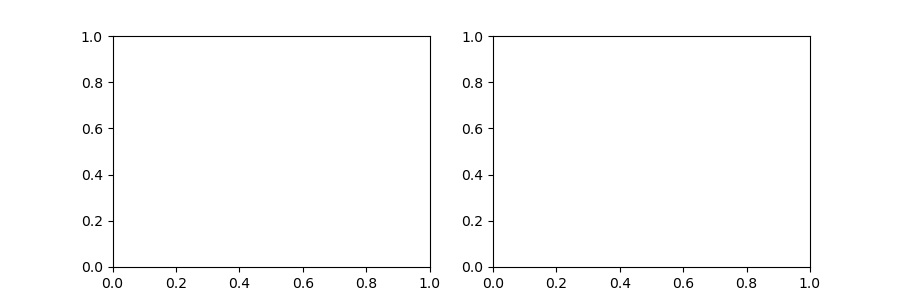

In [543]:
if "endeffector_fig" in locals():
    plt.close(endeffector_fig)
# endeffector_fig = plt.figure()
# endeffector_ax = endeffector_fig.gca()

SHOW_ANIMATION = False

plt.ion()
if not SHOW_ANIMATION:
    endeffector_fig, endeffector_ax = plt.subplots(1, 2, figsize=[9, 3])
else:
    endeffector_fig = plt.figure(figsize=[9, 9])
    endeffector_ax = []
    for i in range(1):
        endeffector_ax.append(endeffector_fig.add_subplot(1, 1, i + 1, projection='3d'))

In [ ]:
#endeffector_fig.tight_layout()

In [ ]:
trajectories_SIMULATION.get_statistics_info()

#[trajectories_SIMULATION.position_series[i] for i in trajectories_SIMULATION.indices]

trajectories_SIMULATION.init_val, trajectories_SIMULATION.position_series_trial[0]
#trajectories_STUDY.init_val, trajectories_STUDY.position_series_trial[0]

#trajectories_SIMULATION.indices
#trajectories_SIMULATION.selected_movements_indices

In [ ]:
### TrajectoryData_Sim2VR_STUDY

In [5683]:
for axis in endeffector_ax:
    axis.clear()
if "cbaxes" in locals():  #inset_axes
    try:
        cbaxes.remove()
    except ValueError:
        pass
endeffector_fig.subplots_adjust(left=0.1, right=0.95, bottom=0.2, top=0.9, wspace=0.26, hspace=0.2)

####

# WHICH PARTS OF DATASET? #only used if PLOTTING_ENV == "RL-UIB"
MOVEMENT_IDS = None #range(1, 9) #[i for i in range(10) if i != 1]
RADIUS_IDS = None
EPISODE_IDS = None #[7]

r1_FIXED = None #r1list[5]  #only used if PLOTTING_ENV == "MPC-costweights"
r2_FIXED = None #r2list[-1]  #only used if PLOTTING_ENV == "MPC-costweights"

#TASK_CONDITION_LIST_SELECTED = ["Standing_ID_ISO_15_plane", "Standing_Cursor_Handtuned_ISO_15_plane"]  #only used if PLOTTING_ENV == "MPC-taskconditions"

# WHAT TO COMPUTE?
EFFECTIVE_PROJECTION_PATH = PLOTTING_ENV in ("RL-UIB",)  #"RL-SIM2VR")  #if True, projection path connects effective initial and final position instead of nominal target center positions
USE_TARGETBOUND_AS_DIST = False  #True/False or "MinJerk-only"; if True, only plot trajectory until targetboundary is reached first (i.e., until dwell time begins); if "MinJerk-only", complete simulation trajectories are shown, but MinJerk trajectories are aligned to simulation trajectories without dwell time
MINJERK_USER_CONSTRAINTS = True

# WHICH/HOW MANY MOVS?  
"""
IMPORTANT INFO:
if isinstance(trajectories, TrajectoryData_RL):
    -> TRIAL_IDS/META_IDS/N_MOVS are (meta-)indices of respective episode (or rather, of respective row of trajectories.indices)
    -> TRIAL_IDS and META_IDS are equivalent
if isinstance(trajectories, TrajectoryData_STUDY) or isinstance(trajectories, TrajectoryData_MPC):
    -> TRIAL_IDS/META_IDS/N_MOVS are (global) indices of entire dataset
    -> TRIAL_IDS correspond to trial indices assigned during user study (last column of trajectories.indices), while META_IDS correspond to (meta-)indices of trajectories.indices itself (i.e., if some trials were removed during previous pre-processing steps, TRIAL_IDS and META_IDS differ!)
In general, only the first not-None parameter is used, in following order: TRIAL_IDS, META_IDS, N_MOVS.
"""
TARGET_IDS = [3] #range(1,4)  #corresponds to target IDs (if PLOTTING_ENV == "RL-UIB": only for iso-task)
TRIAL_IDS = None #[(0, 2)]  #range(13)  #[i for i in range(65) if i not in range(28, 33)] #range(1,4) #corresponds to trial IDs [last column of self.indices] or relative (meta) index per row in self.indices; either a list of indices, "different_target_sizes" (choose N_MOVS conditions with maximum differences in target size), or None (use META_IDS)
META_IDS = None  #index positions (i.e., sequential numbering of trials [aggregated trials, if AGGREGATE_TRIALS==True] in indices, without counting removed outliers); if None: use N_MOVS
N_MOVS = None  #number of movements to visualize (only used, if TRIAL_IDS and META_IDS are both None (or TRIAL_IDS == "different_target_sizes"))
AGGREGATION_VARS = []  #["all"]  #["episode", "movement"]  #["episode", "targetoccurrence"]  #["targetoccurrence"] #["episode", "movement"]  #["episode", "radius", "movement", "target", "targetoccurrence"]

# WHAT TO PLOT?
PLOT_TRACKING_DISTANCE = False  #if True, plot distance between End-effector and target position instead of position (only reasonable for tracking tasks)
PLOT_ENDEFFECTOR = True  #if True plot End-effector position and velocity, else plot qpos and qvel for joint with index JOINT_ID (see independent_joints below)
JOINT_ID = 2  #only used if PLOT_ENDEFFECTOR == False
PLOT_DEVIATION = False  #only if PLOT_ENDEFFECTOR == True

# HOW TO PLOT?
NORMALIZE_TIME = False
#DWELL_TIME = 0.3  #tail of the trajectories that is not shown (in seconds)
PLOT_TIME_SERIES = True  #if True plot Position/Velocity/Acceleration Time Series, else plot Phasespace and Hooke plots
PLOT_VEL_ACC = False  #if True, plot Velocity and Acceleration Time Series, else plot Position and Velocity Time Series (only used if PLOT_TIME_SERIES == True)
PLOT_RANGES = False
CONF_LEVEL = "min/max"  # might be between 0 and 1, or "min/max"; only used if PLOT_RANGES==True

# WHICH BASELINE?
SHOW_MINJERK = False
SHOW_STUDY = True
STUDY_ONLY = False  #only used if PLOTTING_ENV in ("MPC-taskconditions", "RL-SIM2VR")

# PLOT (WHICH) LEGENDS AND COLORBARS?
ENABLE_LEGENDS_AND_COLORBARS = True  #if False, legends (of axis 0) and colobars are removed
ALLOW_DUPLICATES_BETWEEN_LEGENDS = False  #if False, legend of axis 1 only contains values not included in legend of axis 0

# STORE PLOT?
STORE_PLOT = False
STORE_AXES_SEPARATELY = True  #if True, store left and right axis to separate figures

#SHOW_ANIMATION (defined above)
####    


if PLOT_RANGES:
    #assert REPEATED_MOVEMENTS, "ERROR: Check code dependencies..."
    assert PLOT_TIME_SERIES, "Plotting distributions (e.g., as CI or min/max-ranges) of Phasepace/Hooke profiles is not implemented yet."

if PLOT_DEVIATION:
    assert PLOT_TIME_SERIES, "Deviation should be plotted as Time Series, not as Phasespace/Hooke plots."
    assert PLOT_ENDEFFECTOR, "Deviation can only be plotted for end-effector projections, not for (scalar) joint angle/velocity values."

if PLOT_TRACKING_DISTANCE:
    assert PLOT_TIME_SERIES, "Remaining distance to target can only be plotted as Time Series, not in combination with Phasespace/Hooke plots."
    assert PLOT_ENDEFFECTOR, "Remaining distance to target can only be plotted for end-effector, not for (scalar) joint angle/velocity values."
    assert not PLOT_DEVIATION, "PLOT_DEVIATION, which shows projected deviation from direct path to a (stationary) target, cannot be used in combination with PLOT_TRACKING_DISTANCE, which shows remaining distance to (stationary or non-stationary) target."
    assert not PLOT_VEL_ACC, "PLOT_VEL_ACC should be False in order to plot remaining distance to target."

    assert STORE_AXES_SEPARATELY, "Remaining distance plotted on left axis should be stored using a separate filename."
    
if REPEATED_MOVEMENTS:
    assert TARGET_IDS is None, "Target IDs do not exist in 'repeated movements' datasets."
    #assert PLOT_TIME_SERIES, "Plotting distributions (e.g., as CI or min/max-ranges) of Phasepace/Hooke profiles is not implemented yet."
    assert not SHOW_STUDY, "Cannot plot data from user study together with simulation data for different radii."
    
#if SHOW_MINJERK:
#    assert not SHOW_STUDY, "Cannot currently plot both minjerk and user study trajectories as reference."
    
if SHOW_STUDY:
    assert isinstance(trajectories_SIMULATION, TrajectoryData_MPC) or "iso-" in filename
    
if STUDY_ONLY:
    assert SHOW_STUDY
    
if len(AGGREGATION_VARS) > 0:
    # This assert can be disabled.
    assert not NORMALIZE_TIME, f"NORMALIZE_TIME has no effect on the computation of distributions (mean, variability, etc.)!"
    
    assert not SHOW_MINJERK, "MinJerk Distributions are currently not available."

AGGREGATION_VARS_STUDY = [agg_var for agg_var in AGGREGATION_VARS if agg_var in ["targetoccurrence", "all"]] #+ ["all"]


# Specify plot filename
pprint_range_or_intlist = lambda x: (f"{x.start}-{x.stop-1}" if x.start < x.stop-1 else f"{x.start}" if x.start == x.stop-1 else "ERROR") if isinstance(x, range) else ((f"{min(x)}-{max(x)}" if min(x) != max(x) else f"{min(x)}") if set(range(min(x), max(x) + 1)) == set(x) else ",".join([str(i) for i in sorted(set(x))])) if isinstance(x, list) or (isinstance(x, np.ndarray) and x.ndim == 1) else f"0-{x-1}" if isinstance(x, int) else "ERROR"

_plot_EPISODE_ID = f"E{pprint_range_or_intlist(EPISODE_IDS)}_" if EPISODE_IDS is not None else ""
_plot_MOVEMENT_ID = f"M{pprint_range_or_intlist(MOVEMENT_IDS)}_" if MOVEMENT_IDS is not None else ""
_plot_RADIUS_ID = f"R{pprint_range_or_intlist(RADIUS_IDS)}_" if RADIUS_IDS is not None else ""

_plot_r1_FIXED = f"r_{float(r1_FIXED):.8e}_" if r1_FIXED is not None else ""  #only used if PLOTTING_ENV == "MPC-costweights"
_plot_r2_FIXED = f"r2_{float(r2_FIXED):.8e}_" if r2_FIXED is not None else ""  #only used if PLOTTING_ENV == "MPC-costweights"

_plot_JOINT_ID = "EE_" if PLOT_ENDEFFECTOR else f"{independent_joints[JOINT_ID]}_"
_plot_DEVIATION = "dev_" if PLOT_DEVIATION else ""
_plot_PHASESPACE = "PS_" if not PLOT_TIME_SERIES else ""
_plot_VEL_ACC = "velacc_" if PLOT_VEL_ACC and PLOT_TIME_SERIES else ""

_plot_TARGET_ID = f"T{pprint_range_or_intlist(TARGET_IDS)}_" if TARGET_IDS is not None else ""
_plot_METATRIAL_ID = f"Tr{pprint_range_or_intlist(TRIAL_IDS)}_" if TRIAL_IDS is not None else f"MT{pprint_range_or_intlist(META_IDS)}_" if META_IDS is not None else f"MN{pprint_range_or_intlist(N_MOVS)}_" if N_MOVS is not None else ""
_plot_AGGREGATE = f"AGG-{'-'.join(AGGREGATION_VARS)}_" if len(AGGREGATION_VARS) > 0 else ""
_plot_RANGE = f"{CONF_LEVEL.replace('/', '') if isinstance(CONF_LEVEL, str) else str(CONF_LEVEL) + 'CI'}_" if PLOT_RANGES else ""
_plot_EFFECTIVE_PROJECTION_PATH = "eP_" if EFFECTIVE_PROJECTION_PATH else ""
_plot_USE_TARGETBOUND_AS_DIST = "TB_" if USE_TARGETBOUND_AS_DIST == True else ""
if PLOTTING_ENV == "RL-UIB":
    plot_filename_ID = f"UIB/{filename}/{_plot_EPISODE_ID}{_plot_MOVEMENT_ID}{_plot_RADIUS_ID}{_plot_JOINT_ID}{_plot_DEVIATION}{_plot_PHASESPACE}{_plot_VEL_ACC}{_plot_TARGET_ID}{_plot_METATRIAL_ID}{_plot_AGGREGATE}{_plot_RANGE}{_plot_EFFECTIVE_PROJECTION_PATH}{_plot_USE_TARGETBOUND_AS_DIST}"
elif PLOTTING_ENV == "RL-SIM2VR":
    plot_filename_ID = f"SIM2VR/{filename}/{'STUDY_' if STUDY_ONLY else ''}{_plot_EPISODE_ID}{_plot_MOVEMENT_ID}{_plot_RADIUS_ID}{_plot_JOINT_ID}{_plot_DEVIATION}{_plot_PHASESPACE}{_plot_VEL_ACC}{_plot_TARGET_ID}{_plot_METATRIAL_ID}{_plot_AGGREGATE}{_plot_RANGE}{_plot_EFFECTIVE_PROJECTION_PATH}{_plot_USE_TARGETBOUND_AS_DIST}"
elif PLOTTING_ENV == "MPC-costs":
    plot_filename_ID = f"MPC/{common_simulation_subdir}/{USER_ID}/{TASK_CONDITION}/{_plot_JOINT_ID}{_plot_DEVIATION}{_plot_PHASESPACE}{_plot_VEL_ACC}{_plot_TARGET_ID}{_plot_METATRIAL_ID}{_plot_AGGREGATE}{_plot_RANGE}{_plot_EFFECTIVE_PROJECTION_PATH}{_plot_USE_TARGETBOUND_AS_DIST}"
elif PLOTTING_ENV == "MPC-costweights":
    plot_filename_ID = f"MPC/{common_simulation_subdir}/{USER_ID}/{TASK_CONDITION}/{_plot_r1_FIXED}{_plot_r2_FIXED}{_plot_JOINT_ID}{_plot_DEVIATION}{_plot_PHASESPACE}{_plot_VEL_ACC}{_plot_TARGET_ID}{_plot_METATRIAL_ID}{_plot_AGGREGATE}{_plot_RANGE}{_plot_EFFECTIVE_PROJECTION_PATH}{_plot_USE_TARGETBOUND_AS_DIST}"
elif PLOTTING_ENV == "MPC-horizons":
    plot_filename_ID = f"MPC/{common_simulation_subdir}/{USER_ID}/{TASK_CONDITION}/{_plot_JOINT_ID}{_plot_DEVIATION}{_plot_PHASESPACE}{_plot_VEL_ACC}{_plot_TARGET_ID}{_plot_METATRIAL_ID}{_plot_AGGREGATE}{_plot_RANGE}{_plot_EFFECTIVE_PROJECTION_PATH}{_plot_USE_TARGETBOUND_AS_DIST}"
elif PLOTTING_ENV == "MPC-taskconditions":
    plot_filename_ID = f"MPC/{SIMULATION_SUBDIR}/{USER_ID}/{common_taskcondition_subdir}/{'STUDY_' if STUDY_ONLY else ''}{_plot_JOINT_ID}{_plot_DEVIATION}{_plot_PHASESPACE}{_plot_VEL_ACC}{_plot_TARGET_ID}{_plot_METATRIAL_ID}{_plot_AGGREGATE}{_plot_RANGE}{_plot_EFFECTIVE_PROJECTION_PATH}{_plot_USE_TARGETBOUND_AS_DIST}"
elif PLOTTING_ENV == "MPC-userstudy" or PLOTTING_ENV == "MPC-userstudy-baselineonly" or PLOTTING_ENV == "MPC-simvsuser-colored":
    plot_filename_ID = f"MPC/{SIMULATION_SUBDIR}/{USER_ID_FIXED}_FIXED/{TASK_CONDITION}/{_plot_JOINT_ID}{_plot_DEVIATION}{_plot_PHASESPACE}{_plot_VEL_ACC}{_plot_TARGET_ID}{_plot_METATRIAL_ID}{_plot_AGGREGATE}{_plot_RANGE}{_plot_EFFECTIVE_PROJECTION_PATH}{_plot_USE_TARGETBOUND_AS_DIST}"
elif PLOTTING_ENV == "MPC-betweenuser":
    plot_filename_ID = f"MPC/{SIMULATION_SUBDIR}/{user_list_string}/{TASK_CONDITION}/{_plot_JOINT_ID}{_plot_DEVIATION}{_plot_PHASESPACE}{_plot_VEL_ACC}{_plot_TARGET_ID}{_plot_METATRIAL_ID}{_plot_AGGREGATE}{_plot_RANGE}{_plot_EFFECTIVE_PROJECTION_PATH}{_plot_USE_TARGETBOUND_AS_DIST}"
else:
    raise NotImplementedError
if plot_filename_ID[-1] in ["-", "_"]:
    plot_filename_ID = plot_filename_ID[:-1]

# Define trajectory sets to plot:
if PLOTTING_ENV == "RL-UIB":
    ## RL (Aleksi)
    if filename.endswith("max-freq-"):  #speed comparison (usually used for TrackingEnv)
        trajectories_info = []
        for i, trajectories in enumerate(trajectories_SPEEDS):
            trajectories.preprocess(MOVEMENT_IDS=MOVEMENT_IDS, RADIUS_IDS=RADIUS_IDS, EPISODE_IDS=EPISODE_IDS, split_trials="tracking" not in filename and "driving" not in filename)
            trajectories.compute_indices(TARGET_IDS=TARGET_IDS, TRIAL_IDS=TRIAL_IDS, META_IDS=META_IDS, N_MOVS=N_MOVS, AGGREGATION_VARS=AGGREGATION_VARS)
            trajectories.SHOW_MINJERK = False
            trajectories_info.append((trajectories, {'linestyle': '-', 'label': 'Simulation', 'color': matplotlib.cm.get_cmap('nipy_spectral')(i/len(trajectories_SPEEDS))}, {'alpha': 0.2}, ""))
    elif "driving" in filename:  #RemoteDrivingEnv
        trajectories_SIMULATION.preprocess(MOVEMENT_IDS=MOVEMENT_IDS, RADIUS_IDS=RADIUS_IDS, EPISODE_IDS=EPISODE_IDS, split_trials=False, endeffector_name="car")
        trajectories_SIMULATION.compute_indices(TARGET_IDS=TARGET_IDS, TRIAL_IDS=TRIAL_IDS, META_IDS=META_IDS, N_MOVS=N_MOVS, AGGREGATION_VARS=AGGREGATION_VARS)
        trajectories_SIMULATION.SHOW_MINJERK = False
        
        trajectories_SIMULATION_JOYSTICK.preprocess(MOVEMENT_IDS=MOVEMENT_IDS, RADIUS_IDS=RADIUS_IDS, EPISODE_IDS=EPISODE_IDS, split_trials=False, endeffector_name="fingertip", target_name="joystick")
        trajectories_SIMULATION_JOYSTICK.compute_indices(TARGET_IDS=TARGET_IDS, TRIAL_IDS=TRIAL_IDS, META_IDS=META_IDS, N_MOVS=N_MOVS, AGGREGATION_VARS=AGGREGATION_VARS)
        trajectories_SIMULATION_JOYSTICK.SHOW_MINJERK = False
        trajectories_info = [(trajectories_SIMULATION_JOYSTICK, {'linestyle': '-', 'label': 'Fingertip', 'color': matplotlib.cm.get_cmap('nipy_spectral')(0.4)}, {'alpha': 0.2}, ""),
                            (trajectories_SIMULATION, {'linestyle': '-', 'label': 'Car', 'color': matplotlib.cm.get_cmap('nipy_spectral')(0.9)}, {'alpha': 0.2}, ""),
                            ]  #contains tuples consisting of 1. a TrajectoryData instance, 2. a dict with plotting kwargs for regular (line) plots, 3. a dict with plotting kwargs for "fill_between" plots, and 4. a code string to execute at the beginning        
    else:
        trajectories_SIMULATION.preprocess(MOVEMENT_IDS=MOVEMENT_IDS, RADIUS_IDS=RADIUS_IDS, EPISODE_IDS=EPISODE_IDS, split_trials="tracking" not in filename and "driving" not in filename)
        trajectories_SIMULATION.compute_indices(TARGET_IDS=TARGET_IDS, TRIAL_IDS=TRIAL_IDS, META_IDS=META_IDS, N_MOVS=N_MOVS, AGGREGATION_VARS=AGGREGATION_VARS)
        trajectories_SIMULATION.SHOW_MINJERK = False
        trajectories_info = [(trajectories_SIMULATION, {'linestyle': '-', 'label': 'Simulation', 'target_cmap': 'nipy_spectral'}, {'alpha': 0.2}, "")]  #contains tuples consisting of 1. a TrajectoryData instance, 2. a dict with plotting kwargs for regular (line) plots, 3. a dict with plotting kwargs for "fill_between" plots, and 4. a code string to execute at the beginning
    if SHOW_STUDY:
        trajectories_STUDY.compute_indices(TARGET_IDS=TARGET_IDS, TRIAL_IDS=TRIAL_IDS, META_IDS=META_IDS, N_MOVS=N_MOVS, AGGREGATION_VARS=AGGREGATION_VARS_STUDY)
        trajectories_info.append((trajectories_STUDY, {'linestyle': '--', 'label': 'Human', 'target_cmap': 'nipy_spectral'}, {'alpha': 0.2}, ""))
        
        # OPTIONAL: show all users (between-user comparison)
        for trajectories in trajectories_STUDY_OTHERS:
            trajectories.compute_indices(TARGET_IDS=TARGET_IDS, TRIAL_IDS=TRIAL_IDS, META_IDS=META_IDS, N_MOVS=N_MOVS, AGGREGATION_VARS=AGGREGATION_VARS_STUDY)
#            trajectories_info.append((trajectories, {'linestyle': ':', 'label': 'Other Users', 'color': matplotlib.cm.get_cmap('turbo')(0.2), 'alpha': 0.6}, {'alpha': 0.2}, ""))
            trajectories_info.append((trajectories, {'linestyle': ':', 'label': 'Other Users', 'target_cmap': 'nipy_spectral', 'alpha': 0.4}, {'alpha': 0.2}, ""))
elif PLOTTING_ENV == "RL-SIM2VR":
    ## SIM2VR (Aleksi)
    if STUDY_ONLY:
        trajectories_info = []
    else:
        trajectories_SIMULATION.preprocess(MOVEMENT_IDS=MOVEMENT_IDS, RADIUS_IDS=RADIUS_IDS, EPISODE_IDS=EPISODE_IDS, split_trials="tracking" not in filename and "driving" not in filename)
        trajectories_SIMULATION.compute_indices(TARGET_IDS=TARGET_IDS, TRIAL_IDS=TRIAL_IDS, META_IDS=META_IDS, N_MOVS=N_MOVS, AGGREGATION_VARS=AGGREGATION_VARS)
        trajectories_SIMULATION.SHOW_MINJERK = False
        trajectories_info = [(trajectories_SIMULATION, {'linestyle': '-', 'label': 'Simulation', 'target_cmap': 'nipy_spectral'}, {'alpha': 0.2}, "")]  #contains tuples consisting of 1. a TrajectoryData instance, 2. a dict with plotting kwargs for regular (line) plots, 3. a dict with plotting kwargs for "fill_between" plots, and 4. a code string to execute at the beginning
    if SHOW_STUDY:
        trajectories_STUDY.compute_indices(TARGET_IDS=TARGET_IDS, TRIAL_IDS=TRIAL_IDS, META_IDS=META_IDS, N_MOVS=N_MOVS, AGGREGATION_VARS=AGGREGATION_VARS_STUDY)
        trajectories_info.append((trajectories_STUDY, {'linestyle': '--', 'label': 'Human', 'target_cmap': 'nipy_spectral'}, {'alpha': 0.2}, ""))

        # OPTIONAL: show all users (between-user comparison)
        for trajectories in trajectories_STUDY_OTHERS:
            trajectories.compute_indices(TARGET_IDS=TARGET_IDS, TRIAL_IDS=TRIAL_IDS, META_IDS=META_IDS, N_MOVS=N_MOVS, AGGREGATION_VARS=AGGREGATION_VARS_STUDY)
#            trajectories_info.append((trajectories, {'linestyle': ':', 'label': 'Other Users', 'color': matplotlib.cm.get_cmap('turbo')(0.2), 'alpha': 0.6}, {'alpha': 0.2}, ""))
            trajectories_info.append((trajectories, {'linestyle': ':', 'label': 'Other Users', 'target_cmap': 'nipy_spectral', 'alpha': 0.4}, {'alpha': 0.2}, ""))
elif PLOTTING_ENV == "MPC-costs":
    ## MPC (Markus) - Comparison of cost functions
    trajectories_SIMULATION.compute_indices(TARGET_IDS=TARGET_IDS, TRIAL_IDS=TRIAL_IDS, META_IDS=META_IDS, N_MOVS=N_MOVS, AGGREGATION_VARS=AGGREGATION_VARS, ignore_trainingset_trials=False)  #MPC
    trajectories_SIMULATION2.compute_indices(TARGET_IDS=TARGET_IDS, TRIAL_IDS=TRIAL_IDS, META_IDS=META_IDS, N_MOVS=N_MOVS, AGGREGATION_VARS=AGGREGATION_VARS, ignore_trainingset_trials=False)  #MPC
    trajectories_SIMULATION3.compute_indices(TARGET_IDS=TARGET_IDS, TRIAL_IDS=TRIAL_IDS, META_IDS=META_IDS, N_MOVS=N_MOVS, AGGREGATION_VARS=AGGREGATION_VARS, ignore_trainingset_trials=False)  #MPC
    map_conditions = lambda x: "JAC" if "accjoint" in x else "CTC" if "ctc" in x else "DC" if "cso" in x else x
    trajectories_info = [(trajectories_SIMULATION, {'linestyle': '-', 'label': map_conditions(trajectories_SIMULATION.SIMULATION_SUBDIR), 'color': matplotlib.cm.get_cmap('turbo')(255*1//4)}, {'alpha': 0.2, }, ""), (trajectories_SIMULATION2, {'linestyle': ':', 'label': map_conditions(trajectories_SIMULATION2.SIMULATION_SUBDIR), 'color': matplotlib.cm.get_cmap('turbo')(255*2//4)}, {'alpha': 0.2}, ""), (trajectories_SIMULATION3, {'linestyle': '-.', 'label': map_conditions(trajectories_SIMULATION3.SIMULATION_SUBDIR), 'color': matplotlib.cm.get_cmap('turbo')(255*3//4)}, {'alpha': 0.2}, "")]
    if SHOW_STUDY:
        trajectories_STUDY.compute_indices(TARGET_IDS=TARGET_IDS, TRIAL_IDS=TRIAL_IDS, META_IDS=META_IDS, N_MOVS=N_MOVS, AGGREGATION_VARS=AGGREGATION_VARS_STUDY, ignore_trainingset_trials=False)
        trajectories_info.append((trajectories_STUDY, {'linestyle': '--', 'label': 'Study', 'color': 'black'}, {'alpha': 0.2}, ""))
elif PLOTTING_ENV == "MPC-costweights":
    #MARKUS MPC - COMPARISON OF COST WEIGHTS OF A GIVEN COST FUNCTION
    assert SHOW_STUDY == False, "Did not prepare user study data for this case."
    trajectories_WEIGHTS_selected = trajectories_WEIGHTS.copy()
    if r1_FIXED is not None:
        trajectories_WEIGHTS_selected = [i for i in trajectories_WEIGHTS_selected if f"r_{float(r1_FIXED):.8e}" in i.SIMULATION_SUBDIR]
    if r2_FIXED is not None:
        trajectories_WEIGHTS_selected = [i for i in trajectories_WEIGHTS_selected if f"r2_{float(r2_FIXED):.8e}" in i.SIMULATION_SUBDIR]
    for trajectories in trajectories_WEIGHTS_selected:
        trajectories.compute_indices(TARGET_IDS=TARGET_IDS, TRIAL_IDS=TRIAL_IDS, META_IDS=META_IDS, N_MOVS=N_MOVS, AGGREGATION_VARS=AGGREGATION_VARS_STUDY, ignore_trainingset_trials=True)
    trajectories_info = [(trajectories, {'linestyle': '-', 'label': ", ".join(filter(None, [f"$r_1={r1_FIXED:.2g}$" if r1_FIXED is not None else "", f"$r_2={r2_FIXED:.2g}$" if r2_FIXED is not None else ""])), 'color': matplotlib.cm.get_cmap('turbo')(i/len(trajectories_WEIGHTS_selected)), 'alpha': 0.8}, {'alpha': 0.2}, """colorarray = r2list if r1_FIXED is not None else r1list; scalarmappaple = matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=colorarray.min(), vmax=colorarray.max()), cmap=matplotlib.cm.get_cmap('turbo'));scalarmappaple.set_array(colorarray);cbaxes = inset_axes(endeffector_ax[0], width="3%", height="40%", loc=6, bbox_to_anchor=(305 if r1_FIXED is None else 290, -20 if r1_FIXED is None else -20, 200, 300)); plt.colorbar(scalarmappaple, cax=cbaxes, orientation='vertical', format="%.2g"); cbaxes.set_ylabel(r"$r_{2}$" if r1_FIXED is not None else r"$r_{1}$", rotation=0);""" if i==0 and ((r1_FIXED is not None) or (r2_FIXED is not None)) else "") for i, trajectories in enumerate(trajectories_WEIGHTS_selected)]
elif PLOTTING_ENV == "MPC-horizons":
    #MARKUS MPC - COMPARISON OF DIFFERENT MPC HORIZONS N
    for trajectories in trajectories_HORIZONS:
        trajectories.compute_indices(TARGET_IDS=TARGET_IDS, TRIAL_IDS=TRIAL_IDS, META_IDS=META_IDS, N_MOVS=N_MOVS, AGGREGATION_VARS=AGGREGATION_VARS_STUDY, ignore_trainingset_trials=True)
    trajectories_info = [(trajectories, {'linestyle': '-', 'label': f"N={int(trajectories.SIMULATION_SUBDIR.split('_N')[-1].split('_')[0])}", 'color': matplotlib.cm.get_cmap('turbo')(i/len(trajectories_HORIZONS)), 'alpha': 0.8}, {'alpha': 0.2}, """colorarray = r2list if r1_FIXED is not None else r1list; scalarmappaple = matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=colorarray.min(), vmax=colorarray.max()), cmap=matplotlib.cm.get_cmap('turbo'));scalarmappaple.set_array(colorarray);cbaxes = inset_axes(endeffector_ax[0], width="3%", height="60%", loc=6, bbox_to_anchor=(460 if r1_FIXED is None else 430, 40 if r1_FIXED is None else 30, 200, 300)); plt.colorbar(scalarmappaple, cax=cbaxes, orientation='vertical', format="%.2g"); cbaxes.set_ylabel(r"$r_{2}$" if r1_FIXED is not None else r"$r_{1}$", rotation=0);""" if i==0 and (False) else "") for i, trajectories in enumerate(trajectories_HORIZONS)]
    if SHOW_STUDY:
        trajectories_STUDY.compute_indices(TARGET_IDS=TARGET_IDS, TRIAL_IDS=TRIAL_IDS, META_IDS=META_IDS, N_MOVS=N_MOVS, AGGREGATION_VARS=AGGREGATION_VARS_STUDY, ignore_trainingset_trials=True)
        trajectories_info.append((trajectories_STUDY, {'linestyle': '--', 'label': 'Study', 'color': 'black'}, {'alpha': 0.2}, ""))
elif PLOTTING_ENV == "MPC-taskconditions":
    #MARKUS MPC - COMPARISON OF DIFFERENT INTERACTION TECHNIQUES/TASK CONDITIONS
    if STUDY_ONLY:
        trajectories_info = []
    else:
        trajectories_CONDITIONS_selected = trajectories_CONDITIONS.copy()
        #trajectories_CONDITIONS_selected = [i for i in trajectories_CONDITIONS_selected if i.TASK_CONDITION in TASK_CONDITION_LIST_SELECTED]
        for trajectories in trajectories_CONDITIONS_selected:
            trajectories.compute_indices(TARGET_IDS=TARGET_IDS, TRIAL_IDS=TRIAL_IDS, META_IDS=META_IDS, N_MOVS=N_MOVS, AGGREGATION_VARS=AGGREGATION_VARS_STUDY, ignore_trainingset_trials=True)
        map_task_conditions = lambda x: " ".join(["Virtual Pad" if "_Pad_" in x else "Virtual Cursor", "ID" if "_ID_" in x else "Erg." if "_Handtuned_" in x else "???"])
        trajectories_info = [(trajectories, {'linestyle': '-', 'label': map_task_conditions(trajectories.TASK_CONDITION), 'color': matplotlib.cm.get_cmap('turbo')((i+1)/(len(trajectories_CONDITIONS_selected)+3)), 'alpha': 0.8}, {'alpha': 0.2}, "") for i, trajectories in enumerate(trajectories_CONDITIONS_selected)]
    if SHOW_STUDY:
        trajectories_USERS_selected = trajectories_USERS.copy()
        #trajectories_USERS_selected = [i for i in trajectories_USERS_selected if i.TASK_CONDITION in TASK_CONDITION_LIST_SELECTED]
        for i, trajectories in enumerate(trajectories_USERS_selected):
            trajectories.compute_indices(TARGET_IDS=TARGET_IDS, TRIAL_IDS=TRIAL_IDS, META_IDS=META_IDS, N_MOVS=N_MOVS, AGGREGATION_VARS=AGGREGATION_VARS_STUDY, ignore_trainingset_trials=True)
            trajectories_info.append((trajectories, {'linestyle': '-', 'label': f'{map_task_conditions(trajectories.TASK_CONDITION)}', 'color': matplotlib.cm.get_cmap('turbo')((i+1)/(len(trajectories_USERS_selected)+1))}, {'alpha': 0.2}, ""))
elif PLOTTING_ENV == "MPC-userstudy" or PLOTTING_ENV == "MPC-userstudy-baselineonly":
    ## MPC (Markus) - Simulation vs. User comparisons of single cost function
    trajectories_SIMULATION.compute_indices(TARGET_IDS=TARGET_IDS, TRIAL_IDS=TRIAL_IDS, META_IDS=META_IDS, N_MOVS=N_MOVS, AGGREGATION_VARS=AGGREGATION_VARS, ignore_trainingset_trials=True)  #MPC
    trajectories_info = [(trajectories_SIMULATION, {'linestyle': '-', 'label': 'Simulation', 'color': matplotlib.cm.get_cmap('turbo')(0.75)}, {'alpha': 0.2, }, "")]
    if SHOW_STUDY:
        trajectories_STUDY.compute_indices(TARGET_IDS=TARGET_IDS, TRIAL_IDS=TRIAL_IDS, META_IDS=META_IDS, N_MOVS=N_MOVS, AGGREGATION_VARS=AGGREGATION_VARS_STUDY, ignore_trainingset_trials=True)
        if TARGET_IDS is None:  #between-user comparison
            trajectories_info.append((trajectories_STUDY, {'linestyle': '--', 'label': f'Baseline ({USER_ID_FIXED})', 'color': 'black'}, {'alpha': 0.2}, ""))
        else:  #within-user comparison
            trajectories_info.append((trajectories_STUDY, {'linestyle': '--', 'label': f'Study', 'color': 'black'}, {'alpha': 0.2}, ""))
    if PLOTTING_ENV == "MPC-userstudy":
        for trajectories in [i for i in trajectories_USERS if i.USER_ID != USER_ID_FIXED]:
            trajectories.compute_indices(TARGET_IDS=TARGET_IDS, TRIAL_IDS=TRIAL_IDS, META_IDS=META_IDS, N_MOVS=N_MOVS, AGGREGATION_VARS=AGGREGATION_VARS_STUDY, ignore_trainingset_trials=True)  #STUDY

        if TARGET_IDS is None:  #between-user comparison
            trajectories_info.extend([(trajectories, {'linestyle': ':', 'label': 'Other Users', 'color': matplotlib.cm.get_cmap('turbo')(0.2), 'alpha': 0.8}, {'alpha': 0.2}, "") for i, trajectories in enumerate(trajectories_USERS) if trajectories.USER_ID != USER_ID_FIXED])
elif PLOTTING_ENV == "MPC-simvsuser-colored":
    ## MPC (Markus) - Simulation vs. User comparisons of single cost function
    trajectories_SIMULATION.compute_indices(TARGET_IDS=TARGET_IDS, TRIAL_IDS=TRIAL_IDS, META_IDS=META_IDS, N_MOVS=N_MOVS, AGGREGATION_VARS=AGGREGATION_VARS, ignore_trainingset_trials=True)  #MPC
    trajectories_info = [(trajectories_SIMULATION, {'linestyle': '-', 'label': 'Simulation', 'target_cmap': 'nipy_spectral'}, {'alpha': 0.2, }, "")]
    if SHOW_STUDY:
        trajectories_STUDY.compute_indices(TARGET_IDS=TARGET_IDS, TRIAL_IDS=TRIAL_IDS, META_IDS=META_IDS, N_MOVS=N_MOVS, AGGREGATION_VARS=AGGREGATION_VARS_STUDY, ignore_trainingset_trials=True)
        trajectories_info.append((trajectories_STUDY, {'linestyle': '--', 'label': f'Study', 'target_cmap': 'nipy_spectral'}, {'alpha': 0.2}, ""))
elif PLOTTING_ENV == "MPC-betweenuser":
    ## MPC (Markus) - Between-user comparisons: A simulation class incorporating different users vs. a study class incorporating different users
    trajectories_SIMULATION.compute_indices(TARGET_IDS=TARGET_IDS, TRIAL_IDS=TRIAL_IDS, META_IDS=META_IDS, N_MOVS=N_MOVS, AGGREGATION_VARS=AGGREGATION_VARS, ignore_trainingset_trials=True)  #MPC
    trajectories_info = [(trajectories_SIMULATION, {'linestyle': '-', 'label': 'Simulation', 'color': matplotlib.cm.get_cmap('turbo')(0.75)}, {'alpha': 0.2, }, "")]
    if SHOW_STUDY:
        trajectories_STUDY.compute_indices(TARGET_IDS=TARGET_IDS, TRIAL_IDS=TRIAL_IDS, META_IDS=META_IDS, N_MOVS=N_MOVS, AGGREGATION_VARS=AGGREGATION_VARS_STUDY, ignore_trainingset_trials=True)
        trajectories_info.append((trajectories_STUDY, {'linestyle': '--', 'label': f'Study', 'color': matplotlib.cm.get_cmap('turbo')(0.2)}, {'alpha': 0.2}, ""))
else:
    raise NotImplementedError

if SHOW_MINJERK:
    if SHOW_STUDY:  #use user data as reference trajectory for initial and final values of MinJerk
        trajectories_STUDY.compute_minjerk(MINJERK_USER_CONSTRAINTS=MINJERK_USER_CONSTRAINTS, targetbound_as_target=(USE_TARGETBOUND_AS_DIST == True or USE_TARGETBOUND_AS_DIST == "MinJerk-only"))
        trajectories_info.append((trajectories_STUDY, {'linestyle': ':', 'label': 'MinJerk', 'color': 'black'}, {'alpha': 0.2}, "trajectories.SHOW_MINJERK = True"))
    else:
        trajectories_SIMULATION.compute_minjerk(MINJERK_USER_CONSTRAINTS=MINJERK_USER_CONSTRAINTS, targetbound_as_target=(USE_TARGETBOUND_AS_DIST == True or USE_TARGETBOUND_AS_DIST == "MinJerk-only"))
        trajectories_info.append((trajectories_SIMULATION, {**{'linestyle': ':', 'label': 'MinJerk'}, **({'target_cmap': 'nipy_spectral'} if PLOTTING_ENV == "RL-UIB" else {})}, {'alpha': 0.2}, "trajectories.SHOW_MINJERK = True"))

## ANALYSIS OF POINTING TASKS -> Use trajectories projections onto direct path between initial and (fixed) target position
if not SHOW_ANIMATION:
    if PLOT_DEVIATION:
        
        endeffector_ax[0].set_title("Position Deviation from Direct Path")
        endeffector_ax[0].set_xlabel("Time " + ('[normalized]' if NORMALIZE_TIME else r'$\left(s\right)$'))
        endeffector_ax[0].set_ylabel("Position Deviation $\left(m\right)$")

        endeffector_ax[1].set_title("Velocity Deviation from Direct Path")
        endeffector_ax[1].set_xlabel("Time " + (' [normalized]' if NORMALIZE_TIME else r'$\left(s\right)$'))
        endeffector_ax[1].set_ylabel("Velocity Deviation $\left(\frac{m}{s}\right)$")
    else:
        if PLOT_ENDEFFECTOR:
            if PLOT_TIME_SERIES:
                if PLOT_VEL_ACC:
                    endeffector_ax[0].set_title("Projected Velocity Time Series")
                    endeffector_ax[0].set_xlabel("Time " + ('[normalized]' if NORMALIZE_TIME else r'$\left(s\right)$'))
                    endeffector_ax[0].set_ylabel(r"Velocity  $\left(\frac{m}{s}\right)$")
                    #endeffector_ax[0].set_ylabel(r"Velocity  $\left(\frac{1}{s}\right)$ [normalized]")

                    endeffector_ax[1].set_title("Projected Acceleration Time Series")
                    endeffector_ax[1].set_xlabel("Time " + ('[normalized]' if NORMALIZE_TIME else r'$\left(s\right)$'))
                    endeffector_ax[1].set_ylabel(r"Acceleration $\left(\frac{m}{s^2}\right)$")
                    #endeffector_ax[1].set_ylabel(r"Acceleration $\left(\frac{1}{s^2}\right)$ [normalized]")
                else:
                    if PLOT_TRACKING_DISTANCE:
                        endeffector_ax[0].set_title(f"Distance to {'Joystick/' if PLOTTING_ENV == 'RL-UIB' and 'driving' in filename else ''}Target")
                        endeffector_ax[0].set_xlabel("Time " + ('[normalized]' if NORMALIZE_TIME else r'$\left(s\right)$'))
                        endeffector_ax[0].set_ylabel(r"Distance $\left(m\right)$")
                    else:
                        endeffector_ax[0].set_title("Projected Position Time Series")
                        endeffector_ax[0].set_xlabel("Time " + ('[normalized]' if NORMALIZE_TIME else r'$\left(s\right)$'))
                        endeffector_ax[0].set_ylabel("Position [normalized]")

                    endeffector_ax[1].set_title("Projected Velocity Time Series")
                    endeffector_ax[1].set_xlabel("Time " + ('[normalized]' if NORMALIZE_TIME else r'$\left(s\right)$'))
                    endeffector_ax[1].set_ylabel(r"Velocity $\left(\frac{m}{s}\right)$")
                    #endeffector_ax[1].set_ylabel(r"Velocity $\left(\frac{1}{s}\right)$ [normalized]")
            else:
                endeffector_ax[0].set_title("Projected Phasespace Plot")
                endeffector_ax[0].set_xlabel("Position [normalized]")
                endeffector_ax[0].set_ylabel(r"Velocity $\left(\frac{m}{s}\right)$")
                #endeffector_ax[0].set_ylabel(r"Velocity $\left(\frac{1}{s}\right)$ [normalized]")

                endeffector_ax[1].set_title("Projected Hooke Plot")
                endeffector_ax[1].set_xlabel("Position [normalized]")
                endeffector_ax[1].set_ylabel(r"Acceleration $\left(\frac{m}{s^2}\right)$")
                #endeffector_ax[1].set_ylabel(r"Acceleration $\left(\frac{1}{s^2}\right)$ [normalized]")
        else:
            if PLOT_TIME_SERIES:
                if PLOT_VEL_ACC:
                    endeffector_ax[0].set_title(f"Joint Velocity – {independent_joints[JOINT_ID]}")
                    endeffector_ax[0].set_xlabel("Time " + ('[normalized]' if NORMALIZE_TIME else r'$\left(s\right)$'))
                    endeffector_ax[0].set_ylabel(r"Joint Velocity $\left(\frac{rad}{s}\right)$")

                    endeffector_ax[1].set_title(f"Joint Velocity – {independent_joints[JOINT_ID]}")
                    endeffector_ax[1].set_xlabel("Time " + (' [normalized]' if NORMALIZE_TIME else r'$\left(s\right)$'))
                    endeffector_ax[1].set_ylabel(r"Joint Acceleration $\left(\frac{rad}{s^2}\right)$")
                else:
                    endeffector_ax[0].set_title(f"Joint Angle – {independent_joints[JOINT_ID]}")
                    endeffector_ax[0].set_xlabel("Time " + ('[normalized]' if NORMALIZE_TIME else r'$\left(s\right)$'))
                    endeffector_ax[0].set_ylabel(r"Joint Angle $\left(rad\right)$")

                    endeffector_ax[1].set_title(f"Joint Velocity – {independent_joints[JOINT_ID]}")
                    endeffector_ax[1].set_xlabel("Time " + (' [normalized]' if NORMALIZE_TIME else r'$\left(s\right)$'))
                    endeffector_ax[1].set_ylabel(r"Joint Velocity $\left(\frac{rad}{s}\right)$")
            else:
                endeffector_ax[0].set_title(f"{independent_joints[JOINT_ID]} – Phasespace Plot")
                endeffector_ax[0].set_xlabel(r"Joint Angle $\left(rad\right)$")
                endeffector_ax[0].set_ylabel(r"Joint Velocity $\left(\frac{rad}{s}\right)$")

                endeffector_ax[1].set_title(f"{independent_joints[JOINT_ID]} – Hooke Plot")
                endeffector_ax[1].set_xlabel(r"Joint Angle $\left(rad\right)$")
                endeffector_ax[1].set_ylabel(r"Joint Acceleration $\left(\frac{rad}{s^2}\right)$")
            
        if PLOTTING_ENV == "MPC-userstudy-baselineonly":
            map_task_conditions = lambda x: " ".join(["Virtual Pad" if "_Pad_" in x else "Virtual Cursor", "ID" if "_ID_" in x else "Erg." if "_Handtuned_" in x else "???"])
            endeffector_ax[0].set_title(map_task_conditions(TASK_CONDITION))
            endeffector_ax[1].set_title(map_task_conditions(TASK_CONDITION))
                
    if (PLOTTING_ENV == "RL-UIB") and (filename.endswith("max-freq-") or "driving" in filename):
        endeffector_ax[0].set_yscale("log")

## ANALYSIS OF TRACKING TASKS -> Use 3D plots of trajectories
else:
    blue_line = Line2D([0], [0], color='tab:blue', linestyle='-', label='End-Effector')
    red_line = Line2D([0], [0], color='red', linestyle='-', label='Target')
    endeffector_ax[0].legend(handles=[blue_line, red_line])
    
    endeffector_ax[0].set_title("Position Trajectory")
    endeffector_ax[0].set_xlabel("x")
    endeffector_ax[0].set_ylabel("y")
    endeffector_ax[0].set_zlabel("z")
    ax_lims = np.vstack((np.min((np.squeeze(position_series).min(axis=0), np.squeeze(target_position_series).min(axis=0)), axis=0), np.max((np.squeeze(position_series).max(axis=0), np.squeeze(target_position_series).max(axis=0)), axis=0))).T
    # endeffector_ax[0].set_xlim(*ax_lims[0, :])
    # endeffector_ax[0].set_ylim(*ax_lims[1, :])
    # endeffector_ax[0].set_zlim(*ax_lims[2, :])
    ax_lims_centers, ax_lims_ranges = ax_lims.mean(axis=1), ax_lims@[-1, 1]
    endeffector_ax[0].set_xlim(ax_lims_centers[0] - 0.5*np.max(ax_lims_ranges), ax_lims_centers[0] + 0.5*np.max(ax_lims_ranges))
    endeffector_ax[0].set_ylim(ax_lims_centers[1] - 0.5*np.max(ax_lims_ranges), ax_lims_centers[1] + 0.5*np.max(ax_lims_ranges))
    endeffector_ax[0].set_zlim(ax_lims_centers[2] - 0.5*np.max(ax_lims_ranges), ax_lims_centers[2] + 0.5*np.max(ax_lims_ranges))

if not SHOW_ANIMATION:
    methods_handles = []
    
    for trajectories, trajectory_plotting_kwargs, range_plotting_kwargs, code_to_exec in trajectories_info:
        exec(code_to_exec)  #necessary to get MinJerk trajectories from RL-Simulation class
        
        #methods_handles.append(Line2D([0], [0], color="black", **{k: v for k,v in trajectory_plotting_kwargs.items() if k != "color"}))
        methods_handles.append(Line2D([0], [0], **dict({"color": "black"}, **{k: v for k,v in trajectory_plotting_kwargs.items() if k not in ["target_cmap"]})))
 
        endeffector_ax[0].set_prop_cycle(None)
        endeffector_ax[1].set_prop_cycle(None)
                
        for episode_index_current, (last_idx_hlp, current_idx_hlp, next_idx_hlp) in enumerate(trajectories.selected_movements_indices):
            if isinstance(last_idx_hlp, list) and len(last_idx_hlp) > 1:  #if len(AGGREGATION_VARS) > 0
                
                trajectories.compute_statistics(episode_index_current, effective_projection_path=EFFECTIVE_PROJECTION_PATH, targetbound_as_target=trajectories.SHOW_MINJERK if USE_TARGETBOUND_AS_DIST == "MinJerk-only" else USE_TARGETBOUND_AS_DIST, compute_deviation=PLOT_DEVIATION, normalize_time=NORMALIZE_TIME, use_joint_data_only="all" in AGGREGATION_VARS or isinstance(trajectories, TrajectoryData_MultipleInstances))
                
                # if ("radius" not in AGGREGATION_VARS and REPEATED_MOVEMENTS):
                #     print(2*trajectories.target_radius_mean[0], trajectories.time_series_extended[-1], np.max(trajectories.projected_trajectories_vel_mean))
                
                if PLOT_TIME_SERIES:
                    ### POSITION (or VELOCITY) PLOT
                    latest_plot, = endeffector_ax[0].plot(trajectories.time_series_extended, trajectories.distance_to_target_mean if PLOT_TRACKING_DISTANCE else (trajectories.projected_trajectories_vel_mean if PLOT_VEL_ACC else trajectories.projected_trajectories_pos_mean) if PLOT_ENDEFFECTOR else (trajectories.qvel_series_mean[:, JOINT_ID] if PLOT_VEL_ACC else trajectories.qpos_series_mean[:, JOINT_ID]), label=f'W={2*trajectories.target_radius_mean[0]:.2g}' if ("radius" not in AGGREGATION_VARS and REPEATED_MOVEMENTS) else f'T{trajectories.target_idx_mean[0]}' if not np.isnan(trajectories.target_idx_mean).all() else f"{trajectories.max_frequency}Hz" if hasattr(trajectories, "max_frequency") else None, **{**{'color': matplotlib.colormaps[trajectory_plotting_kwargs["target_cmap"]](((-0.04 + 4*trajectories.target_idx_mean[0]/13)%1) + False*((trajectories.target_idx_mean[0]+1)/(2*13) + (0.5 if trajectories.target_idx_mean[0]%2 else 0))) if ("target_cmap" in trajectory_plotting_kwargs) and (not ("radius" not in AGGREGATION_VARS and REPEATED_MOVEMENTS)) and (not np.isnan(trajectories.target_idx_mean).all()) else None}, **{k: v for k,v in trajectory_plotting_kwargs.items() if k not in ["label", "target_cmap"]}})
                    
                    # if isinstance(trajectories, TrajectoryData_MultipleInstances) and isinstance(trajectories.trajectories[0], TrajectoryData_STUDY):
                    #     PLOT_RANGES = True
                    # #print(2*trajectories.target_radius_mean[0], trajectories.time_series_extended[-1], trajectories.projected_trajectories_vel_mean.max())
                    
                    if PLOT_RANGES:
                        if CONF_LEVEL == "min/max":
                            # add min/max bounds
                            endeffector_ax[0].fill_between(trajectories.time_series_extended, trajectories.distance_to_target_min if PLOT_TRACKING_DISTANCE else (trajectories.projected_trajectories_vel_min if PLOT_VEL_ACC else trajectories.projected_trajectories_pos_min) if PLOT_ENDEFFECTOR else (trajectories.qvel_series_min[:, JOINT_ID] if PLOT_VEL_ACC else trajectories.qpos_series_min[:, JOINT_ID]), trajectories.distance_to_target_max if PLOT_TRACKING_DISTANCE else (trajectories.projected_trajectories_vel_max if PLOT_VEL_ACC else trajectories.projected_trajectories_pos_max) if PLOT_ENDEFFECTOR else (trajectories.qvel_series_max[:, JOINT_ID] if PLOT_VEL_ACC else trajectories.qpos_series_max[:, JOINT_ID]), color=latest_plot.get_color(), **{k: v for k,v in range_plotting_kwargs.items() if k != "color"})
                        else:
                            # add confidence interval bounds
                            if PLOT_DEVIATION:
                                raise NotImplementedError("ERROR: Not sure if it makes sense to plot difference between projected standard deviation and direct path...")
                            if PLOT_VEL_ACC:
                                projected_or_joint_trajectories_pos_or_vel_std =  np.sqrt(trajectories.projected_trajectories_vel_cov if PLOT_ENDEFFECTOR else trajectories.qvel_series_cov[:, JOINT_ID])
                            else:
                                projected_or_joint_trajectories_pos_or_vel_std =  np.sqrt(trajectories.distance_to_target_cov if PLOT_TRACKING_DISTANCE else trajectories.projected_trajectories_pos_cov if PLOT_ENDEFFECTOR else trajectories.qpos_series_cov[:, JOINT_ID])
                            endeffector_ax[0].fill_between(trajectories.time_series_extended, ((trajectories.distance_to_target_mean if PLOT_TRACKING_DISTANCE else trajectories.projected_trajectories_vel_mean if PLOT_VEL_ACC else trajectories.projected_trajectories_pos_mean) if PLOT_ENDEFFECTOR else (trajectories.qvel_series_mean[:, JOINT_ID] if PLOT_VEL_ACC else trajectories.qpos_series_mean[:, JOINT_ID])) - stats.norm.ppf((CONF_LEVEL + 1)/2) * projected_or_joint_trajectories_pos_or_vel_std, ((trajectories.distance_to_target_mean if PLOT_TRACKING_DISTANCE else trajectories.projected_trajectories_vel_mean if PLOT_VEL_ACC else trajectories.projected_trajectories_pos_mean) if PLOT_ENDEFFECTOR else (trajectories.qvel_series_mean[:, JOINT_ID] if PLOT_VEL_ACC else trajectories.qpos_series_mean[:, JOINT_ID])) + stats.norm.ppf((CONF_LEVEL + 1)/2) * projected_or_joint_trajectories_pos_or_vel_std, color=latest_plot.get_color(), **{k: v for k,v in range_plotting_kwargs.items() if k != "color"})

                        # display lower bound of target area (i.e., target center - target radius) in projected position plot or distance plot
                        if (not PLOT_DEVIATION) and PLOT_ENDEFFECTOR:
                            if PLOT_TRACKING_DISTANCE:
                                assert len(np.unique(trajectories.target_radius_mean)) == 1
                                if len(trajectories.selected_movements_indices) == 1 and len(trajectories_info) == 1:  #only one trajectory is plotted
                                    print("A")
                                    endeffector_ax[0].axhline(trajectories.target_radius_mean[0], linestyle='--', color="black", alpha=1, label="Target Boundary")
                                elif len(np.unique([i.target_radius_series for i, _, _, _ in trajectories_info])) == 1:  #all trajectories have same target radius
                                    endeffector_ax[0].axhline(trajectories.target_radius_mean[0], linestyle='--', color="grey", alpha=1) #, label="Target Boundary")
                                else:
                                    endeffector_ax[0].axhline(trajectories.target_radius_mean[0], linestyle='--', color=latest_plot.get_color(), alpha=1)                             
                            else:
                                #TODO: modify init_val, final_val!
                                target_radius_normalized = trajectories.target_radius_mean[0]/np.linalg.norm(trajectories.final_val-trajectories.init_val)   #relative (i.e., normalized) target radius
                                target_area_boundary_projected = 1 - target_radius_normalized
                                endeffector_ax[0].axhline(target_area_boundary_projected, linestyle='--', color=latest_plot.get_color(), alpha=.2)

                    ### VELOCITY (or ACCELERATION) PLOT
                    latest_plot, = endeffector_ax[1].plot(trajectories.time_series_extended, (trajectories.projected_trajectories_acc_mean if PLOT_VEL_ACC else trajectories.projected_trajectories_vel_mean) if PLOT_ENDEFFECTOR else (trajectories.qacc_series_mean[:, JOINT_ID] if PLOT_VEL_ACC else trajectories.qvel_series_mean[:, JOINT_ID]), label=f'W={2*trajectories.target_radius_mean[0]:.2g}' if ("radius" not in AGGREGATION_VARS and REPEATED_MOVEMENTS) else f'T{trajectories.target_idx_mean[0]}' if not np.isnan(trajectories.target_idx_mean).all() else None, **{**{'color': matplotlib.colormaps[trajectory_plotting_kwargs["target_cmap"]](((-0.04 + 4*trajectories.target_idx_mean[0]/13)%1) + False*((trajectories.target_idx_mean[0]+1)/(2*13) + (0.5 if trajectories.target_idx_mean[0]%2 else 0))) if ("target_cmap" in trajectory_plotting_kwargs) and (not ("radius" not in AGGREGATION_VARS and REPEATED_MOVEMENTS)) and (not np.isnan(trajectories.target_idx_mean).all()) else None}, **{k: v for k,v in trajectory_plotting_kwargs.items() if k not in ["label", "target_cmap"]}})
                    
                    if PLOT_RANGES:
                        if CONF_LEVEL == "min/max":
                            # add min/max bounds
                            endeffector_ax[1].fill_between(trajectories.time_series_extended, (trajectories.projected_trajectories_acc_min if PLOT_VEL_ACC else trajectories.projected_trajectories_vel_min) if PLOT_ENDEFFECTOR else (trajectories.qacc_series_min[:, JOINT_ID] if PLOT_VEL_ACC else trajectories.qvel_series_min[:, JOINT_ID]), (trajectories.projected_trajectories_acc_max if PLOT_VEL_ACC else trajectories.projected_trajectories_vel_max) if PLOT_ENDEFFECTOR else (trajectories.qacc_series_max[:, JOINT_ID] if PLOT_VEL_ACC else trajectories.qvel_series_max[:, JOINT_ID]), color=latest_plot.get_color(), **{k: v for k,v in range_plotting_kwargs.items() if k != "color"})
                        else:
                            # add confidence interval bounds
                            if PLOT_VEL_ACC:
                                projected_or_joint_trajectories_vel_or_acc_std =  np.sqrt(trajectories.projected_trajectories_acc_cov if PLOT_ENDEFFECTOR else trajectories.qacc_series_cov[:, JOINT_ID])
                            else:
                                projected_or_joint_trajectories_vel_or_acc_std =  np.sqrt(trajectories.projected_trajectories_vel_cov if PLOT_ENDEFFECTOR else trajectories.qvel_series_cov[:, JOINT_ID])
                            endeffector_ax[1].fill_between(trajectories.time_series_extended, ((trajectories.projected_trajectories_acc_mean if PLOT_VEL_ACC else trajectories.projected_trajectories_vel_mean) if PLOT_ENDEFFECTOR else (trajectories.qacc_series_mean[:, JOINT_ID] if PLOT_VEL_ACC else trajectories.qvel_series_mean[:, JOINT_ID])) - stats.norm.ppf((CONF_LEVEL + 1)/2) * projected_or_joint_trajectories_vel_or_acc_std, ((trajectories.projected_trajectories_acc_mean if PLOT_VEL_ACC else trajectories.projected_trajectories_vel_mean) if PLOT_ENDEFFECTOR else (trajectories.qacc_series_mean[:, JOINT_ID] if PLOT_VEL_ACC else trajectories.qvel_series_mean[:, JOINT_ID])) + stats.norm.ppf((CONF_LEVEL + 1)/2) * projected_or_joint_trajectories_vel_or_acc_std, color=latest_plot.get_color(), **{k: v for k,v in range_plotting_kwargs.items() if k != "color"})
                else:
                    ### PHASESPACE PLOT
                    latest_plot, = endeffector_ax[0].plot(trajectories.projected_trajectories_pos_mean if PLOT_ENDEFFECTOR else trajectories.qpos_series_mean[:, JOINT_ID], trajectories.projected_trajectories_vel_mean if PLOT_ENDEFFECTOR else trajectories.qvel_series_mean[:, JOINT_ID], label=f'W={2*trajectories.target_radius_mean[0]:.2g}' if ("radius" not in AGGREGATION_VARS and REPEATED_MOVEMENTS) else f'T{trajectories.target_idx_mean[0]}' if not np.isnan(trajectories.target_idx_mean).all() else None, **{**{'color': matplotlib.colormaps[trajectory_plotting_kwargs["target_cmap"]](((-0.04 + 4*trajectories.target_idx_mean[0]/13)%1) + False*((trajectories.target_idx_mean[0]+1)/(2*13) + (0.5 if trajectories.target_idx_mean[0]%2 else 0))) if ("target_cmap" in trajectory_plotting_kwargs) and (not ("radius" not in AGGREGATION_VARS and REPEATED_MOVEMENTS)) and (not np.isnan(trajectories.target_idx_mean).all()) else None}, **{k: v for k,v in trajectory_plotting_kwargs.items() if k not in ["label", "target_cmap"]}})

                    if PLOT_RANGES:
                        raise NotImplementedError("""Can show distribution of aggregated trials only if PLOT_TIME_SERIES == True.""")

                    ### HOOKE PLOT
                    latest_plot, = endeffector_ax[1].plot(trajectories.projected_trajectories_pos_mean if PLOT_ENDEFFECTOR else trajectories.qpos_series_mean[:, JOINT_ID], trajectories.projected_trajectories_acc_mean if PLOT_ENDEFFECTOR else trajectories.qacc_series_mean[:, JOINT_ID], label=f'W={2*trajectories.target_radius_mean[0]:.2g}' if ("radius" not in AGGREGATION_VARS and REPEATED_MOVEMENTS) else f'T{trajectories.target_idx_mean[0]}' if not np.isnan(trajectories.target_idx_mean).all() else None, **{**{'color': matplotlib.colormaps[trajectory_plotting_kwargs["target_cmap"]](((-0.04 + 4*trajectories.target_idx_mean[0]/13)%1) + False*((trajectories.target_idx_mean[0]+1)/(2*13) + (0.5 if trajectories.target_idx_mean[0]%2 else 0))) if ("target_cmap" in trajectory_plotting_kwargs) and (not ("radius" not in AGGREGATION_VARS and REPEATED_MOVEMENTS)) and (not np.isnan(trajectories.target_idx_mean).all()) else None}, **{k: v for k,v in trajectory_plotting_kwargs.items() if k not in ["label", "target_cmap"]}})

                    if PLOT_RANGES:
                        raise NotImplementedError("""Can show distribution of aggregated trials only if PLOT_TIME_SERIES == True.""")

            else:
                assert not PLOT_RANGES, "ERROR: Cannot plot ranges, as no trials were aggregated!"
                
                trajectories.compute_trial(episode_index_current, effective_projection_path=EFFECTIVE_PROJECTION_PATH, targetbound_as_target=trajectories.SHOW_MINJERK if USE_TARGETBOUND_AS_DIST == "MinJerk-only" else USE_TARGETBOUND_AS_DIST, compute_deviation=PLOT_DEVIATION, normalize_time=NORMALIZE_TIME)
                
                if not PLOT_ENDEFFECTOR:
                    assert trajectories.qpos_available and trajectories.qvel_available and trajectories.qacc_available, f"Joint values are not available for trajectories of type '{type(trajectories_STUDY).__name__}'. Set PLOT_ENDEFFECTOR=True."
                
                projected_or_joint_trajectory_pos = trajectories.projected_trajectories_pos_trial if PLOT_ENDEFFECTOR else trajectories.qpos_series_trial[:, JOINT_ID]
                projected_or_joint_trajectory_vel = trajectories.projected_trajectories_vel_trial if PLOT_ENDEFFECTOR else trajectories.qvel_series_trial[:, JOINT_ID]
                projected_or_joint_trajectory_acc = trajectories.projected_trajectories_acc_trial if PLOT_ENDEFFECTOR else trajectories.qacc_series_trial[:, JOINT_ID]

                ## for interchangeability between projection and covariance, see https://math.stackexchange.com/a/2576783
                if PLOT_TIME_SERIES:
                    ### POSITION (or VELOCITY) PLOT
                    latest_plot, = endeffector_ax[0].plot(trajectories.time_series_trial, trajectories.distance_to_target_trial if PLOT_TRACKING_DISTANCE else (projected_or_joint_trajectory_vel if PLOT_VEL_ACC else projected_or_joint_trajectory_pos), label=f'W={2*trajectories.target_radius_series_trial[0]:.2g}' if ("radius" not in AGGREGATION_VARS and REPEATED_MOVEMENTS) else f'T{trajectories.target_idx_series_trial[0]}' if not np.isnan(trajectories.target_idx_series).all() else None, **{**{'color': matplotlib.colormaps[trajectory_plotting_kwargs["target_cmap"]](((-0.04 + 4*trajectories.target_idx_series_trial[0]/13)%1) + False*((trajectories.target_idx_series_trial[0]+1)/(2*13) + (0.5 if trajectories.target_idx_series_trial[0]%2 else 0))) if ("target_cmap" in trajectory_plotting_kwargs) and (not ("radius" not in AGGREGATION_VARS and REPEATED_MOVEMENTS)) and (not np.isnan(trajectories.target_idx_series).all()) else None}, **{k: v for k,v in trajectory_plotting_kwargs.items() if k not in ["label", "target_cmap"]}})
                    
                    ### VELOCITY (or ACCELERATION) PLOT
                    latest_plot, = endeffector_ax[1].plot(trajectories.time_series_trial, projected_or_joint_trajectory_acc if PLOT_VEL_ACC else projected_or_joint_trajectory_vel, label=f'W={2*trajectories.target_radius_series_trial[0]:.2g}' if ("radius" not in AGGREGATION_VARS and REPEATED_MOVEMENTS) else f'T{trajectories.target_idx_series_trial[0]}' if not np.isnan(trajectories.target_idx_series).all() else None, **{**{'color': matplotlib.colormaps[trajectory_plotting_kwargs["target_cmap"]](((-0.04 + 4*trajectories.target_idx_series_trial[0]/13)%1) + False*((trajectories.target_idx_series_trial[0]+1)/(2*13) + (0.5 if trajectories.target_idx_series_trial[0]%2 else 0))) if ("target_cmap" in trajectory_plotting_kwargs) and (not ("radius" not in AGGREGATION_VARS and REPEATED_MOVEMENTS)) and (not np.isnan(trajectories.target_idx_series).all()) else None}, **{k: v for k,v in trajectory_plotting_kwargs.items() if k not in ["label", "target_cmap"]}})

                else:
                    ### PHASESPACE PLOT
                    latest_plot, = endeffector_ax[0].plot(projected_or_joint_trajectory_pos, projected_or_joint_trajectory_vel, label=f'W={2*trajectories.target_radius_series_trial[0]:.2g}' if ("radius" not in AGGREGATION_VARS and REPEATED_MOVEMENTS) else f'T{trajectories.target_idx_series_trial[0]}' if not np.isnan(trajectories.target_idx_series).all() else None, **{**{'color': matplotlib.colormaps[trajectory_plotting_kwargs["target_cmap"]](((-0.04 + 4*trajectories.target_idx_series_trial[0]/13)%1) + False*((trajectories.target_idx_series_trial[0]+1)/(2*13) + (0.5 if trajectories.target_idx_series_trial[0]%2 else 0))) if ("target_cmap" in trajectory_plotting_kwargs) and (not ("radius" not in AGGREGATION_VARS and REPEATED_MOVEMENTS)) and (not np.isnan(trajectories.target_idx_series).all()) else None}, **{k: v for k,v in trajectory_plotting_kwargs.items() if k not in ["label", "target_cmap"]}})

                    ### HOOKE PLOT
                    latest_plot, = endeffector_ax[1].plot(projected_or_joint_trajectory_pos, projected_or_joint_trajectory_acc, label=f'W={2*trajectories.target_radius_series_trial[0]:.2g}' if ("radius" not in AGGREGATION_VARS and REPEATED_MOVEMENTS) else f'T{trajectories.target_idx_series_trial[0]}' if not np.isnan(trajectories.target_idx_series).all() else None, **{**{'color': matplotlib.colormaps[trajectory_plotting_kwargs["target_cmap"]](((-0.04 + 4*trajectories.target_idx_series_trial[0]/13)%1) + False*((trajectories.target_idx_series_trial[0]+1)/(2*13) + (0.5 if trajectories.target_idx_series_trial[0]%2 else 0))) if ("target_cmap" in trajectory_plotting_kwargs) and (not ("radius" not in AGGREGATION_VARS and REPEATED_MOVEMENTS)) and (not np.isnan(trajectories.target_idx_series).all()) else None}, **{k: v for k,v in trajectory_plotting_kwargs.items() if k not in ["label", "target_cmap"]}})
        
    #reset to show regular (study) trajectories first
    for trajectories_info_current in trajectories_info:
        trajectories_info_current[0].SHOW_MINJERK = False

    #if SHOW_DIFFERENT_TARGET_SIZES or ("radius" not in AGGREGATION_VARS and REPEATED_MOVEMENTS) or "target_idx" in (list(trajectories_SIMULATION.data.values())[0].keys() if isinstance(trajectories_SIMULATION.data, dict) else trajectories_SIMULATION.data.columns):
        # axis 0 legend
    if len(trajectories_info) == 1 and all([len(trajectories.selected_movements_indices) == 1 for trajectories, _, _, _ in trajectories_info]):  #only one trajectory is plotted
        mean_handle = Line2D([0], [0], **dict({"color": latest_plot.get_color(), "label": "Mean"}, **{k: v for k,v in trajectory_plotting_kwargs.items() if k not in ["target_cmap", "color", "label"]}))
        confidence_interval_handle = Patch(facecolor=latest_plot.get_color(), alpha=.2, label='Range' if CONF_LEVEL == "min/max" else f'{100*CONF_LEVEL}%-CI')
    else:
        mean_handle = Line2D([0], [0], **dict({"color": 'grey', "label": "Mean"}, **{k: v for k,v in trajectory_plotting_kwargs.items() if k not in ["target_cmap", "color", "label"]}))
        confidence_interval_handle = Patch(facecolor='grey', alpha=.2, label='Range' if CONF_LEVEL == "min/max" else f'{100*CONF_LEVEL}%-CI')

    # if SHOW_MINJERK:
    #     endeffector_ax[0].legend(handles=[solid_line, dashed_line])
    # elif SHOW_STUDY:
    #     endeffector_ax[0].legend(handles=[solid_line, dashdotted_line])
    # else:
    #     endeffector_ax[0].legend(handles=[solid_line])
    
    handles, labels = endeffector_ax[0].get_legend_handles_labels()
    
    # remove duplicate entries
    handles = [handle for idx, (handle, label) in enumerate(zip(handles, labels)) if labels.index(label) == idx]
    labels = [label for idx, label in enumerate(labels) if labels.index(label) == idx]
    #handles = [handles[1], handles[0]] + handles[2:]  #TODO: delete!
    #labels = [labels[1], labels[0]] + labels[2:]  #TODO: delete!
    methods_handles = [handle for idx, handle in enumerate(methods_handles) if [i.get_label() for i in methods_handles].index(handle.get_label()) == idx]

    # if (REPEATED_MOVEMENTS and ("radius" not in AGGREGATION_VARS)):  #ignore handle for dashed MinJerk trajectory, as this is not shown in this case
    #     endeffector_ax[0].legend(handles=handles)
    # elif SHOW_MINJERK:
    #     endeffector_ax[0].legend(handles=[solid_line, dashed_line]+handles)
    # elif SHOW_STUDY:
    #     endeffector_ax[0].legend(handles=[solid_line, dashdotted_line]+handles)
    # else:
    #     endeffector_ax[0].legend(handles=handles)
    if (len(methods_handles) == 1) and (PLOTTING_ENV != "MPC-costweights" or COST_FUNCTION == "dist"):
        methods_handles = []
    elif "driving" in filename and (PLOTTING_ENV != "MPC-costweights" or COST_FUNCTION == "dist"):
        handles.extend(methods_handles)
        methods_handles = []
    if PLOTTING_ENV == "MPC-userstudy-baselineonly":
        pass
    elif PLOT_RANGES: #if len(AGGREGATION_VARS) > 0:  # if len(last_idx_hlp) > 1
        handles.insert(0, confidence_interval_handle)
        if len(methods_handles) == 0:
            handles.insert(0, mean_handle)
    if PLOTTING_ENV == "MPC-taskconditions":
        handles = []
    if "color" in trajectory_plotting_kwargs and len(handles) == 1:
        legend_handles = methods_handles
    else:
        legend_handles = methods_handles+handles
    
    #legend_handles = [legend_handles[1], legend_handles[0]] + legend_handles[2:]  #TODO: delete!
    
    if len(legend_handles) > 0:
        endeffector_ax[0].legend(handles=legend_handles, ncol=(len(trajectories_SPEEDS) + 2)//2 if (PLOTTING_ENV == "RL-UIB") and filename.endswith("max-freq-") else 2 if "driving" in filename and PLOTTING_ENV == "RL-UIB" else 1)

    # remove axis 0 legend (and colorbars) completely  
    if not ENABLE_LEGENDS_AND_COLORBARS:
        if endeffector_ax[0].get_legend() is not None:
            #remove legend
            endeffector_ax[0].get_legend().remove()
            
        #remove colorbars
        if len(endeffector_fig.axes) > len(endeffector_ax):
            for ax in endeffector_fig.axes[len(endeffector_ax):]:
                 ax.remove()

    # axis 1 legend
    handles, labels = endeffector_ax[1].get_legend_handles_labels()
    
    # remove duplicate entries
    handles = [handle for idx, (handle, label) in enumerate(zip(handles, labels)) if labels.index(label) == idx]
    labels = [label for idx, label in enumerate(labels) if labels.index(label) == idx]
    
    # remove entries from axis 1 legend
    if not ALLOW_DUPLICATES_BETWEEN_LEGENDS:
        handles_ax0, labels_ax0 = endeffector_ax[0].get_legend_handles_labels()
        handles = [handle for handle, label in zip(handles, labels) if handle not in handles_ax0 and label not in labels_ax0]
        labels = [labels for handle, label in zip(handles, labels) if handle not in handles_ax0 and label not in labels_ax0]
    
    if PLOT_RANGES:  #len(AGGREGATION_VARS) > 0:  # if len(last_idx_hlp) > 1
        handles.insert(0, confidence_interval_handle)
    if not (("color" in trajectory_plotting_kwargs and len(handles) == 1) or len(handles) == 0):
        endeffector_ax[1].legend(handles=handles)
        
    # # #TODO: delete
    # # endeffector_ax[0].set_title("Study")
    # # endeffector_ax[0].set_ylim((0.008982224874080805, 1.1490494999507181))
    # endeffector_ax[0].set_ylim((-0.1, 1.2))
    # endeffector_ax[0].set_title(map_task_conditions(trajectories_SIMULATION.TASK_CONDITION))

            
    # if REPEATED_MOVEMENTS: 
    #     endeffector_fig.savefig(f"plots/{filename}/proj_{trajectories_SIMULATION.data_key}.png", dpi=120)
    # else:
    #     endeffector_fig.savefig(f"plots/{filename}/proj_movements_vs_minjerk.png", dpi=120)        
    if STORE_PLOT:
        if STORE_AXES_SEPARATELY:
            for ax_idx_keep in range(len(endeffector_fig.axes[:len(endeffector_ax)])):
                # see https://stackoverflow.com/a/45812071
                buf = io.BytesIO()
                pickle.dump(endeffector_fig, buf)
                buf.seek(0)
                fig_hlp = pickle.load(buf) 

                plot_filename_ID_extended = plot_filename_ID + ["_dist" if PLOT_TRACKING_DISTANCE else "_pos", "_vel", "_acc"][ax_idx_keep + PLOT_VEL_ACC] if PLOT_TIME_SERIES else ["_phasespace", "_hooke"][ax_idx_keep]
                
                # Re-position colorbar
                for idx, ax in enumerate(fig_hlp.axes[:len(endeffector_ax)]):
                    if idx != ax_idx_keep:
                        fig_hlp.delaxes(ax)
                if ax_idx_keep != 0:  #keep additional colorbar axes only for first subplot axis
                    for ax in fig_hlp.axes[1:]:
                        fig_hlp.delaxes(ax)
                fig_hlp.axes[0].set_subplotspec(mpl.gridspec.SubplotSpec(mpl.gridspec.GridSpec(1, 1), 0))
                fig_hlp.set_figwidth(4.5)
                fig_hlp.subplots_adjust(left=0.2 + 0*(0.03 if ax_idx_keep==1 else 0), right=0.95, bottom=0.2, top=0.88, wspace=0.2, hspace=0.2)
                if ax_idx_keep == 0 and len(fig_hlp.axes) > 1:
                    from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
                    fig_hlp.axes[-1].set_axes_locator(InsetPosition(fig_hlp.axes[0], [0.75 if r1_FIXED is None else 0.675, 0.1 if r1_FIXED is None else 0.1, 0.03, 0.6]))  #(460 if r1_FIXED is None else 430, 40 if r1_FIXED is None else 30, 200, 300)))
                fig_hlp.savefig(f"/home/florian/reacher_sg/_plots/{plot_filename_ID_extended}.png", dpi=300)

                plt.close(fig_hlp)
        else:
            endeffector_fig.savefig(f"/home/florian/reacher_sg/_plots/{plot_filename_ID}.png", dpi=300)
    else:
        if STORE_AXES_SEPARATELY:
            for ax_idx_keep in range(len(endeffector_ax)):
                plot_filename_ID_extended = plot_filename_ID + ["_dist" if PLOT_TRACKING_DISTANCE else "_pos", "_vel", "_acc"][ax_idx_keep + PLOT_VEL_ACC] if PLOT_TIME_SERIES else ["_phasespace", "_hooke"][ax_idx_keep]
                logging.warning(f"Plotting is disabled.\nCurrent filename: {plot_filename_ID_extended}.png")
        else:
            logging.warning(f"Plotting is disabled.\nCurrent filename: {plot_filename_ID}.png")
else:
    plt.ioff()

    assert len(trajectories.position_series) == len(trajectories.target_position_series)
    
    position_series = np.squeeze(trajectories.position_series)
    target_position_series = np.squeeze(trajectories.target_position_series)
    target_radius_series = np.squeeze(trajectories.target_radius_series)
    
    target_radius = trajectories.target_radius_series[0]
    
    def drawSphere(xCenter, yCenter, zCenter, r):
        #draw sphere
        u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]
        x=np.cos(u)*np.sin(v)
        y=np.sin(u)*np.sin(v)
        z=np.cos(v)
        # shift and scale sphere
        x = r*x + xCenter
        y = r*y + yCenter
        z = r*z + zCenter
        return (x,y,z)
        
    endeffector_path, = endeffector_ax[0].plot([], [], [], lw=1)
    target_path, = endeffector_ax[0].plot([], [], [], lw=1, color="red")
    #target_sphere = endeffector_ax[0].plot_surface([], [], [], color="red")
    
    target_spheres = []
        
    def update(i, timeframes_skip):
        current_idx = trajectories.indices[np.where(trajectories.indices <= i)[0][-1]]  #update target after each movement (only for pointing tasks)
        
        # in pointing tasks with constant target, targets only need to be updated at indices
        if (i - current_idx in np.arange(timeframes_skip)) or ("tracking" in filepath):            
            target_sphere_x, target_sphere_y, target_sphere_z = drawSphere(*target_position_series[i, :], target_radius)
            if len(target_spheres) == 1:
                target_spheres[-1].remove()
                target_spheres.pop(-1)
            target_spheres.append(endeffector_ax[0].plot_wireframe(target_sphere_x, target_sphere_y, target_sphere_z, color="red", alpha=0.2))
        
        target_path.set_data(target_position_series[current_idx + 1:i, :2].T)
        target_path.set_3d_properties(target_position_series[current_idx + 1:i, 2])
        
        endeffector_path.set_data(position_series[current_idx:i, :2].T)
        endeffector_path.set_3d_properties(position_series[current_idx:i, 2])

        return
    
    timeframes_skip = np.round(1/trajectories.time_per_step/50).astype(np.int64)
    ani = animation.FuncAnimation(endeffector_fig, update, np.concatenate(list(np.arange(selected_movements_index[1], selected_movements_index[2])[::timeframes_skip] for selected_movements_index in trajectories.selected_movements_indices)), fargs=(timeframes_skip,)) #, interval=time_per_step*1000)
    if STORE_PLOT:
        ani.save(f"/home/florian/reacher_sg/_plots/{'tracking' if 'tracking' in filepath else 'pointing'}_paths/{plot_filename_ID}.gif", dpi=120, writer="pillow", fps=50)  #warning: GIFs only allow for 50fps (100fps rendering is practically not possible...)
    else:
        logging.warning(f"Plotting is disabled.\nCurrent filename: {plot_filename_ID}.gif")
    # plt.ion()

50 movement sequences identified.
700 trials identified.


AssertionError: ERROR: Target positions do not match for trials with same init/target id ([[0.1293641 0.951637  0.4810564]
 [0.1293641 0.951637  0.4810564]
 [0.1293641 0.951637  0.4810564]
 [0.1293641 0.951637  0.4810564]
 [0.1293641 0.951637  0.4810564]
 [0.1293641 0.951637  0.4810564]
 [0.1293641 0.951637  0.4810564]
 [0.1293641 0.951637  0.4810564]
 [0.1293641 0.951637  0.4810564]
 [0.1293641 0.951637  0.4810564]
 [0.1293641 0.951637  0.4810564]
 [0.1293641 0.951637  0.4810564]
 [0.1293641 0.951637  0.4810564]
 [0.1293641 0.951637  0.4810564]
 [0.1293641 0.951637  0.4810564]
 [0.1293641 0.951637  0.4810564]
 [0.1293641 0.951637  0.4810564]
 [0.1293641 0.951637  0.4810564]
 [0.1293641 0.951637  0.4810564]
 [0.1363532 0.9547062 0.4866011]
 [0.1363532 0.9547062 0.4866011]
 [0.1363532 0.9547062 0.4866011]
 [0.1363532 0.9547062 0.4866011]
 [0.1363532 0.9547062 0.4866011]
 [0.1363532 0.9547062 0.4866011]
 [0.1363532 0.9547062 0.4866011]
 [0.1363532 0.9547062 0.4866011]
 [0.1363532 0.9547062 0.4866011]
 [0.1363532 0.9547062 0.4866011]
 [0.1289001 0.9468935 0.498599 ]
 [0.1289001 0.9468935 0.498599 ]
 [0.1289001 0.9468935 0.498599 ]
 [0.1289001 0.9468935 0.498599 ]
 [0.1289001 0.9468935 0.498599 ]
 [0.1289001 0.9468935 0.498599 ]])!

In [5640]:
trajectories_STUDY._submovindices

array([[250.3482, 250.7521, 7, 3, (0, 2)],
       [250.7661, 251.1142, 3, 1, (0, 1)],
       [251.1281, 251.5458, 1, 0, (0, 4)],
       ...,
       [482.1233, 482.7081, 8, 4, (2, 71)],
       [482.722, 483.4322, 4, 1, (2, 72)],
       [483.4462, 484.17, 1, 5, (2, 73)]], dtype=object)

In [5600]:
trajectories_STUDY.target_position_series[trajectories_STUDY.trials_to_current_init_pos]

array([[0.00436406, 1.076637  , 0.4810564 ],
       [0.00436406, 1.076637  , 0.4810564 ],
       [0.1293641 , 1.201637  , 0.4810564 ],
       [0.1293641 , 1.201637  , 0.4810564 ],
       [0.1293641 , 1.201637  , 0.4810564 ],
       [0.1293641 , 1.201637  , 0.4810564 ],
       [0.1293641 , 1.201637  , 0.4810564 ],
       [0.00436406, 1.201637  , 0.4810564 ],
       [0.00436406, 1.201637  , 0.4810564 ],
       [0.00436406, 1.201637  , 0.4810564 ],
       [0.00436406, 1.201637  , 0.4810564 ],
       [0.00436406, 1.201637  , 0.4810564 ],
       [0.00436406, 1.076637  , 0.4810564 ],
       [0.00436406, 1.076637  , 0.4810564 ],
       [0.00436406, 1.076637  , 0.4810564 ],
       [0.1293641 , 1.076637  , 0.4810564 ],
       [0.1293641 , 1.076637  , 0.4810564 ],
       [0.1293641 , 1.076637  , 0.4810564 ],
       [0.1293641 , 1.076637  , 0.4810564 ],
       [0.1293641 , 1.076637  , 0.4810564 ],
       [0.2543641 , 1.076637  , 0.4810564 ],
       [0.2543641 , 0.951637  , 0.4810564 ],
       [0.

In [5596]:
len(np.unique(trajectories_STUDY.target_radius_series[:]))

1

In [4038]:
trajectories_STUDY._submovtimes[trajectories_STUDY._submovtimes[:, 3] == 7]

array([[254.5286, 254.5571, 4, 7, (0, 10)],
       [259.5572, 259.9714, 8, 7, (0, 29)],
       [261.9429, 261.9714, 4, 7, (0, 33)],
       [263.5857, 263.6143, 4, 7, (0, 38)],
       [265.6, 265.6286, 4, 7, (0, 45)],
       [267.2143, 267.6143, 6, 7, (0, 51)],
       [268.8714, 269.2714, 6, 7, (0, 59)],
       [270.8429, 271.2, 6, 7, (0, 65)],
       [272.0428, 272.0857, 4, 7, (0, 70)],
       [274.1571, 274.5143, 1, 7, (0, 75)],
       [276.1, 276.5143, 4, 7, (0, 82)],
       [278.0143, 278.4714, 3, 7, (0, 89)],
       [280.1571, 280.5572, 3, 7, (0, 94)],
       [284.2286, 285.0857, 4, 7, (0, 105)],
       [288.7714, 289.1857, 3, 7, (0, 116)],
       [297.0428, 297.5143, 4, 7, (0, 141)],
       [299.0857, 299.4714, 5, 7, (0, 147)],
       [302.0572, 302.0857, 4, 7, (0, 154)],
       [307.7143, 307.7286, 4, 7, (0, 172)]], dtype=object)

In [3639]:
trajectories_STUDY._indices[trajectories_STUDY.trials_to_current_init_pos]

array([[301, 303, 4, 7, (0, 10)],
       [662, 692, 8, 7, (0, 29)],
       [833, 835, 4, 7, (0, 33)],
       [951, 953, 4, 7, (0, 38)],
       [1096, 1098, 4, 7, (0, 45)],
       [1212, 1241, 6, 7, (0, 51)],
       [1331, 1360, 6, 7, (0, 59)],
       [1472, 1498, 6, 7, (0, 65)],
       [1559, 1562, 4, 7, (0, 70)],
       [1710, 1736, 1, 7, (0, 75)],
       [1850, 1880, 4, 7, (0, 82)],
       [1987, 2020, 3, 7, (0, 89)],
       [2141, 2170, 3, 7, (0, 94)],
       [2434, 2495, 4, 7, (0, 105)],
       [2760, 2790, 3, 7, (0, 116)],
       [3354, 3388, 4, 7, (0, 141)],
       [3501, 3528, 5, 7, (0, 147)],
       [3713, 3715, 4, 7, (0, 154)],
       [4120, 4121, 4, 7, (0, 172)]], dtype=object)

In [3642]:
trajectories_STUDY._target_hits

,type,target_ID,grid_ID,velocity,RUN_ID,RUN_ID_INFO
timestamp,,,,,,
250.3429,target_hit,0,7,"[-0.1214465, -1.344563, 0.8803606]",0,17-11-49-difficulty-level3
250.7571,target_hit,2,3,"[-0.5089667, -1.188646, 1.003868]",0,17-11-49-difficulty-level3
251.1143,target_hit,1,1,"[0.2575892, -0.4966904, 1.325553]",0,17-11-49-difficulty-level3
251.5571,target_hit,4,0,"[-0.4210057, -0.5315431, 1.233017]",0,17-11-49-difficulty-level3
251.9000,target_hit,6,3,"[-0.2852177, -1.285096, 1.140641]",0,17-11-49-difficulty-level3
...,...,...,...,...,...,...
308.2143,target_hit,173,1,"[-0.3643183, -1.053011, 1.759425]",0,17-11-49-difficulty-level3
308.6429,target_hit,176,0,"[-0.20331, -1.229599, 1.46706]",0,17-11-49-difficulty-level3
308.6714,target_hit,175,3,"[-0.1887251, -1.978699, 1.263804]",0,17-11-49-difficulty-level3


In [3602]:
trajectories_STUDY.trials_to_current_init_pos
# len(np.unique(np.round(trajectories_STUDY._target_position_series[trajectories_STUDY._indices[trajectories_STUDY.trials_to_current_init_pos, 0]], decimals=12)))
np.unique(np.round(trajectories_STUDY._target_position_series[trajectories_STUDY._indices[trajectories_STUDY.trials_to_current_init_pos, 0].astype(np.int64)], decimals=12))

array([0.1293641, 0.4810564, 0.951637 , 1.076637 ])

In [277]:
trajectories_STUDY._indices_VR_STUDY

,type,target_id,target_pos_x,target_pos_y,target_pos_z,RUN_ID,RUN_INIT_TIME
timestamp,,,,,,,
0.00000,spawn,0,0.022305,0.050404,0.025105,0,12-56-40
0.12465,spawn,1,-0.033436,-0.032719,0.025167,0,12-56-40
0.36179,spawn,2,0.139225,-0.046999,0.024700,0,12-56-40
0.47857,hit,0,0.022305,0.050404,0.025105,0,12-56-40
0.73793,spawn,3,0.059283,-0.125848,0.024509,0,12-56-40
...,...,...,...,...,...,...,...
9.21643,hit,29,-0.067219,-0.043419,0.024993,4,12-57-41
9.56408,spawn,30,0.026796,-0.104410,0.024606,4,12-57-41
9.61930,spawn,31,0.044802,-0.017272,0.024667,4,12-57-41


In [305]:
pd.DataFrame((trajectories_STUDY.target_position_series - trajectories_STUDY.position_series)[np.maximum(0,trajectories_STUDY.indices[:, 0].astype(np.int64)-1)]).describe()

,0,1,2
count,134.000000,134.000000,134.000000
mean,-0.091900,-1.043937,-0.190735
std,0.016957,0.016774,0.019626
min,-0.136300,-1.080454,-0.265799
25%,-0.103535,-1.054074,-0.202267
50%,-0.093146,-1.043685,-0.187461
75%,-0.078787,-1.033234,-0.179531
max,-0.040098,-0.998920,-0.155772


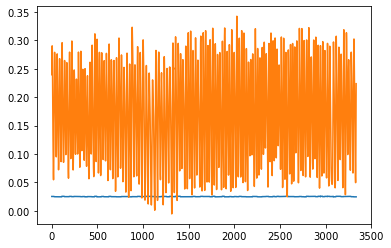

In [276]:
plt.plot(trajectories_STUDY.target_position_series.dot(np.array([0,0,1])))
plt.plot(trajectories_STUDY.position_series.dot(np.array([0,0,1])))
plt.show()

In [204]:
trajectories_STUDY._indices_VR_STUDY.loc[trajectories_STUDY._indices_VR_STUDY["RUN_ID"] == 1]

,type,target_id,target_pos_x,target_pos_y,target_pos_z,RUN_ID,RUN_INIT_TIME
timestamp,,,,,,,
0.00000,spawn,0,0.123877,-0.030261,0.024575,1,12-56-56
0.15301,spawn,1,-0.135197,0.066447,0.024777,1,12-56-56
0.37526,spawn,2,-0.112940,0.121714,0.025141,1,12-56-56
0.44557,hit,0,0.123877,-0.030261,0.024575,1,12-56-56
0.66912,spawn,3,0.056850,-0.149838,0.024994,1,12-56-56
0.87414,hit,1,-0.135197,0.066447,0.024777,1,12-56-56
0.87414,hit,2,-0.112940,0.121714,0.025141,1,12-56-56
1.10120,spawn,4,0.112172,0.135122,0.024528,1,12-56-56
1.12917,spawn,5,-0.048690,-0.017067,0.024575,1,12-56-56


In [ ]:
trajectories_SIMULATION._target_idx_trials_meta_indices

test = np.squeeze(np.vstack([list(zip(np.concatenate(([-1], idx)), idx, idx[1:])) for idx in trajectories_SIMULATION._indices]))
preselection_include_target_ids = lambda target_id: target_id in trajectories_SIMULATION.TARGET_IDS if trajectories_SIMULATION.TARGET_IDS is not None else True
preselection_include_trials = lambda k: (k in trajectories_SIMULATION.TRIAL_IDS) if trajectories_SIMULATION.TRIAL_IDS is not None else (k in trajectories_SIMULATION.META_IDS) if trajectories_SIMULATION.META_IDS is not None else (k in range(trajectories_SIMULATION.N_MOVS)) if trajectories_SIMULATION.N_MOVS is not None else True

#test2 = [test[np.where([all([getattr(trajectories_SIMULATION, f"_{agg_var}_idx_trials")[k] == i[j] for j, agg_var in enumerate(trajectories_SIMULATION.AGGREGATION_VARS)] + [preselection_include_target_ids(trajectories_SIMULATION._target_idx_trials[k])] + [preselection_include_trials(trajectories_SIMULATION._target_idx_trials_meta_indices[k])]) for k in range(len(test))])[0]].tolist() for i in itertools.product(*[np.unique(getattr(trajectories_SIMULATION, f"_{agg_var}_idx_trials")) for agg_var in trajectories_SIMULATION.AGGREGATION_VARS])]
#test2

([preselection_include_trials(trajectories_SIMULATION._target_idx_trials_meta_indices[k]) for k in range(len(test))])
([preselection_include_target_ids(trajectories_SIMULATION._target_idx_trials[k]) for k in range(len(test))])
trajectories_SIMULATION.indices.shape

In [ ]:
if "action_fig" in locals():
    plt.close(action_fig)
# action_fig = plt.figure()
# action_ax = action_fig.gca()

plt.ion()
action_fig, action_ax = plt.subplots(1, 2, figsize=[9, 3])

In [ ]:
action_ax[0].set_ylim([0, 0.8])
action_ax[1].set_ylim([0, 0.8])

In [ ]:
"""
WARNING: This cell needs to be executed in combination with "endeffector_fig" cell above, as simulation data is only pre-processed above!
"""

for axis in action_ax:
    axis.clear()
action_fig.subplots_adjust(left=0.1, right=0.95, bottom=0.17, top=0.9, wspace=0.26, hspace=0.2)

####
## INFO: uses TrajectoryData classes defined above
"""
IMPORTANT WARNING:
Ensure that the following variables are set consistent with the endeffector_fig plot above!
"""
logging.warning("Ensure that the plotting variables are set consistent with the endeffector_fig plot above!")

# WHICH PARTS OF DATASET?
MOVEMENT_IDS = None
RADIUS_IDS = None
EPISODE_IDS = [7]

COST_WEIGHTS_LIST = [(r1list[0], r2list[-1]), (r1list[-1], r2list[-1])]  #only used if PLOTTING_ENV == "MPC-costweights"
#TASK_CONDITION_LIST_SELECTED = ["Standing_ID_ISO_15_plane", "Standing_Cursor_Handtuned_ISO_15_plane"]  #only used if PLOTTING_ENV == "MPC-taskconditions"

# WHAT TO COMPUTE?
EFFECTIVE_PROJECTION_PATH = (PLOTTING_ENV == "RL-UIB")  #if True, projection path connects effective initial and final position instead of nominal target center positions
USE_TARGETBOUND_AS_DIST = False  #if True, only plot trajectory until targetboundary is reached first (i.e., until dwell time begins)

# WHICH/HOW MANY MOVS?
TARGET_IDS = range(2,5) #[3]  #corresponds to target IDs (if PLOTTING_ENV == "RL-UIB": only for iso-task)
TRIAL_IDS = range(14) #[7]  #corresponds to target IDs if AGGREGATE_TRIALS==True, else Trial ID [last column of self.indices]; either a list of indices, "different_target_sizes" (choose N_MOVS conditions with maximum differences in target size), or None (use META_IDS)
META_IDS = None  #index positions (i.e., sequential numbering of trials [aggregated trials, if AGGREGATE_TRIALS==True] in indices, without counting removed outliers); if None: use N_MOVS
N_MOVS = None #number of movements to take into account (only used, if TRIAL_IDS and META_IDS are both None (or TRIAL_IDS == "different_target_sizes"))
AGGREGATION_VARS = []  #["episode", "targetoccurrence"] #["episode", "movement"]  #["targetoccurrence"] #["episode", "movement"]  #["episode", "radius", "movement", "target", "targetoccurrence"]

# REMOVE FAILED TRIALS/OUTLIERS?   #only if SHOW_AGGREGATED_RECRUITMENTS == True
#REMOVE_FAILED = True  #TODO
REMOVE_OUTLIERS = False

# WHAT TO PLOT?
SHOW_AGGREGATED_RECRUITMENTS = False  #if True, show boxplot with aggregated muscle recruitments for each muscle; otherwise, show control series of ACTUATOR_ID and reward series
ACTUATOR_ID = 3 #index of actuator to plot (only if SHOW_AGGREGATED_RECRUITMENTS == False)

# HOW TO PLOT?  #only if SHOW_AGGREGATED_RECRUITMENTS == False
NORMALIZE_TIME = False
PLOT_RANGES = False
CONF_LEVEL = "min/max"  # might be between 0 and 1, or "min/max"; only used if PLOT_RANGES==True

# WHICH BASELINE?
SHOW_STUDY = False  #if True, show control values from study as comparison (only if SHOW_AGGREGATED_RECRUITMENTS == False)

# STORE PLOT?
STORE_PLOT = False
####

if len(AGGREGATION_VARS) > 0 and not SHOW_AGGREGATED_RECRUITMENTS:
    # This assert can be disabled.
    assert not NORMALIZE_TIME, f"NORMALIZE_TIME has no effect on the computation of distributions (mean, variability, etc.)!"

if PLOTTING_ENV == "MPC-costweights":
    assert SHOW_AGGREGATED_RECRUITMENTS, f"Currently, the torque-actuated biomechanical model of the MPC simulation only allows to visualize aggregated muscle recruitment (on the joint level)."
    
AGGREGATION_VARS_STUDY = [agg_var for agg_var in AGGREGATION_VARS if agg_var in ["targetoccurrence"]]

if PLOTTING_ENV == "MPC-costweights":
    current_actuator_names = trajectories_WEIGHTS[0].actuator_names.copy()
elif PLOTTING_ENV == "MPC-taskconditions":
    current_actuator_names = trajectories_CONDITIONS[0].actuator_names.copy()    
else:
    current_actuator_names = actuator_names.copy()

# Specify plot filename
pprint_range_or_intlist = lambda x: (f"{x.start}-{x.stop-1}" if x.start < x.stop-1 else f"{x.start}" if x.start == x.stop-1 else "ERROR") if isinstance(x, range) else ((f"{min(x)}-{max(x)}" if min(x) != max(x) else f"{min(x)}") if set(range(min(x), max(x) + 1)) == set(x) else ",".join([str(i) for i in sorted(set(x))])) if isinstance(x, list) or (isinstance(x, np.ndarray) and x.ndim == 1) else f"0-{x-1}" if isinstance(x, int) else "ERROR"

_plot_EPISODE_ID = f"E{pprint_range_or_intlist(EPISODE_IDS)}_" if EPISODE_IDS is not None else ""
_plot_MOVEMENT_ID = f"M{pprint_range_or_intlist(MOVEMENT_IDS)}_" if MOVEMENT_IDS is not None else ""
_plot_RADIUS_ID = f"R{pprint_range_or_intlist(RADIUS_IDS)}_" if RADIUS_IDS is not None else ""

_plot_ACTUATOR_ID = "MuscleRecruitment_" if SHOW_AGGREGATED_RECRUITMENTS else f"{current_actuator_names[ACTUATOR_ID]}_"

_plot_TARGET_ID = f"T{pprint_range_or_intlist(TARGET_IDS)}_" if TARGET_IDS is not None else ""
_plot_METATRIAL_ID = f"Tr{pprint_range_or_intlist(TRIAL_IDS)}_" if TRIAL_IDS is not None else f"MT{pprint_range_or_intlist(META_IDS)}_" if META_IDS is not None else f"MN{pprint_range_or_intlist(N_MOVS)}_" if N_MOVS is not None else ""
_plot_AGGREGATE = f"AGG-{'-'.join(AGGREGATION_VARS)}_" if len(AGGREGATION_VARS) > 0 else ""
_plot_RANGE = f"{CONF_LEVEL.replace('/', '') if isinstance(CONF_LEVEL, str) else str(CONF_LEVEL) + 'CI'}_" if PLOT_RANGES and not SHOW_AGGREGATED_RECRUITMENTS else ""
_plot_EFFECTIVE_PROJECTION_PATH = "eP_" if EFFECTIVE_PROJECTION_PATH else ""
_plot_USE_TARGETBOUND_AS_DIST = "TB_" if USE_TARGETBOUND_AS_DIST else ""

_plot_REMOVE_OUTLIERS = 'rO_' if REMOVE_OUTLIERS else ''
if PLOTTING_ENV == "RL-UIB":
    plot_action_filename_ID = f"UIB/{filename}/{_plot_EPISODE_ID}{_plot_MOVEMENT_ID}{_plot_RADIUS_ID}{_plot_ACTUATOR_ID}{_plot_TARGET_ID}{_plot_METATRIAL_ID}{_plot_AGGREGATE}{_plot_RANGE}{_plot_EFFECTIVE_PROJECTION_PATH}{_plot_USE_TARGETBOUND_AS_DIST}{_plot_REMOVE_OUTLIERS}"
elif PLOTTING_ENV == "MPC-costweights":
    plot_action_filename_ID = f"MPC/{common_simulation_subdir}/{USER_ID}/{TASK_CONDITION}/{_plot_r1_FIXED}{_plot_r2_FIXED}{_plot_ACTUATOR_ID}{_plot_TARGET_ID}{_plot_METATRIAL_ID}{_plot_AGGREGATE}{_plot_RANGE}{_plot_EFFECTIVE_PROJECTION_PATH}{_plot_USE_TARGETBOUND_AS_DIST}{_plot_REMOVE_OUTLIERS}"
# elif PLOTTING_ENV == "MPC-costs":
#     plot_action_filename_ID = f"MPC/{common_simulation_subdir}/{USER_ID}/{TASK_CONDITION}/{_plot_JOINT_ID}{_plot_DEVIATION}{_plot_PHASESPACE}{_plot_VEL_ACC}{_plot_TARGET_ID}{_plot_METATRIAL_ID}{_plot_AGGREGATE}{_plot_RANGE}{_plot_EFFECTIVE_PROJECTION_PATH}{_plot_USE_TARGETBOUND_AS_DIST}"
# elif PLOTTING_ENV == "MPC-userstudy" or PLOTTING_ENV == "MPC-userstudy-baselineonly":
#     plot_action_filename_ID = f"MPC/{SIMULATION_SUBDIR}/{USER_ID_FIXED}_FIXED/{TASK_CONDITION}/{_plot_JOINT_ID}{_plot_DEVIATION}{_plot_PHASESPACE}{_plot_VEL_ACC}{_plot_TARGET_ID}{_plot_METATRIAL_ID}{_plot_AGGREGATE}{_plot_RANGE}{_plot_EFFECTIVE_PROJECTION_PATH}{_plot_USE_TARGETBOUND_AS_DIST}"
elif PLOTTING_ENV == "MPC-taskconditions":
    plot_action_filename_ID = f"MPC/{SIMULATION_SUBDIR}/{USER_ID}/{common_taskcondition_subdir}/{_plot_ACTUATOR_ID}{_plot_TARGET_ID}{_plot_METATRIAL_ID}{_plot_AGGREGATE}{_plot_RANGE}{_plot_EFFECTIVE_PROJECTION_PATH}{_plot_USE_TARGETBOUND_AS_DIST}{_plot_REMOVE_OUTLIERS}"
else:
    raise NotImplementedError
if plot_action_filename_ID[-1] in ["-", "_"]:
    plot_action_filename_ID = plot_action_filename_ID[:-1]


if PLOTTING_ENV == "RL-UIB":
    trajectories_SIMULATION.preprocess(MOVEMENT_IDS=MOVEMENT_IDS, RADIUS_IDS=RADIUS_IDS, EPISODE_IDS=EPISODE_IDS, split_trials="tracking" not in filename and "driving" not in filename)
else:
    trajectories_SIMULATION.preprocess(MOVEMENT_IDS=MOVEMENT_IDS, RADIUS_IDS=RADIUS_IDS, EPISODE_IDS=EPISODE_IDS)
trajectories_SIMULATION.compute_indices(TARGET_IDS=TARGET_IDS, TRIAL_IDS=TRIAL_IDS, META_IDS=META_IDS, N_MOVS=N_MOVS, AGGREGATION_VARS=AGGREGATION_VARS, ignore_trainingset_trials=PLOTTING_ENV.startswith("MPC-"))
trajectories_SIMULATION.SHOW_MINJERK = False
trajectories_STUDY.compute_indices(TARGET_IDS=TARGET_IDS, TRIAL_IDS=TRIAL_IDS, META_IDS=META_IDS, N_MOVS=N_MOVS, AGGREGATION_VARS=AGGREGATION_VARS_STUDY, ignore_trainingset_trials=PLOTTING_ENV.startswith("MPC-"))
if PLOTTING_ENV == "RL-UIB":
    ## RL (Aleksi)
    trajectories_actioninfo = [(trajectories_SIMULATION, {'linestyle': '-', 'label': 'Simulation'}, {'alpha': 0.2}), (trajectories_STUDY, {'linestyle': ':', 'label': 'Study'}, {'alpha': 0.2})]  #contains tuples consisting of 1. a TrajectoryData instance, 2. a dict with plotting kwargs for action plots, and 3. a dict with plotting kwargs for "fill_between" plots
elif PLOTTING_ENV == "MPC-costweights":
    #MARKUS MPC - COMPARISON OF COST WEIGHTS OF A GIVEN COST FUNCTION
    assert SHOW_STUDY == False, "Did not prepare user study data for this case."
    assert len(COST_WEIGHTS_LIST) == len(action_ax), f"ERROR: Number of selected cost weights should be {len(action_ax)}, but is {len(COST_WEIGHTS_LIST)}!"
    assert all([isinstance(cost_weights_current, tuple) for cost_weights_current in COST_WEIGHTS_LIST]), "ERROR: 'COST_WEIGHTS_LIST' should only consist of tuples with respective parameter values."
    
    trajectories_WEIGHTS_selected = trajectories_WEIGHTS.copy()
    trajectories_and_cost_weights_indices_selected = [(i, COST_WEIGHTS_LIST_index[0]) for i in trajectories_WEIGHTS_selected if len(COST_WEIGHTS_LIST_index := np.where([all([f"r{idx + 1 if idx > 0 else ''}_{float(cost_weights_current[idx]):.8e}" in i.SIMULATION_SUBDIR for idx in range(len(COST_WEIGHTS_LIST))]) for cost_weights_current in COST_WEIGHTS_LIST])[0]) == 1]
    trajectories_WEIGHTS_selected = [i[0] for i in trajectories_and_cost_weights_indices_selected]
    cost_weights_indices_selected = [i[1] for i in trajectories_and_cost_weights_indices_selected]
    for trajectories in trajectories_WEIGHTS_selected:
        trajectories.compute_indices(TARGET_IDS=TARGET_IDS, TRIAL_IDS=TRIAL_IDS, META_IDS=META_IDS, N_MOVS=N_MOVS, AGGREGATION_VARS=AGGREGATION_VARS_STUDY, ignore_trainingset_trials=True)
    trajectories_actioninfo = [(trajectories, {'linestyle': '-', 'label': ", ".join(filter(None, [f"r{idx + 1 if idx > 0 else ''}_{float(cost_weights_indices_selected[idx]):.8e}" for idx in range(len(cost_weights_indices_selected))]))}, {'alpha': 0.2}) for i, trajectories in enumerate(trajectories_WEIGHTS_selected)]  #contains tuples consisting of 1. a TrajectoryData instance, 2. a dict with plotting kwargs for action plots, and 3. a dict with plotting kwargs for "fill_between" plots
elif PLOTTING_ENV == "MPC-taskconditions":
    #MARKUS MPC - COMPARISON OF DIFFERENT INTERACTION TECHNIQUES/TASK CONDITIONS
    assert SHOW_STUDY == False, "Did not prepare user study data for this case."
    #assert len(TASK_CONDITION_LIST_SELECTED) == len(action_ax), f"ERROR: Number of selected task conditions should be {len(action_ax)}, but is {len(TASK_CONDITION_LIST_SELECTED)}!"
    assert len(TASK_CONDITION_LIST) == len(action_ax), f"ERROR: Number of selected task conditions should be {len(action_ax)}, but is {len(TASK_CONDITION_LIST)}!"

    trajectories_CONDITIONS_selected = trajectories_CONDITIONS.copy()
    #trajectories_CONDITIONS_selected = [i for i in trajectories_CONDITIONS_selected if i.TASK_CONDITION in TASK_CONDITION_LIST_SELECTED]
    for trajectories in trajectories_CONDITIONS_selected:
        trajectories.compute_indices(TARGET_IDS=TARGET_IDS, TRIAL_IDS=TRIAL_IDS, META_IDS=META_IDS, N_MOVS=N_MOVS, AGGREGATION_VARS=AGGREGATION_VARS_STUDY, ignore_trainingset_trials=True)
    map_task_conditions = lambda x: " ".join(["Virtual Pad" if "_Pad_" in x else "Virtual Cursor", "ID" if "_ID_" in x else "Erg." if "_Handtuned_" in x else "???"])
    trajectories_actioninfo = [(trajectories, {'linestyle': '-', 'label': map_task_conditions(trajectories.TASK_CONDITION)}, {'alpha': 0.2}) for i, trajectories in enumerate(trajectories_CONDITIONS_selected)]  #contains tuples consisting of 1. a TrajectoryData instance, 2. a dict with plotting kwargs for action plots, and 3. a dict with plotting kwargs for "fill_between" plots
else:
    raise NotImplementedError

if SHOW_AGGREGATED_RECRUITMENTS:
    assert AGGREGATION_VARS == []
    assert AGGREGATION_VARS_STUDY == []
        
    for axes_id, (trajectories, trajectory_plotting_kwargs, range_plotting_kwargs) in enumerate(trajectories_actioninfo):
        # Aggregated muscle recruitment plot (with noise)
        selected_movements_indices = trajectories.selected_movements_indices.copy()
        #movement_indices_TO_DELETE = np.where(np.array(MT_list) >= MAX_TIME - DWELL_TIME - 1e-6)[0].tolist()
        if isinstance(trajectories.control_series, list):
            #aggregated_recruitments_series = 
            aggregated_recruitments_controls = {actuator_name: [np.trapz(trajectories.control_series[meta_id][current_idx: next_idx, actuator_idx], x=trajectories.time_series[meta_id][current_idx: next_idx]) for meta_id, indices_current_radius in enumerate(trajectories.indices) for last_idx, current_idx, next_idx in trajectories.selected_movements_indices] for actuator_idx, actuator_name in enumerate(current_actuator_names)}
        else:
            aggregated_recruitments_controls = {actuator_name: [np.trapz(trajectories.control_series[(current_idx[0] if type(current_idx) == list else current_idx): (next_idx[0] if type(next_idx) == list else next_idx), actuator_idx], x=trajectories.time_series[(current_idx[0] if type(current_idx) == list else current_idx): (next_idx[0] if type(next_idx) == list else next_idx)]) for last_idx, current_idx, next_idx in trajectories.selected_movements_indices] for actuator_idx, actuator_name in enumerate(current_actuator_names)} #if (last_idx_hlp := (last_idx[0] if isinstance(last_idx, list) and len(last_idx) == 1 else last_idx)) is not None if (current_idx_hlp := (current_idx[0] if isinstance(current_idx, list) and len(current_idx) == 1 else current_idx)) is not None if ((next_idx_hlp := next_idx[0] if isinstance(next_idx, list) and len(next_idx) == 1 else next_idx)) is not None}
        
        if REMOVE_OUTLIERS:
            sample_indices_TO_DELETE = []
            for k, v in aggregated_recruitments_controls.items():
                sample_indices_TO_DELETE.extend(np.where(np.abs(stats.zscore(v)) > 3)[0].tolist())
            if len(sample_indices_TO_DELETE) > 0:
                print(f"{trajectory_plotting_kwargs['label']} - Removed {len(sample_indices_TO_DELETE)} outlier trials.")
            for k, v in aggregated_recruitments_controls.items():
                aggregated_recruitments_controls[k] = [i for idx, i in enumerate(v) if idx not in sample_indices_TO_DELETE]

        #action_ax[axes_id].boxplot(aggregated_recruitments_controls.values(), labels=aggregated_recruitments_controls.keys())
        sns.boxplot(data=pd.DataFrame(aggregated_recruitments_controls), ax=action_ax[axes_id])#, labels=aggregated_recruitments_controls.keys())
        
        action_ax[axes_id].set_xticklabels(aggregated_recruitments_controls.keys(), rotation=90, fontsize=6)
        action_ax[axes_id].set_title(f"Aggregated Muscle Recruitment ({trajectory_plotting_kwargs['label']})")
        #action_ax[axes_id].set_xlabel("Muscle")
        action_ax[axes_id].set_ylabel("Sum of Muscle Control Values")
    
#     if not SHOW_STUDY:
#         # Aggregated muscle recruitment plot (without noise)
#         if isinstance(trajectories.action_series, list):
#             aggregated_recruitments_actions = {actuator_name: [np.trapz(trajectories.action_series[meta_id][current_idx: next_idx, actuator_idx], x=trajectories.time_series[meta_id][current_idx: next_idx]) for meta_id, indices_current_radius in enumerate(trajectories.indices) for last_idx, current_idx, next_idx in list(zip(np.concatenate(([-1], indices_current_radius[:-1])), indices_current_radius, indices_current_radius[1:]))] for actuator_idx, actuator_name in enumerate(actuator_names)}
#         else:
#             aggregated_recruitments_actions = {actuator_name: [np.trapz(trajectories.action_series[current_idx: next_idx, actuator_idx], x=trajectories.time_series[current_idx: next_idx]) for last_idx, current_idx, next_idx in list(zip(np.concatenate(([-1], trajectories.indices[:-1])), trajectories.indices, trajectories.indices[1:]))] for actuator_idx, actuator_name in enumerate(current_actuator_names)}        
#         #action_ax[0].boxplot(aggregated_recruitments_actions.values(), labels=aggregated_recruitments_actions.keys())
#         sns.boxplot(data=pd.DataFrame(aggregated_recruitments_actions), ax=action_ax[1])#, labels=aggregated_recruitments_actions.keys())

#         action_ax[1].set_xticklabels(aggregated_recruitments_actions.keys(), rotation=90, fontsize=6)
#         action_ax[1].set_title("Aggregated Muscle Recruitment")
#         #action_ax[1].set_xlabel("Muscle")
#         action_ax[1].set_ylabel("Sum of Muscle Action Values")

    #action_ax[0].legend()
    #action_ax[1].legend()
    
    #action_fig.savefig(f"plots/{filename}/aggregated_muscle_{trajectories_SIMULATION.data_key}.png", dpi=120)
else:
    ## ANALYSIS OF POINTING TASKS -> Plot controls and rewards
    #solid_line = Line2D([0], [0], color='black', linestyle='-', label='Actions')
    #dashed_line = Line2D([0], [0], color='black', linestyle='--', label='Controls')
    #action_ax[0].legend(handles=[solid_line, dashed_line])
    methods_handles_ax0 = []
    methods_handles_ax1 = []

    action_ax[0].set_title(f"Control Time Series – {current_actuator_names[ACTUATOR_ID]}")
    action_ax[0].set_xlabel("Time " + ('[normalized]' if NORMALIZE_TIME else r'$\left(s\right)$'))
    action_ax[0].set_ylabel("Control [normalized]")

    action_ax[1].set_title("Reward Time Series")
    action_ax[1].set_xlabel("Time " + ('[normalized]' if NORMALIZE_TIME else r'$\left(s\right)$'))
    action_ax[1].set_ylabel("Reward")
    action_ax[1].set_yscale("symlog")

    for axes_id, (trajectories, trajectory_plotting_kwargs, range_plotting_kwargs) in enumerate(trajectories_actioninfo):
        methods_handles_ax0.append(Line2D([0], [0], color="black", **{k: v for k,v in trajectory_plotting_kwargs.items() if k != "color"}))
        if hasattr(trajectories, "_reward_series"):
            methods_handles_ax1.append(Line2D([0], [0], color="black", **{k: v for k,v in trajectory_plotting_kwargs.items() if k != "color"}))
        
        for episode_index_current, (last_idx, current_idx, next_idx) in enumerate(trajectories.selected_movements_indices):
            if isinstance(last_idx, list) and len(last_idx) > 1:  #if len(AGGREGATION_VARS) > 0
                trajectories.compute_action_statistics(episode_index_current, targetbound_as_target=USE_TARGETBOUND_AS_DIST, normalize_time=NORMALIZE_TIME)
                
                ### CONTROLS
                latest_plot, = action_ax[0].plot(trajectories.action_stats_time_series_extended, trajectories.control_series_mean[:, ACTUATOR_ID], **trajectory_plotting_kwargs)
                if PLOT_RANGES:
                    if CONF_LEVEL == "min/max":
                        # add min/max bounds
                        action_ax[0].fill_between(trajectories.action_stats_time_series_extended, trajectories.control_series_min[:, ACTUATOR_ID], trajectories.control_series_max[:, ACTUATOR_ID], color=latest_plot.get_color(), **{k: v for k,v in range_plotting_kwargs.items() if k != "color"})
                    else:
                        # add confidence interval bounds
                        control_series_std =  np.sqrt(trajectories.control_series_cov[:, ACTUATOR_ID])
                        action_ax[0].fill_between(trajectories.action_stats_time_series_extended, trajectories.control_series_mean[:, ACTUATOR_ID] - stats.norm.ppf((CONF_LEVEL + 1)/2) * control_series_std, trajectories.control_series_mean[:, ACTUATOR_ID] + stats.norm.ppf((CONF_LEVEL + 1)/2) * control_series_std, color=latest_plot.get_color(), **{k: v for k,v in range_plotting_kwargs.items() if k != "color"})
                
                ### REWARD
                if hasattr(trajectories, "_reward_series"):
                    latest_plot, = action_ax[1].plot(trajectories.action_stats_time_series_extended, trajectories.reward_series_mean, **trajectory_plotting_kwargs)
                    if PLOT_RANGES:
                        if CONF_LEVEL == "min/max":
                            # add min/max bounds
                            action_ax[1].fill_between(trajectories.action_stats_time_series_extended, trajectories.reward_series_min, trajectories.reward_series_max, color=latest_plot.get_color(), **{k: v for k,v in range_plotting_kwargs.items() if k != "color"})
                        else:
                            # add confidence interval bounds
                            reward_series_std =  np.sqrt(trajectories.reward_series_cov)
                            action_ax[1].fill_between(trajectories.action_stats_time_series_extended, trajectories.reward_series_mean - stats.norm.ppf((CONF_LEVEL + 1)/2) * reward_series_std, trajectories.reward_series_mean + stats.norm.ppf((CONF_LEVEL + 1)/2) * reward_series_std, color=latest_plot.get_color(), **{k: v for k,v in range_plotting_kwargs.items() if k != "color"})
                
            else:
                trajectories.compute_trial(episode_index_current, effective_projection_path=EFFECTIVE_PROJECTION_PATH, targetbound_as_target=USE_TARGETBOUND_AS_DIST, normalize_time=NORMALIZE_TIME)
                
                ### CONTROLS
                #action_ax[0].plot(trajectories.time_series_trial, trajectories.action_series_trial[:, ACTUATOR_ID])  #, linestyle='-')
                latest_plot, = action_ax[0].plot(trajectories.time_series_trial, trajectories.control_series_trial[:, ACTUATOR_ID], **trajectory_plotting_kwargs)  #, linestyle='--')
                
                ### REWARD
                if hasattr(trajectories, "_reward_series"):
                    latest_plot, = action_ax[1].plot(trajectories.time_series_trial, trajectories.reward_series_trial, **trajectory_plotting_kwargs)

    # handles, labels = action_ax[0].get_legend_handles_labels()
    # # remove duplicate entries
    # handles = [handle for idx, (handle, label) in enumerate(zip(handles, labels)) if labels.index(label) == idx]
    # labels = [label for idx, label in enumerate(labels) if labels.index(label) == idx]
    
    if len(methods_handles_ax0) == 1:
        methods_handles_ax0 = []
    else:
        action_ax[0].legend(handles=methods_handles_ax0)
    if len(methods_handles_ax1) == 1:
        methods_handles_ax1 = []
    else:
        action_ax[1].legend(handles=methods_handles_ax1)
    
    #action_fig.savefig(f"plots/{filename}/controls_{current_actuator_names[ACTUATOR_ID]}_rewards.png", dpi=120)


if STORE_PLOT:
    action_fig.savefig(f"/home/florian/reacher_sg/_plots/{plot_action_filename_ID}.png", dpi=300)
else:
    logging.warning(f"Plotting is disabled.\nCurrent filename: {plot_action_filename_ID}.png")

In [ ]:
trajectories.time_series.shape[0], trajectories.control_series.shape[0], trajectories.position_series.shape[0], trajectories.reward_series.shape[0]

In [ ]:
trajectories.time_series.shape[0] - trajectories.control_series.shape[0]
len(trajectories.selected_movements_indices)
trajectories = trajectories_SIMULATION
[np.trapz(trajectories.control_series[current_idx[0]: next_idx[0], 2], x=trajectories.time_series[current_idx[0]: next_idx[0]]) for last_idx, current_idx, next_idx in trajectories.selected_movements_indices[:10]]
[trajectories.control_series[current_idx[0]: next_idx[0], 2] for last_idx, current_idx, next_idx in trajectories.selected_movements_indices[:10]]


In [ ]:
trajectories = trajectories_STUDY
[np.trapz(trajectories.control_series[current_idx: next_idx, 2], x=trajectories.time_series[current_idx: next_idx]) for last_idx, current_idx, next_idx in trajectories.selected_movements_indices[:10]]
[trajectories.control_series[current_idx: next_idx, 2] for last_idx, current_idx, next_idx in trajectories.selected_movements_indices[:10]]


### Fitts' Law and Endpoint Variability

In [515]:
params = {'legend.fontsize': 6, #Fontsize of the legend entries
          'legend.title_fontsize': 6, #Fontsize of the legend title
          #'font.size': 12  #Default fontsize
         }

plt.rcParams.update(params)

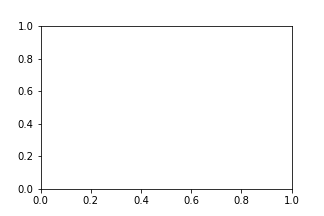

In [4433]:
if "fittslaw_fig" in locals():
    plt.close(fittslaw_fig)
plt.ion()
fittslaw_fig = plt.figure(figsize=[4.5, 3])
fittslaw_ax = fittslaw_fig.gca()
# fittslaw_fig, fittslaw_ax = plt.subplots(1, 2, figsize=[9, 3])

In [4434]:
fittslaw_ax.clear()
fittslaw_fig.subplots_adjust(left=0.2, right=0.95, bottom=0.2, top=0.8)#, wspace=0.26, hspace=0.2)

###
REMOVE_FAILED = True
REMOVE_OUTLIERS = False

EFFECTIVE_PROJECTION_PATH = True
USE_TARGETBOUND_AS_DIST = False
DWELL_TIME = 0.5 if "iso-" in filename else 0.3 #only used if USE_TARGETBOUND_AS_DIST == False
MAX_TIME = 4.0  #only used if REMOVE_FAILED == True

PLOT_TYPE = "alldata"  #"alldata", "boxplot", "mean_groups", "meandata", "density_ID"
BOXPLOT_category = "ID"
BOXPLOT_nbins = 5
BOXPLOT_qbins = True  #whether to use quantile-based bins (i.e., same number of samples per bin) or range-based bins (i.e., same length of each bin interval)

DENSITY_group_nIDbins = 1  #number of ID groups
DENSITY_group_IDbin_ID = 0  #index of ID group (between 0 and DENSITY_group_nIDbins-1) for which a density plot of movement times is created (only used if PLOT_TYPE == "density_ID")
DENSITY_group_nMTbins = 50
###

_plot_DENSITY_group = f"group{DENSITY_group_IDbin_ID}" if PLOT_TYPE == "density_ID" else ""
_plot_filename_header = "movement_time_" if PLOT_TYPE == "density_ID" else "fittslaw_"
plot_filename_fitts = f"UIB/{filename}/{_plot_filename_header}{PLOT_TYPE}{_plot_DENSITY_group}{'_eP' if EFFECTIVE_PROJECTION_PATH else ''}{'_TB' if USE_TARGETBOUND_AS_DIST else ''}_DWELL{DWELL_TIME}{'_rF' if REMOVE_FAILED else ''}{'_rO' if REMOVE_OUTLIERS else ''}"

if PLOT_TYPE != "boxplot":
    BOXPLOT_category = "ID (bits)"  #used for xlabel

# Compute ID and MT pairs from dataset:
distance_list = []
width_list = []
ID_list = []
MT_list = []
target_position_list = []
initial_position_list = []
failed_movements_counter = 0

trajectories = trajectories_SIMULATION

trajectories.preprocess(MOVEMENT_IDS=None, RADIUS_IDS=None, EPISODE_IDS=None)
trajectories.compute_indices(TARGET_IDS=None, TRIAL_IDS=None, META_IDS=None, N_MOVS=None, AGGREGATION_VARS=[], ignore_trainingset_trials=PLOTTING_ENV.startswith("MPC-"))

#assert not REPEATED_MOVEMENTS
# if REPEATED_MOVEMENTS:
#     EPISODE_ID_LIST = list(trajectories.data_copy.keys())
# else:
#     EPISODE_ID_LIST = range(trajectories.EPISODE_ID_NUMS)

# for EPISODE_ID in EPISODE_ID_LIST:
#     trajectories.preprocess(EPISODE_ID=str(EPISODE_ID), REPEATED_MOVEMENTS=False)
#     # Use all available trials
#     trajectories.compute_indices(TRIAL_IDS=None, META_IDS=None, N_MOVS=None, ignore_trainingset_trials=PLOTTING_ENV.startswith("MPC-"))
    
for trial_index_current, (last_idx, current_idx, next_idx) in enumerate(trajectories.selected_movements_indices):
    try:
        trajectories.compute_trial(trial_index_current, effective_projection_path=EFFECTIVE_PROJECTION_PATH, targetbound_as_target=USE_TARGETBOUND_AS_DIST, dwell_time=DWELL_TIME, compute_deviation=False, normalize_time=False)
    except AssertionError:
        failed_movements_counter += 1
    else:
        MT_list.append(trajectories.effective_MT_trial)
        width_list.append(trajectories.target_width_trial)
        distance_list.append(trajectories.target_distance_trial)
        ID_list.append(trajectories.fitts_ID_trial)
        target_position_list.append(trajectories.final_val)
        initial_position_list.append(trajectories.init_val)

# Remove outliers:
movement_indices_TO_DELETE = []
if REMOVE_OUTLIERS or REMOVE_FAILED:
    # Ensure that movements that did not hit the target are removed 
    if REMOVE_FAILED:
        movement_indices_TO_DELETE = np.where(np.array(MT_list) >= MAX_TIME - DWELL_TIME - 1e-6)[0].tolist()
    
    # Ensure that too long movements are removed (all movements with duration - mean(duration) > 3 * std(duration))
    #MT_list_zscores = stats.zscore(MT_list)
    if REMOVE_OUTLIERS:
        movement_indices_TO_DELETE = np.where(np.abs(stats.zscore(MT_list)) > 3)[0].tolist()

    distance_list = [val for idx, val in enumerate(distance_list) if idx not in movement_indices_TO_DELETE]
    width_list = [val for idx, val in enumerate(width_list) if idx not in movement_indices_TO_DELETE]
    ID_list = [val for idx, val in enumerate(ID_list) if idx not in movement_indices_TO_DELETE]
    MT_list = [val for idx, val in enumerate(MT_list) if idx not in movement_indices_TO_DELETE]
    target_position_list = [val for idx, val in enumerate(target_position_list) if idx not in movement_indices_TO_DELETE]
    initial_position_list = [val for idx, val in enumerate(initial_position_list) if idx not in movement_indices_TO_DELETE]

add_info = f'{len(movement_indices_TO_DELETE)} outliers were dropped' if movement_indices_TO_DELETE else '', f'{failed_movements_counter} movements failed' if failed_movements_counter else ''
add_info_nonempty = [i for i in add_info if len(i)]
add_info_str = f" ({'; '.join(add_info_nonempty)})" if add_info_nonempty else ""
print(f"INFO: Using {len(ID_list)} movements from {len(trajectories.data)} episodes{add_info_str}.")

# Linear regression:
poly_coef = np.polyfit(ID_list, MT_list, 1)
p_linreg = np.poly1d(poly_coef)

# Coefficient of determination:
SQE = np.square(np.linalg.norm(p_linreg(ID_list) - np.mean(MT_list)))
SQT = np.square(np.linalg.norm(MT_list - np.mean(MT_list)))
R2 = SQE/SQT
print("Fitts' Law - Coefficient of determination (R^2): {}".format(R2))

if PLOT_TYPE == "boxplot":
    df = pd.DataFrame({"Distance": distance_list, "Width": width_list, "ID": ID_list, "MT": MT_list})
    if BOXPLOT_qbins:
        df_bins = df.groupby([pd.qcut(df[BOXPLOT_category], BOXPLOT_nbins)])["MT"].apply(list)
    else:
        df_bins = df.groupby([pd.cut(df[BOXPLOT_category], BOXPLOT_nbins)])["MT"].apply(list)
    df_bins_renamed = df_bins.rename(lambda x: x if type(x) == float else f"{x.left.round(2)}-{x.right.round(2)}", axis=0)
    fittslaw_ax.boxplot(df_bins_renamed, labels=df_bins_renamed.index, positions=[x.mid for x in df_bins.index], widths=[0.8*(x.right - x.left) for x in df_bins.index])
    fittslaw_ax.relim()
    if BOXPLOT_category == "ID":
        lin_regression_x = locals()[f"{BOXPLOT_category}_list"]
        lin_regression_y = p_linreg(ID_list)
        lin_regression_sorted = sorted(zip(lin_regression_x, lin_regression_y))
        lin_regression_x = [x for x, y in lin_regression_sorted]
        lin_regression_y = [y for x, y in lin_regression_sorted]
        fittslaw_ax.plot(lin_regression_x, lin_regression_y, color="red")
elif PLOT_TYPE == "mean_groups":
    df = pd.DataFrame({"Distance": distance_list, "Width": width_list, "ID": ID_list, "MT": MT_list})
    if REPEATED_MOVEMENTS:
        assert df["Width"].nunique() == BOXPLOT_nbins, f"Set 'BOXPLOT_nbins' to the number of different target sizes included in the current dataset ({df['Width'].nunique()})!"
        if BOXPLOT_qbins:
            df_bins_groupby = df.groupby([pd.qcut(df["Distance"], BOXPLOT_nbins), df["Width"]])["MT"]
        else:
            df_bins_groupby = df.groupby([pd.cut(df["Distance"], BOXPLOT_nbins), df["Width"]])["MT"]
    else:
        if BOXPLOT_qbins:
            df_bins_groupby = df.groupby([pd.qcut(df["Distance"], BOXPLOT_nbins), pd.qcut(df["Width"], BOXPLOT_nbins)])["MT"]
        else:
            df_bins_groupby = df.groupby([pd.cut(df["Distance"], BOXPLOT_nbins), pd.cut(df["Width"], BOXPLOT_nbins)])["MT"]
    df_bins = df_bins_groupby.mean()
    df_bins_renamed = df_bins.rename(lambda x: x if type(x) == float else f"{x.left.round(2)}-{x.right.round(2)}", axis=0)
    df_bins_renamed.index = df_bins_renamed.index.map(lambda x: f"D: {x[0]}, W: {x[1]}")
    trans_dict_dist = {number: chr(ord('@')+number+1) for number in range(BOXPLOT_nbins)}
    trans_dict_width = {number: str(number) for number in range(BOXPLOT_nbins)}
    group_identifiers_dist = [(str(trans_dict_dist[idx]), f"D: {value}") for idx, value in enumerate(df_bins.index.get_level_values(0).unique().tolist())]
    group_identifiers_width = [(str(trans_dict_width[idx]), f"W: {value}") for idx, value in enumerate(df_bins.index.get_level_values(1).unique().tolist())]
    group_identifiers = df_bins.index.map(lambda x: "".join([trans_dict_dist[df_bins.index.get_level_values(0).unique().tolist().index(x[0])], trans_dict_width[df_bins.index.get_level_values(1).unique().tolist().index(x[1])]]))
    if REPEATED_MOVEMENTS:
        assert df["Width"].nunique() == BOXPLOT_nbins, f"Set 'BOXPLOT_nbins' to the number of different target sizes included in the current dataset ({df['Width'].nunique()})!"
        if BOXPLOT_qbins:
            df["classification"] = [df_bins.index.get_loc((x["Distance"], x["Width"])) for _, x in pd.concat((pd.qcut(df["Distance"], BOXPLOT_nbins), df["Width"]), axis=1).iterrows()]
        else:
            df["classification"] = [df_bins.index.get_loc((x["Distance"], x["Width"])) for _, x in pd.concat((pd.cut(df["Distance"], BOXPLOT_nbins), df["Width"]), axis=1).iterrows()]
    else:
        if BOXPLOT_qbins:
            df["classification"] = [df_bins.index.get_loc((x["Distance"], x["Width"])) for _, x in pd.concat((pd.qcut(df["Distance"], BOXPLOT_nbins), pd.qcut(df["Width"], BOXPLOT_nbins)), axis=1).iterrows()]
        else:
            df["classification"] = [df_bins.index.get_loc((x["Distance"], x["Width"])) for _, x in pd.concat((pd.cut(df["Distance"], BOXPLOT_nbins), pd.cut(df["Width"], BOXPLOT_nbins)), axis=1).iterrows()]
    df_bins = df_bins.reset_index()
    #df_bins["ID"] = df_bins.apply(lambda x: pd.Interval(np.log2(2*x["Distance"].left / x["Width"]), np.log2(2*x["Distance"].right / x["Width"])) if type(x["Width"]) == float else (pd.Interval(np.log2(2*x["Distance"] / x["Width"].right), np.log2(2*x["Distance"] / x["Width"].left)) if type(x["Distance"]) == float else pd.Interval(np.log2(2*x["Distance"].left / x["Width"].right), np.log2(2*x["Distance"].right / x["Width"].left))), axis=1)
    #df_bins["Average ID"] = df_bins.apply(lambda x: np.log2(2*x["Distance"].mid / x["Width"]) if type(x["Width"]) == float else (np.log2(2*x["Distance"] / x["Width"].mid) if type(x["Distance"]) == float else np.log2(2*x["Distance"].mid / x["Width"].mid)), axis=1)
    df_bins["ID"] = df_bins.apply(lambda x: pd.Interval(np.log2((x["Distance"].left / x["Width"]) + 1), np.log2((x["Distance"].right / x["Width"]) + 1)) if type(x["Width"]) == float else (pd.Interval(np.log2((x["Distance"] / x["Width"].right) + 1), np.log2((x["Distance"] / x["Width"].left) + 1)) if type(x["Distance"]) == float else pd.Interval(np.log2((x["Distance"].left / x["Width"].right) + 1), np.log2((x["Distance"].right / x["Width"].left)+1))), axis=1)
    df_bins["Average ID"] = df_bins.apply(lambda x: np.log2((x["Distance"].mid / x["Width"]) + 1) if type(x["Width"]) == float else (np.log2((["Distance"] / x["Width"].mid) + 1) if type(x["Distance"]) == float else np.log2((x["Distance"].mid / x["Width"].mid) + 1)), axis=1)
    df_bins["Number of Samples"] = df_bins_groupby.size().reset_index(drop=True)
    xtick_offset = 0
    
    ### ONLY SHOW SOME CONDITIONS:
    # df = df.loc[(df["classification"] >= 5) & (df["classification"] < 15)]
    # group_identifiers_dist = group_identifiers_dist[1:3]
    # group_identifiers = group_identifiers[5:15]
    # df_bins = df_bins.iloc[5:15]
    # df_bins_renamed = df_bins_renamed.iloc[5:15]
    # xtick_offset = 5

    fittslaw_ax.scatter(range(xtick_offset, xtick_offset + len(df_bins_renamed)), df_bins_renamed, color="red")#, positions=[x.mid for x in df_bins.index], widths=[0.8*(x.right - x.left) for x in df_bins.index])
    fittslaw_ax.scatter(df["classification"], df["MT"], color="blue", s=0.2)
    ## VARIANT 1 - detailed xlabels:
    #fittslaw_ax.set_xticks(range(len(df_bins_renamed)), df_bins_renamed.index, fontsize=4)
    ## VARIANT 2 - abbreviations as xlabels, additional legend:
    #fittslaw_ax.set_xticks(df_bins[~df_bins["MT"].isna()].index, df_bins[~df_bins["MT"].isna()].index + 1)
    fittslaw_ax.set_xticks(df_bins[~df_bins["MT"].isna()].index, group_identifiers[~df_bins["MT"].isna()])
    class MarkerHandler(mpl.legend_handler.HandlerBase):  #source: https://stackoverflow.com/a/47395401
        def create_artists(self, legend, integer, xdescent, ydescent,
                            width, height, fontsize,trans):
            marker_obj = mpl.markers.MarkerStyle(f'${integer}$') #Here you place your integer
            path = marker_obj.get_path().transformed(marker_obj.get_transform())

            path._vertices = np.array(path._vertices)*8 #To make it larger
            patch = mpl.patches.PathPatch(path, color="black", lw=0, transform=trans+mpl.transforms.Affine2D().translate(0, 5.5))
            return [patch]
    fittslaw_ax.legend([x for x, y in group_identifiers_dist + group_identifiers_width], [y for x,y in group_identifiers_dist + group_identifiers_width], handler_map={str:MarkerHandler()}, handletextpad=0, handlelength=1) #, prop={'size': 6})#, fontsize=8)
    ################################
    fittslaw_ax.relim()
elif PLOT_TYPE == "meandata":
    df = pd.DataFrame({"Distance": distance_list, "Width": width_list, "ID": ID_list, "MT": MT_list})
    if REPEATED_MOVEMENTS:
        assert df["Width"].nunique() == BOXPLOT_nbins, f"Set 'BOXPLOT_nbins' to the number of different target sizes included in the current dataset ({df['Width'].nunique()})!"
        if BOXPLOT_qbins:
            df_bins_groupby = df.groupby([pd.qcut(df["Distance"], BOXPLOT_nbins), df["Width"]])["MT"]
        else:
            df_bins_groupby = df.groupby([pd.cut(df["Distance"], BOXPLOT_nbins), df["Width"]])["MT"]   
    else:
        if BOXPLOT_qbins:
            df_bins_groupby = df.groupby([pd.qcut(df["Distance"], BOXPLOT_nbins), pd.qcut(df["Width"], BOXPLOT_nbins)])["MT"]
        else:
            df_bins_groupby = df.groupby([pd.cut(df["Distance"], BOXPLOT_nbins), pd.cut(df["Width"], BOXPLOT_nbins)])["MT"]        
    df_bins = df_bins_groupby.mean()
    df_bins_renamed = df_bins.rename(lambda x: x if type(x) == float else f"{x.left.round(2)}-{x.right.round(2)}", axis=0)
    df_bins_renamed.index = df_bins_renamed.index.map(lambda x: f"D: {x[0]}, W: {x[1]}")
    df_bins = df_bins.reset_index()
    #df_bins["ID"] = df_bins.apply(lambda x: pd.Interval(np.log2(2*x["Distance"].left / x["Width"]), np.log2(2*x["Distance"].right / x["Width"])) if type(x["Width"]) == float else (pd.Interval(np.log2(2*x["Distance"] / x["Width"].right), np.log2(2*x["Distance"] / x["Width"].left)) if type(x["Distance"]) == float else pd.Interval(np.log2(2*x["Distance"].left / x["Width"].right), np.log2(2*x["Distance"].right / x["Width"].left))), axis=1)
    #df_bins["Average ID"] = df_bins.apply(lambda x: np.log2(2*x["Distance"].mid / x["Width"]) if type(x["Width"]) == float else (np.log2(2*x["Distance"] / x["Width"].mid) if type(x["Distance"]) == float else np.log2(2*x["Distance"].mid / x["Width"].mid)), axis=1)
    df_bins["ID"] = df_bins.apply(lambda x: pd.Interval(np.log2((x["Distance"].left / x["Width"]) + 1), np.log2((x["Distance"].right / x["Width"]) + 1)) if type(x["Width"]) == float else (pd.Interval(np.log2((x["Distance"] / x["Width"].right) + 1), np.log2((x["Distance"] / x["Width"].left) + 1)) if type(x["Distance"]) == float else pd.Interval(np.log2((x["Distance"].left / x["Width"].right) + 1), np.log2((x["Distance"].right / x["Width"].left)+1))), axis=1)
    df_bins["Average ID"] = df_bins.apply(lambda x: np.log2((x["Distance"].mid / x["Width"]) + 1) if type(x["Width"]) == float else (np.log2((["Distance"] / x["Width"].mid) + 1) if type(x["Distance"]) == float else np.log2((x["Distance"].mid / x["Width"].mid) + 1)), axis=1)
    
    df_bins["Number of Samples"] = df_bins_groupby.size().reset_index(drop=True)
    
    ### ONLY SHOW SOME CONDITIONS:
#     df_bins = df_bins.iloc[5:15]
#     df_bins_renamed = df_bins_renamed.iloc[5:15]
    
    # Coefficient of determination on mean groups:
    ID_list_mean = df_bins.loc[~df_bins["MT"].isna(), "Average ID"]
    MT_list_mean = df_bins.loc[~df_bins["MT"].isna(), "MT"]
    poly_coef_mean = np.polyfit(ID_list_mean, MT_list_mean, 1)
    p_linreg_mean = np.poly1d(poly_coef_mean)
    SQE_mean = np.square(np.linalg.norm(p_linreg_mean(ID_list_mean) - np.mean(MT_list_mean)))
    SQT_mean = np.square(np.linalg.norm(MT_list_mean - np.mean(MT_list_mean)))
    R2_mean = SQE_mean/SQT_mean
    print("Fitts' Law [ON MEAN PER CONDITION] - Coefficient of determination (R^2): {}".format(R2_mean))
    
    fittslaw_ax.scatter(df_bins["Average ID"], df_bins["MT"])
    fittslaw_ax.plot(df_bins["Average ID"], p_linreg_mean(df_bins["Average ID"]), color="red")
elif PLOT_TYPE == "alldata":
    fittslaw_ax.scatter(ID_list, MT_list)
    fittslaw_ax.plot(ID_list, p_linreg(ID_list), color="red")
elif PLOT_TYPE == "density_ID":
    df = pd.DataFrame({"Distance": distance_list, "Width": width_list, "ID": ID_list, "MT": MT_list})
    if BOXPLOT_qbins:
        df_bins_ID_helper = pd.qcut(df["ID"], DENSITY_group_nIDbins)
        df_bins_ID_groupby = df.groupby([df_bins_ID_helper])["MT"]
        df_bins_ID = df_bins_ID_groupby.mean()
        df["classification"] = [df_bins_ID.index.get_loc(x) for x in df_bins_ID_helper.values]
    else:
        df_bins_ID_helper = pd.cut(df["ID"], DENSITY_group_nIDbins)
        df_bins_ID_groupby = df.groupby([df_bins_ID_helper])["MT"]
        df_bins_ID = df_bins_ID_groupby.mean()
        df["classification"] = [df_bins_ID.index.get_loc(x) for x in df_bins_ID_helper.values]
    ID_groups = sorted(df_bins_ID_helper.unique())
    df_bins_ID = df_bins_ID.reset_index()
    df_bins_ID["Average ID"] = df_bins_ID.apply(lambda x: x["ID"].mid, axis=1)
    df_bins_ID["Number of Samples"] = df_bins_ID_groupby.size().reset_index(drop=True)

    fittslaw_ax.hist(df.loc[df["classification"] == DENSITY_group_IDbin_ID, "MT"], DENSITY_group_nMTbins)
else:
    raise NotImplementedError

# # Save the default tick positions, so we can reset them...
# locs = fittslaw_ax.get_xticks()
# # Reset the xtick locations.
# fittslaw_ax.set_xticks(locs)

if PLOT_TYPE == "density_ID":
    fittslaw_ax.set_xlabel("MT (s)")
elif PLOT_TYPE not in ["mean_groups"]:
    fittslaw_ax.set_xlabel(BOXPLOT_category + (f" bits" if (BOXPLOT_category == "ID") else "")) #"ID (bits)")  
if PLOT_TYPE == "density_ID":
    fittslaw_ax.set_ylabel("Frequency")  
else:
    fittslaw_ax.set_ylabel("MT (s)")
if PLOT_TYPE == "meandata":
    fittslaw_ax.set_title("Fitts' Law on Mean Data\n($R^2=${:.4g}; $a=${:.2g}, $b=${:.2g})".format(R2_mean, poly_coef_mean[1], poly_coef_mean[0])) #, fontsize=14) #fontsize=18)
elif PLOT_TYPE == "density_ID":
    fittslaw_ax.set_title(f"Movement Time – Density Plot (ID: {ID_groups[DENSITY_group_IDbin_ID]})" if DENSITY_group_nIDbins > 1 else "Movement Time – Density Plot")
else:
    fittslaw_ax.set_title("Fitts' Law\n($R^2=${:.4g}; $a=${:.2g}, $b=${:.2g})".format(R2, poly_coef[1], poly_coef[0])) #, fontsize=14) #fontsize=18)

if PLOT_TYPE in ["mean_groups"]:
    for xticklabel in fittslaw_ax.get_xticklabels():
        xticklabel.set_fontsize(6)
    # for legendtext in fittslaw_ax.get_legend().get_texts():
    #     legendtext.set_fontsize(6)
    for legendpatch in fittslaw_ax.get_legend().get_patches():
        legendpatch.set_transform(mpl.transforms.Affine2D().scale(0.5) + legendpatch.get_transform())

fittslaw_fig.tight_layout()

# if PLOT_TYPE == "density_ID":
#     fittslaw_fig.savefig(f"plots/{filename}/movement_time_{PLOT_TYPE}group{DENSITY_group_IDbin_ID}.png", dpi=120)
# else:
#     fittslaw_fig.savefig(f"plots/{filename}/fittslaw_{PLOT_TYPE}.png", dpi=120)
#fittslaw_fig.savefig(f"/home/florian/reacher_sg/_plots/{plot_filename_fitts}.png", dpi=300)


50 movement sequences identified.
700 trials identified.
INFO: Using 700 movements from 50 episodes.
Fitts' Law - Coefficient of determination (R^2): 0.05094371537224174


In [526]:
plot_filename_fitts

'UIB/iso-pointing-U1-patch-v1-dwell-random/evaluate/random//fittslaw_alldata_eP_DWELL0.5_rF'

In [ ]:
# List of targets positions that were not reached:
[x/np.linalg.norm(x) for i in movement_indices_TO_DELETE if (x := (target_position_list[i] - initial_position_list[i])) is not None]

In [ ]:
if "endpointvar_fig" in locals():
    plt.close(endpointvar_fig)
plt.ion()
endpointvar_fig = plt.figure(figsize=[4.5, 3])
endpointvar_ax = endpointvar_fig.gca()
# endpointvar_fig, endpointvar_ax = plt.subplots(1, 2, figsize=[9, 3])

In [ ]:
endpointvar_ax.clear()

###
REMOVE_FAILED = True
REMOVE_OUTLIERS = False

EFFECTIVE_PROJECTION_PATH = True
USE_TARGETBOUND_AS_DIST = False
DWELL_TIME = 0.5 if "iso-" in filename else 0.3 #only used if USE_TARGETBOUND_AS_DIST == False
MAX_TIME = 4.0  #only used if REMOVE_FAILED == True

PLOT_TYPE = "alldata"  #"alldata", "boxplot", "mean_groups", "meandata", "density_ID"
COVARIANCE_AXIS = 0
BOXPLOT_category = "Width"
BOXPLOT_nbins = 5
BOXPLOT_qbins = True  #whether to use quantile-based bins (i.e., same number of samples per bin) or range-based bins (i.e., same length of each bin interval)

DENSITY_group_nIDbins = 1  #number of ID groups
DENSITY_group_IDbin_ID = 0  #index of ID group (between 0 and DENSITY_group_nIDbins-1) for which a density plot of movement times is created (only used if PLOT_TYPE == "density_ID")
DENSITY_group_nMTbins = 50
###

_plot_DENSITY_group = f"group{DENSITY_group_IDbin_ID}" if PLOT_TYPE == "density_ID" else ""
plot_filename_endpointvar = f"UIB/{filename}/endpoint_std_{PLOT_TYPE}{_plot_DENSITY_group}{'_eP' if EFFECTIVE_PROJECTION_PATH else ''}{'_TB' if USE_TARGETBOUND_AS_DIST else ''}_DWELL{DWELL_TIME}{'_rF' if REMOVE_FAILED else ''}{'_rO' if REMOVE_OUTLIERS else ''}"

if PLOT_TYPE != "boxplot":
    BOXPLOT_category = "Endpoint Std. (m)"  #used for xlabel

trajectories = trajectories_SIMULATION
    
# Compute end-point (i.e., end-effector dwell time) variances from dataset:
covariances_list = []
dwelltime_indices_list = []
num_target_entries_list = []
distance_list = []
width_list = []
MT_list = []
failed_movements_counter = 0

trajectories = trajectories_SIMULATION

trajectories.preprocess(MOVEMENT_IDS=None, RADIUS_IDS=None, EPISODE_IDS=None)
trajectories.compute_indices(TARGET_IDS=None, TRIAL_IDS=None, META_IDS=None, N_MOVS=None, AGGREGATION_VARS=[], ignore_trainingset_trials=PLOTTING_ENV.startswith("MPC-"))

# #assert not REPEATED_MOVEMENTS
# if REPEATED_MOVEMENTS:
#     EPISODE_ID_LIST = list(trajectories.data_copy.keys())
# else:
#     EPISODE_ID_LIST = range(trajectories.EPISODE_ID_NUMS)

# for EPISODE_ID in EPISODE_ID_LIST:
#     trajectories.preprocess(EPISODE_ID=str(EPISODE_ID))
#     # Use all available trials
#     trajectories.compute_indices(TRIAL_IDS=None, META_IDS=None, N_MOVS=None, ignore_trainingset_trials=PLOTTING_ENV.startswith("MPC-"))
    
for trial_index_current, (last_idx, current_idx, next_idx) in enumerate(trajectories.selected_movements_indices):
    try:
        trajectories.compute_trial(trial_index_current, effective_projection_path=EFFECTIVE_PROJECTION_PATH, targetbound_as_target=USE_TARGETBOUND_AS_DIST, dwell_time=DWELL_TIME, compute_deviation=False, normalize_time=False)
    except AssertionError:
        failed_movements_counter += 1
    else:
        MT_list.append(trajectories.effective_MT_trial)
        width_list.append(trajectories.target_width_trial)
        distance_list.append(trajectories.target_distance_trial)

        covariances_list.append(trajectories.endeffector_insidetarget_covariance)
        dwelltime_indices_list.append(trajectories.relindices_insidetarget_trial)
        num_target_entries_list.append(trajectories.num_target_entries_trial)

# Remove outliers:
movement_indices_TO_DELETE = []
if REMOVE_OUTLIERS or REMOVE_FAILED:
    # Ensure that too long movements are removed (all movements with duration - mean(duration) > 3 * std(duration))
    #MT_list_zscores = stats.zscore(MT_list)
    if REMOVE_OUTLIERS:
        movement_indices_TO_DELETE = np.where(np.abs(stats.zscore(MT_list)) > 3)[0].tolist()
    
    if REMOVE_FAILED:
        movement_indices_TO_DELETE = np.where(np.array(MT_list) >= MAX_TIME - DWELL_TIME - 1e-6)[0].tolist()

    covariances_list = [val for idx, val in enumerate(covariances_list) if idx not in movement_indices_TO_DELETE]
    dwelltime_indices_list = [val for idx, val in enumerate(dwelltime_indices_list) if idx not in movement_indices_TO_DELETE]
    num_target_entries_list = [val for idx, val in enumerate(num_target_entries_list) if idx not in movement_indices_TO_DELETE]
    distance_list = [val for idx, val in enumerate(distance_list) if idx not in movement_indices_TO_DELETE]
    width_list = [val for idx, val in enumerate(width_list) if idx not in movement_indices_TO_DELETE]
    MT_list = [val for idx, val in enumerate(MT_list) if idx not in movement_indices_TO_DELETE]

# Map covariance matrices to scalar value (e.g., standard deviation along a given Cartesian axis)
std_mapped = list(map(lambda x: np.sqrt(x[COVARIANCE_AXIS, COVARIANCE_AXIS]), covariances_list))

add_info = f'{len(movement_indices_TO_DELETE)} outliers were dropped' if movement_indices_TO_DELETE else '', f'{failed_movements_counter} movements failed' if failed_movements_counter else ''
add_info_nonempty = [i for i in add_info if len(i)]
add_info_str = f" ({'; '.join(add_info_nonempty)})" if add_info_nonempty else ""
print(f"INFO: Using {len(covariances_list)} movements from {len(trajectories.data)} episodes{add_info_str}.")

# Linear regression:
poly_coef = np.polyfit(width_list, std_mapped, 1)
p_linreg = np.poly1d(poly_coef)

# Coefficient of determination:
SQE = np.square(np.linalg.norm(p_linreg(width_list) - np.mean(std_mapped)))
SQT = np.square(np.linalg.norm(std_mapped - np.mean(std_mapped)))
R2 = SQE/SQT
print("Linear Mapping between Width and Standard Deviation - Coefficient of determination (R^2): {}".format(R2))

if PLOT_TYPE == "boxplot":
    df = pd.DataFrame({"Width": width_list, "Endpoint Std": std_mapped})
    if BOXPLOT_qbins:
        df_bins = df.groupby([pd.qcut(df[BOXPLOT_category], BOXPLOT_nbins)])["Endpoint Std"].apply(list)
    else:
        df_bins = df.groupby([pd.cut(df[BOXPLOT_category], BOXPLOT_nbins)])["Endpoint Std"].apply(list)
    df_bins_renamed = df_bins.rename(lambda x: x if type(x) == float else f"{x.left.round(2)}-{x.right.round(2)}", axis=0)
    endpointvar_ax.boxplot(df_bins_renamed, labels=df_bins_renamed.index, positions=[x.mid for x in df_bins.index], widths=[0.8*(x.right - x.left) for x in df_bins.index])
    endpointvar_ax.relim()
    if BOXPLOT_category == "Width":
        lin_regression_x = width_list
        lin_regression_y = p_linreg(width_list)
        lin_regression_sorted = sorted(zip(lin_regression_x, lin_regression_y))
        lin_regression_x = [x for x, y in lin_regression_sorted]
        lin_regression_y = [y for x, y in lin_regression_sorted]
        endpointvar_ax.plot(lin_regression_x, lin_regression_y, color="red")
elif PLOT_TYPE == "mean_groups":
    df = pd.DataFrame({"Distance": distance_list, "Width": width_list, "Endpoint Std": std_mapped})
    if REPEATED_MOVEMENTS:
        assert df["Width"].nunique() == BOXPLOT_nbins, f"Set 'BOXPLOT_nbins' to the number of different target sizes included in the current dataset ({df['Width'].nunique()})!"
        if BOXPLOT_qbins:
            df_bins_groupby = df.groupby([pd.qcut(df["Distance"], BOXPLOT_nbins), df["Width"]])["Endpoint Std"]
        else:
            df_bins_groupby = df.groupby([pd.cut(df["Distance"], BOXPLOT_nbins), df["Width"]])["Endpoint Std"]
    else:
        if BOXPLOT_qbins:
            df_bins_groupby = df.groupby([pd.qcut(df["Distance"], BOXPLOT_nbins), pd.qcut(df["Width"], BOXPLOT_nbins)])["Endpoint Std"]
        else:
            df_bins_groupby = df.groupby([pd.cut(df["Distance"], BOXPLOT_nbins), pd.cut(df["Width"], BOXPLOT_nbins)])["Endpoint Std"]
    df_bins = df_bins_groupby.mean()
    df_bins_renamed = df_bins.rename(lambda x: x if type(x) == float else f"{x.left.round(2)}-{x.right.round(2)}", axis=0)
    df_bins_renamed.index = df_bins_renamed.index.map(lambda x: f"D: {x[0]}, W: {x[1]}")
    trans_dict_dist = {number: chr(ord('@')+number+1) for number in range(BOXPLOT_nbins)}
    trans_dict_width = {number: str(number) for number in range(BOXPLOT_nbins)}
    group_identifiers_dist = [(str(trans_dict_dist[idx]), f"D: {value}") for idx, value in enumerate(df_bins.index.get_level_values(0).unique().tolist())]
    group_identifiers_width = [(str(trans_dict_width[idx]), f"W: {value}") for idx, value in enumerate(df_bins.index.get_level_values(1).unique().tolist())]
    group_identifiers = df_bins.index.map(lambda x: "".join([trans_dict_dist[df_bins.index.get_level_values(0).unique().tolist().index(x[0])], trans_dict_width[df_bins.index.get_level_values(1).unique().tolist().index(x[1])]]))
    if REPEATED_MOVEMENTS:
        assert df["Width"].nunique() == BOXPLOT_nbins, f"Set 'BOXPLOT_nbins' to the number of different target sizes included in the current dataset ({df['Width'].nunique()})!"
        if BOXPLOT_qbins:
            df["classification"] = [df_bins.index.get_loc((x["Distance"], x["Width"])) for _, x in pd.concat((pd.qcut(df["Distance"], BOXPLOT_nbins), df["Width"]), axis=1).iterrows()]
        else:
            df["classification"] = [df_bins.index.get_loc((x["Distance"], x["Width"])) for _, x in pd.concat((pd.cut(df["Distance"], BOXPLOT_nbins), df["Width"]), axis=1).iterrows()]
    else:
        if BOXPLOT_qbins:
            df["classification"] = [df_bins.index.get_loc((x["Distance"], x["Width"])) for _, x in pd.concat((pd.qcut(df["Distance"], BOXPLOT_nbins), pd.qcut(df["Width"], BOXPLOT_nbins)), axis=1).iterrows()]
        else:
            df["classification"] = [df_bins.index.get_loc((x["Distance"], x["Width"])) for _, x in pd.concat((pd.cut(df["Distance"], BOXPLOT_nbins), pd.cut(df["Width"], BOXPLOT_nbins)), axis=1).iterrows()]
    df_bins = df_bins.reset_index()
    #df_bins["ID"] = df_bins.apply(lambda x: pd.Interval(np.log2(2*x["Distance"].left / x["Width"]), np.log2(2*x["Distance"].right / x["Width"])) if type(x["Width"]) == float else (pd.Interval(np.log2(2*x["Distance"] / x["Width"].right), np.log2(2*x["Distance"] / x["Width"].left)) if type(x["Distance"]) == float else pd.Interval(np.log2(2*x["Distance"].left / x["Width"].right), np.log2(2*x["Distance"].right / x["Width"].left))), axis=1)
    #df_bins["Average ID"] = df_bins.apply(lambda x: np.log2(2*x["Distance"].mid / x["Width"]) if type(x["Width"]) == float else (np.log2(2*x["Distance"] / x["Width"].mid) if type(x["Distance"]) == float else np.log2(2*x["Distance"].mid / x["Width"].mid)), axis=1)
    df_bins["ID"] = df_bins.apply(lambda x: pd.Interval(np.log2((x["Distance"].left / x["Width"]) + 1), np.log2((x["Distance"].right / x["Width"]) + 1)) if type(x["Width"]) == float else (pd.Interval(np.log2((x["Distance"] / x["Width"].right) + 1), np.log2((x["Distance"] / x["Width"].left) + 1)) if type(x["Distance"]) == float else pd.Interval(np.log2((x["Distance"].left / x["Width"].right) + 1), np.log2((x["Distance"].right / x["Width"].left)+1))), axis=1)
    df_bins["Average ID"] = df_bins.apply(lambda x: np.log2((x["Distance"].mid / x["Width"]) + 1) if type(x["Width"]) == float else (np.log2((["Distance"] / x["Width"].mid) + 1) if type(x["Distance"]) == float else np.log2((x["Distance"].mid / x["Width"].mid) + 1)), axis=1)
    df_bins["Number of Samples"] = df_bins_groupby.size().reset_index(drop=True)
    xtick_offset = 0
    
    ### ONLY SHOW SOME CONDITIONS:
    # df = df.loc[(df["classification"] >= 5) & (df["classification"] < 15)]
    # group_identifiers_dist = group_identifiers_dist[1:3]
    # group_identifiers = group_identifiers[5:15]
    # df_bins = df_bins.iloc[5:15]
    # df_bins_renamed = df_bins_renamed.iloc[5:15]
    # xtick_offset = 5

    endpointvar_ax.scatter(range(xtick_offset, xtick_offset + len(df_bins_renamed)), df_bins_renamed, color="red")#, positions=[x.mid for x in df_bins.index], widths=[0.8*(x.right - x.left) for x in df_bins.index])
    endpointvar_ax.scatter(df["classification"], df["Endpoint Std"], color="blue", s=0.2)
    ## VARIANT 1 - detailed xlabels:
    #endpointvar_ax.set_xticks(range(len(df_bins_renamed)), df_bins_renamed.index, fontsize=4)
    ## VARIANT 2 - abbreviations as xlabels, additional legend:
    #endpointvar_ax.set_xticks(df_bins[~df_bins["Endpoint Std"].isna()].index, df_bins[~df_bins["Endpoint Std"].isna()].index + 1)
    endpointvar_ax.set_xticks(df_bins[~df_bins["Endpoint Std"].isna()].index, group_identifiers[~df_bins["Endpoint Std"].isna()])
    class MarkerHandler(mpl.legend_handler.HandlerBase):  #source: https://stackoverflow.com/a/47395401
        def create_artists(self, legend, integer, xdescent, ydescent,
                            width, height, fontsize,trans):
            marker_obj = mpl.markers.MarkerStyle(f'${integer}$') #Here you place your integer
            path = marker_obj.get_path().transformed(marker_obj.get_transform())

            path._vertices = np.array(path._vertices)*8 #To make it larger
            patch = mpl.patches.PathPatch(path, color="black", lw=0, transform=trans+mpl.transforms.Affine2D().translate(0, 5.5))
            return [patch]
    endpointvar_ax.legend([x for x, y in group_identifiers_dist + group_identifiers_width], [y for x,y in group_identifiers_dist + group_identifiers_width], handler_map={str:MarkerHandler()}, handletextpad=0, handlelength=1)#, fontsize=8)
    ################################
    endpointvar_ax.relim()
elif PLOT_TYPE == "meandata":
   
    df = pd.DataFrame({"Distance": distance_list, "Width": width_list, "Endpoint Std": std_mapped})
    if REPEATED_MOVEMENTS:
        assert df["Width"].nunique() == BOXPLOT_nbins, f"Set 'BOXPLOT_nbins' to the number of different target sizes included in the current dataset ({df['Width'].nunique()})!"
        if BOXPLOT_qbins:
            df_bins_groupby = df.groupby([pd.qcut(df["Distance"], BOXPLOT_nbins), df["Width"]])["Endpoint Std"]
        else:
            df_bins_groupby = df.groupby([pd.cut(df["Distance"], BOXPLOT_nbins), df["Width"]])["Endpoint Std"]   
    else:
        if BOXPLOT_qbins:
            df_bins_groupby = df.groupby([pd.qcut(df["Distance"], BOXPLOT_nbins), pd.qcut(df["Width"], BOXPLOT_nbins)])["Endpoint Std"]
        else:
            df_bins_groupby = df.groupby([pd.cut(df["Distance"], BOXPLOT_nbins), pd.cut(df["Width"], BOXPLOT_nbins)])["Endpoint Std"]        
    df_bins = df_bins_groupby.mean()
    df_bins_renamed = df_bins.rename(lambda x: x if type(x) == float else f"{x.left.round(2)}-{x.right.round(2)}", axis=0)
    df_bins_renamed.index = df_bins_renamed.index.map(lambda x: f"D: {x[0]}, W: {x[1]}")
    df_bins = df_bins.reset_index()
    #df_bins["ID"] = df_bins.apply(lambda x: pd.Interval(np.log2(2*x["Distance"].left / x["Width"]), np.log2(2*x["Distance"].right / x["Width"])) if type(x["Width"]) == float else (pd.Interval(np.log2(2*x["Distance"] / x["Width"].right), np.log2(2*x["Distance"] / x["Width"].left)) if type(x["Distance"]) == float else pd.Interval(np.log2(2*x["Distance"].left / x["Width"].right), np.log2(2*x["Distance"].right / x["Width"].left))), axis=1)
    #df_bins["Average ID"] = df_bins.apply(lambda x: np.log2(2*x["Distance"].mid / x["Width"]) if type(x["Width"]) == float else (np.log2(2*x["Distance"] / x["Width"].mid) if type(x["Distance"]) == float else np.log2(2*x["Distance"].mid / x["Width"].mid)), axis=1)
    df_bins["ID"] = df_bins.apply(lambda x: pd.Interval(np.log2((x["Distance"].left / x["Width"]) + 1), np.log2((x["Distance"].right / x["Width"]) + 1)) if type(x["Width"]) == float else (pd.Interval(np.log2((x["Distance"] / x["Width"].right) + 1), np.log2((x["Distance"] / x["Width"].left) + 1)) if type(x["Distance"]) == float else pd.Interval(np.log2((x["Distance"].left / x["Width"].right) + 1), np.log2((x["Distance"].right / x["Width"].left)+1))), axis=1)
    df_bins["Average ID"] = df_bins.apply(lambda x: np.log2((x["Distance"].mid / x["Width"]) + 1) if type(x["Width"]) == float else (np.log2((["Distance"] / x["Width"].mid) + 1) if type(x["Distance"]) == float else np.log2((x["Distance"].mid / x["Width"].mid) + 1)), axis=1)
    df_bins["Average Width"] = df_bins.apply(lambda x: x["Width"].mid, axis=1)

    df_bins["Number of Samples"] = df_bins_groupby.size().reset_index(drop=True)
    
    ### ONLY SHOW SOME CONDITIONS:
#     df_bins = df_bins.iloc[5:15]
#     df_bins_renamed = df_bins_renamed.iloc[5:15]
    
    endpointvar_ax.scatter(df_bins["Average Width"], df_bins["Endpoint Std"])
    endpointvar_ax.plot(df_bins["Average Width"], p_linreg(df_bins["Average Width"]), color="red")
    
    # Coefficient of determination on mean groups:
    width_list_mean = df_bins.loc[~df_bins["Endpoint Std"].isna(), "Average Width"]
    std_mapped_mean = df_bins.loc[~df_bins["Endpoint Std"].isna(), "Endpoint Std"]
    poly_coef_mean = np.polyfit(width_list_mean, std_mapped_mean, 1)
    p_linreg_mean = np.poly1d(poly_coef_mean)
    SQE_mean = np.square(np.linalg.norm(p_linreg_mean(width_list_mean) - np.mean(std_mapped_mean)))
    SQT_mean = np.square(np.linalg.norm(std_mapped_mean - np.mean(std_mapped_mean)))
    R2_mean = SQE_mean/SQT_mean
    print("Linear Mapping between Width and Standard Deviation [ON MEAN PER CONDITION] - Coefficient of determination (R^2): {}".format(R2_mean))
elif PLOT_TYPE == "alldata":
    endpointvar_ax.scatter(width_list, std_mapped)
    endpointvar_ax.plot(width_list, p_linreg(width_list), color="red")
elif PLOT_TYPE == "density_ID":
    df = pd.DataFrame({"Distance": distance_list, "Width": width_list, "Endpoint Std": std_mapped})
    if BOXPLOT_qbins:
        df_bins_ID_helper = pd.qcut(df["Width"], DENSITY_group_nIDbins)
        df_bins_ID_groupby = df.groupby([df_bins_ID_helper])["Endpoint Std"]
        df_bins_ID = df_bins_ID_groupby.mean()
        df["classification"] = [df_bins_ID.index.get_loc(x) for x in df_bins_ID_helper.values]
    else:
        df_bins_ID_helper = pd.cut(df["Width"], DENSITY_group_nIDbins)
        df_bins_ID_groupby = df.groupby([df_bins_ID_helper])["Endpoint Std"]
        df_bins_ID = df_bins_ID_groupby.mean()
        df["classification"] = [df_bins_ID.index.get_loc(x) for x in df_bins_ID_helper.values]
    ID_groups = sorted(df_bins_ID_helper.unique())
    df_bins_ID = df_bins_ID.reset_index()
    df_bins_ID["Average Width"] = df_bins_ID.apply(lambda x: x["Width"].mid, axis=1)
    df_bins_ID["Number of Samples"] = df_bins_ID_groupby.size().reset_index(drop=True)

    endpointvar_ax.hist(df.loc[df["classification"] == DENSITY_group_IDbin_ID, "Endpoint Std"], DENSITY_group_nMTbins)
else:
    raise NotImplementedError

# # Save the default tick positions, so we can reset them...
# locs = endpointvar_ax.get_xticks()
# # Reset the xtick locations.
# endpointvar_ax.set_xticks(locs)

if PLOT_TYPE == "density_ID":
    endpointvar_ax.set_xlabel("Endpoint Std. (m)")
elif PLOT_TYPE not in ["mean_groups"]:
    endpointvar_ax.set_xlabel(BOXPLOT_category + (f" (m)" if (BOXPLOT_category == "Width") else "")) #"ID (bits)")  
if PLOT_TYPE == "density_ID":
    endpointvar_ax.set_ylabel("Frequency")    
else:
    endpointvar_ax.set_ylabel("Endpoint Std. (m)")
if PLOT_TYPE == "meandata":
    endpointvar_ax.set_title("Linear Endpoint Variability on Mean Data ($R^2=${:.4f}; $a=${:.2f}, $b=${:.2f})".format(R2_mean, poly_coef_mean[1], poly_coef_mean[0]), fontsize=14) #fontsize=18)
elif PLOT_TYPE == "density_ID":
    endpointvar_ax.set_title(f"Endpoint Variability – Density Plot (ID: {ID_groups[DENSITY_group_IDbin_ID]})")
else:
    endpointvar_ax.set_title("Endpoint Variability ($R^2=${:.4f}; $a=${:.2f}, $b=${:.2f})".format(R2, poly_coef[1], poly_coef[0]), fontsize=14) #fontsize=18)

#if PLOT_TYPE == "density_ID":
#    endpointvar_fig.savefig(f"plots/{filename}/endpoint_std_{PLOT_TYPE}group{DENSITY_group_IDbin_ID}.png", dpi=120)
#else:
#    endpointvar_fig.savefig(f"plots/{filename}/endpoint_std_{PLOT_TYPE}.png", dpi=120)
endpointvar_fig.tight_layout()

endpointvar_fig.savefig(f"/home/florian/reacher_sg/_plots/{plot_filename_endpointvar}.png", dpi=300)
 

In [ ]:
BOXPLOT_category

### Summary Statistics (WIP)

In [50]:
params = {'legend.fontsize': 12, #Fontsize of the legend entries
          'legend.title_fontsize': 12, #Fontsize of the legend title
          'font.size': 14  #Default fontsize
         }

plt.rcParams.update(params)

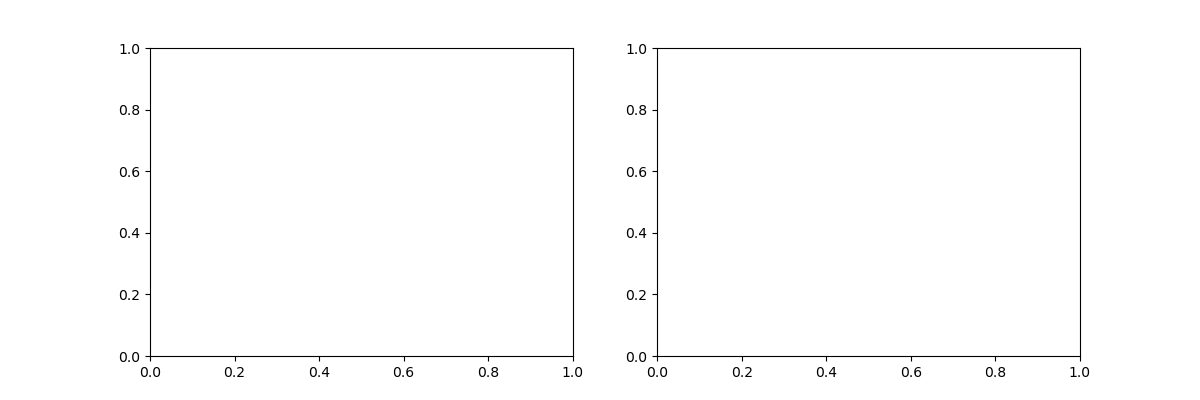

In [154]:
if "stats_fig" in locals():
    plt.close(stats_fig)
plt.ion()
# stats_fig = plt.figure(figsize=[6, 4])
# stats_ax = stats_fig.gca()
stats_fig, stats_axes = plt.subplots(1, 2, figsize=[12, 4])

In [436]:
USE_SIMULATION = True

# Load desired data
trajectories_DATA = trajectories_SIMULATION if USE_SIMULATION else trajectories_STUDY
stats_ax = stats_axes[0 if USE_SIMULATION else 1]

stats_ax.clear()
stats_fig.subplots_adjust(left=0.2, right=0.95, bottom=0.2, top=0.8)#, wspace=0.26, hspace=0.2)

target_labels_map = lambda x: "Hits" if x.endswith("_hit") else "Contacts" if x.endswith("_contact") else "Misses" if x.endswith("_miss") else x
task_conditions_map = lambda x: f"{x.split('-level')[0].split('-')[-1].capitalize()} {x.split('-level')[-1]}" if "-level" in x else x

x = np.arange(len(trajectories_DATA.target_stats.columns))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

for _index, _row in trajectories_DATA.target_stats.iterrows():
    offset = width * multiplier
    rects = stats_ax.bar(x + offset, _row.values, width, label=task_conditions_map(_index))
    stats_ax.bar_label(rects, padding=3)
    multiplier += 1

stats_ax.set_xlabel("Target Events")
stats_ax.set_title(f"{'SIMULATION' if USE_SIMULATION else 'DATA'}\nTarget Hits and Misses Depend on Task Difficulty", size=16, pad=20)
stats_ax.set_xticks(x + width, trajectories_DATA.target_stats.columns.map(target_labels_map), size=14)
stats_ax.legend(loc='upper right') #, prop={'size': 14})

# stats_ax.autoscale(enable=True, axis='y', tight=False)
_ylim = stats_ax.get_ylim()
stats_ax.set_ylim(_ylim[0], _ylim[1] + 0.1*(_ylim[1]-_ylim[0]))
stats_fig.tight_layout()

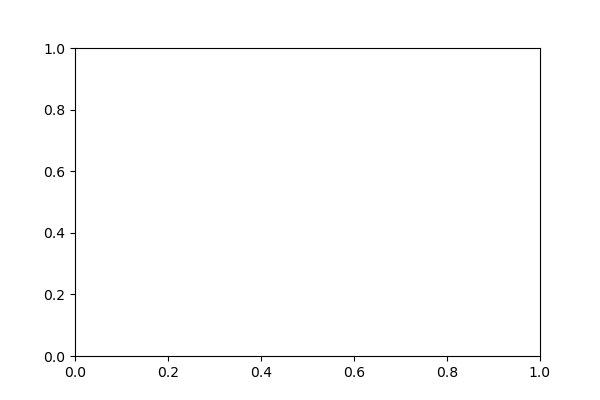

In [157]:
if "hitspeeds_fig" in locals():
    plt.close(hitspeeds_fig)
plt.ion()
hitspeeds_fig = plt.figure(figsize=[6, 4])
hitspeeds_ax = hitspeeds_fig.gca()
# hitspeeds_fig, hitspeeds_axes = plt.subplots(1, 2, figsize=[12, 4])

In [437]:
INCLUDE_SIMULATION = True

SPLIT_BY_CONDITION = False

VELOCITIES_FROM_EVENTS_CSV = False

hitspeeds_ax.clear()
hitspeeds_fig.subplots_adjust(left=0.2, right=0.95, bottom=0.2, top=0.8)#, wspace=0.26, hspace=0.2)

# sns.boxplot(trajectories_STUDY.hit_speeds, ax=hitspeeds_ax)
# sns.boxplot(pd.concat({"1": trajectories_STUDY.hit_speeds, "2": trajectories_STUDY.hit_speeds}, axis=1), ax=hitspeeds_ax)
_merged_hitspeeds_df = pd.concat({**({"SIMULATION": trajectories_SIMULATION.hit_speeds2 if VELOCITIES_FROM_EVENTS_CSV else trajectories_SIMULATION.hit_speeds} if INCLUDE_SIMULATION else {}), **{_t.USER_ID: _t.hit_speeds2 if VELOCITIES_FROM_EVENTS_CSV else _t.hit_speeds for _t in trajectories_USERS}}, axis=1).unstack(level=0).rename("Speed (m/s)").reset_index(level=[0, 1]).rename({"level_0": "User", "level_1": "Condition"}, axis=1)
sns.boxplot(y="Speed (m/s)", x="User", hue="Condition" if SPLIT_BY_CONDITION else None, data=_merged_hitspeeds_df, ax=hitspeeds_ax)
hitspeeds_ax.set_title(f"Hitting Speeds Differ Between Users\n({'events.csv' if VELOCITIES_FROM_EVENTS_CSV else 'states.csv'})", size=16, pad=20)
hitspeeds_ax.tick_params(labelsize=14)

hitspeeds_fig.tight_layout()

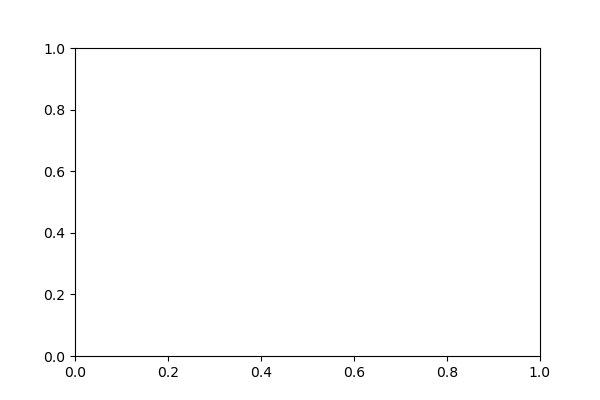

In [292]:
if "depthdistance_fig" in locals():
    plt.close(depthdistance_fig)
plt.ion()
depthdistance_fig = plt.figure(figsize=[6, 4])
depthdistance_ax = depthdistance_fig.gca()
# depthdistance_fig, depthdistance_ax = plt.subplots(1, 2, figsize=[9, 3])

In [438]:
INCLUDE_SIMULATION = True

SPLIT_BY_CONDITION = False

depthdistance_ax.clear()
depthdistance_fig.subplots_adjust(left=0.2, right=0.95, bottom=0.2, top=0.8)#, wspace=0.26, hspace=0.2)

_merged_depthdistance_df = pd.concat({**({"SIMULATION": trajectories_SIMULATION.depth_distance} if INCLUDE_SIMULATION else {}), **{_t.USER_ID: _t.depth_distance for _t in trajectories_USERS}}, axis=1).unstack(level=0).rename("Distance (m)").reset_index(level=[0, 1]).rename({"level_0": "User", "level_1": "Condition"}, axis=1)
sns.boxplot(y="Distance (m)", x="User", hue="Condition" if SPLIT_BY_CONDITION else None, data=_merged_depthdistance_df, ax=depthdistance_ax)
depthdistance_ax.set_title("Depth Distance Between Controller and\nTarget Plane During Movement", size=16, pad=20)
depthdistance_ax.tick_params(labelsize=14)

depthdistance_fig.tight_layout()

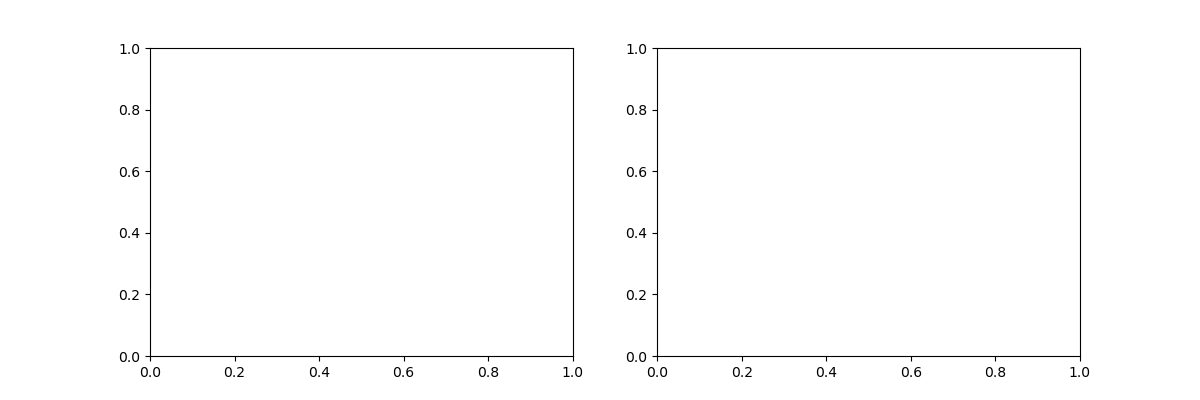

In [391]:
if "offset_trajectories_fig" in locals():
    plt.close(offset_trajectories_fig)
plt.ion()
# offset_trajectories_fig = plt.figure(figsize=[6, 4])
# offset_trajectories_ax = offset_trajectories_fig.gca()
offset_trajectories_fig, offset_trajectories_axes = plt.subplots(1, 2, figsize=[12, 4])

In [476]:
USE_SIMULATION = True
for USE_SIMULATION in (True, False):
    USE_VIRTUAL_ENDEFFECTOR = True

    PROJECTION_AXIS = "y"  #None
    NORMALIZE_TIME = True

    TASK_CONDITION = None #"level1"  #None

    COLORMAP = "turbo"
    COLORMAP_OFFSET = 2

    # Load desired data
    trajectories_DATA = trajectories_SIMULATION if USE_SIMULATION else trajectories_STUDY
    offset_trajectories_ax = offset_trajectories_axes[0 if USE_SIMULATION else 1]

    offset_trajectories_ax.clear()

    projection_axes_map = lambda xyz: "Horizontal" if xyz=="x" else "Vertical" if xyz=="y" else "Depth" if xyz=="z" else xyz
    _task_conditions = np.array(sorted(trajectories_DATA.data["RUN_ID_INFO"].drop_duplicates(), key=trajectories_DATA.task_conditions_map))
    if PROJECTION_AXIS is not None:
        _offsets_complete = (trajectories_DATA.data[f"target_{PROJECTION_AXIS}"] - trajectories_DATA.data[f"marker_pos_{PROJECTION_AXIS}" if USE_VIRTUAL_ENDEFFECTOR else f"right_pos_{PROJECTION_AXIS}"])
    else:
        _offsets_complete = pd.concat((trajectories_DATA.data[f"target_{xyz}"] - trajectories_DATA.data[f"marker_pos_{xyz}" if USE_VIRTUAL_ENDEFFECTOR else f"right_pos_{xyz}"] for xyz in ("x", "y", "z")), axis=1).apply(np.linalg.norm, axis=1)

    for _trial_idx in range(trajectories_DATA._submovtimes.shape[0]):
        _task_condition_mask = trajectories_DATA.data["RUN_ID"] == trajectories_DATA._submovtimes[_trial_idx, 4][0]
        _offsets = _offsets_complete.loc[_task_condition_mask].loc[trajectories_DATA._submovtimes[_trial_idx,0]:trajectories_DATA._submovtimes[_trial_idx,1]]

        _task_condition = trajectories_DATA.data.loc[_task_condition_mask, "RUN_ID_INFO"].loc[trajectories_DATA._submovtimes[_trial_idx,0]:trajectories_DATA._submovtimes[_trial_idx,1]]
        assert _task_condition.drop_duplicates().shape[0] == 1
        _task_condition = _task_condition.drop_duplicates().item()
        if TASK_CONDITION is not None and TASK_CONDITION not in _task_condition:
            continue

        # Normalize timestamps within a movement to unit interval
        _offsets.index -= _offsets.index[0]
        if NORMALIZE_TIME:
            _offsets.index /= _offsets.index[-1]

        offset_trajectories_ax.plot(_offsets, color=matplotlib.colormaps[COLORMAP]((COLORMAP_OFFSET + np.where(_task_conditions == _task_condition)[0][0])/(COLORMAP_OFFSET + len(_task_conditions) + 3)), label=trajectories_DATA.task_conditions_map(_task_condition))

    offset_trajectories_ax.set_xlabel(f"Movement time {'[normalized]' if NORMALIZE_TIME else '(s)'}")
    offset_trajectories_ax.set_ylabel(f"{projection_axes_map(PROJECTION_AXIS) + ' Offset' if PROJECTION_AXIS is not None else 'Distance'} (m)")
    offset_trajectories_ax.set_title(f"{'SIMULATION' if USE_SIMULATION else 'DATA'}\n{projection_axes_map(PROJECTION_AXIS) + ' Offset' if PROJECTION_AXIS is not None else 'Distance'} Between Controller and\nTarget During Movement", size=16, pad=20)
    offset_trajectories_ax.tick_params(labelsize=14)

    handles, labels = offset_trajectories_ax.get_legend_handles_labels()
    by_label = dict(sorted(dict(zip(labels, handles)).items()))
    offset_trajectories_ax.legend(by_label.values(), by_label.keys())

    offset_trajectories_fig.tight_layout()

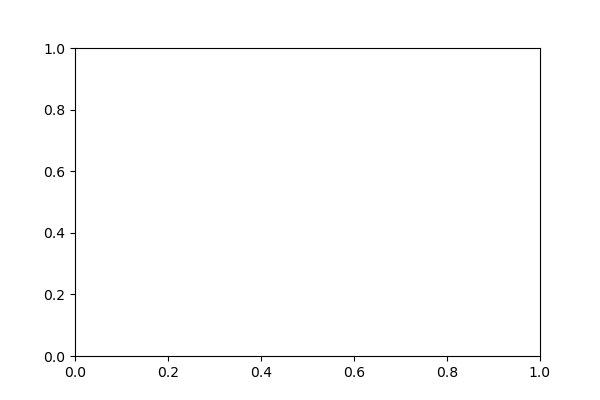

In [396]:
if "avg_offset_trajectories_fig" in locals():
    plt.close(avg_offset_trajectories_fig)
plt.ion()
avg_offset_trajectories_fig = plt.figure(figsize=[6, 4])
avg_offset_trajectories_ax = avg_offset_trajectories_fig.gca()
# avg_offset_trajectories_fig, avg_offset_trajectories_ax = plt.subplots(1, 2, figsize=[9, 3])

In [479]:
avg_offset_trajectories_ax.clear()

USE_VIRTUAL_ENDEFFECTOR = True

PROJECTION_AXIS = "z"  #None
OFFSET_TO_PREVIOUS_TARGET = True  #whether to compute offsets relative to previous instead of current targets (might be reasonable, as we compute averages of all trajectories starting in the same target)
NORMALIZE_TIME = True

TASK_CONDITION = "level1"  #"17-11-49-difficulty-level3" 

COLORMAP = "turbo"
COLORMAP_OFFSET = 2

projection_axes_map = lambda xyz: "Horizontal" if xyz=="x" else "Vertical" if xyz=="y" else "Depth" if xyz=="z" else xyz
for trajectories_DATA in [trajectories_SIMULATION] + trajectories_USERS:
    #_task_conditions = np.array(sorted(trajectories_DATA.data["RUN_ID_INFO"].drop_duplicates(), key=trajectories_DATA.task_conditions_map))
    if PROJECTION_AXIS is not None:
        _offsets_complete = (trajectories_DATA.data[f"target_{PROJECTION_AXIS}"] - trajectories_DATA.data[f"marker_pos_{PROJECTION_AXIS}" if USE_VIRTUAL_ENDEFFECTOR else f"right_pos_{PROJECTION_AXIS}"])
    else:
        _offsets_complete = pd.concat((trajectories_DATA.data[f"target_{xyz}"] - trajectories_DATA.data[f"marker_pos_{xyz}" if USE_VIRTUAL_ENDEFFECTOR else f"right_pos_{xyz}"] for xyz in ("x", "y", "z")), axis=1).apply(np.linalg.norm, axis=1)

    for _run_id in np.unique(trajectories_DATA.data["RUN_ID"]):
        _selected_submovtimes_0 = trajectories_DATA._submovtimes[(np.array([_idx[0] for _idx in trajectories_DATA._submovtimes[:, 4]]) == _run_id)]
        _task_condition_mask = trajectories_DATA.data["RUN_ID"] == _run_id
        
        _task_condition = trajectories_DATA.data.loc[_task_condition_mask, "RUN_ID_INFO"]#.loc[_selected_submovtimes_0[_trial_idx,0]:_selected_submovtimes_0[_trial_idx,1]]
        assert _task_condition.drop_duplicates().shape[0] == 1
        _task_condition = _task_condition.drop_duplicates().item()
        if TASK_CONDITION is not None and TASK_CONDITION not in _task_condition:
            continue
        
        for _init_grid_id in np.unique(_selected_submovtimes_0[:, 2]):
            _selected_submovtimes = _selected_submovtimes_0[(_selected_submovtimes_0[:, 2] == _init_grid_id)]
            _offsets_combined = pd.DataFrame()
            for _trial_idx in range(_selected_submovtimes.shape[0]):
                if OFFSET_TO_PREVIOUS_TARGET:
                    _previous_target_pos_global = trajectories_DATA._target_info.loc[trajectories_DATA._target_info["RUN_ID"] == _run_id].loc[np.unique(_selected_submovtimes[:, 2]).item(), ["global_x", "global_y", "global_z"]]
                    _trajectory_selected = trajectories_DATA.data.loc[_task_condition_mask].loc[_selected_submovtimes[_trial_idx,0]:_selected_submovtimes[_trial_idx,1]]
                    if PROJECTION_AXIS is not None:
                        _offsets = (_previous_target_pos_global[f"global_{PROJECTION_AXIS}"] - _trajectory_selected[f"marker_pos_{PROJECTION_AXIS}" if USE_VIRTUAL_ENDEFFECTOR else f"right_pos_{PROJECTION_AXIS}"])
                    else:
                        _offsets = pd.concat((_previous_target_pos_global[f"global_{xyz}"] - _trajectory_selected[f"marker_pos_{xyz}" if USE_VIRTUAL_ENDEFFECTOR else f"right_pos_{xyz}"] for xyz in ("x", "y", "z")), axis=1).apply(np.linalg.norm, axis=1)
                else:
                    _offsets = _offsets_complete.loc[_task_condition_mask].loc[_selected_submovtimes[_trial_idx,0]:_selected_submovtimes[_trial_idx,1]]

                # Normalize timestamps within a movement to unit interval
                _offsets.index -= _offsets.index[0]
                if NORMALIZE_TIME:
                    _offsets.index /= _offsets.index[-1]
                
                _offsets = _offsets[_offsets.index.notnull()]

                #avg_offset_trajectories_ax.plot(_offsets, color=matplotlib.colormaps[COLORMAP]((COLORMAP_OFFSET + isinstance(trajectories_DATA, TrajectoryData_Sim2VR_STUDY) + _init_grid_id)/(COLORMAP_OFFSET + 2 + len(np.unique(_selected_submovtimes_0[:, 2])))), label="DATA" if isinstance(trajectories_DATA, TrajectoryData_Sim2VR_STUDY) else "SIMULATION")
                
                # combine trajectories and take average
                _offsets_combined_hlp = pd.concat((_offsets_combined, _offsets), axis=1).interpolate('index')#.reindex(_offsets_combined)
                if len(_offsets_combined) > 0:
                    _offsets_combined = _offsets_combined_hlp.reindex(_offsets_combined.index)
                else:
                    _offsets_combined = _offsets_combined_hlp
            average_offsets_trajectory = _offsets_combined.groupby(level=0,axis=1).mean()
            
            # for _, i in _offsets_combined.items():
            #     avg_offset_trajectories_ax.plot(i, color=matplotlib.colormaps[COLORMAP]((COLORMAP_OFFSET + isinstance(trajectories_DATA, TrajectoryData_Sim2VR_STUDY) + _init_grid_id)/(COLORMAP_OFFSET + 2 + len(np.unique(_selected_submovtimes_0[:, 2])))), label="DATA" if isinstance(trajectories_DATA, TrajectoryData_Sim2VR_STUDY) else "SIMULATION")
            avg_offset_trajectories_ax.plot(average_offsets_trajectory, color=matplotlib.colormaps[COLORMAP]((COLORMAP_OFFSET + (trajectories_DATA.__class__.__name__=="TrajectoryData_Sim2VR_STUDY"))/(COLORMAP_OFFSET + 2)), label="DATA" if trajectories_DATA.__class__.__name__=="TrajectoryData_Sim2VR_STUDY" else "SIMULATION")

avg_offset_trajectories_ax.set_xlabel(f"Movement time {'[normalized]' if NORMALIZE_TIME else '(s)'}")
avg_offset_trajectories_ax.set_ylabel(f"{projection_axes_map(PROJECTION_AXIS) + ' Offset' if PROJECTION_AXIS is not None else 'Distance'} (m)")
avg_offset_trajectories_ax.set_title(f"Average {projection_axes_map(PROJECTION_AXIS) + ' Offset' if PROJECTION_AXIS is not None else 'Distance'} Between Controller and\n{'Previous ' if OFFSET_TO_PREVIOUS_TARGET else ''}Target During Movement", size=16, pad=20)
avg_offset_trajectories_ax.tick_params(labelsize=14)

handles, labels = avg_offset_trajectories_ax.get_legend_handles_labels()
by_label = dict(sorted(dict(zip(labels, handles)).items()))
avg_offset_trajectories_ax.legend(by_label.values(), by_label.keys())

avg_offset_trajectories_fig.tight_layout()

In [400]:
_trajectory_selected["marker_pos_y"]

timestamp
144.7348    0.967778
144.7490    0.923271
144.7628    0.890108
144.7768    0.871326
144.7907    0.866904
144.8046    0.863061
144.8186    0.859063
144.8325    0.858919
144.8464    0.864321
144.8605    0.872760
144.8745    0.880635
144.8882    0.887759
144.9022    0.896675
144.9162    0.907357
144.9300    0.921586
144.9440    0.938770
144.9579    0.955319
144.9719    0.975591
144.9860    0.999667
144.9997    1.021313
145.0137    1.039577
145.0276    1.058445
145.0416    1.080317
145.0554    1.098831
145.0694    1.113355
145.0833    1.126104
145.0971    1.140342
145.1109    1.153222
145.1247    1.164633
145.1387    1.175861
145.1527    1.186077
145.1665    1.194838
145.1805    1.201916
145.1943    1.208076
145.2083    1.212693
145.2222    1.215902
145.2361    1.217858
145.2499    1.218569
145.2638    1.218242
145.2780    1.214654
145.2917    1.210465
145.3055    1.203769
145.3195    1.194001
145.3334    1.178813
145.3474    1.157721
145.3613    1.131444
145.3754    1.100400
145

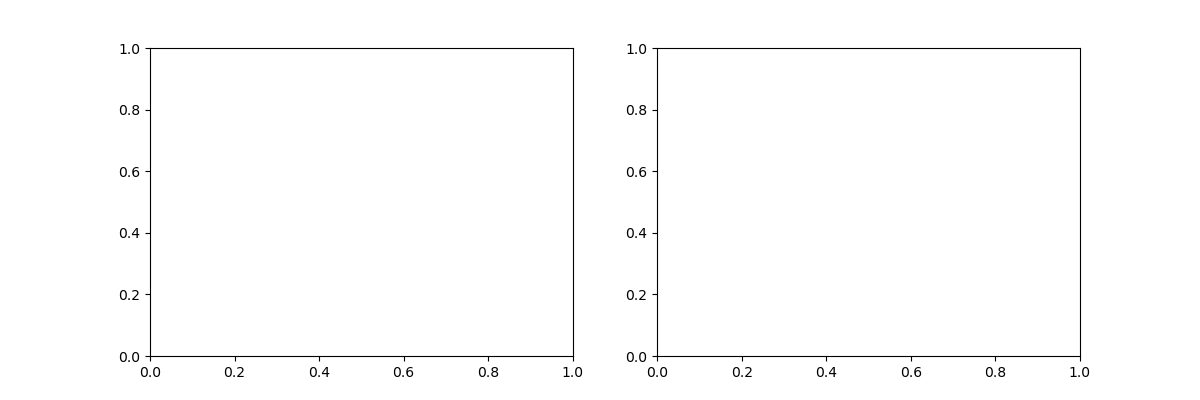

In [420]:
if "trajectories_2D_fig" in locals():
    plt.close(trajectories_2D_fig)
plt.ion()
# trajectories_2D_fig = plt.figure(figsize=[6, 4])
# trajectories_2D_ax = trajectories_2D_fig.gca()
trajectories_2D_fig, trajectories_2D_axes = plt.subplots(1, 2, figsize=[12, 4])

In [480]:
USE_SIMULATION = False

USE_VIRTUAL_ENDEFFECTOR = True

TASK_CONDITION = "level1"  #"17-05-08-difficulty-level2"  #"17-11-49-difficulty-level3"
INIT_GRID_IDs = None #[2]
FINAL_GRID_IDs = None #[4]
MAX_NUMBER_LINES = np.inf  #np.inf

END_SEGMENTS_ONLY = False  #for debugging

PROJECTION_AXES = "xy"

COLORMAP = "turbo"
COLORMAP_OFFSET = 1

# Load desired data
trajectories_DATA = trajectories_SIMULATION if USE_SIMULATION else trajectories_STUDY
trajectories_2D_ax = trajectories_2D_axes[0 if USE_SIMULATION else 1]

trajectories_2D_ax.clear()

# Plot targets
_targets_local = trajectories_DATA._target_info[["local_x", "local_y"]].drop_duplicates()
trajectories_2D_ax.scatter(-1*_targets_local["local_x"], _targets_local["local_y"], color=matplotlib.colormaps["Set1"](_targets_local.index), s=1000)

projection_axes_map = lambda xyz: "Horizontal" if xyz=="x" else "Vertical" if xyz=="y" else "Depth" if xyz=="z" else xyz
_task_conditions = trajectories_DATA.data["RUN_ID_INFO"].drop_duplicates()
if PROJECTION_AXES == "xy":
    _trajectories_complete = trajectories_DATA.data[[f"marker_pos_{xy}" if USE_VIRTUAL_ENDEFFECTOR else f"right_pos_{xy}" for xy in ("x", "y")]]
else:
    raise NotImplementedError

_nlines = 0
for _trial_idx in range(trajectories_DATA._submovtimes.shape[0]):        
    _task_condition_mask = trajectories_DATA.data["RUN_ID"] == trajectories_DATA._submovtimes[_trial_idx, 4][0]
    
    _task_condition = trajectories_DATA.data.loc[_task_condition_mask, "RUN_ID_INFO"].loc[trajectories_DATA._submovtimes[_trial_idx,0]:trajectories_DATA._submovtimes[_trial_idx,1]]
    assert _task_condition.drop_duplicates().shape[0] == 1
    _task_condition = _task_condition.drop_duplicates().item()
    if TASK_CONDITION is not None and TASK_CONDITION not in _task_condition:
        continue
    if INIT_GRID_IDs is not None and trajectories_DATA._submovtimes[_trial_idx, 2] not in INIT_GRID_IDs: 
        continue
    if FINAL_GRID_IDs is not None and trajectories_DATA._submovtimes[_trial_idx, 3] not in FINAL_GRID_IDs: 
        continue
        
    _trajectories = _trajectories_complete.loc[_task_condition_mask].loc[trajectories_DATA._submovtimes[_trial_idx,0]:trajectories_DATA._submovtimes[_trial_idx,1]]
    
    # Map movement trajectories from global to local coordinates
    _target_local_global = trajectories_DATA._target_info.loc[trajectories_DATA._target_info["RUN_ID_INFO"] == _task_condition, ["local_x", "local_y", "global_x", "global_y"]].loc[trajectories_DATA._submovtimes[_trial_idx, 3]]
    _trajectories -= _target_local_global[["global_x", "global_y"]].values
    _trajectories += _target_local_global[["local_x", "local_y"]].values
    _trajectories *= np.array([-1, 1])
    
    # Normalize timestamps within a movement to unit interval
    _trajectories.index -= _trajectories.index[0]
    _trajectories.index /= _trajectories.index[-1]
    assert _trajectories.index[-1] == 1.0 or np.isnan(_trajectories.index[-1]), _trajectories
    
    # Plot multicolor lines
    xy = _trajectories.values.reshape(-1, 1, 2)
    segments = np.hstack([xy[:-1], xy[1:]])
    previous_target_color = matplotlib.colormaps["Set1"](trajectories_DATA._submovtimes[_trial_idx, 2])
    current_target_color = matplotlib.colormaps["Set1"](trajectories_DATA._submovtimes[_trial_idx, 3])
    if END_SEGMENTS_ONLY:
        coll = matplotlib.collections.LineCollection(segments[-1:], colors=matplotlib.colors.LinearSegmentedColormap.from_list(
            "Custom", [previous_target_color, current_target_color], N=200)(_trajectories.index[-1]))
    else:
        coll = matplotlib.collections.LineCollection(segments, colors=matplotlib.colors.LinearSegmentedColormap.from_list(
            "Custom", [previous_target_color, current_target_color], N=200)(_trajectories.index))
    trajectories_2D_ax.add_collection(coll)
    trajectories_2D_ax.autoscale_view()

    _nlines += 1
    if _nlines == MAX_NUMBER_LINES:
        break

if PROJECTION_AXES == "xy":
    trajectories_2D_ax.set_xlabel("Horizontal Movements (-x-Axis)")
    trajectories_2D_ax.set_ylabel("Vertical Movements (y-Axis)")
else:
    raise NotImplementedError
trajectories_2D_ax.set_title(f"{'SIMULATION' if USE_SIMULATION else 'DATA'}\nMovements in Target Plane", size=16, pad=20)
trajectories_2D_ax.tick_params(labelsize=14)

# trajectories_2D_ax.set_xlim(-0.2, 0.2)
# trajectories_2D_ax.set_ylim(-0.4, 0.2)

trajectories_2D_fig.tight_layout()

In [16159]:
trajectories_DATA._submovtimes[_trial_idx, :]

array([59.39919, 59.69918, 5, 2, (1, 159)], dtype=object)

In [16158]:
trajectories_DATA.data.loc[_task_condition_mask].loc[trajectories_DATA._submovtimes[_trial_idx,0]:trajectories_DATA._submovtimes[_trial_idx,1]]

,RUN_ID,left_pos_x,left_pos_y,left_pos_z,left_quat_x,left_quat_y,left_quat_z,left_quat_w,right_pos_x,right_pos_y,...,right_acc_y,right_acc_z,head_acc_x,head_acc_y,head_acc_z,RUN_ID_INFO,target_ID,target_x,target_y,target_z
timestamp,,,,,,,,,,,,,,,,,,,,,
59.39919,1,0,0,0,0,0,0,1,0.176161,1.009562,...,0.754370,0.365785,0.001220,0.000914,0.000188,17-05-08-difficulty-level2,2,0.226594,1.19492,0.563642
59.44918,1,0,0,0,0,0,0,1,0.159602,1.089777,...,1.144311,-0.317670,-0.001126,0.000064,-0.001583,17-05-08-difficulty-level2,2,0.226594,1.19492,0.563642
59.49919,1,0,0,0,0,0,0,1,0.130503,1.209188,...,1.107322,-1.183762,-0.004026,-0.001193,-0.003511,17-05-08-difficulty-level2,2,0.226594,1.19492,0.563642
59.54919,1,0,0,0,0,0,0,1,0.127091,1.258183,...,0.873441,-1.465370,-0.007480,-0.003195,-0.005174,17-05-08-difficulty-level2,2,0.226594,1.19492,0.563642
59.59919,1,0,0,0,0,0,0,1,0.126909,1.262311,...,0.276268,-0.953466,-0.001654,0.000112,-0.001698,17-05-08-difficulty-level2,2,0.226594,1.19492,0.563642
59.64919,1,0,0,0,0,0,0,1,0.114926,1.264945,...,-0.810633,0.197545,-0.000300,-0.000084,-0.000115,17-05-08-difficulty-level2,2,0.226594,1.19492,0.563642
59.69918,1,0,0,0,0,0,0,1,0.123038,1.220522,...,-1.920733,1.362836,-0.000055,-0.001033,0.001229,17-05-08-difficulty-level2,2,0.226594,1.19492,0.563642


### Quantitative Comparisons

In [544]:
### RUN QUANTITATIVE COMPARISONS BETWEEN TWO DATASETS
class QuantitativeComparison(object):
    
    def __init__(self, trajectories1, trajectories2):
        self.trajectories1 = trajectories1  #TrajectoryData instance
        self.trajectories2 = trajectories2  #TrajectoryData instance
    
    def compare(self, data_name1, data_name2=None, cols=None, metric="RMSE", mean_axis=None):
        #WARNING: "data_name1" and "data_name2" need to correspond to some "_trial" (or "_mean") attribute!
        #INFO: "cols" should be array-like, consisting of column indices to take into account; if "None", all data columns are used.
        #INFO: "mean_axis" is used as "axis" argument of np.mean(), i.e., "None" corresponds to mean of flattened array, and "0" corresponds to mean along time axis for each data column.
        
        if data_name2 is None:
            data_name2 = data_name1
        assert isinstance(data_name1, str) and isinstance(data_name2, str)  #data_name1 and data_name2 should be strings corresponding to the attributes of trajectories1 and trajectories2, respectively, that should be compared
            
        data1 = getattr(self.trajectories1, data_name1)
        data2 = getattr(self.trajectories2, data_name2)
        
        if cols is not None:
            data1 = data1[..., cols]
            data2 = data2[..., cols]
        
        if len(data1) != len(data2):
            assert hasattr(self.trajectories1, "time_series_trial") and hasattr(self.trajectories2, "time_series_trial")
            #input((self.trajectories1.time_series_trial, self.trajectories2.time_series_trial))
            if any([i != j for i,j in zip(self.trajectories1.time_series_trial, self.trajectories2.time_series_trial)]):
                logging.warning(f"Time series do not match. Interpolate second dataset at time series of first dataset.")
                #data2 = np.interp(self.trajectories1.time_series_trial, self.trajectories2.time_series_trial, data2)
                data2_f = interp1d(self.trajectories2.time_series_trial, data2, axis=0, fill_value="extrapolate")
                data2 = data2_f(self.trajectories1.time_series_trial)
            else:
                logging.warning(f"Ignore overhanging last {max(len(data1), len(data2)) - min(len(data1), len(data2))} timesteps.")
        
        if metric == "RMSE":
            #WARNING: if data1 and data2 are multi-dimensional, np.mean() takes mean along all dimensions!
            res = np.sqrt(np.mean([(j-i)**2 for i,j in zip(data1, data2)], axis=mean_axis))
        elif metric == "initial_distance":
            res = np.mean([np.abs(data1[0] - data2[0])], axis=mean_axis)
        else:
            raise NotImplementedError
            
        return res
    
    def compare_all_trials(self, data_name1, data_name2=None, ignore_unpaired_trials=False, effective_projection_path=False, targetbound_as_target=False, **kwargs):
        
        # INFO: "ignore_unpaired_trials" can be used even if self.trajectories1.indices and self.trajectories2.indices are not of the same form (e.g., for comparison between RL and STUDY data)
        if ignore_unpaired_trials and (len(self.trajectories1.selected_movements_indices) != len(self.trajectories2.selected_movements_indices)):  #remove indices only available in data_name1
            logging.warning(f"Indices do not match. Remove redundant trials from first dataset.")
            assert len(self.trajectories1.selected_movements_indices) >= len(self.trajectories2.selected_movements_indices), f"{len(self.trajectories2.selected_movements_indices) - len(self.trajectories1.selected_movements_indices)} trials are missing in simulation!."
            assert len(self.trajectories1.indices) == len(self.trajectories1.selected_movements_indices), f"ERROR: 'indices' and 'selected_movements_indices' do not have the same length!"
            self.trajectories1._indices = self.trajectories1.indices[[i in self.trajectories2.indices[:, 4] for i in self.trajectories1.indices[:, 4]]]
            self.trajectories1.selected_movements_indices = [trajectories_SIMULATION.selected_movements_indices[meta_idx] for meta_idx, i in enumerate(trajectories_SIMULATION.indices[:, 4]) if i in trajectories_STUDY.indices[:, 4]]#.shape
                
        assert len(self.trajectories1.selected_movements_indices) == len(self.trajectories2.selected_movements_indices), f"Number of considered trials does not match between the two datasets ({len(self.trajectories1.selected_movements_indices)} vs. {len(self.trajectories2.selected_movements_indices)})."
        #assert np.all(self.trajectories1.indices[:, 2:] == self.trajectories2.indices[:, 2:]), "Indices do not match between the two datasets."
        
        res_all_trials = []
        for trial_index_current in range(len(self.trajectories1.selected_movements_indices)):
            self.trajectories1.compute_trial(trial_index_current, effective_projection_path=effective_projection_path, targetbound_as_target=targetbound_as_target)
            self.trajectories2.compute_trial(trial_index_current, effective_projection_path=effective_projection_path, targetbound_as_target=targetbound_as_target)
            res_all_trials.append(self.compare(data_name1, data_name2=data_name2, **kwargs))
        
        return res_all_trials

In [230]:
#####
#ALEKSI RL - RMSE COMPUTATIONS (SIM2FIXEDUSER vs. USER2FIXEDUSER vs. USER2FIXEDUSER vs. ... [for all other users])

USER_ID_LIST = [f"U{i}" for i in range (1,7)]

USER_ID_FIXED = "U1"

SIMULATION_SUBDIR_LIST = ["iso-pointing-U1-patch-v1-dwell-random/ISO"]
EPISODE_IDS = [7]

COMPARISON_METRIC = "initial_distance"  #"RMSE"

logging.getLogger().setLevel(logging.ERROR)

start_time = time.time()

res_dict_predict_fixeduser_pos = {SIMULATION_SUBDIR: [] for SIMULATION_SUBDIR in SIMULATION_SUBDIR_LIST + [i for i in USER_ID_LIST if i != USER_ID_FIXED]}
res_dict_predict_fixeduser_vel = {SIMULATION_SUBDIR: [] for SIMULATION_SUBDIR in SIMULATION_SUBDIR_LIST + [i for i in USER_ID_LIST if i != USER_ID_FIXED]}
res_dict_predict_fixeduser_acc = {SIMULATION_SUBDIR: [] for SIMULATION_SUBDIR in SIMULATION_SUBDIR_LIST + [i for i in USER_ID_LIST if i != USER_ID_FIXED]}
res_dict_predict_fixeduser_qpos = {SIMULATION_SUBDIR: [] for SIMULATION_SUBDIR in SIMULATION_SUBDIR_LIST + [i for i in USER_ID_LIST if i != USER_ID_FIXED]}
res_dict_predict_fixeduser_qvel = {SIMULATION_SUBDIR: [] for SIMULATION_SUBDIR in SIMULATION_SUBDIR_LIST + [i for i in USER_ID_LIST if i != USER_ID_FIXED]}
res_dict_predict_fixeduser_qacc = {SIMULATION_SUBDIR: [] for SIMULATION_SUBDIR in SIMULATION_SUBDIR_LIST + [i for i in USER_ID_LIST if i != USER_ID_FIXED]}

trajectories_STUDIES = {}
for USER_ID in USER_ID_LIST:    
    # Preprocess simulation trajectories (ISO Task User Study):
    trajectories_STUDIES[USER_ID] = TrajectoryData_STUDY(USER_ID=USER_ID, independent_joints=independent_joints, actuator_names=actuator_names)
    trajectories_STUDIES[USER_ID].preprocess()
    # Use all available trials
    trajectories_STUDIES[USER_ID].compute_indices(TARGET_IDS=None, TRIAL_IDS=None, META_IDS=None, N_MOVS=None, AGGREGATION_VARS=[])

# Only use trials that are valid for all users
unique, counts = np.unique(np.concatenate([trajectories_STUDIES[USER_ID].indices[:, 4] for USER_ID in USER_ID_LIST]), return_counts=True)
trial_idx_list = unique[counts == len(USER_ID_LIST)]

#restrict user trials to the number of simulated trials
trial_idx_list = trial_idx_list[trial_idx_list <= 13]

for SIMULATION_SUBDIR in SIMULATION_SUBDIR_LIST:
    trajectories_SIMULATION = TrajectoryData_RL(SIMULATION_SUBDIR)
    
    trajectories_SIMULATION.preprocess(EPISODE_IDS=EPISODE_IDS)
    
    # Use trials that are valid for all users
    trajectories_SIMULATION.compute_indices(TARGET_IDS=None, TRIAL_IDS=trial_idx_list, META_IDS=None, N_MOVS=None, AGGREGATION_VARS=[])
    trajectories_STUDIES[USER_ID_FIXED].compute_indices(TRIAL_IDS=trial_idx_list, META_IDS=None, N_MOVS=None, AGGREGATION_VARS=[])

    sim_vs_study = QuantitativeComparison(trajectories_SIMULATION, trajectories_STUDIES[USER_ID_FIXED])
    try:
        res_pos = sim_vs_study.compare_all_trials("position_series_trial", cols=None, metric=COMPARISON_METRIC, mean_axis=None, ignore_unpaired_trials=False)
        res_vel = sim_vs_study.compare_all_trials("velocity_series_trial", cols=None, metric=COMPARISON_METRIC, mean_axis=None, ignore_unpaired_trials=False)
        res_acc = sim_vs_study.compare_all_trials("acceleration_series_trial", cols=None, metric=COMPARISON_METRIC, mean_axis=None, ignore_unpaired_trials=False)
        res_qpos = sim_vs_study.compare_all_trials("qpos_series_trial", cols=None, metric=COMPARISON_METRIC, mean_axis=None, ignore_unpaired_trials=False)
        res_qvel = sim_vs_study.compare_all_trials("qvel_series_trial", cols=None, metric=COMPARISON_METRIC, mean_axis=None, ignore_unpaired_trials=False)
        res_qacc = sim_vs_study.compare_all_trials("qacc_series_trial", cols=None, metric=COMPARISON_METRIC, mean_axis=None, ignore_unpaired_trials=False)
    except ValueError as e:
        print((f"{USER_ID}, {TASK_CONDITION}, {SIMULATION_SUBDIR}: {e}"))
        print("Will ignore this sub-dataset and continue...")

    res_dict_predict_fixeduser_pos[SIMULATION_SUBDIR].append(res_pos)
    res_dict_predict_fixeduser_vel[SIMULATION_SUBDIR].append(res_vel)
    res_dict_predict_fixeduser_acc[SIMULATION_SUBDIR].append(res_acc)
    res_dict_predict_fixeduser_qpos[SIMULATION_SUBDIR].append(res_qpos)
    res_dict_predict_fixeduser_qvel[SIMULATION_SUBDIR].append(res_qvel)
    res_dict_predict_fixeduser_qacc[SIMULATION_SUBDIR].append(res_qacc)

for USER_ID in [i for i in USER_ID_LIST if i != USER_ID_FIXED]:
    trajectories_STUDIES[USER_ID].compute_indices(TARGET_IDS=None, TRIAL_IDS=trial_idx_list, META_IDS=None, N_MOVS=None, AGGREGATION_VARS=[])
    sim_vs_study = QuantitativeComparison(trajectories_STUDIES[USER_ID], trajectories_STUDIES[USER_ID_FIXED])
    try:
        res_pos = sim_vs_study.compare_all_trials("position_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=False)
        res_vel = sim_vs_study.compare_all_trials("velocity_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=False)
        res_acc = sim_vs_study.compare_all_trials("acceleration_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=False)
        res_qpos = sim_vs_study.compare_all_trials("qpos_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=False)
        res_qvel = sim_vs_study.compare_all_trials("qvel_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=False)
        res_qacc = sim_vs_study.compare_all_trials("qacc_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=False)

        res_dict_predict_fixeduser_pos[USER_ID].append(res_pos)
        res_dict_predict_fixeduser_vel[USER_ID].append(res_vel)
        res_dict_predict_fixeduser_acc[USER_ID].append(res_acc)
        res_dict_predict_fixeduser_qpos[USER_ID].append(res_qpos)
        res_dict_predict_fixeduser_qvel[USER_ID].append(res_qvel)
        res_dict_predict_fixeduser_qacc[USER_ID].append(res_qacc)
    except ValueError as e:
        print((f"{USER_ID}, {TASK_CONDITION}, {SIMULATION_SUBDIR}: {e}"))
        print("Will ignore this sub-dataset and continue...")

end_time = time.time()
logging.getLogger().setLevel(logging.INFO)

logging.info(f"RMSE computation took {end_time - start_time} seconds.")

#########################

PLOTTING_ENV_COMPARISON = "RL-UIB"

_plot_SIMULATION_SUBDIR_LIST = "__".join(SIMULATION_SUBDIR_LIST)
if not os.path.exists(f"/home/florian/reacher_sg/_plots/UIB/{_plot_SIMULATION_SUBDIR_LIST}/{USER_ID_FIXED}_FIXED/"):  #create plot (sub-)directories
    os.makedirs(f"/home/florian/reacher_sg/_plots/UIB/{_plot_SIMULATION_SUBDIR_LIST}/{USER_ID_FIXED}_FIXED/")

ERROR:root:Cannot load StaticOptimization Data (U5, Standing_ID_ISO_15_plane).


50 episodes identified.
1 movement sequences identified.
14 trials identified.


INFO:root:RMSE computation took 17.467695236206055 seconds.


In [453]:
#####
#MARKUS MPC - RMSE COMPUTATIONS

USER_ID_LIST = [f"U{i}" for i in range (1,7)]
SIMULATION_SUBDIR_LIST = ["fitts_btrzx1_tochi_neu_09032022_2021-10-25_N8_cso_sae_noise",
                    "fitts_btrzx1_tochi_neu_09032022_2021-10-25_ctc_N8_cso_sae_noise",
                    "fitts_btrzx1_tochi_neu_09032022_2021-10-25_accjoint_N8_cso_sae_noise"]

TASK_CONDITION_LIST = ["Standing_ID_ISO_15_plane", 
                       "Standing_Cursor_Handtuned_ISO_15_plane", "Standing_Pad_ID_ISO_15_plane",
                       "Standing_Pad_Handtuned_vertical_ISO_15_plane"]

logging.getLogger().setLevel(logging.ERROR)

start_time = time.time()

res_dict_pos = {SIMULATION_SUBDIR: [] for SIMULATION_SUBDIR in SIMULATION_SUBDIR_LIST}
res_dict_vel = {SIMULATION_SUBDIR: [] for SIMULATION_SUBDIR in SIMULATION_SUBDIR_LIST}
res_dict_acc = {SIMULATION_SUBDIR: [] for SIMULATION_SUBDIR in SIMULATION_SUBDIR_LIST}
res_dict_qpos = {SIMULATION_SUBDIR: [] for SIMULATION_SUBDIR in SIMULATION_SUBDIR_LIST}
res_dict_qvel = {SIMULATION_SUBDIR: [] for SIMULATION_SUBDIR in SIMULATION_SUBDIR_LIST}
res_dict_qacc = {SIMULATION_SUBDIR: [] for SIMULATION_SUBDIR in SIMULATION_SUBDIR_LIST}

for USER_ID in USER_ID_LIST:
    for TASK_CONDITION in TASK_CONDITION_LIST:            
        # Preprocess simulation trajectories (ISO Task User Study):
        trajectories_STUDY = TrajectoryData_STUDY(USER_ID=USER_ID, TASK_CONDITION=TASK_CONDITION)
        trajectories_STUDY.preprocess()
        # Use all available trials
        trajectories_STUDY.compute_indices(TARGET_IDS=None, TRIAL_IDS=None, META_IDS=None, N_MOVS=None, AGGREGATION_VARS=[], ignore_trainingset_trials=True)
        
        for SIMULATION_SUBDIR in SIMULATION_SUBDIR_LIST:
            trajectories_SIMULATION = TrajectoryData_MPC(SIMULATION_SUBDIR, USER_ID=USER_ID, TASK_CONDITION=TASK_CONDITION)
            trajectories_SIMULATION.preprocess()
            # Use all available trials
            trajectories_SIMULATION.compute_indices(TARGET_IDS=None, TRIAL_IDS=None, META_IDS=None, N_MOVS=None, AGGREGATION_VARS=[], ignore_trainingset_trials=True)

            sim_vs_study = QuantitativeComparison(trajectories_SIMULATION, trajectories_STUDY)
            #sim_vs_study.compare("projected_trajectories_pos_trial")
            
            try:
                res_pos = sim_vs_study.compare_all_trials("position_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=True)
                res_vel = sim_vs_study.compare_all_trials("velocity_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=True)
                res_acc = sim_vs_study.compare_all_trials("acceleration_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=True)
                res_qpos = sim_vs_study.compare_all_trials("qpos_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=True)
                res_qvel = sim_vs_study.compare_all_trials("qvel_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=True)
                res_qacc = sim_vs_study.compare_all_trials("qacc_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=True)
                        
                res_dict_pos[SIMULATION_SUBDIR].append(res_pos)
                res_dict_vel[SIMULATION_SUBDIR].append(res_vel)
                res_dict_acc[SIMULATION_SUBDIR].append(res_acc)
                res_dict_qpos[SIMULATION_SUBDIR].append(res_qpos)
                res_dict_qvel[SIMULATION_SUBDIR].append(res_qvel)
                res_dict_qacc[SIMULATION_SUBDIR].append(res_qacc)
            except AssertionError as e:
                print((f"{USER_ID}, {TASK_CONDITION}, {SIMULATION_SUBDIR}: {e}"))
                print("Will ignore this sub-dataset and continue...")

end_time = time.time()
logging.getLogger().setLevel(logging.INFO)

logging.info(f"RMSE computation took {end_time - start_time} seconds.")

#########################

PLOTTING_ENV_COMPARISON = "MPC"

# common_simulation_subdir = "".join([i for i,j,k in zip(*SIMULATION_SUBDIR_LIST) if i==j==k])
# if common_simulation_subdir[-1] in ["-", "_"]:
#     common_simulation_subdir = common_simulation_subdir[:-1]
# _plot_SIMULATION_SUBDIR_LIST = common_simulation_subdir 
_plot_SIMULATION_SUBDIR_LIST = "__".join(SIMULATION_SUBDIR_LIST)
_plot_TASK_CONDITION_LIST = "__".join(TASK_CONDITION_LIST)
if not os.path.exists(f"/home/florian/reacher_sg/_plots/MPC/{_plot_SIMULATION_SUBDIR_LIST}/ALLUSERS/{_plot_TASK_CONDITION_LIST}/"):  #create plot (sub-)directories
    os.makedirs(f"/home/florian/reacher_sg/_plots/MPC/{_plot_SIMULATION_SUBDIR_LIST}/ALLUSERS/{_plot_TASK_CONDITION_LIST}/")

ERROR:root:STUDY (U1, Standing_ID_ISO_15_plane) - Ignore training set indices [31, 30, 29, 28, 27].
ERROR:root:MPC (U1, Standing_ID_ISO_15_plane, fitts_btrzx1_tochi_neu_09032022_2021-10-25_N8_cso_sae_noise) - Ignore training set indices [31, 30, 29, 28, 27].
ERROR:root:MPC (U1, Standing_ID_ISO_15_plane, fitts_btrzx1_tochi_neu_09032022_2021-10-25_ctc_N8_cso_sae_noise) - Ignore training set indices [31, 30, 29, 28, 27].
ERROR:root:MPC (U1, Standing_ID_ISO_15_plane, fitts_btrzx1_tochi_neu_09032022_2021-10-25_accjoint_N8_cso_sae_noise) - Ignore training set indices [31, 30, 29, 28, 27].
ERROR:root:Cannot load StaticOptimization Data (U1, Standing_Cursor_Handtuned_ISO_15_plane).
ERROR:root:STUDY (U1, Standing_Cursor_Handtuned_ISO_15_plane) - Ignore training set indices [31, 30, 29, 28, 27].
ERROR:root:MPC (U1, Standing_Cursor_Handtuned_ISO_15_plane, fitts_btrzx1_tochi_neu_09032022_2021-10-25_N8_cso_sae_noise) - Ignore training set indices [31, 30, 29, 28, 27].
ERROR:root:MPC (U1, Standing_C

In [248]:
#####
#MARKUS MPC - RMSE COMPUTATIONS (SIM2USER vs. USER2USER)

USER_ID_LIST = [f"U{i}" for i in range (1,7)]
SIMULATION_SUBDIR_LIST = [#"fitts_btrzx1_tochi_neu_09032022_2021-10-25_N8_cso_sae_noise",
                        #"fitts_btrzx1_tochi_neu_09032022_2021-10-25_ctc_N8_cso_sae_noise",
                        "fitts_btrzx1_tochi_neu_09032022_2021-10-25_accjoint_N8_cso_sae_noise"]


TASK_CONDITION_LIST = ["Standing_ID_ISO_15_plane", 
                      "Standing_Cursor_Handtuned_ISO_15_plane", 
                      "Standing_Pad_ID_ISO_15_plane",
                      "Standing_Pad_Handtuned_vertical_ISO_15_plane"
                      ]

logging.getLogger().setLevel(logging.ERROR)

start_time = time.time()

res_dict_predict_pos = {SIMULATION_SUBDIR: [] for SIMULATION_SUBDIR in SIMULATION_SUBDIR_LIST + ["User vs. User"]}
res_dict_predict_vel = {SIMULATION_SUBDIR: [] for SIMULATION_SUBDIR in SIMULATION_SUBDIR_LIST + ["User vs. User"]}
res_dict_predict_acc = {SIMULATION_SUBDIR: [] for SIMULATION_SUBDIR in SIMULATION_SUBDIR_LIST + ["User vs. User"]}
res_dict_predict_qpos = {SIMULATION_SUBDIR: [] for SIMULATION_SUBDIR in SIMULATION_SUBDIR_LIST + ["User vs. User"]}
res_dict_predict_qvel = {SIMULATION_SUBDIR: [] for SIMULATION_SUBDIR in SIMULATION_SUBDIR_LIST + ["User vs. User"]}
res_dict_predict_qacc = {SIMULATION_SUBDIR: [] for SIMULATION_SUBDIR in SIMULATION_SUBDIR_LIST + ["User vs. User"]}

for TASK_CONDITION in TASK_CONDITION_LIST:            
    trajectories_STUDIES = {}
    for USER_ID in USER_ID_LIST:    
        # Preprocess simulation trajectories (ISO Task User Study):
        trajectories_STUDIES[USER_ID] = TrajectoryData_STUDY(USER_ID=USER_ID, TASK_CONDITION=TASK_CONDITION)
        trajectories_STUDIES[USER_ID].preprocess()
        # Use all available trials
        trajectories_STUDIES[USER_ID].compute_indices(TARGET_IDS=None, TRIAL_IDS=None, META_IDS=None, N_MOVS=None, AGGREGATION_VARS=[], ignore_trainingset_trials=True)
        
    # Only use trials that are valid for all users
    unique, counts = np.unique(np.concatenate([trajectories_STUDIES[USER_ID].indices[:, 4] for USER_ID in USER_ID_LIST]), return_counts=True)
    trial_idx_list = unique[counts == len(USER_ID_LIST)]
    
    for USER_ID in USER_ID_LIST:
        for SIMULATION_SUBDIR in SIMULATION_SUBDIR_LIST:
            trajectories_SIMULATION = TrajectoryData_MPC(SIMULATION_SUBDIR, USER_ID=USER_ID, TASK_CONDITION=TASK_CONDITION)
            trajectories_SIMULATION.preprocess()
            # Use trials that are valid for all users
            trajectories_SIMULATION.compute_indices(TARGET_IDS=None, TRIAL_IDS=trial_idx_list, META_IDS=None, N_MOVS=None, AGGREGATION_VARS=[], ignore_trainingset_trials=True)
            trajectories_STUDIES[USER_ID].compute_indices(TARGET_IDS=None, TRIAL_IDS=trial_idx_list, META_IDS=None, N_MOVS=None, AGGREGATION_VARS=[], ignore_trainingset_trials=True)
            
            sim_vs_study = QuantitativeComparison(trajectories_SIMULATION, trajectories_STUDIES[USER_ID])
            try:
                res_pos = sim_vs_study.compare_all_trials("position_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=False)
                res_vel = sim_vs_study.compare_all_trials("velocity_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=False)
                res_acc = sim_vs_study.compare_all_trials("acceleration_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=False)
                res_qpos = sim_vs_study.compare_all_trials("qpos_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=False)
                res_qvel = sim_vs_study.compare_all_trials("qvel_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=False)
                res_qacc = sim_vs_study.compare_all_trials("qacc_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=False)
            except AssertionError as e:
                print((f"{USER_ID}, {TASK_CONDITION}, {SIMULATION_SUBDIR}: {e}"))
                print("Will ignore this sub-dataset and continue...")

            res_dict_predict_pos[SIMULATION_SUBDIR].append(res_pos)
            res_dict_predict_vel[SIMULATION_SUBDIR].append(res_vel)
            res_dict_predict_acc[SIMULATION_SUBDIR].append(res_acc)
            res_dict_predict_qpos[SIMULATION_SUBDIR].append(res_qpos)
            res_dict_predict_qvel[SIMULATION_SUBDIR].append(res_qvel)
            res_dict_predict_qacc[SIMULATION_SUBDIR].append(res_qacc)
    
    for USER_ID_1, USER_ID_2 in itertools.combinations(USER_ID_LIST, 2):
        sim_vs_study = QuantitativeComparison(trajectories_STUDIES[USER_ID_1], trajectories_STUDIES[USER_ID_2])
        try:
            res_pos = sim_vs_study.compare_all_trials("position_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=False)
            res_vel = sim_vs_study.compare_all_trials("velocity_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=False)
            res_acc = sim_vs_study.compare_all_trials("acceleration_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=False)
            res_qpos = sim_vs_study.compare_all_trials("qpos_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=False)
            res_qvel = sim_vs_study.compare_all_trials("qvel_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=False)
            res_qacc = sim_vs_study.compare_all_trials("qacc_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=False)
            
            res_dict_predict_pos["User vs. User"].append(res_pos)
            res_dict_predict_vel["User vs. User"].append(res_vel)
            res_dict_predict_acc["User vs. User"].append(res_acc)
            res_dict_predict_qpos["User vs. User"].append(res_qpos)
            res_dict_predict_qvel["User vs. User"].append(res_qvel)
            res_dict_predict_qacc["User vs. User"].append(res_qacc)
        except AssertionError as e:
            print((f"{USER_ID}, {TASK_CONDITION}, {SIMULATION_SUBDIR}: {e}"))
            print("Will ignore this sub-dataset and continue...")

end_time = time.time()
logging.getLogger().setLevel(logging.INFO)

logging.info(f"RMSE computation took {end_time - start_time} seconds.")

#########################

PLOTTING_ENV_COMPARISON = "MPC"

_plot_SIMULATION_SUBDIR_LIST = "__".join(SIMULATION_SUBDIR_LIST)
_plot_TASK_CONDITION_LIST = "__".join(TASK_CONDITION_LIST)
if not os.path.exists(f"/home/florian/reacher_sg/_plots/MPC/{_plot_SIMULATION_SUBDIR_LIST}/ALLUSERS/{_plot_TASK_CONDITION_LIST}/"):  #create plot (sub-)directories
    os.makedirs(f"/home/florian/reacher_sg/_plots/MPC/{_plot_SIMULATION_SUBDIR_LIST}/ALLUSERS/{_plot_TASK_CONDITION_LIST}/")

ERROR:root:Cannot load StaticOptimization Data (U5, Standing_ID_ISO_15_plane).
ERROR:root:Cannot load StaticOptimization Data (U1, Standing_Cursor_Handtuned_ISO_15_plane).
ERROR:root:Cannot load StaticOptimization Data (U4, Standing_Cursor_Handtuned_ISO_15_plane).
ERROR:root:Cannot load StaticOptimization Data (U5, Standing_Cursor_Handtuned_ISO_15_plane).
ERROR:root:Cannot load StaticOptimization Data (U5, Standing_Pad_ID_ISO_15_plane).
ERROR:root:Cannot load StaticOptimization Data (U1, Standing_Pad_Handtuned_vertical_ISO_15_plane).
INFO:root:RMSE computation took 104.20727443695068 seconds.


In [245]:
#####
#MARKUS MPC - RMSE COMPUTATIONS (SIM2FIXEDUSER vs. USER2FIXEDUSER vs. USER2FIXEDUSER vs. ... [for all other users])

USER_ID_LIST = [f"U{i}" for i in range (1,7)]
SIMULATION_SUBDIR_LIST = [#"fitts_btrzx1_tochi_neu_09032022_2021-10-25_N8_cso_sae_noise",
                        #"fitts_btrzx1_tochi_neu_09032022_2021-10-25_ctc_N8_cso_sae_noise",
                        "fitts_btrzx1_tochi_neu_09032022_2021-10-25_accjoint_N8_cso_sae_noise"]

TASK_CONDITION_LIST = ["Standing_ID_ISO_15_plane", 
                      "Standing_Cursor_Handtuned_ISO_15_plane",
                      "Standing_Pad_ID_ISO_15_plane",
                      "Standing_Pad_Handtuned_vertical_ISO_15_plane"
                      ]

USER_ID_FIXED = "U1"

logging.getLogger().setLevel(logging.ERROR)

start_time = time.time()

res_dict_predict_fixeduser_pos = {SIMULATION_SUBDIR: [] for SIMULATION_SUBDIR in SIMULATION_SUBDIR_LIST + [i for i in USER_ID_LIST if i != USER_ID_FIXED]}
res_dict_predict_fixeduser_vel = {SIMULATION_SUBDIR: [] for SIMULATION_SUBDIR in SIMULATION_SUBDIR_LIST + [i for i in USER_ID_LIST if i != USER_ID_FIXED]}
res_dict_predict_fixeduser_acc = {SIMULATION_SUBDIR: [] for SIMULATION_SUBDIR in SIMULATION_SUBDIR_LIST + [i for i in USER_ID_LIST if i != USER_ID_FIXED]}
res_dict_predict_fixeduser_qpos = {SIMULATION_SUBDIR: [] for SIMULATION_SUBDIR in SIMULATION_SUBDIR_LIST + [i for i in USER_ID_LIST if i != USER_ID_FIXED]}
res_dict_predict_fixeduser_qvel = {SIMULATION_SUBDIR: [] for SIMULATION_SUBDIR in SIMULATION_SUBDIR_LIST + [i for i in USER_ID_LIST if i != USER_ID_FIXED]}
res_dict_predict_fixeduser_qacc = {SIMULATION_SUBDIR: [] for SIMULATION_SUBDIR in SIMULATION_SUBDIR_LIST + [i for i in USER_ID_LIST if i != USER_ID_FIXED]}

for TASK_CONDITION in TASK_CONDITION_LIST:            
    trajectories_STUDIES = {}
    for USER_ID in USER_ID_LIST:    
        # Preprocess simulation trajectories (ISO Task User Study):
        trajectories_STUDIES[USER_ID] = TrajectoryData_STUDY(USER_ID=USER_ID, TASK_CONDITION=TASK_CONDITION)
        trajectories_STUDIES[USER_ID].preprocess()
        # Use all available trials
        trajectories_STUDIES[USER_ID].compute_indices(TARGET_IDS=None, TRIAL_IDS=None, META_IDS=None, N_MOVS=None, AGGREGATION_VARS=[], ignore_trainingset_trials=True)
        
    # Only use trials that are valid for all users
    unique, counts = np.unique(np.concatenate([trajectories_STUDIES[USER_ID].indices[:, 4] for USER_ID in USER_ID_LIST]), return_counts=True)
    trial_idx_list = unique[counts == len(USER_ID_LIST)]
    
    for SIMULATION_SUBDIR in SIMULATION_SUBDIR_LIST:
        trajectories_SIMULATION = TrajectoryData_MPC(SIMULATION_SUBDIR, USER_ID=USER_ID_FIXED, TASK_CONDITION=TASK_CONDITION)
        trajectories_SIMULATION.preprocess()
        # Use trials that are valid for all users
        trajectories_SIMULATION.compute_indices(TARGET_IDS=None, TRIAL_IDS=trial_idx_list, META_IDS=None, N_MOVS=None, AGGREGATION_VARS=[], ignore_trainingset_trials=True)
        trajectories_STUDIES[USER_ID_FIXED].compute_indices(TRIAL_IDS=trial_idx_list, META_IDS=None, N_MOVS=None, AGGREGATION_VARS=[], ignore_trainingset_trials=True)

        sim_vs_study = QuantitativeComparison(trajectories_SIMULATION, trajectories_STUDIES[USER_ID_FIXED])
        try:
            res_pos = sim_vs_study.compare_all_trials("position_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=False)
            res_vel = sim_vs_study.compare_all_trials("velocity_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=False)
            res_acc = sim_vs_study.compare_all_trials("acceleration_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=False)
            res_qpos = sim_vs_study.compare_all_trials("qpos_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=False)
            res_qvel = sim_vs_study.compare_all_trials("qvel_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=False)
            res_qacc = sim_vs_study.compare_all_trials("qacc_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=False)
        except ValueError as e:
            print((f"{USER_ID}, {TASK_CONDITION}, {SIMULATION_SUBDIR}: {e}"))
            print("Will ignore this sub-dataset and continue...")

        res_dict_predict_fixeduser_pos[SIMULATION_SUBDIR].append(res_pos)
        res_dict_predict_fixeduser_vel[SIMULATION_SUBDIR].append(res_vel)
        res_dict_predict_fixeduser_acc[SIMULATION_SUBDIR].append(res_acc)
        res_dict_predict_fixeduser_qpos[SIMULATION_SUBDIR].append(res_qpos)
        res_dict_predict_fixeduser_qvel[SIMULATION_SUBDIR].append(res_qvel)
        res_dict_predict_fixeduser_qacc[SIMULATION_SUBDIR].append(res_qacc)
    
    for USER_ID in [i for i in USER_ID_LIST if i != USER_ID_FIXED]:
        trajectories_STUDIES[USER_ID].compute_indices(TARGET_IDS=None, TRIAL_IDS=trial_idx_list, META_IDS=None, N_MOVS=None, AGGREGATION_VARS=[], ignore_trainingset_trials=True)
        sim_vs_study = QuantitativeComparison(trajectories_STUDIES[USER_ID], trajectories_STUDIES[USER_ID_FIXED])
        try:
            res_pos = sim_vs_study.compare_all_trials("position_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=False)
            res_vel = sim_vs_study.compare_all_trials("velocity_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=False)
            res_acc = sim_vs_study.compare_all_trials("acceleration_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=False)
            res_qpos = sim_vs_study.compare_all_trials("qpos_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=False)
            res_qvel = sim_vs_study.compare_all_trials("qvel_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=False)
            res_qacc = sim_vs_study.compare_all_trials("qacc_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=False)
            
            res_dict_predict_fixeduser_pos[USER_ID].append(res_pos)
            res_dict_predict_fixeduser_vel[USER_ID].append(res_vel)
            res_dict_predict_fixeduser_acc[USER_ID].append(res_acc)
            res_dict_predict_fixeduser_qpos[USER_ID].append(res_qpos)
            res_dict_predict_fixeduser_qvel[USER_ID].append(res_qvel)
            res_dict_predict_fixeduser_qacc[USER_ID].append(res_qacc)
        except ValueError as e:
            print((f"{USER_ID}, {TASK_CONDITION}, {SIMULATION_SUBDIR}: {e}"))
            print("Will ignore this sub-dataset and continue...")

end_time = time.time()
logging.getLogger().setLevel(logging.INFO)

logging.info(f"RMSE computation took {end_time - start_time} seconds.")

#########################

PLOTTING_ENV_COMPARISON = "MPC"

_plot_SIMULATION_SUBDIR_LIST = "__".join(SIMULATION_SUBDIR_LIST)
_plot_TASK_CONDITION_LIST = "__".join(TASK_CONDITION_LIST)
if not os.path.exists(f"/home/florian/reacher_sg/_plots/MPC/{_plot_SIMULATION_SUBDIR_LIST}/{USER_ID_FIXED}_FIXED/{_plot_TASK_CONDITION_LIST}/"):  #create plot (sub-)directories
    os.makedirs(f"/home/florian/reacher_sg/_plots/MPC/{_plot_SIMULATION_SUBDIR_LIST}/{USER_ID_FIXED}_FIXED/{_plot_TASK_CONDITION_LIST}/")

ERROR:root:Cannot load StaticOptimization Data (U5, Standing_ID_ISO_15_plane).
ERROR:root:Cannot load StaticOptimization Data (U1, Standing_Cursor_Handtuned_ISO_15_plane).
ERROR:root:Cannot load StaticOptimization Data (U4, Standing_Cursor_Handtuned_ISO_15_plane).
ERROR:root:Cannot load StaticOptimization Data (U5, Standing_Cursor_Handtuned_ISO_15_plane).
ERROR:root:Cannot load StaticOptimization Data (U5, Standing_Pad_ID_ISO_15_plane).
ERROR:root:Cannot load StaticOptimization Data (U1, Standing_Pad_Handtuned_vertical_ISO_15_plane).
INFO:root:RMSE computation took 68.78471970558167 seconds.


In [ ]:
trajectories_STUDIES[USER_ID].target_positions_per_trial[[2,8], ...]

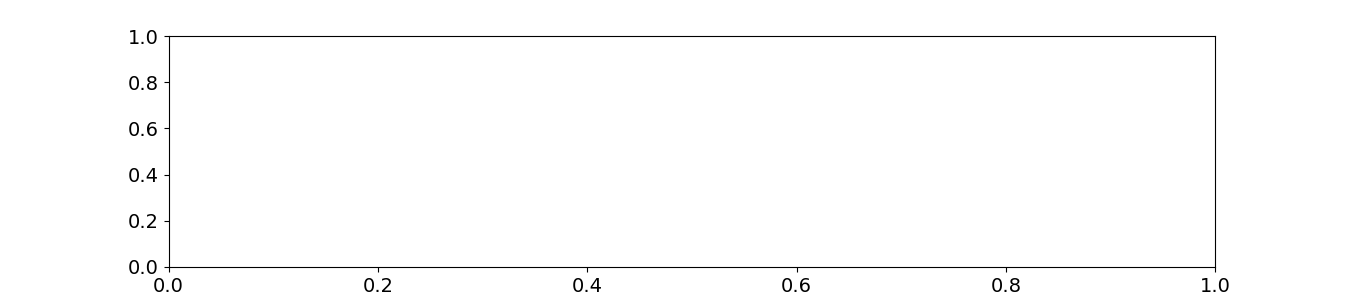

In [457]:
if "quantitative_comparison_fig" in locals():
    plt.close(quantitative_comparison_fig)

#quantitative_comparison_fig = plt.figure(figsize=[4.5, 3])
quantitative_comparison_fig = plt.figure(figsize=[13.5, 3]) #if SIM2USER_PER_USER == True
quantitative_comparison_ax = quantitative_comparison_fig.gca()

In [458]:
quantitative_comparison_ax.clear()
if quantitative_comparison_fig.get_figwidth() > 6:
    quantitative_comparison_fig.subplots_adjust(left=0.075, right=0.975, bottom=0.1, top=0.9)#, wspace=0.26, hspace=0.2)
else:
    quantitative_comparison_fig.subplots_adjust(left=0.2, right=0.95, bottom=0.2, top=0.9)#, wspace=0.26, hspace=0.2)

###
QUANTITY = "pos"

USER2USER_FIXED = False  #if True, compare predictability of user movements of USER_ID_FIXED between simulation and other users
USER2USER = False  #if True, compare predictability of user movements (of all users) between simulation and respective other users

SIM2USER_PER_USER = True  #if True, compare cost function simulation for each user separately

COLOR_PALETTE = "turbo"  #None
ENABLE_LEGEND = True  #if False, legends is removed
###

if len(SIMULATION_SUBDIR_LIST) > 1:
    map_conditions = lambda x: "JAC" if "accjoint" in x else "CTC" if "ctc" in x else "DC" if "cso" in x else x
else:
    map_conditions = lambda x: x if x.startswith("U") else "Sim." if (PLOTTING_ENV_COMPARISON == "RL-UIB") else ("JAC" if "accjoint" in x else "CTC" if "ctc" in x else "DC" if "cso" in x else x) if USER2USER_FIXED else "Simulation\nvs. User"
label_dict = {"pos": ("Cursor Positions", r"$(m)$"),
             "vel": ("Cursor Velocities", r"$\left(\frac{m}{s}\right)$"),
             "acc": ("Cursor Accelerations", r"$\left(\frac{m}{s^2}\right)$"),
             "qpos": ("Joint Angles", r"$(rad)$"),
             "qvel": ("Joint Velocities", r"$\left(\frac{rad}{s}\right)$"),
             "qacc": ("Joint Accelerations", r"$\left(\frac{rad}{s^2}\right)$")}
map_task_conditions = lambda x: " ".join(["Virtual Pad" if "_Pad_" in x else "Virtual Cursor", "ID" if "_ID_" in x else "Erg." if "_Handtuned_" in x else "???"])

if USER2USER_FIXED:
    res_dict = locals()[f"res_dict_predict_fixeduser_{QUANTITY}"]
    quantitative_comparison_ax.set_yscale("log")
elif USER2USER:
    res_dict = locals()[f"res_dict_predict_{QUANTITY}"]
    #res_dict = {k: v[1::6] for k,v in locals()[f"res_dict_predict_{QUANTITY}"].items()}
    quantitative_comparison_ax.set_yscale("log")
else:
    res_dict = locals()[f"res_dict_{QUANTITY}"]
    quantitative_comparison_ax.set_yscale("log")

quantitative_comparison_ax.set_title(f"{'All' if len(TASK_CONDITION_LIST) == 4 else '/'.join([map_task_conditions(x) for x in TASK_CONDITION_LIST])} Trials of {USER_ID_FIXED} – {label_dict[QUANTITY][0]}" if USER2USER_FIXED else f"{'All Trials' if len(TASK_CONDITION_LIST) == 4 else '/'.join([map_task_conditions(x) for x in TASK_CONDITION_LIST])} – {label_dict[QUANTITY][0]}", fontsize=14)
quantitative_comparison_ax.set_ylabel(f"RMSE {label_dict[QUANTITY][1]}", fontsize=14)
quantitative_comparison_ax.tick_params(axis='both', which='major', labelsize=14)
quantitative_comparison_ax.tick_params(axis='both', which='minor', labelsize=12)

if SIM2USER_PER_USER:
    assert not (USER2USER or USER2USER_FIXED)
    boxplot_df_melt = pd.DataFrame()
    boxplot_df_user = pd.Series(dtype=str)
    for i in range(len(USER_ID_LIST)):
        boxplot_df = pd.DataFrame({map_conditions(k): pd.Series(np.concatenate(v[i*len(TASK_CONDITION_LIST): (i+1)*len(TASK_CONDITION_LIST)]).ravel()) for k, v in res_dict.items()})

        boxplot_df_melt = pd.concat((boxplot_df_melt, boxplot_df.melt()))
        boxplot_df_user = pd.concat((boxplot_df_user, pd.Series([USER_ID_LIST[i]] * boxplot_df.melt().shape[0])))
    boxplot_df_melt["User"] = boxplot_df_user
    boxplot_df_melt = boxplot_df_melt.rename({'variable': 'Cost function', 'value': f"RMSE {label_dict[QUANTITY][1]}"}, axis=1)
    sns.boxplot(data=boxplot_df_melt, x="User", y=f"RMSE {label_dict[QUANTITY][1]}", hue="Cost function", ax=quantitative_comparison_ax, palette=COLOR_PALETTE)
    
    quantitative_comparison_ax.legend(loc="best", ncol=boxplot_df_melt["Cost function"].nunique())
else:
    boxplot_df = pd.DataFrame({map_conditions(k): pd.Series(np.concatenate(v).ravel()) for k, v in res_dict.items()})
    
    sns.boxplot(data=boxplot_df, ax=quantitative_comparison_ax, palette=[matplotlib.cm.get_cmap(COLOR_PALETTE)(0.2 if i.startswith("U") else 0.75) for i in boxplot_df.columns] if USER2USER or USER2USER_FIXED else COLOR_PALETTE)

# Add statistics annotations:
if USER2USER_FIXED:
    pass #add_stat_annotation(data=boxplot_df, ax=quantitative_comparison_ax, box_pairs=[(map_conditions(i), j) for i in SIMULATION_SUBDIR_LIST for j in USER_ID_LIST if j != USER_ID_FIXED], test="Wilcoxon" if not USER2USER_FIXED and not USER2USER else "Mann-Whitney", text_format="star", loc="inside", verbose=2)
else:
    if not SIM2USER_PER_USER:
        add_stat_annotation(data=boxplot_df, ax=quantitative_comparison_ax, box_pairs=itertools.combinations(boxplot_df.keys(), 2), test="Wilcoxon" if not USER2USER_FIXED and not USER2USER else "Mann-Whitney", text_format="star", loc="inside", verbose=2)

# Print additional statistic test results
if not USER2USER_FIXED and not USER2USER:
    kstest_results = [(cn, stats.kstest(boxplot_df[cn], 'norm')) for cn in boxplot_df.columns]
    #friedman_results = f"Friedman - $\chi^{2}$:{stats.friedmanchisquare(optparam_info_df_STATS['2OL-Eq"], optparam_info_df_STATS["MinJerk"], optparam_info_df_STATS["LQR"]).statistic}"#, p-value: {stats.friedmanchisquare(optparam_info_df_STATS).pvalue}"
    #friedman_results = stats.friedmanchisquare(optparam_info_df_STATS["2OL-Eq"], optparam_info_df_STATS["MinJerk"], optparam_info_df_STATS["LQR"])
    friedman_results = stats.friedmanchisquare(*[boxplot_df[cn] for cn in boxplot_df.columns])
    wilcoxon_results = [((cn1, cn2), stats.wilcoxon(boxplot_df[cn1], boxplot_df[cn2], alternative="two-sided"), 
                         'z-statistic:', (stats.wilcoxon(boxplot_df[cn1], boxplot_df[cn2], alternative="two-sided").statistic - boxplot_df.shape[0] * (boxplot_df.shape[0] + 1) / 4) / ((boxplot_df.shape[0] * (boxplot_df.shape[0] + 1) * (2 * boxplot_df.shape[0] + 1) / 24) ** 0.5), 
                         'z-statistic (cp., unsigned):', stats.norm.isf(stats.wilcoxon(boxplot_df[cn1], boxplot_df[cn2], alternative="two-sided").pvalue / 2)) for cn1, cn2 in list(itertools.combinations(boxplot_df.columns, 2))]
    #print(f"{QUANTITY}:\n\t{kstest_results}\n\t{friedman_results}\n\t{wilcoxon_results}")
    print(f"\n{QUANTITY}")
    print('Kolmogorov-Smirnov:', *kstest_results, sep='\n\t')
    print(f'Friedman ({boxplot_df.columns.values}):', friedman_results, sep='\n\t')
    print('Wilcoxon Signed Rank:', *wilcoxon_results, sep='\n\t')
elif USER2USER and not USER2USER_FIXED:
    assert boxplot_df.shape[1] == 2
    mannwhitneyu_results = [stats.mannwhitneyu(boxplot_df.iloc[:, 0], boxplot_df.iloc[:, 1], nan_policy='omit'),
                            'z-statistic (with continuity correction):', (stats.mannwhitneyu(boxplot_df.iloc[:, 0], boxplot_df.iloc[:, 1], nan_policy='omit').statistic - ((sum(~boxplot_df.iloc[:, 0].isna()) * sum(~boxplot_df.iloc[:, 1].isna())) / 2) + 0.5) / ((sum(~boxplot_df.iloc[:, 0].isna()) * (sum(~boxplot_df.iloc[:, 1].isna())) * (sum(~boxplot_df.iloc[:, 0].isna()) + sum(~boxplot_df.iloc[:, 1].isna()) + 1) / 12) ** 0.5), 
                            ]
    print(f"\n{QUANTITY}")
    print('Mann-Whitney U:', *mannwhitneyu_results, sep='\n\t')

# Remove legend
if not ENABLE_LEGEND:
    current_legend = quantitative_comparison_ax.get_legend()
    if current_legend:
        current_legend.remove()
        
# # Manually change whisker label
# test = quantitative_comparison_ax.get_xticklabels()
# test[1].set_text("User\nvs. User")
# quantitative_comparison_ax.set_xticklabels(test)

# STORE TO FILE
if USER2USER_FIXED:
    if PLOTTING_ENV_COMPARISON == "RL-UIB":
        plot_filename_quantitative_ID = f"UIB/{_plot_SIMULATION_SUBDIR_LIST}/{USER_ID_FIXED}_FIXED/RMSE_{QUANTITY}"        
    elif PLOTTING_ENV_COMPARISON == "MPC":
        plot_filename_quantitative_ID = f"MPC/{_plot_SIMULATION_SUBDIR_LIST}/{USER_ID_FIXED}_FIXED/{_plot_TASK_CONDITION_LIST}/RMSE_{QUANTITY}"
    else:
        raise NotImplementedError
elif USER2USER:
    if PLOTTING_ENV_COMPARISON == "MPC":
        plot_filename_quantitative_ID = f"MPC/{_plot_SIMULATION_SUBDIR_LIST}/ALLUSERS/{_plot_TASK_CONDITION_LIST}/RMSE_{QUANTITY}"
    else:
        raise NotImplementedError
else:
    if SIM2USER_PER_USER:
        if PLOTTING_ENV_COMPARISON == "MPC":
            plot_filename_quantitative_ID = f"MPC/{_plot_SIMULATION_SUBDIR_LIST}/ALLUSERS/{_plot_TASK_CONDITION_LIST}/RMSE_simonly_peruser_{QUANTITY}"
        else:
            raise NotImplementedError
    else:
        if PLOTTING_ENV_COMPARISON == "MPC":
            plot_filename_quantitative_ID = f"MPC/{_plot_SIMULATION_SUBDIR_LIST}/ALLUSERS/{_plot_TASK_CONDITION_LIST}/RMSE_simonly_{QUANTITY}"
        else:
            raise NotImplementedError
#quantitative_comparison_fig.savefig(f"/home/florian/reacher_sg/_plots/{plot_filename_quantitative_ID}.png", dpi=300)



pos
Kolmogorov-Smirnov:
	('DC', KstestResult(statistic=0.5011166376235642, pvalue=5.97529761960287e-54))
	('CTC', KstestResult(statistic=0.5013033231144477, pvalue=5.416006478067549e-54))
	('JAC', KstestResult(statistic=0.5023032470041532, pvalue=3.1968259861198726e-54))
Friedman (['DC' 'CTC' 'JAC']):
	FriedmanchisquareResult(statistic=86.9304347826087, pvalue=1.328299264688126e-19)
Wilcoxon Signed Rank:
	(('DC', 'CTC'), WilcoxonResult(statistic=4351.0, pvalue=9.472293620545554e-19), 'z-statistic:', -8.841168196483219, 'z-statistic (cp., unsigned):', 8.84116819648322)
	(('DC', 'JAC'), WilcoxonResult(statistic=6838.0, pvalue=1.778744721109373e-10), 'z-statistic:', -6.379321328134815, 'z-statistic (cp., unsigned):', 6.379321328134816)
	(('CTC', 'JAC'), WilcoxonResult(statistic=11159.0, pvalue=0.03555123911568615), 'z-statistic:', -2.102023250879708, 'z-statistic (cp., unsigned):', 2.102023250879708)


In [104]:
boxplot_df
from matplotlib.cbook import boxplot_stats  
for cn in boxplot_df.columns:
    print(f"{cn}: {len(boxplot_stats(boxplot_df[cn]).pop(0)['fliers'])/len(boxplot_df)*100:.2f}% outliers")

DC: 0.72% outliers
CTC: 3.30% outliers
JAC: 3.80% outliers


In [242]:
plot_filename_quantitative_ID

'MPC/fitts_btrzx1_tochi_neu_09032022_2021-10-25_N8_cso_sae_noise__fitts_btrzx1_tochi_neu_09032022_2021-10-25_ctc_N8_cso_sae_noise__fitts_btrzx1_tochi_neu_09032022_2021-10-25_accjoint_N8_cso_sae_noise/U1_FIXED/Standing_ID_ISO_15_plane__Standing_Cursor_Handtuned_ISO_15_plane__Standing_Pad_ID_ISO_15_plane__Standing_Pad_Handtuned_vertical_ISO_15_plane/RMSE_qacc'

### Other Stuff (Testing)

In [ ]:
if "test_fig" in locals():
    plt.close(test_fig)

test_fig = plt.figure()
test_ax = test_fig.gca()

In [ ]:
test_ax.clear()

target_array = np.array([[ 5.5000e-01, -1.0000e-01, -1.5000e-01],
       [ 5.5000e-01, -1.3590e-01,  1.4564e-01],
       [ 5.5000e-01, -3.0300e-02, -1.3282e-01],
       [ 5.5000e-01, -1.9947e-01,  1.1228e-01],
       [ 5.5000e-01,  2.3440e-02, -8.5210e-02],
       [ 5.5000e-01, -2.4026e-01,  5.3190e-02],
       [ 5.5000e-01,  4.8900e-02, -1.8080e-02],
       [ 5.5000e-01, -2.4891e-01, -1.8080e-02],
       [ 5.5000e-01,  4.0250e-02,  5.3190e-02],
       [ 5.5000e-01, -2.2345e-01, -8.5210e-02],
       [ 5.5000e-01, -5.4000e-04,  1.1228e-01],
       [ 5.5000e-01, -1.6971e-01, -1.3282e-01],
       [ 5.5000e-01, -6.4110e-02,  1.4564e-01]])[:, 1:] * np.array([[-1, 1]])
test_ax.scatter(*target_array.T, s=100, color=[matplotlib.cm.get_cmap('turbo')((i+1)/(2*(len(target_array))) + (0.5 if i%2 else 0)) for i in range(len(target_array))])
#test_ax.scatter(*target_array.T, s=500, color=[matplotlib.cm.get_cmap('nipy_spectral')((-0.04 + 4*i/(len(target_array)))%1) for i in range(len(target_array))])

for i in range(len(target_array)):
    test_ax.annotate(i, (target_array[i, 0], target_array[i, 1]), xytext=((0.05 - target_array[i, 0])*100, (-0.05-target_array[i, 1])*100), textcoords='offset points', color="black", fontsize=16)

## ALEKSI:
#test_ax.set_axis_off()
## MARKUS:
test_ax.set_xlabel('x', fontsize=14, labelpad=8)
test_ax.set_ylabel('y', fontsize=14, labelpad=8)
test_ax.tick_params(axis='both', which='major', labelsize=14)
test_ax.set_title("ISO Target Positions",size=16)

test_fig.tight_layout()

In [ ]:
[(3*i/(len(target_array)))%1 for i in range(len(target_array))]

In [ ]:
if "repeated_movements_fig" in locals():
    plt.close(repeated_movements_fig)
plt.ion()
repeated_movements_fig = plt.figure()
repeated_movements_ax = repeated_movements_fig.gca()
# repeated_movements_fig, repeated_movements_ax = plt.subplots(1, 2, figsize=[9, 3])

In [ ]:
MOVEMENT_ID = "1".zfill(2)

rep_movs_filepath = f"~/user-in-the-box/output/{REP_MOVS_FILENAME}/repeated-movements/movement_{MOVEMENT_ID}/radius_4/state_log.pickle"

rep_movs_data = []
with open(os.path.expanduser(rep_movs_filepath), "rb") as f:
    rep_movs_data = pickle.load(f)

np.where(rep_movs_data["episode_1"]["target_hit"])

In [ ]:
repeated_movements_ax.clear()

###
REP_MOVS_FILENAME = "NegativeExpDistance-neural"

REMOVE_OUTLIERS = True

USE_TARGETBOUND_AS_DIST = False
DWELL_TIME = 0.3  #only used if USE_TARGETBOUND_AS_DIST == False

PLOT_TYPE = "mean_groups"  #"alldata", "boxplot", "mean_groups", "meandata", "density_ID"
BOXPLOT_category = "ID"
BOXPLOT_nbins = 5
BOXPLOT_qbins = True  #whether to use quantile-based bins (i.e., same number of samples per bin) or range-based bins (i.e., same length of each bin interval)

DENSITY_group_nIDbins = 5  #number of ID groups
DENSITY_group_IDbin_ID = 4  #index of ID group (between 0 and DENSITY_group_nIDbins-1) for which a density plot of movement times is created (only used if PLOT_TYPE == "density_ID")
DENSITY_group_nMTbins = 50
###

rep_movs_filepath = f"~/user-in-the-box/output/{REP_MOVS_FILENAME}/repeated-movements"

if PLOT_TYPE != "boxplot":
    BOXPLOT_category = "ID (bits)"  #used for xlabel

# Compute ID and MT pairs from dataset:
distance_list = []
width_list = []
ID_list = []
MT_list = []
target_position_list = []
initial_position_list = []
failed_movements_counter = 0
for EPISODE_ID, data_episode in data.items():
    position_series = data_episode["fingertip_xpos"]
    time_per_step = np.diff(data_episode["timestep"]).mean()  #0.01
#    indices = np.append(np.insert(np.where(data_episode["target_hit"])[0], 0, 0), len(data_episode["target_hit"]))
    indices = np.insert(np.where(data_episode["target_spawned"])[0], 0, 0)
    for last_idx, current_idx, next_idx in list(zip(np.concatenate(([-1], indices[:-1])), indices, indices[1:])):
        #test[idx] = (next_idx - current_idx, data_episode["target_radius"][current_idx])
        width = 2 * data_episode["target_radius"][current_idx]
        # use nominal distance:
        #TODO: use "effective_projection_path" parameter
        init_val = data_episode["target_position"][last_idx] if last_idx >= 0 else position_series[0]
        if USE_TARGETBOUND_AS_DIST:
            if "inside_target" not in data_episode:  #use "target_radius" column
                assert len(np.unique(data_episode["target_radius"][current_idx + 1:next_idx])) == 1, "ERROR: Target radius changes during movement! Cannot find reliable information about when target has been entered.\nFix dataset or use target center as distance (set 'USE_TARGETBOUND_AS_DIST=False')."
                rel_indices_targetbound = np.where(np.linalg.norm(np.array(position_series[current_idx + 1:next_idx]) - np.array(data_episode["target_position"][current_idx + 1:next_idx]), axis=1) < data_episode["target_radius"][current_idx + 1])[0]
            else:  #use "inside_target" column
                rel_indices_targetbound = np.where(data_episode["inside_target"][current_idx + 1:next_idx])[0]
            if len(rel_indices_targetbound) > 0 :
                targetbound_idx = current_idx + 1 + rel_indices_targetbound[0]
            else:  #movement failed
                failed_movements_counter += 1
                continue
            final_val = position_series[targetbound_idx]
        else:
            final_val = data_episode["target_position"][current_idx] #or position_series[next_idx - 1]
        if isinstance(final_val, tuple) and len(final_val) == 1:
            final_val = final_val[0]
        # # use effective distance:
        # init_val = position_series[current_idx]
        # final_val = position_series[next_idx - 1]
        ######################################
        distance = np.linalg.norm(final_val - init_val)
        #fitts_ID = np.log2(2*distance/width)
        fitts_ID = np.log2((distance/width) + 1)
        width_list.append(width)
        distance_list.append(distance)
        ID_list.append(fitts_ID)
        if USE_TARGETBOUND_AS_DIST:
            MT_list.append((targetbound_idx - current_idx)*time_per_step)
        else:
            MT_list.append((next_idx - current_idx)*time_per_step - DWELL_TIME)
        target_position_list.append(final_val)
        initial_position_list.append(init_val)
# Remove outliers:
movement_indices_TO_DELETE = []
if REMOVE_OUTLIERS:
    # Ensure that too long movements are removed (all movements with duration - mean(duration) > 3 * std(duration))
    #MT_list_zscores = stats.zscore(MT_list)
    #movement_indices_TO_DELETE = np.where(np.abs(stats.zscore(MT_list)) > 3)[0].tolist()
    
    movement_indices_TO_DELETE = np.where(np.array(MT_list) >= 4.0 - DWELL_TIME)[0].tolist()

    distance_list = [val for idx, val in enumerate(distance_list) if idx not in movement_indices_TO_DELETE]
    width_list = [val for idx, val in enumerate(width_list) if idx not in movement_indices_TO_DELETE]
    ID_list = [val for idx, val in enumerate(ID_list) if idx not in movement_indices_TO_DELETE]
    MT_list = [val for idx, val in enumerate(MT_list) if idx not in movement_indices_TO_DELETE]
    target_position_list = [val for idx, val in enumerate(target_position_list) if idx not in movement_indices_TO_DELETE]
    initial_position_list = [val for idx, val in enumerate(initial_position_list) if idx not in movement_indices_TO_DELETE]

add_info = f'{len(movement_indices_TO_DELETE)} outliers were dropped' if movement_indices_TO_DELETE else '', f'{failed_movements_counter} movements failed' if failed_movements_counter else ''
add_info_nonempty = [i for i in add_info if len(i)]
add_info_str = f" ({'; '.join(add_info_nonempty)})" if add_info_nonempty else ""
print(f"INFO: Using {len(ID_list)} movements from {len(data)} episodes{add_info_str}.")

# Linear regression:
poly_coef = np.polyfit(ID_list, MT_list, 1)
p_linreg = np.poly1d(poly_coef)

# Coefficient of determination:
SQE = np.square(np.linalg.norm(p_linreg(ID_list) - np.mean(MT_list)))
SQT = np.square(np.linalg.norm(MT_list - np.mean(MT_list)))
R2 = SQE/SQT
print("Fitts' Law - Coefficient of determination (R^2): {}".format(R2))

if PLOT_TYPE == "boxplot":
    df = pd.DataFrame({"Distance": distance_list, "Width": width_list, "ID": ID_list, "MT": MT_list})
    if BOXPLOT_qbins:
        df_bins = df.groupby([pd.qcut(df[BOXPLOT_category], BOXPLOT_nbins)])["MT"].apply(list)
    else:
        df_bins = df.groupby([pd.cut(df[BOXPLOT_category], BOXPLOT_nbins)])["MT"].apply(list)
    df_bins_renamed = df_bins.rename(lambda x: f"{x.left.round(2)}-{x.right.round(2)}", axis=0)
    repeated_movements_ax.boxplot(df_bins_renamed, labels=df_bins_renamed.index, positions=[x.mid for x in df_bins.index], widths=[0.8*(x.right - x.left) for x in df_bins.index])
    repeated_movements_ax.relim()
    if BOXPLOT_category == "ID":
        lin_regression_x = locals()[f"{BOXPLOT_category}_list"]
        lin_regression_y = p_linreg(ID_list)
        lin_regression_sorted = sorted(zip(lin_regression_x, lin_regression_y))
        lin_regression_x = [x for x, y in lin_regression_sorted]
        lin_regression_y = [y for x, y in lin_regression_sorted]
        repeated_movements_ax.plot(lin_regression_x, lin_regression_y, color="red")
elif PLOT_TYPE == "mean_groups":
    df = pd.DataFrame({"Distance": distance_list, "Width": width_list, "ID": ID_list, "MT": MT_list})
    if BOXPLOT_qbins:
        df_bins_groupby = df.groupby([pd.qcut(df["Distance"], BOXPLOT_nbins), pd.qcut(df["Width"], BOXPLOT_nbins)])["MT"]
    else:
        df_bins_groupby = df.groupby([pd.cut(df["Distance"], BOXPLOT_nbins), pd.cut(df["Width"], BOXPLOT_nbins)])["MT"]
    df_bins = df_bins_groupby.mean()
    df_bins_renamed = df_bins.rename(lambda x: f"{x.left.round(2)}-{x.right.round(2)}", axis=0)
    df_bins_renamed.index = df_bins_renamed.index.map(lambda x: f"D: {x[0]}, W: {x[1]}")
    trans_dict_dist = {number: chr(ord('@')+number+1) for number in range(BOXPLOT_nbins)}
    trans_dict_width = {number: str(number) for number in range(BOXPLOT_nbins)}
    group_identifiers_dist = [(str(trans_dict_dist[idx]), f"D: {value}") for idx, value in enumerate(df_bins.index.get_level_values(0).unique().tolist())]
    group_identifiers_width = [(str(trans_dict_width[idx]), f"W: {value}") for idx, value in enumerate(df_bins.index.get_level_values(1).unique().tolist())]
    group_identifiers = df_bins.index.map(lambda x: "".join([trans_dict_dist[df_bins.index.get_level_values(0).unique().tolist().index(x[0])], trans_dict_width[df_bins.index.get_level_values(1).unique().tolist().index(x[1])]]))
    if BOXPLOT_qbins:
        df["classification"] = [df_bins.index.get_loc((x["Distance"], x["Width"])) for _, x in pd.concat((pd.qcut(df["Distance"], BOXPLOT_nbins), pd.qcut(df["Width"], BOXPLOT_nbins)), axis=1).iterrows()]
    else:
        df["classification"] = [df_bins.index.get_loc((x["Distance"], x["Width"])) for _, x in pd.concat((pd.cut(df["Distance"], BOXPLOT_nbins), pd.cut(df["Width"], BOXPLOT_nbins)), axis=1).iterrows()]
    df_bins = df_bins.reset_index()
    #df_bins["ID"] = df_bins.apply(lambda x: pd.Interval(np.log2(2*x["Distance"].left / x["Width"].right), np.log2(2*x["Distance"].right / x["Width"].left)), axis=1)
    #df_bins["Average ID"] = df_bins.apply(lambda x: np.log2(2*x["Distance"].mid / x["Width"].mid), axis=1)
    df_bins["ID"] = df_bins.apply(lambda x: pd.Interval(np.log2((x["Distance"].left / x["Width"]) + 1), np.log2((x["Distance"].right / x["Width"]) + 1)) if type(x["Width"]) == float else (pd.Interval(np.log2((x["Distance"] / x["Width"].right) + 1), np.log2((x["Distance"] / x["Width"].left) + 1)) if type(x["Distance"]) == float else pd.Interval(np.log2((x["Distance"].left / x["Width"].right) + 1), np.log2((x["Distance"].right / x["Width"].left)+1))), axis=1)
    df_bins["Average ID"] = df_bins.apply(lambda x: np.log2((x["Distance"].mid / x["Width"]) + 1) if type(x["Width"]) == float else (np.log2((["Distance"] / x["Width"].mid) + 1) if type(x["Distance"]) == float else np.log2((x["Distance"].mid / x["Width"].mid) + 1)), axis=1)
    df_bins["Number of Samples"] = df_bins_groupby.size().reset_index(drop=True)
    xtick_offset = 0
    
    ### ONLY SHOW SOME CONDITIONS:
    # df = df.loc[(df["classification"] >= 5) & (df["classification"] < 15)]
    # group_identifiers_dist = group_identifiers_dist[1:3]
    # group_identifiers = group_identifiers[5:15]
    # df_bins = df_bins.iloc[5:15]
    # df_bins_renamed = df_bins_renamed.iloc[5:15]
    # xtick_offset = 5

    repeated_movements_ax.scatter(range(xtick_offset, xtick_offset + len(df_bins_renamed)), df_bins_renamed, color="red")#, positions=[x.mid for x in df_bins.index], widths=[0.8*(x.right - x.left) for x in df_bins.index])
    repeated_movements_ax.scatter(df["classification"], df["MT"], color="blue", s=0.2)
    ## VARIANT 1 - detailed xlabels:
    #repeated_movements_ax.set_xticks(range(len(df_bins_renamed)), df_bins_renamed.index, fontsize=4)
    ## VARIANT 2 - abbreviations as xlabels, additional legend:
    #repeated_movements_ax.set_xticks(df_bins[~df_bins["MT"].isna()].index, df_bins[~df_bins["MT"].isna()].index + 1)
    repeated_movements_ax.set_xticks(df_bins[~df_bins["MT"].isna()].index, group_identifiers[~df_bins["MT"].isna()])
    class MarkerHandler(mpl.legend_handler.HandlerBase):  #source: https://stackoverflow.com/a/47395401
        def create_artists(self, legend, integer, xdescent, ydescent,
                            width, height, fontsize,trans):
            marker_obj = mpl.markers.MarkerStyle(f'${integer}$') #Here you place your integer
            path = marker_obj.get_path().transformed(marker_obj.get_transform())

            path._vertices = np.array(path._vertices)*8 #To make it larger
            patch = mpl.patches.PathPatch(path, color="black", lw=0, transform=trans+mpl.transforms.Affine2D().translate(0, 5.5))
            return [patch]
    repeated_movements_ax.legend([x for x, y in group_identifiers_dist + group_identifiers_width], [y for x,y in group_identifiers_dist + group_identifiers_width], handler_map={str:MarkerHandler()}, handletextpad=0, handlelength=1)#, fontsize=8)
    ################################
    repeated_movements_ax.relim()
elif PLOT_TYPE == "meandata":
    df = pd.DataFrame({"Distance": distance_list, "Width": width_list, "ID": ID_list, "MT": MT_list})
    if BOXPLOT_qbins:
        df_bins_groupby = df.groupby([pd.qcut(df["Distance"], BOXPLOT_nbins), pd.qcut(df["Width"], BOXPLOT_nbins)])["MT"]
    else:
        df_bins_groupby = df.groupby([pd.cut(df["Distance"], BOXPLOT_nbins), pd.cut(df["Width"], BOXPLOT_nbins)])["MT"]        
    df_bins = df_bins_groupby.mean()
    df_bins_renamed = df_bins.rename(lambda x: f"{x.left.round(2)}-{x.right.round(2)}", axis=0)
    df_bins_renamed.index = df_bins_renamed.index.map(lambda x: f"D: {x[0]}, W: {x[1]}")
    df_bins = df_bins.reset_index()
    #df_bins["ID"] = df_bins.apply(lambda x: pd.Interval(np.log2(2*x["Distance"].left / x["Width"].right), np.log2(2*x["Distance"].right / x["Width"].left)), axis=1)
    #df_bins["Average ID"] = df_bins.apply(lambda x: np.log2(2*x["Distance"].mid / x["Width"].mid), axis=1)
    df_bins["ID"] = df_bins.apply(lambda x: pd.Interval(np.log2((x["Distance"].left / x["Width"]) + 1), np.log2((x["Distance"].right / x["Width"]) + 1)) if type(x["Width"]) == float else (pd.Interval(np.log2((x["Distance"] / x["Width"].right) + 1), np.log2((x["Distance"] / x["Width"].left) + 1)) if type(x["Distance"]) == float else pd.Interval(np.log2((x["Distance"].left / x["Width"].right) + 1), np.log2((x["Distance"].right / x["Width"].left)+1))), axis=1)
    df_bins["Average ID"] = df_bins.apply(lambda x: np.log2((x["Distance"].mid / x["Width"]) + 1) if type(x["Width"]) == float else (np.log2((["Distance"] / x["Width"].mid) + 1) if type(x["Distance"]) == float else np.log2((x["Distance"].mid / x["Width"].mid) + 1)), axis=1)
    df_bins["Number of Samples"] = df_bins_groupby.size().reset_index(drop=True)
    
    ### ONLY SHOW SOME CONDITIONS:
#     df_bins = df_bins.iloc[5:15]
#     df_bins_renamed = df_bins_renamed.iloc[5:15]
    
    repeated_movements_ax.scatter(df_bins["Average ID"], df_bins["MT"])
    repeated_movements_ax.plot(df_bins["Average ID"], p_linreg(df_bins["Average ID"]), color="red")
    
    # Coefficient of determination on mean groups:
    ID_list_mean = df_bins.loc[~df_bins["MT"].isna(), "Average ID"]
    MT_list_mean = df_bins.loc[~df_bins["MT"].isna(), "MT"]
    poly_coef_mean = np.polyfit(ID_list_mean, MT_list_mean, 1)
    p_linreg_mean = np.poly1d(poly_coef_mean)
    SQE_mean = np.square(np.linalg.norm(p_linreg_mean(ID_list_mean) - np.mean(MT_list_mean)))
    SQT_mean = np.square(np.linalg.norm(MT_list_mean - np.mean(MT_list_mean)))
    R2_mean = SQE_mean/SQT_mean
    print("Fitts' Law [ON MEAN PER CONDITION] - Coefficient of determination (R^2): {}".format(R2_mean))
elif PLOT_TYPE == "alldata":
    repeated_movements_ax.scatter(ID_list, MT_list)
    repeated_movements_ax.plot(ID_list, p_linreg(ID_list), color="red")
elif PLOT_TYPE == "density_ID":
    df = pd.DataFrame({"Distance": distance_list, "Width": width_list, "ID": ID_list, "MT": MT_list})
    if BOXPLOT_qbins:
        df_bins_ID_helper = pd.qcut(df["ID"], DENSITY_group_nIDbins)
        df_bins_ID_groupby = df.groupby([df_bins_ID_helper])["MT"]
        df_bins_ID = df_bins_ID_groupby.mean()
        df["classification"] = [df_bins_ID.index.get_loc(x) for x in df_bins_ID_helper.values]
    else:
        df_bins_ID_helper = pd.cut(df["ID"], DENSITY_group_nIDbins)
        df_bins_ID_groupby = df.groupby([df_bins_ID_helper])["MT"]
        df_bins_ID = df_bins_ID_groupby.mean()
        df["classification"] = [df_bins_ID.index.get_loc(x) for x in df_bins_ID_helper.values]
    ID_groups = sorted(df_bins_ID_helper.unique())
    df_bins_ID = df_bins_ID.reset_index()
    df_bins_ID["Average ID"] = df_bins_ID.apply(lambda x: x["ID"].mid, axis=1)
    df_bins_ID["Number of Samples"] = df_bins_ID_groupby.size().reset_index(drop=True)

    repeated_movements_ax.hist(df.loc[df["classification"] == DENSITY_group_IDbin_ID, "MT"], DENSITY_group_nMTbins)
else:
    raise NotImplementedError

# # Save the default tick positions, so we can reset them...
# locs = repeated_movements_ax.get_xticks()
# # Reset the xtick locations.
# repeated_movements_ax.set_xticks(locs)

if PLOT_TYPE == "density_ID":
    repeated_movements_ax.set_xlabel("MT (s)")
elif PLOT_TYPE not in ["mean_groups"]:
    repeated_movements_ax.set_xlabel(BOXPLOT_category + (f" bits" if (BOXPLOT_category == "ID") else "")) #"ID (bits)")  
if PLOT_TYPE == "density_ID":
    repeated_movements_ax.set_ylabel("Frequency")    
else:
    repeated_movements_ax.set_ylabel("MT (s)")
if PLOT_TYPE == "meandata":
    repeated_movements_ax.set_title("Fitts' Law on Mean Data ($R^2=${:.4f}; $a=${:.2f}, $b=${:.2f})".format(R2_mean, poly_coef_mean[1], poly_coef_mean[0]), fontsize=14) #fontsize=18)
elif PLOT_TYPE == "density_ID":
    repeated_movements_ax.set_title(f"Movement Time – Density Plot (ID: {ID_groups[DENSITY_group_IDbin_ID]})")
else:
    repeated_movements_ax.set_title("Fitts' Law ($R^2=${:.4f}; $a=${:.2f}, $b=${:.2f})".format(R2, poly_coef[1], poly_coef[0]), fontsize=14) #fontsize=18)

if PLOT_TYPE == "density_ID":
    repeated_movements_fig.savefig(f"plots/{REP_MOVS_FILENAME}/repeated_movs_movement_time_{PLOT_TYPE}group{DENSITY_group_IDbin_ID}.png", dpi=120)
else:
    repeated_movements_fig.savefig(f"plots/{REP_MOVS_FILENAME}/repeated_movs_fittslaw_{PLOT_TYPE}.png", dpi=120)
        

In [ ]:
atest = pd.read_csv("/mnt/external/data/NewExperimentForCHI/U1/20200913-164321_Experiment_U1_Standing_ID_ISO_15_plane.csv")

atest2 = (atest.loc[:, "Target.Position.x":"Target Position.z"].iloc[0:] - atest.loc[0, "Shoulder.Position.x":"Shoulder.Position.z"].tolist()).to_numpy()
#target_array_user = (experiment_info.loc[:, "Target.Position.x":"Target Position.z"].iloc[0:]).to_numpy()
atest2 *= np.array([-1, 1, 1])
atest2 = atest2[:, [2, 0, 1]] #-np.array([0.55, 0, 0.1])
atest2[:13]#.mean(axis=0)

In [ ]:
test_figg = plt.figure()
test_axx = test_figg.gca()

In [ ]:
test_axx.clear()

test_study_targets = (target_position_series_STUDY[indices_STUDY[:, 0], :])[:, [2, 0, 1]]
test_axx.scatter(-test_study_targets[:13, 1], test_study_targets[:13, 2])
for idx, i in enumerate(test_study_targets[:13, :]):
    test_axx.annotate(indices_STUDY[idx, 3], (-i[1], i[2]))
    
test_simulation_targets = np.squeeze(target_position_series)[[i[1] for i in selected_movements_indices]]#[:, [0, 2, 1]]
test_axx.scatter(-test_simulation_targets[:, 1], test_simulation_targets[:, 2])
for idx, i in enumerate(test_simulation_targets):
    test_axx.annotate((idx+1)%13, (-i[1], i[2]), color="tab:red")



In [ ]:
## shoulder1_r2 --> check shoulder ranges and proper definition of joint equality constraint
from scipy.spatial.transform import Rotation

#test = lambda alpha, beta: Rotation.from_euler("yxy", [alpha, -beta, -alpha]).apply(np.array([1,1,1]))
##test = lambda alpha, beta: Rotation.from_euler("yxy", [alpha, -beta, alpha]).apply(np.array([1,1,1])) if beta >= np.pi/2 else Rotation.from_euler("yxy", [alpha, -beta, -alpha]).apply(np.array([1,1,1]))
test = lambda alpha, beta: Rotation.from_euler("yxy", [alpha, -beta, -alpha + 2*beta/np.pi*alpha]).apply(np.array([1,1,1]))  #linear interpolation
#test = lambda alpha, beta: Rotation.from_euler("yxy", [alpha, -beta, -np.cos(beta)*alpha]).apply(np.array([1,1,1]))  #linear interpolation
#--> OPTIONAL [leads to previous shoulder_rot behavior at shoulder_elv=np.pi/2]: shoulder_rot range: [-np.pi/2, np.pi/9] -> [-np.pi/2, np.pi/9] - 2*np.min((beta, np.pi-beta))/np.pi*alpha
if "test_fig" in locals():
    plt.close(test_fig)
test_fig = plt.figure()
test_ax = test_fig.gca(projection="3d")

#test_mg = np.meshgrid(np.linspace(-np.pi/2, np.pi*13/18), np.linspace(np.pi/4, np.pi/4))
test_mg = np.meshgrid(np.linspace(-np.pi/2, np.pi*13/18), np.linspace(0, np.pi))
test_ax.scatter(*[i.flatten() for i in test_mg], [np.linalg.norm(test(x,y)-[1,1,1]) for x,y in zip(*[i.flatten() for i in test_mg])])

In [ ]:
if "test_fig" in locals():
    plt.close(test_fig)
test_fig = plt.figure()
test_ax = test_fig.gca()

test_ax.plot(np.linspace(0, np.pi), list(map(lambda x: 2*x/np.pi - 1, np.linspace(0, np.pi))))
test_ax.plot(np.linspace(0, np.pi), list(map(lambda x: -np.cos(x), np.linspace(0, np.pi))))

### Visualization of replayed movements (also see (commented parts of) test_mujoco.py)



In [ ]:
if "replay_fig" in locals():
    plt.close(replay_fig)
replay_fig = plt.figure()
replay_ax = replay_fig.gca()

In [ ]:
action_f = interp1d(trajectories_STUDY.time_series_trial, trajectories_STUDY.action_series_trial, axis=0, fill_value="extrapolate")
action_test = action_f(np.arange(trajectories_STUDY.time_series_trial[0], trajectories_STUDY.time_series_trial[-1].round(2) + 0.01, 0.01))
np.save("/home/florian/test_delete/user-in-the-box/UIB/test/test_action.npy", action_test)

init_qposqvel = np.vstack((trajectories_STUDY.qpos_series_trial[0], trajectories_STUDY.qvel_series_trial[0]))
np.save("/home/florian/test_delete/user-in-the-box/UIB/test/test_initqposqvel.npy", init_qposqvel)

In [ ]:
trajectories_STUDY.qpos_series_trial[:, 2]
new_qpos = np.load("/home/florian/test_delete/user-in-the-box/UIB/test/new_qpos.npy")
new_qvel = np.load("/home/florian/test_delete/user-in-the-box/UIB/test/new_qvel.npy")

qpos_f = interp1d(trajectories_STUDY.time_series_trial, trajectories_STUDY.qpos_series_trial, axis=0, fill_value="extrapolate")
qpos_test = qpos_f(np.arange(trajectories_STUDY.time_series_trial[0], trajectories_STUDY.time_series_trial[-1].round(2) + 0.01, 0.01))

replay_ax.clear()
replay_ax.plot(trajectories_STUDY.qpos_series_trial)
replay_ax.plot(qpos_test, label=independent_joints)
replay_ax.set_prop_cycle(None)
replay_ax.plot(new_qpos, linestyle='--')
replay_ax.legend()

In [11243]:
controller_trajectories_2D_ax.clear()

TASK_CONDITION = None #"17-14-44-difficulty-level1"  #None

PROJECTION_AXES = "xy"
END_SEGMENTS_ONLY = True  #for debugging

_global_target_coordinates = trajectories_STUDY._target_info.loc[:, ["global_x", "global_y", "global_z"]].drop_duplicates()
controller_trajectories_2D_ax.scatter(-1*_global_target_coordinates["global_x"], _global_target_coordinates["global_y"], c=matplotlib.colormaps["Set1"](_local_target_coordinates.index), s=1000)
